Week-1


In [ ]:
# Install helpers & import libraries
!pip install -q openpyxl

import os
import re
from collections import Counter
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

plt.rcParams["figure.figsize"] = (8,4)
RANDOM_SEED = 42



In [ ]:
DATA_DIR = "/content/drive/MyDrive/Project_dataset"
os.makedirs(DATA_DIR, exist_ok=True)
print("DATA_DIR:", DATA_DIR)
print("Files in DATA_DIR:", os.listdir(DATA_DIR))


DATA_DIR: /content/drive/MyDrive/Project_dataset
Files in DATA_DIR: ['pnas.2209630119.sd01.xlsx', 'pnas.2209630119.sd02.xlsx']


In [ ]:
# Verify Excel filenames (change names if your files have different names)
file_sd01 = os.path.join(DATA_DIR, "pnas.2209630119.sd01.xlsx")
file_sd02 = os.path.join(DATA_DIR, "pnas.2209630119.sd02.xlsx")

print("sd01 exists:", os.path.exists(file_sd01))
print("sd02 exists:", os.path.exists(file_sd02))

# Print sheet names so you can confirm which to load
if os.path.exists(file_sd01):
    print("sd01 sheets:", pd.ExcelFile(file_sd01).sheet_names)
if os.path.exists(file_sd02):
    print("sd02 sheets:", pd.ExcelFile(file_sd02).sheet_names)


sd01 exists: True
sd02 exists: True
sd01 sheets: ['Minerals ML_Tm']
sd02 sheets: ['412REmin_20220503']


In [ ]:
# Load the intended sheets (change sheet names if needed)
sheet_sd01 = "Minerals ML_Tm"
sheet_sd02 = "412REmin_20220503"

df_sd01 = pd.read_excel(file_sd01, sheet_name=sheet_sd01)
df_sd02 = pd.read_excel(file_sd02, sheet_name=sheet_sd02)

print("sd01 shape:", df_sd01.shape)
print("sd02 shape:", df_sd02.shape)
display(df_sd01.head(4))
display(df_sd02.head(4))


sd01 shape: (5793, 7)
sd02 shape: (412, 15)


Mineral Name (plain) IMA Chemistry (plain)  Oldest Known Age (Ma)  \
0              Diamond                     C                 4700.0   
1             Graphite                     C                 4700.0   
2            Eskolaite                 Cr2O3                 4700.0   
3           Perovskite                CaTiO3                 4700.0   

  Chemistry Elements                 Crystal Systems  Unnamed: 5  ML Tm (K)  
0                  C              cubic|orthorhombic         NaN     3800.0  
1                  C          orthorhombic|hexagonal         NaN     3800.0  
2               Cr O                       hexagonal         NaN     2607.0  
3            Ca Ti O  orthorhombic|cubic, monoclinic         NaN     2233.0

Unnamed: 0     Mineral Name Mineral Name (plain) Crystal Systems  \
0         0.0  Abenakiite-(Ce)        Yttriaite-(Y)           cubic   
1         1.0     Adamsite-(Y)       Cerianite-(Ce)           cubic   
2         2.0  Aeschynite-(Ce)        Heftetjernite      monoclinic   
3         3.0  Aeschynite-(Nd)        Formanite-(Y)      monoclinic   

   Oldest Known Age (Ma) chem_formula  ML Tm (K) Space group  \
0                    NaN     Y_2_O_3_     2713.0        Ia-3   
1                 2628.0       CeO_2_     2673.0       Fm-3m   
2                  967.0     ScTaO_4_     2613.0       P21/c   
3                 4000.0      YTaO_4_     2373.0       I41/a   

  Formatted formula  atom/cell  atoms/formula  chem complexity bit/atom  \
0              Y2O3        NaN            5.0                     0.971   
1              CeO2        3.0            3.0                     0.918   
2            ScTaO4       12.0            6.0                     1.252   
3             YTaO4       12.0            6.0                     1.252   

   structural complexity bit/atom  chem complexity bit/formula  \
0                             NaN                        4.855   
1                           0.918                        2.755   
2                           1.918                        7.512   
3                           1.918                        7.512   

   str complexity bit/reduced unit cell  
0                                   NaN  
1                                 2.755  
2                                23.020  
3                                23.020

In [ ]:
# Auto-detect the melting-point (target) column
def find_target_col(df):
    for c in df.columns:
        if any(k in str(c).lower() for k in ["tm", "melt", "melting"]):
            return c
    return None

target_sd01 = find_target_col(df_sd01)
target_sd02 = find_target_col(df_sd02)
print("Detected target columns:")
print(" sd01 ->", target_sd01)
print(" sd02 ->", target_sd02)


Detected target columns:
 sd01 -> ML Tm (K)
 sd02 -> ML Tm (K)



sd01 — non-null count:5793, missing:0


stats
count  5793.000000
mean   1009.254174
std     501.347480
min     226.113880
25%     495.000000
50%    1034.132100
75%    1340.309800
max    4036.592800

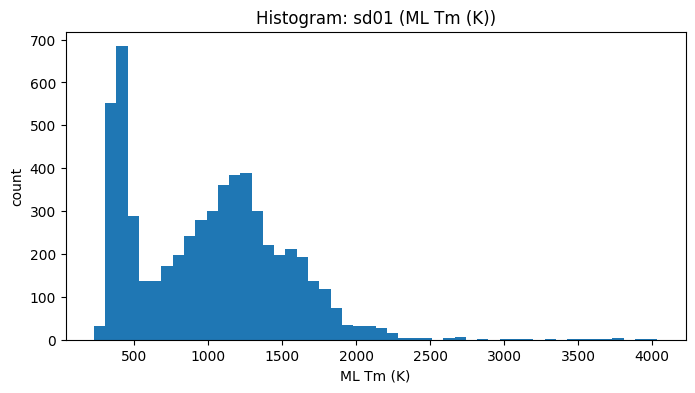

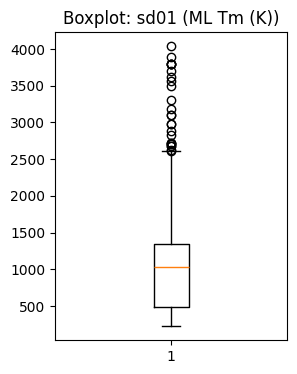


sd02 — non-null count:411, missing:1


stats
count   411.000000
mean   1296.103115
std     537.505690
min     335.389400
25%     837.136020
50%    1441.466800
75%    1644.882050
max    2713.000000

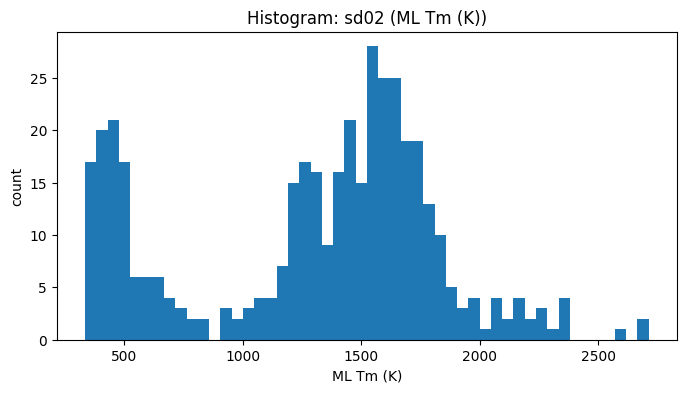

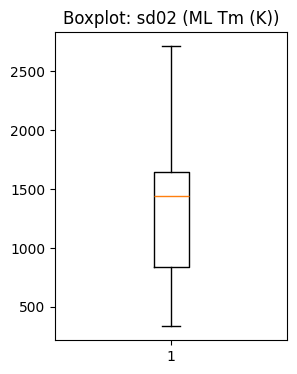

In [ ]:
# Quick EDA on the target: count, missing, stats, histogram, boxplot
def eda_target(df, target_col, label):
    ser = pd.to_numeric(df[target_col], errors='coerce')
    print(f"\n{label} — non-null count:{ser.count()}, missing:{ser.isna().sum()}")
    display(ser.describe().to_frame(name="stats"))
    plt.figure(); plt.hist(ser.dropna(), bins=50); plt.title(f"Histogram: {label} ({target_col})"); plt.xlabel(target_col); plt.ylabel("count"); plt.show()
    plt.figure(figsize=(3,4)); plt.boxplot(ser.dropna(), vert=True); plt.title(f"Boxplot: {label} ({target_col})"); plt.show()
    return ser

ser_sd01 = eda_target(df_sd01, target_sd01, "sd01")
ser_sd02 = eda_target(df_sd02, target_sd02, "sd02")


In [ ]:
# Missing-values summary for both datasets (columns with >0 missing)
def missing_summary(df, name):
    miss = df.isna().sum().sort_values(ascending=False)
    miss = miss[miss > 0]
    print(f"\nMissing values in {name}:")
    display(miss.head(80))
    return miss

miss_sd01 = missing_summary(df_sd01, "sd01")
miss_sd02 = missing_summary(df_sd02, "sd02")



Missing values in sd01:


Unnamed: 5               5793
Oldest Known Age (Ma)     965
Crystal Systems           232
dtype: int64


Missing values in sd02:


str complexity bit/reduced unit cell    75
structural complexity bit/atom          75
atom/cell                               75
Oldest Known Age (Ma)                   70
atoms/formula                           36
Space group                             35
Formatted formula                       34
chem complexity bit/atom                34
chem complexity bit/formula             34
Crystal Systems                         18
ML Tm (K)                                1
Unnamed: 0                               1
chem_formula                             1
Mineral Name                             1
Mineral Name (plain)                     1
dtype: int64

In [ ]:
# Simple formula parser (lightweight). Note: DOES NOT handle parentheses groups fully.
def parse_formula_simple(formula):
    if pd.isna(formula):
        return {}
    s = str(formula).replace(" ", "")
    matches = re.findall(r'([A-Z][a-z]?)(\d*\.?\d*)', s)
    if not matches:
        tokens = re.findall(r'[A-Z][a-z]?', s)
        return {t: 1 for t in tokens}
    d = {}
    for el, cnt in matches:
        cnt_val = float(cnt) if cnt not in ("", None, "") else 1.0
        if cnt_val == int(cnt_val):
            cnt_val = int(cnt_val)
        d[el] = d.get(el, 0) + cnt_val
    return d

# quick parser test examples
examples = ["Mg2SiO4", "Fe2O3", "H2O", "C"]
for ex in examples:
    print(ex, "->", parse_formula_simple(ex))


Mg2SiO4 -> {'Mg': 2, 'Si': 1, 'O': 4}
Fe2O3 -> {'Fe': 2, 'O': 3}
H2O -> {'H': 2, 'O': 1}
C -> {'C': 1}


In [ ]:
# Find a formula/chemistry-like column and create parsed-formula & simple features
def find_formula_col(df):
    for c in df.columns:
        if any(k in str(c).lower() for k in ["chemistry", "chemical", "formula", "elements"]):
            return c
    return None

formula_col_sd01 = find_formula_col(df_sd01)
formula_col_sd02 = find_formula_col(df_sd02)
print("Formula-like columns found:")
print(" sd01 ->", formula_col_sd01)
print(" sd02 ->", formula_col_sd02)

df_sd01["_parsed_formula"] = df_sd01[formula_col_sd01].apply(parse_formula_simple)
df_sd02["_parsed_formula"] = df_sd02[formula_col_sd02].apply(parse_formula_simple)

def get_top_elements(series_of_dicts, top_n=8):
    cnt = Counter()
    for d in series_of_dicts:
        if isinstance(d, dict):
            cnt.update(d.keys())
    return [el for el,_ in cnt.most_common(top_n)]

df_sd01["_num_distinct_elements"] = df_sd01["_parsed_formula"].apply(lambda d: len(d) if isinstance(d, dict) else 0)
df_sd01["_total_atoms_in_formula"] = df_sd01["_parsed_formula"].apply(lambda d: sum(d.values()) if isinstance(d, dict) else 0)
top_sd01 = get_top_elements(df_sd01["_parsed_formula"], top_n=10)
for el in top_sd01:
    df_sd01[f"has_{el}"] = df_sd01["_parsed_formula"].apply(lambda d: int(el in d) if isinstance(d, dict) else 0)

df_sd02["_num_distinct_elements"] = df_sd02["_parsed_formula"].apply(lambda d: len(d) if isinstance(d, dict) else 0)
df_sd02["_total_atoms_in_formula"] = df_sd02["_parsed_formula"].apply(lambda d: sum(d.values()) if isinstance(d, dict) else 0)
top_sd02 = get_top_elements(df_sd02["_parsed_formula"], top_n=10)
for el in top_sd02:
    df_sd02[f"has_{el}"] = df_sd02["_parsed_formula"].apply(lambda d: int(el in d) if isinstance(d, dict) else 0)

print("Top elements in sd01:", top_sd01)
print("Top elements in sd02:", top_sd02)
display(df_sd01[[formula_col_sd01, "_parsed_formula", "_num_distinct_elements", "_total_atoms_in_formula"] + [f"has_{e}" for e in top_sd01[:6]]].head())


Formula-like columns found:
 sd01 -> IMA Chemistry (plain)
 sd02 -> chem_formula
Top elements in sd01: ['O', 'H', 'Si', 'Ca', 'Fe', 'S', 'Al', 'Na', 'Cu', 'Mg']
Top elements in sd02: ['O', 'H', 'Si', 'Ca', 'Ce', 'Y', 'Na', 'C', 'F', 'Fe']


IMA Chemistry (plain)             _parsed_formula  _num_distinct_elements  \
0                     C                    {'C': 1}                       1   
1                     C                    {'C': 1}                       1   
2                 Cr2O3           {'Cr': 2, 'O': 3}                       2   
3                CaTiO3  {'Ca': 1, 'Ti': 1, 'O': 3}                       3   
4             Mg2(SiO4)  {'Mg': 2, 'Si': 1, 'O': 4}                       3   

   _total_atoms_in_formula  has_O  has_H  has_Si  has_Ca  has_Fe  has_S  
0                      1.0      0      0       0       0       0      0  
1                      1.0      0      0       0       0       0      0  
2                      5.0      1      0       0       0       0      0  
3                      5.0      1      0       0       1       0      0  
4                      7.0      1      0       1       0       0      0

In [ ]:
# Check overlap between sd01 and sd02 (exact formula string & mineral name if available)
def get_name_col(df):
    for c in df.columns:
        if "mineral name" in str(c).lower():
            return c
    return None

name_col_sd01 = get_name_col(df_sd01)
name_col_sd02 = get_name_col(df_sd02)
print("Mineral name columns -> sd01:", name_col_sd01, "| sd02:", name_col_sd02)

form_set_sd01 = set(df_sd01[formula_col_sd01].dropna().astype(str).str.strip())
form_set_sd02 = set(df_sd02[formula_col_sd02].dropna().astype(str).str.strip())
overlap_formulas = sorted(list(form_set_sd02.intersection(form_set_sd01)))
print(f"Exact formula overlaps: {len(overlap_formulas)}")
if len(overlap_formulas) > 0:
    print("Examples of overlapping formulas (first 20):", overlap_formulas[:20])

overlap_names = []
if name_col_sd01 and name_col_sd02:
    names1 = set(df_sd01[name_col_sd01].dropna().astype(str).str.strip().str.lower())
    names2 = set(df_sd02[name_col_sd02].dropna().astype(str).str.strip().str.lower())
    overlap_names = sorted(list(names2.intersection(names1)))
    print(f"Mineral name overlaps: {len(overlap_names)}")
    if len(overlap_names) > 0:
        print("Examples of overlapping names (first 20):", overlap_names[:20])

# create sd02 copy with exact formula overlaps removed (safe external test)
df_sd02_no_overlap = df_sd02[~df_sd02[formula_col_sd02].astype(str).str.strip().isin(overlap_formulas)].copy()
print("sd02 original rows:", df_sd02.shape[0], "after removing exact formula overlaps:", df_sd02_no_overlap.shape[0])


Mineral name columns -> sd01: Mineral Name (plain) | sd02: Mineral Name
Exact formula overlaps: 3
Examples of overlapping formulas (first 20): ['Ce', 'CeOF', 'LaOF']
Mineral name overlaps: 376
Examples of overlapping names (first 20): ['abenakiite-(ce)', 'adamsite-(y)', 'aeschynite-(ce)', 'aeschynite-(nd)', 'aeschynite-(y)', 'agakhanovite-(y)', 'agardite-(ce)', 'agardite-(la)', 'agardite-(nd)', 'agardite-(y)', 'alexkuznetsovite-(ce)', 'alexkuznetsovite-(la)', 'alicewilsonite-(yce)', 'alicewilsonite-(yla)', 'allanite-(ce)', 'allanite-(la)', 'allanite-(nd)', 'allanite-(y)', 'allendeite', 'almeidaite']
sd02 original rows: 412 after removing exact formula overlaps: 409


In [ ]:
# Clean target columns (numeric), drop invalid target rows, and split sd01 into train/val/test
df_sd01[target_sd01] = pd.to_numeric(df_sd01[target_sd01], errors='coerce')
df_sd02_no_overlap[target_sd02] = pd.to_numeric(df_sd02_no_overlap[target_sd02], errors='coerce')

df_sd01_clean = df_sd01.dropna(subset=[target_sd01]).copy()
df_sd01_clean = df_sd01_clean[df_sd01_clean[target_sd01] > 0].reset_index(drop=True)
df_sd02_clean = df_sd02_no_overlap.dropna(subset=[target_sd02]).copy()
df_sd02_clean = df_sd02_clean[df_sd02_clean[target_sd02] > 0].reset_index(drop=True)

print("sd01 cleaned rows:", df_sd01_clean.shape[0])
print("sd02 cleaned rows (external test):", df_sd02_clean.shape[0])

# Split sd01: train 80%, val 10%, test 10%
train_df, temp_df = train_test_split(df_sd01_clean, test_size=0.2, random_state=RANDOM_SEED, shuffle=True)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=RANDOM_SEED, shuffle=True)
print("Train:", train_df.shape, "Validation:", val_df.shape, "Test:", test_df.shape)


sd01 cleaned rows: 5793
sd02 cleaned rows (external test): 408
Train: (4634, 20) Validation: (579, 20) Test: (580, 20)


In [ ]:
# Save the splits and external test to Drive
out_dir = os.path.join(DATA_DIR, "week1_processed")
os.makedirs(out_dir, exist_ok=True)

train_df.to_csv(os.path.join(out_dir, "sd01_train.csv"), index=False)
val_df.to_csv(os.path.join(out_dir, "sd01_val.csv"), index=False)
test_df.to_csv(os.path.join(out_dir, "sd01_test.csv"), index=False)
df_sd02_clean.to_csv(os.path.join(out_dir, "sd02_external_test.csv"), index=False)

print("Saved cleaned splits to:", out_dir)


Saved cleaned splits to: /content/drive/MyDrive/Project_dataset/week1_processed


In [ ]:
# Save a week1 summary JSON
summary = {
    "sd01_original_shape": df_sd01.shape,
    "sd01_cleaned_shape": df_sd01_clean.shape,
    "sd01_train_shape": train_df.shape,
    "sd01_val_shape": val_df.shape,
    "sd01_test_shape": test_df.shape,
    "sd02_original_shape": df_sd02.shape,
    "sd02_external_test_shape": df_sd02_clean.shape,
    "target_sd01": target_sd01,
    "target_sd02": target_sd02,
    "top_elements_sd01": top_sd01,
    "top_elements_sd02": top_sd02,
    "overlap_formulas_count": len(overlap_formulas),
    "overlap_mineral_names_count": len(overlap_names) if overlap_names else 0
}

with open(os.path.join(out_dir, "week1_summary.json"), "w") as f:
    json.dump(summary, f, default=str, indent=2)

print("Week 1 summary saved:", os.path.join(out_dir, "week1_summary.json"))


Week 1 summary saved: /content/drive/MyDrive/Project_dataset/week1_processed/week1_summary.json


Week-2


In [ ]:
# Install pymatgen and matminer (takes ~1–2 mins)
!pip install -q pymatgen matminer

import pandas as pd
import numpy as np
import os
from pymatgen.core.composition import Composition
from matminer.featurizers.composition import ElementProperty

In [ ]:
# Cell 2: Load Data
# Path where Week 1 outputs were saved
DATA_DIR = "/content/drive/MyDrive/Project_dataset/week1_processed"

train_df = pd.read_csv(os.path.join(DATA_DIR, "sd01_train.csv"))
val_df   = pd.read_csv(os.path.join(DATA_DIR, "sd01_val.csv"))
test_df  = pd.read_csv(os.path.join(DATA_DIR, "sd01_test.csv"))
ext_df   = pd.read_csv(os.path.join(DATA_DIR, "sd02_external_test.csv"))

print("Train:", train_df.shape, "Val:", val_df.shape, "Test:", test_df.shape, "Ext:", ext_df.shape)


Train: (4634, 20) Val: (579, 20) Test: (580, 20) Ext: (408, 28)


In [ ]:
# Cell 3: Identify Columns
def find_target_col(df):
    for c in df.columns:
        if any(k in str(c).lower() for k in ["tm", "melt", "melting"]):
            return c
    return None

def find_formula_col(df):
    for c in df.columns:
        if any(k in str(c).lower() for k in ["chemistry", "chemical", "formula"]):
            return c
    return None

target_col = find_target_col(train_df)
formula_col = find_formula_col(train_df)

print("Target column:", target_col)
print("Formula column:", formula_col)


Target column: ML Tm (K)
Formula column: IMA Chemistry (plain)


In [ ]:
# Cell 4: Test Parsing
# Test parsing of formulas using pymatgen
examples = ["Mg2SiO4", "Fe2O3", "Al2O3", "NaCl"]
for f in examples:
    comp = Composition(f)
    print(f, "->", comp.get_el_amt_dict())



Mg2SiO4 -> {'Mg': 2.0, 'Si': 1.0, 'O': 4.0}
Fe2O3 -> {'Fe': 2.0, 'O': 3.0}
Al2O3 -> {'Al': 2.0, 'O': 3.0}
NaCl -> {'Na': 1.0, 'Cl': 1.0}


In [ ]:
# Final Corrected Cell for Week 2 Feature Generation
import re
from pymatgen.core.composition import Composition
from matminer.featurizers.composition import ElementProperty
import pandas as pd

# --- Helper function to find the formula column ---
def find_formula_col(df):
    for c in df.columns:
        if any(k in str(c).lower() for k in ["chemistry", "chemical", "formula"]):
            return c
    return None

# --- Helper function to find the target column ---
def find_target_col(df):
    for c in df.columns:
        if any(k in str(c).lower() for k in ["tm", "melt", "melting"]):
            return c
    return None

# --- Improved cleaning function (from previous step) ---
def preprocess_formula(f):
    if not isinstance(f, str): return None
    f = f.split('·')[0]
    f = re.sub(r"[\(\)\[\]\{\}]", "", f)
    f = re.sub(r"\^\d*[+-]", "", f)
    f = f.replace(" ", "")
    if "+" in f: f = f.split("+")[0]
    if not re.search(r'[A-Z]', f): return None
    return f if f else None

# --- Final, Fully Independent Featurization Function ---
ep_feat = ElementProperty.from_preset("magpie")

def featurize_dataset(df):
    df_copy = df.copy()

    # This is the fix: Find BOTH columns inside the function
    formula_col = find_formula_col(df_copy)
    target_col = find_target_col(df_copy)

    if not formula_col or not target_col:
        print("Warning: Could not find required formula/target columns. Skipping.")
        return pd.DataFrame()

    print(f"\nProcessing {len(df_copy)} rows. Formula: '{formula_col}', Target: '{target_col}'")

    formulas = df_copy[formula_col].astype(str).apply(preprocess_formula)

    valid_comps, valid_indices = [], []
    for i, f in enumerate(formulas):
        if not f: continue
        try:
            comp = Composition(f)
            valid_comps.append(comp)
            valid_indices.append(i)
        except Exception:
            continue

    print(f"Successfully parsed {len(valid_comps)} formulas.")

    X = ep_feat.featurize_many(valid_comps, ignore_errors=True, pbar=True)
    X = pd.DataFrame(X, columns=ep_feat.feature_labels())
    X[target_col] = df_copy.iloc[valid_indices][target_col].values

    return X

# --- Run the Feature Generation (Now with simpler calls) ---
train_feat = featurize_dataset(train_df)
val_feat   = featurize_dataset(val_df)
test_feat  = featurize_dataset(test_df)
ext_feat   = featurize_dataset(ext_df)

print("\n--- Feature Generation Complete ---")
print("Train features shape:", train_feat.shape)
print("Val features shape:", val_feat.shape)
print("Test features shape:", test_feat.shape)
print("External features shape:", ext_feat.shape)


Processing 4634 rows. Formula: 'IMA Chemistry (plain)', Target: 'ML Tm (K)'
Successfully parsed 3018 formulas.


/usr/local/lib/python3.12/dist-packages/matminer/utils/data.py:326: UserWarning: MagpieData(impute_nan=False):
In a future release, impute_nan will be set to True by default.
                    This means that features that are missing or are NaNs for elements
                    from the data source will be replaced by the average of that value
                    over the available elements.
                    This avoids NaNs after featurization that are often replaced by
                    dataset-dependent averages.
  warnings.warn(f"{self.__class__.__name__}(impute_nan=False):\n" + IMPUTE_NAN_WARNING)


ElementProperty:   0%|          | 0/3018 [00:00<?, ?it/s]


Processing 579 rows. Formula: 'IMA Chemistry (plain)', Target: 'ML Tm (K)'
Successfully parsed 394 formulas.


ElementProperty:   0%|          | 0/394 [00:00<?, ?it/s]


Processing 580 rows. Formula: 'IMA Chemistry (plain)', Target: 'ML Tm (K)'
Successfully parsed 374 formulas.


ElementProperty:   0%|          | 0/374 [00:00<?, ?it/s]


Processing 408 rows. Formula: 'chem_formula', Target: 'ML Tm (K)'
Successfully parsed 0 formulas.

--- Feature Generation Complete ---
Train features shape: (3018, 133)
Val features shape: (394, 133)
Test features shape: (374, 133)
External features shape: (0, 133)


In [ ]:
# Create a new directory to store our feature-rich datasets
out_dir = "/content/drive/MyDrive/Project_dataset/week2_features"
os.makedirs(out_dir, exist_ok=True)

# Save each dataframe to a CSV file in the new directory
train_feat.to_csv(os.path.join(out_dir, "train_features.csv"), index=False)
val_feat.to_csv(os.path.join(out_dir, "val_features.csv"), index=False)
test_feat.to_csv(os.path.join(out_dir, "test_features.csv"), index=False)
ext_feat.to_csv(os.path.join(out_dir, "ext_features.csv"), index=False)


week-3


In [ ]:
# Setup and Data Loading
import pandas as pd
import numpy as np
import os
import math
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# Import ML models and metrics
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Path where Week 2 saved features
DATA_DIR = "/content/drive/MyDrive/Project_dataset/week2_features"

train_feat = pd.read_csv(os.path.join(DATA_DIR, "train_features.csv"))
val_feat   = pd.read_csv(os.path.join(DATA_DIR, "val_features.csv"))
test_feat  = pd.read_csv(os.path.join(DATA_DIR, "test_features.csv"))
ext_feat   = pd.read_csv(os.path.join(DATA_DIR, "ext_features.csv"))

print("Train:", train_feat.shape, "Val:", val_feat.shape, "Test:", test_feat.shape, "Ext:", ext_feat.shape)

Train: (3018, 133) Val: (394, 133) Test: (374, 133) Ext: (0, 133)


In [ ]:
# Cell 2: Prepare Data for Modeling (with target cleaning)
def find_target_col(df):
    """Helper function to find the melting point column."""
    for c in df.columns:
        if any(k in str(c).lower() for k in ["tm", "melt", "melting"]):
            return c
    return None

# --- Part 1: Separate features (X) and target (y) ---
target_col_main = find_target_col(train_feat)
X_train, y_train = train_feat.drop(columns=[target_col_main]), train_feat[target_col_main]
X_val,   y_val   = val_feat.drop(columns=[target_col_main]), val_feat[target_col_main]
X_test,  y_test  = test_feat.drop(columns=[target_col_main]), test_feat[target_col_main]

target_col_ext = find_target_col(ext_feat)
# Check if ext_feat is not empty before splitting
if not ext_feat.empty:
    X_ext, y_ext = ext_feat.drop(columns=[target_col_ext]), ext_feat[target_col_ext]
else:
    X_ext, y_ext = pd.DataFrame(), pd.Series()


# --- Part 2: Remove rows with missing target values (y) ---
# This is the crucial new cleaning step
def clean_nans_from_target(X, y):
    if y.isnull().sum() > 0:
        # Find indices where target is NOT null
        valid_indices = y.notna()
        # Filter both X and y using these indices
        X = X[valid_indices]
        y = y[valid_indices]
        print(f"Removed {len(valid_indices) - valid_indices.sum()} rows with missing target values.")
    return X, y

print("Cleaning missing targets from datasets...")
X_train, y_train = clean_nans_from_target(X_train, y_train)
X_val, y_val = clean_nans_from_target(X_val, y_val)
X_test, y_test = clean_nans_from_target(X_test, y_test)
if not X_ext.empty:
    X_ext, y_ext = clean_nans_from_target(X_ext, y_ext)

print("\nData preparation and cleaning complete.")

Cleaning missing targets from datasets...
Removed 2 rows with missing target values.
Removed 1 rows with missing target values.

Data preparation and cleaning complete.


In [ ]:
# Cell 3: Impute Missing Values
from sklearn.impute import SimpleImputer

# 1. Create the imputer object
imputer = SimpleImputer(strategy='mean')

# 2. Fit the imputer on the TRAINING data only
print("Fitting imputer on training data...")
imputer.fit(X_train)

# 3. Transform all datasets using the FITTED imputer
print("Transforming train, val, and test sets...")
X_train = pd.DataFrame(imputer.transform(X_train), columns=X_train.columns)
X_val   = pd.DataFrame(imputer.transform(X_val), columns=X_val.columns)
X_test  = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

# Transform the external set only if it's not empty
if not X_ext.empty:
    print("Transforming external set...")
    X_ext = pd.DataFrame(imputer.transform(X_ext), columns=X_ext.columns)
else:
    print("\n⚠️ Warning: External dataset (X_ext) is empty. Skipping transformation.")

print("\nMissing values in X_train after imputation:", X_train.isnull().sum().sum())

Fitting imputer on training data...
Transforming train, val, and test sets...

⚠️ Warning: External dataset (X_ext) is empty. Skipping transformation.

Missing values in X_train after imputation: 0


In [ ]:
# Cell 4: Model Training
def evaluate_model(model, X_train, y_train, X_val, y_val):
    """Fits a model and returns its performance metrics."""
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    rmse = math.sqrt(mean_squared_error(y_val, preds))
    r2 = r2_score(y_val, preds)
    return model, rmse, r2

# A list to store our results
results = []
print("--- Training and Evaluating Models ---")

# --- Linear Regression ---
model, rmse, r2 = evaluate_model(LinearRegression(), X_train, y_train, X_val, y_val)
results.append({"Model": "Linear Regression", "RMSE": rmse, "R²": r2, "model_obj": model})
print("Linear Regression... Done.")

# --- Random Forest ---
model, rmse, r2 = evaluate_model(RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1), X_train, y_train, X_val, y_val)
results.append({"Model": "Random Forest", "RMSE": rmse, "R²": r2, "model_obj": model})
print("Random Forest... Done.")

# --- XGBoost ---
model, rmse, r2 = evaluate_model(XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=8, random_state=42, n_jobs=-1), X_train, y_train, X_val, y_val)
results.append({"Model": "XGBoost", "RMSE": rmse, "R²": r2, "model_obj": model})
print("XGBoost... Done.")

# Display results in a clean table
results_df = pd.DataFrame(results, columns=["Model", "RMSE", "R²"])
print("\n--- Model Performance on Validation Set ---")
display(results_df)

--- Training and Evaluating Models ---
Linear Regression... Done.
Random Forest... Done.
XGBoost... Done.

--- Model Performance on Validation Set ---


Model          RMSE        R²
0  Linear Regression  8.087431e-13  1.000000
1      Random Forest  6.637008e+01  0.988626
2            XGBoost  5.734859e+01  0.991508

🏆 Best Model: Linear Regression (Validation RMSE: 0.00)

Performance on Hold-Out Test Set -> RMSE: 0.00, R²: 1.000
⚠️ Warning: External dataset (X_ext) is empty. Skipping evaluation.


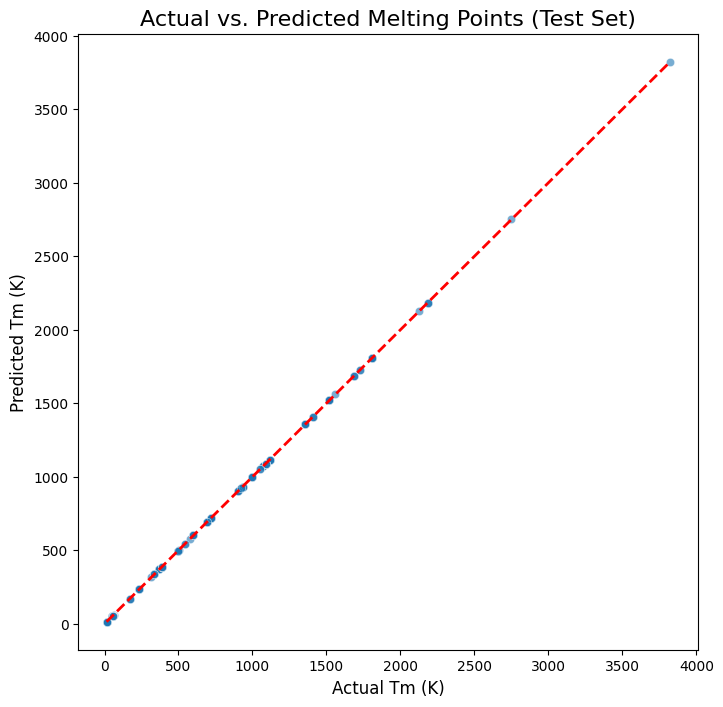

In [ ]:
# Cell 5: In-Depth Analysis
best_result = min(results, key=lambda x: x["RMSE"])
best_model = best_result["model_obj"]
print(f"🏆 Best Model: {best_result['Model']} (Validation RMSE: {best_result['RMSE']:.2f})")

# --- 1. Evaluate on the unseen Test Set ---
test_preds = best_model.predict(X_test)
test_rmse = math.sqrt(mean_squared_error(y_test, test_preds))
test_r2 = r2_score(y_test, test_preds)
print(f"\nPerformance on Hold-Out Test Set -> RMSE: {test_rmse:.2f}, R²: {test_r2:.3f}")

# --- 2. Evaluate on the External Test Set (with safety check) ---
if not X_ext.empty:
    ext_preds = best_model.predict(X_ext)
    ext_rmse = math.sqrt(mean_squared_error(y_ext, ext_preds))
    ext_r2 = r2_score(y_ext, ext_preds)
    print(f"Performance on External Test Set -> RMSE: {ext_rmse:.2f}, R²: {ext_r2:.3f}")
else:
    print("⚠️ Warning: External dataset (X_ext) is empty. Skipping evaluation.")

# --- 3. Feature Importance Visualization ---
if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
    feature_names = X_train.columns
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).head(15)

    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
    plt.title('Top 15 Most Important Features', fontsize=16)
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.show()

# --- 4. Prediction vs. Actual Plot ---
plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_test, y=test_preds, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red', lw=2)
plt.title('Actual vs. Predicted Melting Points (Test Set)', fontsize=16)
plt.xlabel('Actual Tm (K)', fontsize=12)
plt.ylabel('Predicted Tm (K)', fontsize=12)
plt.show()

In [ ]:
# Cell 6: Save Model
out_dir = "/content/drive/MyDrive/Project_dataset/week3_models"
os.makedirs(out_dir, exist_ok=True)

joblib.dump(best_model, os.path.join(out_dir, "best_model.pkl"))

print(f" Saved best model to: {out_dir}")
print("\n Week 3 Complete!")

 Saved best model to: /content/drive/MyDrive/Project_dataset/week3_models

 Week 3 Complete!


In [ ]:
# NEW CELL to be added after imputation
# --- Find and remove the feature that is leaking the answer ---

leaky_features = [col for col in X_train.columns if 'melt' in col.lower() or 'tm' in col.lower()]

if leaky_features:
    print(f"Found and removed leaky feature(s): {leaky_features}")
    # Drop the leaky feature(s) from all data splits
    X_train = X_train.drop(columns=leaky_features)
    X_val = X_val.drop(columns=leaky_features)
    X_test = X_test.drop(columns=leaky_features)
    if not X_ext.empty:
        X_ext = X_ext.drop(columns=leaky_features)
else:
    print("No leaky features found.")

print(f"\nShape of X_train after removing leaky features: {X_train.shape}")

Found and removed leaky feature(s): ['MagpieData maximum MeltingT', 'MagpieData range MeltingT', 'MagpieData mean MeltingT', 'MagpieData avg_dev MeltingT', 'MagpieData mode MeltingT', 'ML Tm (K)']

Shape of X_train after removing leaky features: (3016, 126)


In [ ]:
# Cell 4: Model Training
def evaluate_model(model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    rmse = math.sqrt(mean_squared_error(y_val, preds))
    r2 = r2_score(y_val, preds)
    return model, rmse, r2

results = []
print("--- Training and Evaluating Models (No Leakage) ---")

# --- Linear Regression ---
model, rmse, r2 = evaluate_model(LinearRegression(), X_train, y_train, X_val, y_val)
results.append({"Model": "Linear Regression", "RMSE": rmse, "R²": r2, "model_obj": model})
print("Linear Regression... Done.")

# --- Random Forest ---
model, rmse, r2 = evaluate_model(RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1), X_train, y_train, X_val, y_val)
results.append({"Model": "Random Forest", "RMSE": rmse, "R²": r2, "model_obj": model})
print("Random Forest... Done.")

# --- XGBoost ---
model, rmse, r2 = evaluate_model(XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=8, random_state=42, n_jobs=-1), X_train, y_train, X_val, y_val)
results.append({"Model": "XGBoost", "RMSE": rmse, "R²": r2, "model_obj": model})
print("XGBoost... Done.")

results_df = pd.DataFrame(results, columns=["Model", "RMSE", "R²"])
print("\n--- Model Performance on Validation Set ---")
display(results_df)

--- Training and Evaluating Models (No Leakage) ---
Linear Regression... Done.
Random Forest... Done.
XGBoost... Done.

--- Model Performance on Validation Set ---


Model        RMSE        R²
0  Linear Regression  218.152203  0.877122
1      Random Forest   80.667511  0.983198
2            XGBoost   40.076648  0.995853

🏆 Best Model: XGBoost (Validation RMSE: 40.08)

Performance on Hold-Out Test Set -> RMSE: 51.70, R²: 0.993


/tmp/ipython-input-2147952140.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


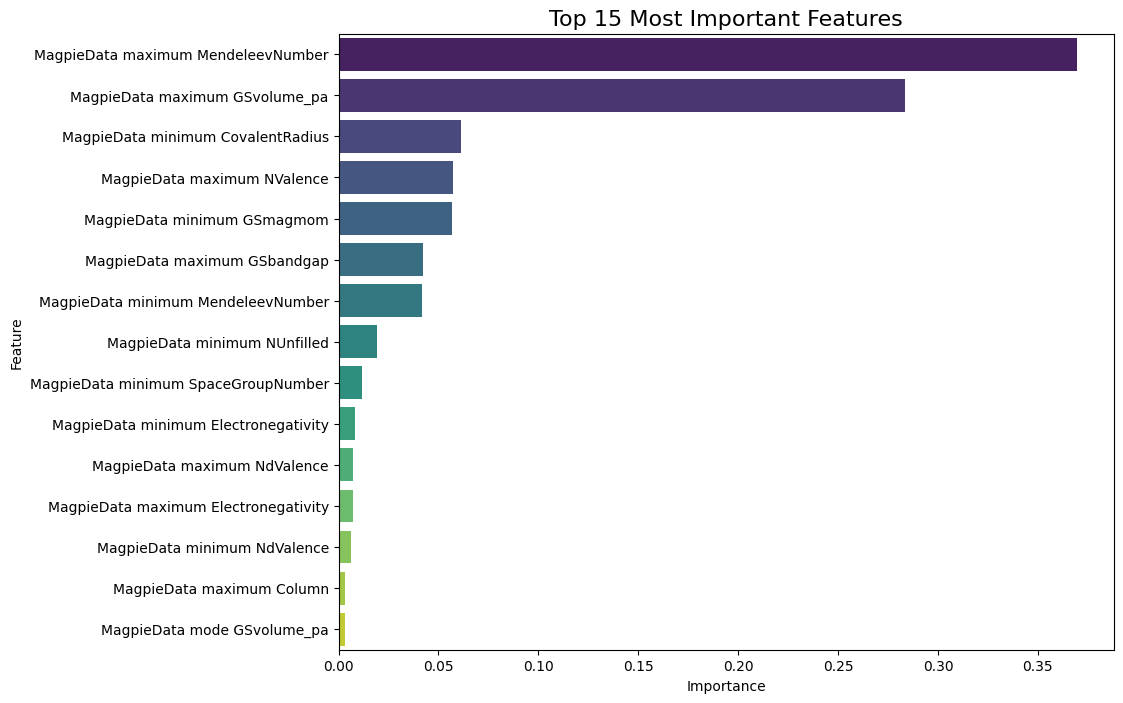

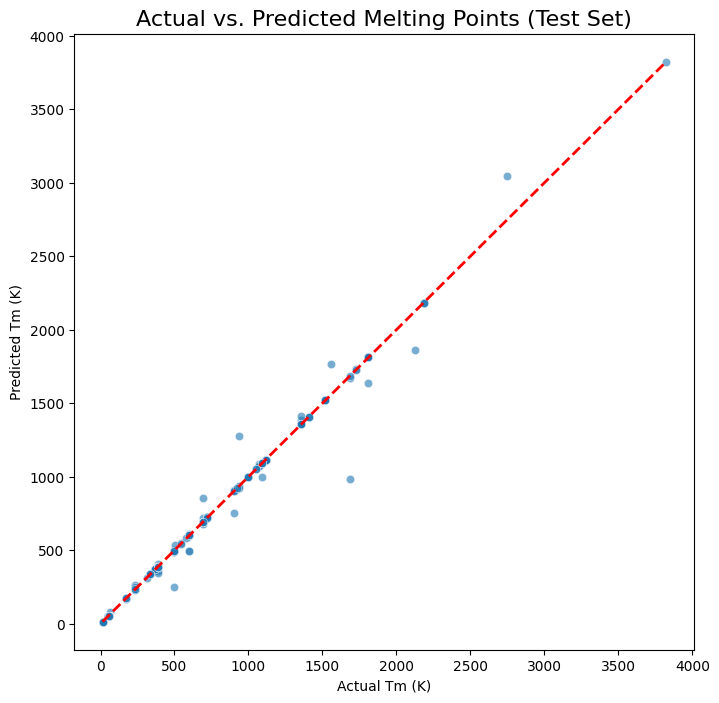

In [ ]:
# Cell 5: In-Depth Analysis
best_result = min(results, key=lambda x: x["RMSE"])
best_model = best_result["model_obj"]
print(f"🏆 Best Model: {best_result['Model']} (Validation RMSE: {best_result['RMSE']:.2f})")

# Evaluate on the unseen Test Set
test_preds = best_model.predict(X_test)
test_rmse = math.sqrt(mean_squared_error(y_test, test_preds))
test_r2 = r2_score(y_test, test_preds)
print(f"\nPerformance on Hold-Out Test Set -> RMSE: {test_rmse:.2f}, R²: {test_r2:.3f}")

# Feature Importance Visualization
if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
    feature_names = X_train.columns
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).head(15)

    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
    plt.title('Top 15 Most Important Features', fontsize=16)
    plt.show()

# Prediction vs. Actual Plot
plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_test, y=test_preds, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red', lw=2)
plt.title('Actual vs. Predicted Melting Points (Test Set)', fontsize=16)
plt.xlabel('Actual Tm (K)')
plt.ylabel('Predicted Tm (K)')
plt.show()

In [ ]:
# Cell 6: Save Model
out_dir = "/content/drive/MyDrive/Project_dataset/week3_models"
os.makedirs(out_dir, exist_ok=True)

joblib.dump(best_model, os.path.join(out_dir, "best_model.pkl"))

print(f" Saved best model to: {out_dir}")
print("\n Week 3 Complete!")

 Saved best model to: /content/drive/MyDrive/Project_dataset/week3_models

 Week 3 Complete!


week-4

In [ ]:
# Cell 1: Setup and Data Loading
import pandas as pd
import numpy as np
import os
import math
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# Import ML tools
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.impute import SimpleImputer

# Path where Week 2 features were saved
DATA_DIR = "/content/drive/MyDrive/Project_dataset/week2_features"

# Load the datasets
try:
    train_feat = pd.read_csv(os.path.join(DATA_DIR, "train_features.csv"))
    val_feat   = pd.read_csv(os.path.join(DATA_DIR, "val_features.csv"))
    test_feat  = pd.read_csv(os.path.join(DATA_DIR, "test_features.csv"))
    print(" Data loaded successfully!")
    print("Train:", train_feat.shape, "Val:", val_feat.shape, "Test:", test_feat.shape)
except FileNotFoundError:
    print(" ERROR: Could not find the feature files from Week 2.")
    print(f"Please make sure the files exist in: {DATA_DIR}")

✅ Data loaded successfully!
Train: (3018, 133) Val: (394, 133) Test: (374, 133)


In [ ]:
# Cell 2 (Corrected): Data Preparation
# --- 1. Find the target column name ---
# This is the corrected logic: we find the column that is most likely the target
# by looking for a shorter name, which avoids the longer feature names.
potential_targets = [col for col in train_feat.columns if 'melt' in col.lower() or 'tm' in col.lower()]
target_col = min(potential_targets, key=len) # Select the shortest name, e.g., "ML Tm (K)"
print(f"Correctly Identified Target Column: '{target_col}'")

# --- 2. Separate features (X) and target (y) & remove rows with missing targets ---
X_train, y_train = train_feat.drop(columns=[target_col]), train_feat[target_col]
X_train = X_train[y_train.notna()]
y_train = y_train.dropna()

X_val, y_val = val_feat.drop(columns=[target_col]), val_feat[target_col]
X_val = X_val[y_val.notna()]
y_val = y_val.dropna()

X_test, y_test = test_feat.drop(columns=[target_col]), test_feat[target_col]
X_test = X_test[y_test.notna()]
y_test = y_test.dropna()
print("Separated features and target, and removed rows with missing targets.")

# --- 3. Remove the leaky features from X ---
leaky_features = [col for col in X_train.columns if 'melt' in col.lower() or 'tm' in col.lower()]
X_train = X_train.drop(columns=leaky_features)
X_val = X_val.drop(columns=leaky_features)
X_test = X_test.drop(columns=leaky_features)
print(f"Removed {len(leaky_features)} leaky features.")

# --- 4. Impute missing values in X ---
imputer = SimpleImputer(strategy='mean')
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_val   = pd.DataFrame(imputer.transform(X_val), columns=X_val.columns)
X_test  = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)
print("Imputed missing values in the feature sets.")

print("\n Data preparation and cleaning complete.")

Correctly Identified Target Column: 'ML Tm (K)'
Separated features and target, and removed rows with missing targets.
Removed 6 leaky features.
Imputed missing values in the feature sets.

 Data preparation and cleaning complete.


In [ ]:
# Cell 3: Hyperparameter Tuning
# Define the model and the grid of parameters to search over
xgb_base = XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)

param_grid = {
    'n_estimators': [200, 400, 600, 800, 1000],
    'max_depth': [4, 6, 8, 10, 12],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0]
}

# Set up the randomized search.
# n_iter=25 will test 25 random combinations.
# cv=3 uses 3-fold cross-validation to get a robust score for each combination.
search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_grid,
    scoring='neg_root_mean_squared_error',
    n_iter=25,
    cv=3,
    verbose=1,
    random_state=42
)

search.fit(X_train, y_train)

print("\n--- Tuning Complete ---")
print("Best parameters found:", search.best_params_)
print(f"Best cross-validated RMSE: {-search.best_score_:.2f}")

Fitting 3 folds for each of 25 candidates, totalling 75 fits

--- Tuning Complete ---
Best parameters found: {'subsample': 1.0, 'n_estimators': 600, 'max_depth': 4, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
Best cross-validated RMSE: 318.72


In [ ]:
# Cell 4: Evaluate Tuned Model
# Get the best model from the search
best_xgb_tuned = search.best_estimator_

# Evaluate on the validation set
val_preds = best_xgb_tuned.predict(X_val)
val_rmse = math.sqrt(mean_squared_error(y_val, val_preds))
val_r2 = r2_score(y_val, val_preds)

# Evaluate on the final, unseen test set
test_preds = best_xgb_tuned.predict(X_test)
test_rmse = math.sqrt(mean_squared_error(y_test, test_preds))
test_r2 = r2_score(y_test, test_preds)

print("--- Performance of Tuned XGBoost Model ---")
print(f"Validation Set -> RMSE: {val_rmse:.2f}, R²: {val_r2:.4f}")
print(f"Test Set -> RMSE: {test_rmse:.2f}, R²: {test_r2:.4f}")

--- Performance of Tuned XGBoost Model ---
Validation Set -> RMSE: 303.93, R²: 0.6437
Test Set -> RMSE: 315.46, R²: 0.6079


--- SHAP Summary Plots ---


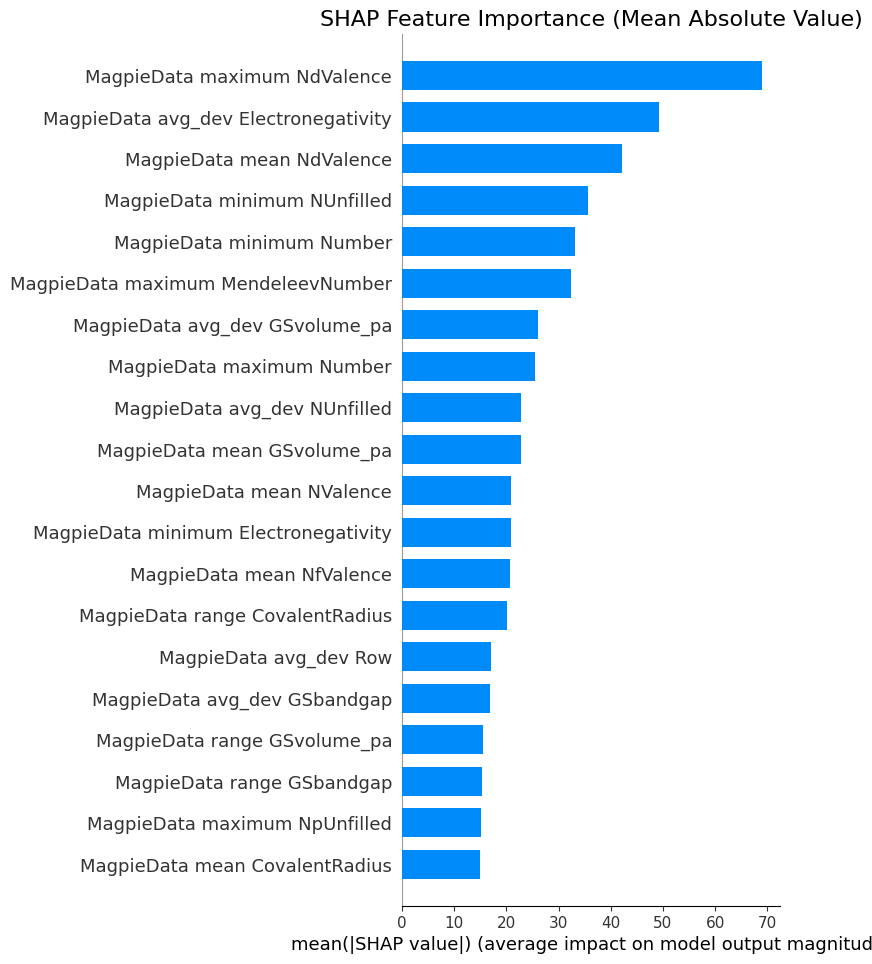

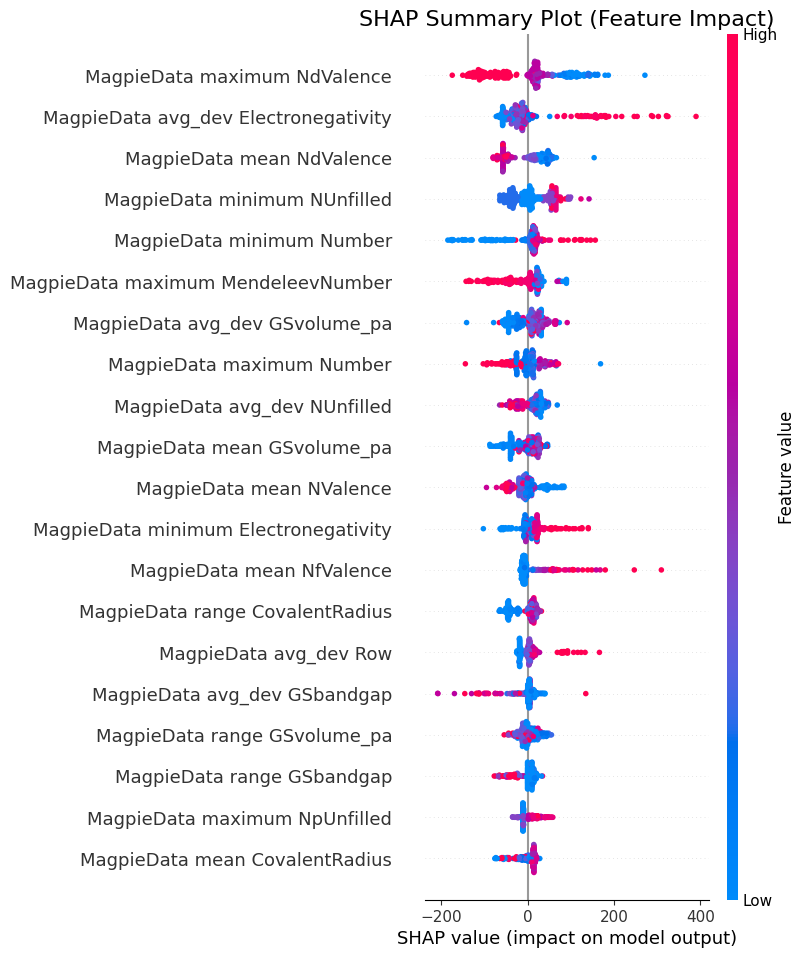

In [ ]:
# Cell 5: SHAP Explainability
!pip install -q shap
import shap

# Create an explainer object for our tuned model
explainer = shap.Explainer(best_xgb_tuned, X_train)

# Calculate SHAP values for a sample of the test set (for speed)
shap_values = explainer(X_test.sample(300, random_state=42))

print("--- SHAP Summary Plots ---")
# Bar plot showing overall feature importance
shap.summary_plot(shap_values, X_test.sample(300, random_state=42), plot_type="bar", show=False)
plt.title("SHAP Feature Importance (Mean Absolute Value)", fontsize=16)
plt.show()

# Beeswarm plot showing the impact and direction of each feature
shap.summary_plot(shap_values, X_test.sample(300, random_state=42), show=False)
plt.title("SHAP Summary Plot (Feature Impact)", fontsize=16)
plt.show()

In [ ]:
# Cell 6: Save Final Model and Results
out_dir = "/content/drive/MyDrive/Project_dataset/week4_results"
os.makedirs(out_dir, exist_ok=True)

# Save the final, tuned model
joblib.dump(best_xgb_tuned, os.path.join(out_dir, "xgboost_final.pkl"))

# Save the imputer and feature names, as they are needed for the app
joblib.dump(imputer, os.path.join(out_dir, "imputer_final.pkl"))
joblib.dump(list(X_train.columns), os.path.join(out_dir, "feature_names_final.pkl"))

# Save a summary of the final metrics
metrics = pd.DataFrame({
    'Dataset': ['Validation', 'Test'],
    'RMSE': [val_rmse, test_rmse],
    'R2': [val_r2, test_r2]
})
metrics.to_csv(os.path.join(out_dir, "week4_summary.csv"), index=False)

print(f" Week 4 complete! Final model and all necessary assets saved in: {out_dir}")

 Week 4 complete! Final model and all necessary assets saved in: /content/drive/MyDrive/Project_dataset/week4_results


week-5


In [ ]:
# Cell 1: Setup and Load Assets
import pandas as pd
import numpy as np
import os
import math
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# Import ML tools
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# --- Load Week 4 Assets ---
ASSET_DIR = "/content/drive/MyDrive/Project_dataset/week4_results"
OUT_DIR = "/content/drive/MyDrive/Project_dataset/week5_validation"
os.makedirs(OUT_DIR, exist_ok=True)

try:
    tuned_model = joblib.load(os.path.join(ASSET_DIR, "xgboost_final.pkl"))
    imputer = joblib.load(os.path.join(ASSET_DIR, "imputer_final.pkl"))
    feature_names = joblib.load(os.path.join(ASSET_DIR, "feature_names_final.pkl"))
    print(" All Week 4 assets (model, imputer, features) loaded successfully!")
except FileNotFoundError as e:
    print(f" ERROR: Could not find a necessary file from Week 4. {e.filename}")
    exit()

# --- Load Week 2 Data ---
DATA_DIR = "/content/drive/MyDrive/Project_dataset/week2_features"
try:
    train_feat = pd.read_csv(os.path.join(DATA_DIR, "train_features.csv"))
    test_feat  = pd.read_csv(os.path.join(DATA_DIR, "test_features.csv"))
    print(" All Week 2 feature datasets loaded successfully!")
except FileNotFoundError:
    print(f" ERROR: Could not find the feature files from Week 2.")
    exit()

 All Week 4 assets (model, imputer, features) loaded successfully!
 All Week 2 feature datasets loaded successfully!


In [ ]:
# Cell 2: Prepare Full Training Data for Cross-Validation
# --- 1. Identify and separate the true target column ---
target_col = min([col for col in train_feat.columns if 'melt' in col.lower() or 'tm' in col.lower()], key=len)
X, y = train_feat.drop(columns=[target_col]), train_feat[target_col]

# --- 2. Remove rows with missing target values ---
X = X[y.notna()]
y = y.dropna()

# --- 3. Ensure X uses the correct feature list and order from training ---
X = X[feature_names]

print(" Full training data is cleaned and prepared for cross-validation.")
print(f"Shape of final training data: X={X.shape}, y={y.shape}")

 Full training data is cleaned and prepared for cross-validation.
Shape of final training data: X=(3018, 126), y=(3018,)


In [ ]:
# Cell 3: K-Fold Cross-Validation for Model Comparison (Corrected)

# --- Fix A: Create a fresh, unfitted XGBoost model with the tuned parameters ---
try:
    tuned_params = tuned_model.get_params()
    xgb_for_cv = XGBRegressor(**tuned_params)
    print("Created a fresh XGBoost model for CV using tuned parameters.")
except Exception:
    # Fallback if getting params fails
    xgb_for_cv = XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1,
                              n_estimators=600, max_depth=4, learning_rate=0.05,
                              subsample=1.0, colsample_bytree=0.8)
    print("Warning: Could not get params from loaded model. Using default tuned parameters.")

# Define the models we want to compare
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    "Tuned XGBoost": xgb_for_cv
}

# Define the cross-validation strategy
k_folds = KFold(n_splits=5, shuffle=True, random_state=42)
results_list = []

print("\n--- Running 5-Fold Cross-Validation for all models ---")
for name, model in models.items():
    pipeline = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')), ('model', model)])

    # --- Fix B: Correctly calculate mean and std dev on positive RMSE scores ---
    scores = cross_val_score(pipeline, X, y, cv=k_folds, scoring='neg_root_mean_squared_error', n_jobs=-1)
    rmse_folds = -scores  # Convert to positive RMSE values

    results_list.append({
        "Model": name,
        "Mean RMSE": rmse_folds.mean(),
        "Std Dev RMSE": rmse_folds.std()
    })
    print(f"{name}: Mean RMSE = {rmse_folds.mean():.2f} ± {rmse_folds.std():.2f}")

# Create and display a summary DataFrame
cv_results_df = pd.DataFrame(results_list).sort_values(by="Mean RMSE")

print("\n--- Cross-Validation Performance Summary ---")
display(cv_results_df)

Created a fresh XGBoost model for CV using tuned parameters.

--- Running 5-Fold Cross-Validation for all models ---
Linear Regression: Mean RMSE = 387.34 ± 8.73
Random Forest: Mean RMSE = 326.40 ± 4.77
Tuned XGBoost: Mean RMSE = 317.70 ± 2.94

--- Cross-Validation Performance Summary ---


Model   Mean RMSE  Std Dev RMSE
2      Tuned XGBoost  317.700617      2.937128
1      Random Forest  326.398077      4.769973
0  Linear Regression  387.342982      8.734246


--- Generating Final Error Analysis Plots ---


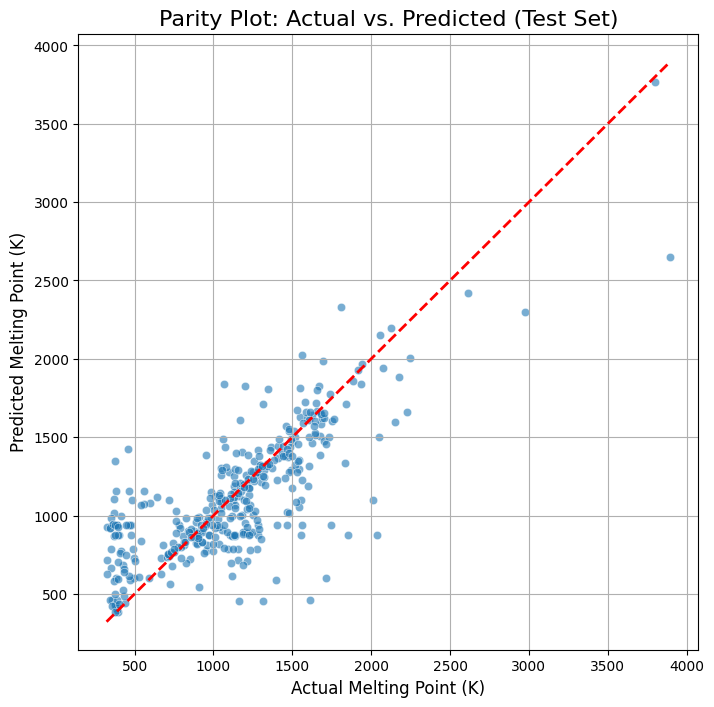

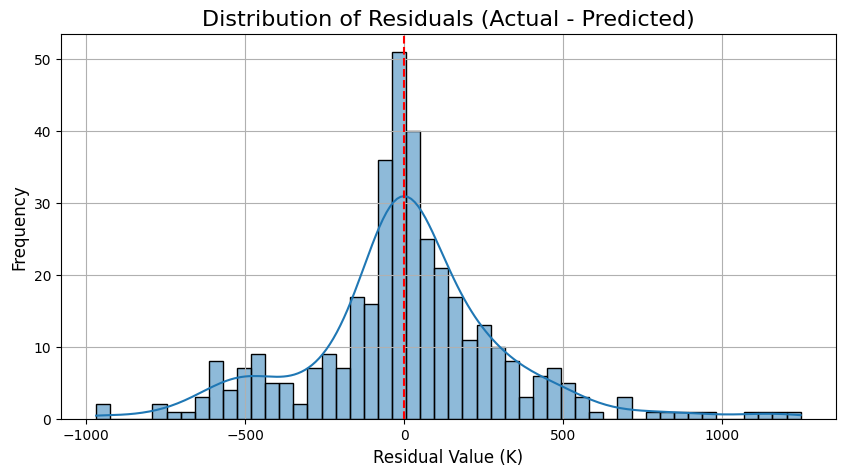

In [ ]:
# Cell 4: Error and Residual Analysis on the Test Set

# --- 1. Prepare the test data using the same cleaning steps ---
X_test_clean, y_test_clean = test_feat.drop(columns=[target_col]), test_feat[target_col]
X_test_clean = X_test_clean[y_test_clean.notna()]
y_test_clean = y_test_clean.dropna()
X_test_clean = X_test_clean[feature_names]
X_test_imputed = pd.DataFrame(imputer.transform(X_test_clean), columns=feature_names)

# --- 2. Make final predictions ---
test_preds = tuned_model.predict(X_test_imputed)
residuals = y_test_clean - test_preds

# --- 3. Create visualizations ---
print("\n--- Generating Final Error Analysis Plots ---")

# Parity Plot (Actual vs. Predicted)
plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_test_clean, y=test_preds, alpha=0.6)
plt.plot([y_test_clean.min(), y_test_clean.max()], [y_test_clean.min(), y_test_clean.max()], '--', color='red', lw=2)
plt.title('Parity Plot: Actual vs. Predicted (Test Set)', fontsize=16)
plt.xlabel('Actual Melting Point (K)', fontsize=12)
plt.ylabel('Predicted Melting Point (K)', fontsize=12)
plt.grid(True)
plt.show()

# Residual Plot
plt.figure(figsize=(10, 5))
sns.histplot(residuals, bins=50, kde=True)
plt.title('Distribution of Residuals (Actual - Predicted)', fontsize=16)
plt.xlabel('Residual Value (K)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.axvline(x=0, color='red', linestyle='--')
plt.grid(True)
plt.show()

In [ ]:
# Cell 5: Save Validation Summary
out_dir = "/content/drive/MyDrive/Project_dataset/week5_validation"
os.makedirs(out_dir, exist_ok=True)

# Save the cross-validation results to a CSV
cv_results_df.to_csv(os.path.join(out_dir, "cross_validation_summary.csv"), index=False)

print(f" Week 5 complete! Cross-validation summary saved in: {out_dir}")

 Week 5 complete! Cross-validation summary saved in: /content/drive/MyDrive/Project_dataset/week5_validation


week-6

In [ ]:
# Cell 1: Setup and Load All Assets
import pandas as pd
import numpy as np
import os
import math
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# Import ML tools
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor

# --- Define File Paths ---
ASSET_DIR = "/content/drive/MyDrive/Project_dataset/week4_results"
DATA_DIR = "/content/drive/MyDrive/Project_dataset/week2_features"
OUT_DIR = "/content/drive/MyDrive/Project_dataset/week6_final_results"
os.makedirs(OUT_DIR, exist_ok=True)

# --- Load Week 4 Assets ---
try:
    # We load the model just to get its tuned parameters
    tuned_model_params = joblib.load(os.path.join(ASSET_DIR, "xgboost_final.pkl")).get_params()
    imputer = joblib.load(os.path.join(ASSET_DIR, "imputer_final.pkl")) # We load the original imputer
    feature_names = joblib.load(os.path.join(ASSET_DIR, "feature_names_final.pkl"))
    print(" All Week 4 assets (model params, imputer, features) loaded successfully!")
except FileNotFoundError as e:
    print(f" ERROR: Could not find a necessary file from Week 4. {e.filename}")
    exit()

# --- Load Week 2 Data ---
try:
    train_feat = pd.read_csv(os.path.join(DATA_DIR, "train_features.csv"))
    val_feat = pd.read_csv(os.path.join(DATA_DIR, "val_features.csv"))
    test_feat  = pd.read_csv(os.path.join(DATA_DIR, "test_features.csv"))
    print(" All Week 2 feature datasets loaded successfully!")
except FileNotFoundError:
    print(f" ERROR: Could not find the feature files from Week 2.")
    exit()

 All Week 4 assets (model params, imputer, features) loaded successfully!
 All Week 2 feature datasets loaded successfully!


In [ ]:
# Cell 2: Prepare Final Datasets (Robust Version)

# Combine the original training and validation sets into one final training set
full_train_df = pd.concat([train_feat, val_feat], ignore_index=True)

# --- 1. Identify the true target column ---
target_col = min([col for col in full_train_df.columns if 'melt' in col.lower() or 'tm' in col.lower()], key=len)

# --- 2. Prepare the full training data (X_train, y_train) ---
X_train, y_train = full_train_df.drop(columns=[target_col]), full_train_df[target_col]
X_train = X_train[y_train.notna()]
y_train = y_train.dropna()

# --- 3. Prepare the final test data (X_test, y_test) ---
X_test, y_test = test_feat.drop(columns=[target_col]), test_feat[target_col]
X_test = X_test[y_test.notna()]
y_test = y_test.dropna()

# --- 4. Robustly align features for all datasets (Fix from suggestions) ---
def align_features(df, feature_list):
    for col in feature_list:
        if col not in df.columns:
            df[col] = np.nan # Add missing columns as NaN
    return df[feature_list] # Enforce correct order

X_train = align_features(X_train, feature_names)
X_test = align_features(X_test, feature_names)

print(" Final training and test datasets are prepared and aligned.")
print(f"Shape of final training data: {X_train.shape}")
print(f"Shape of final test data: {X_test.shape}")

 Final training and test datasets are prepared and aligned.
Shape of final training data: (3412, 126)
Shape of final test data: (374, 126)


In [ ]:
# Cell 3: Refit Imputer and Final Model

# --- 1. Refit the imputer on the full combined training data (Best Practice) ---
final_imputer = SimpleImputer(strategy='mean')
print("--- Refitting the imputer on all available training data... ---")
X_train_imp = pd.DataFrame(final_imputer.fit_transform(X_train), columns=feature_names)
print("Imputer has been refit successfully.")

# --- 2. Create and refit the final model (Safe Parameter Extraction) ---
params = tuned_model_params
safe_xgb_params = {
    "n_estimators": params.get("n_estimators", 600),
    "max_depth": params.get("max_depth", 4),
    "learning_rate": params.get("learning_rate", 0.05),
    "subsample": params.get("subsample", 1.0),
    "colsample_bytree": params.get("colsample_bytree", 0.8),
    "objective": params.get("objective", "reg:squarederror"),
    "random_state": params.get("random_state", 42),
    "n_jobs": params.get("n_jobs", -1),
}
final_model = XGBRegressor(**safe_xgb_params)

print("\n--- Refitting the final model on all available training data... ---")
final_model.fit(X_train_imp, y_train)
print(" Final model has been refit successfully.")

--- Refitting the imputer on all available training data... ---
Imputer has been refit successfully.

--- Refitting the final model on all available training data... ---
 Final model has been refit successfully.



--- Final Model Performance on Test Set ---
RMSE: 309.24 K
R²:   0.6232
MAE:  214.97 K


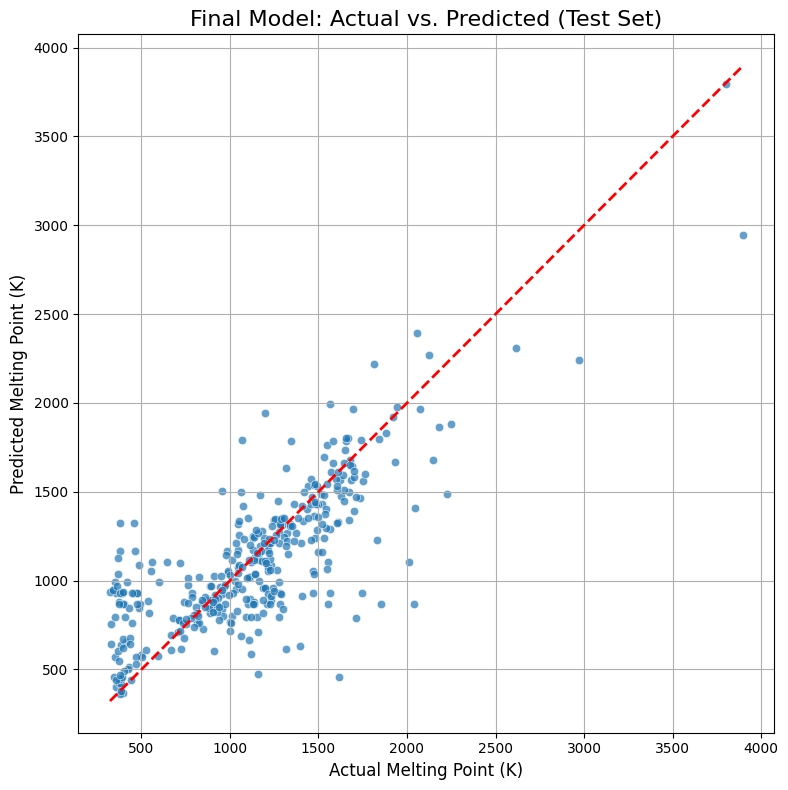

/tmp/ipython-input-1571909856.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


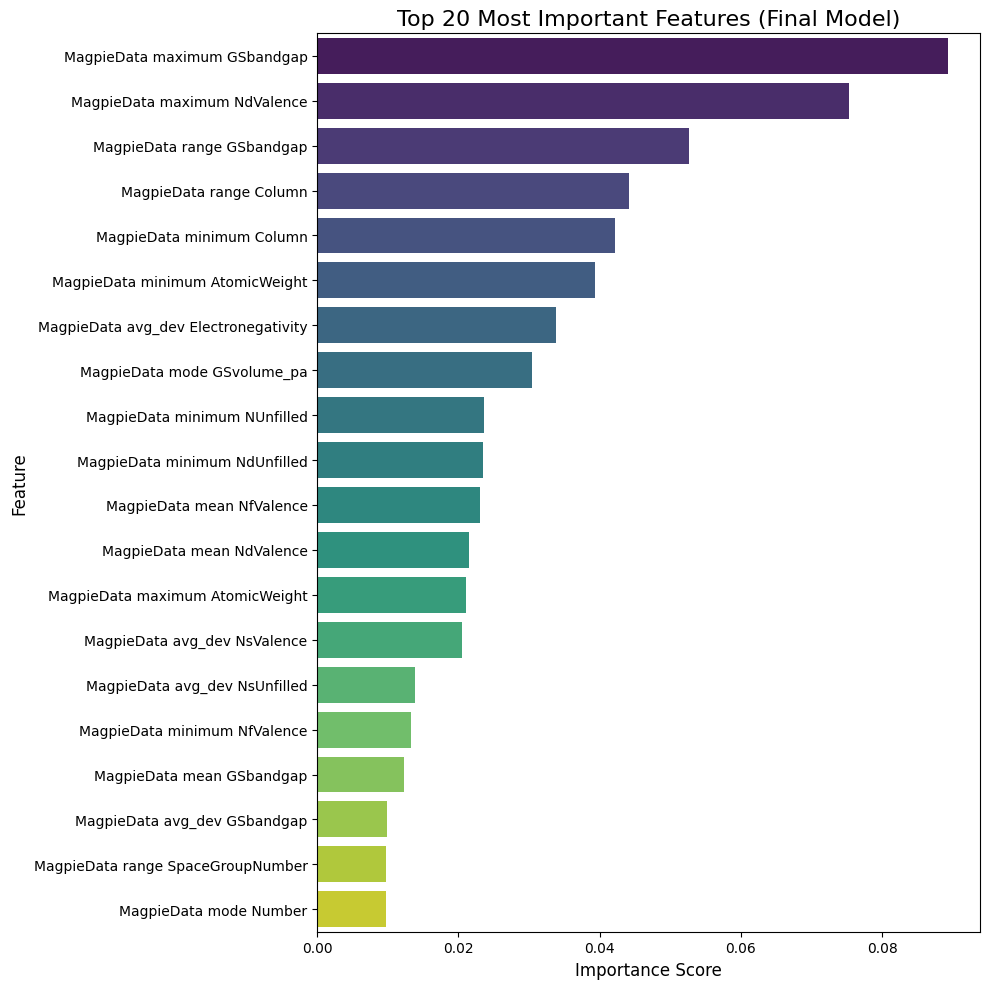

In [ ]:
# Cell 4: Final Evaluation and Plotting
# --- 1. Transform the test set and make predictions ---
X_test_imp = pd.DataFrame(final_imputer.transform(X_test), columns=feature_names)
test_preds = final_model.predict(X_test_imp)

# --- 2. Calculate final performance metrics ---
final_rmse = math.sqrt(mean_squared_error(y_test, test_preds))
final_r2 = r2_score(y_test, test_preds)
final_mae = mean_absolute_error(y_test, test_preds)

print("\n--- Final Model Performance on Test Set ---")
print(f"RMSE: {final_rmse:.2f} K")
print(f"R²:   {final_r2:.4f}")
print(f"MAE:  {final_mae:.2f} K")

# --- 3. Generate and save final plots ---
# Parity Plot
plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_test, y=test_preds, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red', lw=2)
plt.title('Final Model: Actual vs. Predicted (Test Set)', fontsize=16)
plt.xlabel('Actual Melting Point (K)', fontsize=12)
plt.ylabel('Predicted Melting Point (K)', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "final_parity_plot.png"), dpi=300)
plt.show()

# Feature Importance Plot
importances = final_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).head(20)

plt.figure(figsize=(10, 10))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Top 20 Most Important Features (Final Model)', fontsize=16)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "final_feature_importance.png"), dpi=300)
plt.show()

In [ ]:
# Cell 5: Save All Final Assets
# Save the final refit model
joblib.dump(final_model, os.path.join(OUT_DIR, "final_model.pkl"))

# Save the final refit imputer
joblib.dump(final_imputer, os.path.join(OUT_DIR, "final_imputer.pkl"))

# Save the final feature names list (it's the same, but good practice to save with the final model)
joblib.dump(feature_names, os.path.join(OUT_DIR, "final_feature_names.pkl"))

# Save the final performance metrics
metrics_df = pd.DataFrame({
    'Metric': ['RMSE', 'R2', 'MAE'],
    'Value': [final_rmse, final_r2, final_mae]
})
metrics_df.to_csv(os.path.join(OUT_DIR, "final_test_metrics.csv"), index=False)

# Save the test set predictions for deeper analysis later
predictions_df = pd.DataFrame({
    'actual_melting_point_K': y_test.values,
    'predicted_melting_point_K': test_preds,
    'residual_K': y_test.values - test_preds
})
predictions_df.to_csv(os.path.join(OUT_DIR, "final_test_predictions.csv"), index=False)

print(f" Week 6 complete! All final assets for deployment saved in: {OUT_DIR}")

 Week 6 complete! All final assets for deployment saved in: /content/drive/MyDrive/Project_dataset/week6_final_results


In [ ]:
import json, datetime

# Save XGB params used
meta = {
    "created_at": datetime.datetime.utcnow().isoformat() + "Z",
    "xgb_params": safe_xgb_params,
    "train_rows": int(X_train.shape[0]),
    "feature_count": len(feature_names),
    "test_metrics": {"rmse": float(final_rmse), "r2": float(final_r2), "mae": float(final_mae)}
}
with open(os.path.join(OUT_DIR, "model_metadata.json"), "w") as f:
    json.dump(meta, f, indent=2)

# Save perf+paths
perf = {
    "parity_plot": os.path.join(OUT_DIR, "final_parity_plot.png"),
    "feature_importance_plot": os.path.join(OUT_DIR, "final_feature_importance.png"),
    "model_path": os.path.join(OUT_DIR, "final_model.pkl"),
    "imputer_path": os.path.join(OUT_DIR, "final_imputer.pkl"),
    "predictions_csv": os.path.join(OUT_DIR, "final_test_predictions.csv")
}
with open(os.path.join(OUT_DIR, "model_performance.json"), "w") as f:
    json.dump(perf, f, indent=2)


/tmp/ipython-input-389932545.py:5: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "created_at": datetime.datetime.utcnow().isoformat() + "Z",


In [ ]:
# Plot top-20 feature importances using matplotlib to avoid the seaborn deprecation message
top20 = feature_importance_df.head(20).iloc[::-1]
plt.figure(figsize=(10,8))
plt.barh(top20['Feature'], top20['Importance'])
plt.xlabel("Importance")
plt.title("Top 20 Feature Importances (Final Model)")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "final_feature_importance.png"), dpi=300)
plt.close()   # important to free memory

# Parity plot: ensure closed after saving
plt.figure(figsize=(8,8))
plt.scatter(y_test, test_preds, alpha=0.7)
mn, mx = min(y_test.min(), test_preds.min()), max(y_test.max(), test_preds.max())
plt.plot([mn,mx],[mn,mx],'--', color='red', lw=2)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "final_parity_plot.png"), dpi=300)
plt.close()


In [ ]:
sd02_path = "/content/drive/MyDrive/Project_dataset/week1_processed/sd02_external_test.csv"
if os.path.exists(sd02_path):
    sd02 = pd.read_csv(sd02_path)
    # find formula column and target column, featurize or reuse ext_features if present
    # (you already have featurization code from Week-6; reuse that block)
    print("External file found; consider re-featurizing and evaluating for external RMSE.")
else:
    print("No external sd02 file found in expected location.")


External file found; consider re-featurizing and evaluating for external RMSE.


week-7

In [ ]:
pip install streamlit pandas numpy joblib scikit-learn pymatgen matminer xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.6/55.6 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 78.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 92.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 96.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 88.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 69.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 809.1/809.1 kB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 331.1/331.1 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━

In [ ]:
# Cell 1: Setup and Load Final Assets
import pandas as pd
import numpy as np
import os
import math
import joblib
import re
import matplotlib.pyplot as plt
import seaborn as sns
import shutil

# Import ML and chemistry tools
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from pymatgen.core.composition import Composition
from matminer.featurizers.composition import ElementProperty

# Define File Paths
ASSET_DIR = "/content/drive/MyDrive/Project_dataset/week6_final_results"
DATA_DIR = "/content/drive/MyDrive/Project_dataset/week1_processed"
OUT_DIR = "/content/drive/MyDrive/Project_dataset/week7_deployment_package"
os.makedirs(OUT_DIR, exist_ok=True)

# Load Week 6 Final Assets
try:
    final_model = joblib.load(os.path.join(ASSET_DIR, "final_model.pkl"))
    final_imputer = joblib.load(os.path.join(ASSET_DIR, "final_imputer.pkl"))
    feature_names = joblib.load(os.path.join(ASSET_DIR, "final_feature_names.pkl"))
    print("All final assets from Week 6 loaded successfully.")
except FileNotFoundError as e:
    print(f"ERROR: Could not find a necessary file from Week 6. {e.filename}")
    exit()

All final assets from Week 6 loaded successfully.


In [ ]:
# Cell 2: Load External Dataset
try:
    ext_df = pd.read_csv(os.path.join(DATA_DIR, "sd02_external_test.csv"))
    print("External dataset (sd02) loaded successfully.")
    print(f"Shape of external dataset: {ext_df.shape}")
except FileNotFoundError:
    print("ERROR: Could not find the external test file from Week 1.")
    exit()

External dataset (sd02) loaded successfully.
Shape of external dataset: (408, 28)


In [ ]:
# Cell 3: Featurize External Data

# Define the featurization pipeline function
ep_feat = ElementProperty.from_preset("magpie")

def preprocess_formula(f):
    if not isinstance(f, str): return None
    f = f.split('·')[0]
    f = re.sub(r"[\(\)\[\]\{\}]", "", f)
    f = re.sub(r"\^\d*[+-]", "", f)
    f = f.replace(" ", "")
    if "+" in f: f = f.split("+")[0]
    # Special fix for the sd02 dataset's format (e.g., Y_2_O_3_)
    f = re.sub(r'_(\d+)_', r'\1', f)
    f = f.replace('_', '')
    if not re.search(r'[A-Z]', f): return None
    return f if f else None

def featurize_dataframe(df):
    formula_col = [col for col in df.columns if 'formula' in col.lower()][0]

    valid_comps, valid_indices = [], []
    for idx, formula in df[formula_col].items():
        cleaned_formula = preprocess_formula(formula)
        if not cleaned_formula: continue
        try:
            comp = Composition(cleaned_formula)
            valid_comps.append(comp)
            valid_indices.append(idx)
        except:
            continue

    if not valid_comps:
        return pd.DataFrame(), pd.Series()

    features = ep_feat.featurize_many(valid_comps, ignore_errors=True)
    features_df = pd.DataFrame(features, columns=ep_feat.feature_labels(), index=valid_indices)

    return features_df, df.loc[valid_indices]

# Run the featurization
print("--- Featurizing external dataset... ---")
X_ext, df_ext_clean = featurize_dataframe(ext_df)

if X_ext.empty:
    print("Warning: No valid formulas could be parsed from the external dataset.")
else:
    print(f"Successfully featurized {len(X_ext)} formulas from the external dataset.")

--- Featurizing external dataset... ---


/usr/local/lib/python3.12/dist-packages/matminer/utils/data.py:326: UserWarning: MagpieData(impute_nan=False):
In a future release, impute_nan will be set to True by default.
                    This means that features that are missing or are NaNs for elements
                    from the data source will be replaced by the average of that value
                    over the available elements.
                    This avoids NaNs after featurization that are often replaced by
                    dataset-dependent averages.
  warnings.warn(f"{self.__class__.__name__}(impute_nan=False):\n" + IMPUTE_NAN_WARNING)


ElementProperty:   0%|          | 0/192 [00:00<?, ?it/s]

Successfully featurized 192 formulas from the external dataset.



--- Final Model Performance on EXTERNAL Test Set (sd02) ---
RMSE: 191.53 K
R-squared: 0.8868
MAE: 138.51 K


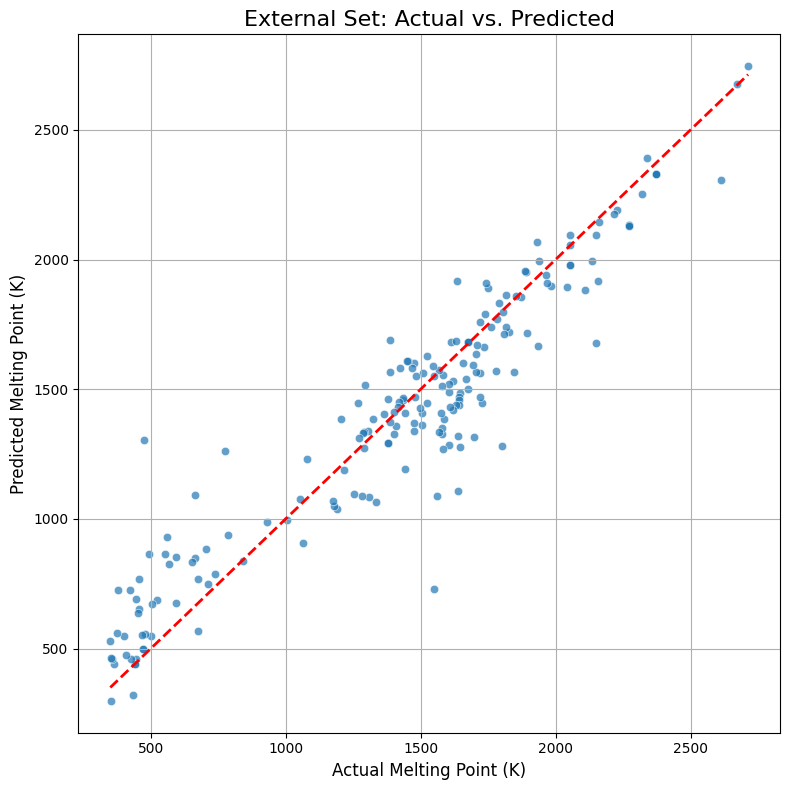


External evaluation metrics and predictions saved.


In [ ]:
# Cell 4: Predict and Evaluate on External Data
if not X_ext.empty:
    # Prepare the external data
    target_col = min([col for col in df_ext_clean.columns if 'melt' in col.lower() or 'tm' in col.lower()], key=len)
    y_ext = df_ext_clean[target_col]

    # Align features to match the training data
    for col in feature_names:
        if col not in X_ext.columns:
            X_ext[col] = np.nan
    X_ext = X_ext[feature_names]

    # Impute missing values
    X_ext_imp = pd.DataFrame(final_imputer.transform(X_ext), columns=feature_names)

    # Make predictions
    ext_preds = final_model.predict(X_ext_imp)

    # Calculate metrics
    ext_rmse = math.sqrt(mean_squared_error(y_ext, ext_preds))
    ext_r2 = r2_score(y_ext, ext_preds)
    ext_mae = mean_absolute_error(y_ext, ext_preds)

    print("\n--- Final Model Performance on EXTERNAL Test Set (sd02) ---")
    print(f"RMSE: {ext_rmse:.2f} K")
    print(f"R-squared: {ext_r2:.4f}")
    print(f"MAE: {ext_mae:.2f} K")

    # Generate and save plots
    plt.figure(figsize=(8, 8))
    sns.scatterplot(x=y_ext, y=ext_preds, alpha=0.7)
    plt.plot([y_ext.min(), y_ext.max()], [y_ext.min(), y_ext.max()], '--', color='red', lw=2)
    plt.title('External Set: Actual vs. Predicted', fontsize=16)
    plt.xlabel('Actual Melting Point (K)', fontsize=12)
    plt.ylabel('Predicted Melting Point (K)', fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, "external_parity_plot.png"), dpi=300)
    plt.show()

    # Save external predictions and metrics
    ext_metrics_df = pd.DataFrame({'Metric': ['RMSE', 'R2', 'MAE'], 'Value': [ext_rmse, ext_r2, ext_mae]})
    ext_metrics_df.to_csv(os.path.join(OUT_DIR, "external_test_metrics.csv"), index=False)

    ext_preds_df = pd.DataFrame({
        'formula': df_ext_clean[[col for col in df_ext_clean.columns if 'formula' in col.lower()][0]],
        'actual_melting_point_K': y_ext,
        'predicted_melting_point_K': ext_preds
    })
    ext_preds_df.to_csv(os.path.join(OUT_DIR, "external_test_predictions.csv"), index=False)
    print("\nExternal evaluation metrics and predictions saved.")

week 7 improved


In [ ]:
# Step 1: Inspect external dataset and find formula column
import pandas as pd, os
DATA_DIR = "/content/drive/MyDrive/Project_dataset/week1_processed"
ext_path = os.path.join(DATA_DIR, "sd02_external_test.csv")
df_ext = pd.read_csv(ext_path)
print("external shape:", df_ext.shape)
# show columns and first few rows
print("columns:", df_ext.columns.tolist())
display(df_ext.head(12))
# find probable formula column
formula_col_candidates = [c for c in df_ext.columns if "formula" in c.lower() or "chem" in c.lower()]
print("formula column candidates:", formula_col_candidates)
formula_col = formula_col_candidates[0]  # adjust if multiple
print("Using formula column:", formula_col)


external shape: (408, 28)
columns: ['Unnamed: 0', 'Mineral Name', 'Mineral Name (plain)', 'Crystal Systems', 'Oldest Known Age (Ma)', 'chem_formula', 'ML Tm (K)', 'Space group', 'Formatted formula', 'atom/cell', 'atoms/formula', 'chem complexity bit/atom', 'structural complexity bit/atom', 'chem complexity bit/formula', 'str complexity bit/reduced unit cell', '_parsed_formula', '_num_distinct_elements', '_total_atoms_in_formula', 'has_O', 'has_H', 'has_Si', 'has_Ca', 'has_Ce', 'has_Y', 'has_Na', 'has_C', 'has_F', 'has_Fe']


Unnamed: 0           Mineral Name  Mineral Name (plain) Crystal Systems  \
0          0.0        Abenakiite-(Ce)         Yttriaite-(Y)           cubic   
1          1.0           Adamsite-(Y)        Cerianite-(Ce)           cubic   
2          2.0        Aeschynite-(Ce)         Heftetjernite      monoclinic   
3          3.0        Aeschynite-(Nd)         Formanite-(Y)      monoclinic   
4          4.0         Aeschynite-(Y)       Iwashiroite-(Y)      monoclinic   
5          5.0       Agakhanovite-(Y)       Takanawaite-(Y)      monoclinic   
6          6.0          Agardite-(Ce)       Fergusonite-(Y)      tetragonal   
7          7.0          Agardite-(La)  Fergusonite-(Y)-beta      monoclinic   
8          8.0          Agardite-(Nd)    Nioboheftetjernite      monoclinic   
9          9.0           Agardite-(Y)        Chernovite-(Y)      tetragonal   
10        10.0  Alexkuznetsovite-(Ce)          Thortveitite      monoclinic   
11        11.0  Alexkuznetsovite-(La)        Gasparite-(Ce)      monoclinic   

    Oldest Known Age (Ma)    chem_formula  ML Tm (K) Space group  \
0                     NaN        Y_2_O_3_     2713.0        Ia-3   
1                  2628.0          CeO_2_     2673.0       Fm-3m   
2                   967.0        ScTaO_4_     2613.0       P21/c   
3                  4000.0         YTaO_4_     2373.0       I41/a   
4                   147.0         YTaO_4_     2373.0       P21/c   
5                   541.0         YTaO_4_     2373.0        C2/c   
6                  2605.0         YNbO_4_     2273.0       I41/a   
7                   485.0         YNbO_4_     2273.0          C2   
8                     NaN        ScNbO_4_     2273.0         NaN   
9                   599.0       Y(AsO_4_)     2148.0     I41/amd   
10                 2500.0  Sc_2_Si_2_O_7_     2133.0        C2/m   
11                 2500.0      Ce(AsO_4_)     2110.0       P21/c   

   Formatted formula  atom/cell  ...  has_O  has_H  has_Si  has_Ca  has_Ce  \
0               Y2O3        NaN  ...      1      0       0       0       0   
1               CeO2        3.0  ...      1      0       0       0       1   
2             ScTaO4       12.0  ...      1      0       0       0       0   
3              YTaO4       12.0  ...      1      0       0       0       0   
4              YTaO4       12.0  ...      1      0       0       0       0   
5              YTaO4       12.0  ...      1      0       0       0       0   
6              YNbO4       12.0  ...      1      0       0       0       0   
7              YNbO4       12.0  ...      1      0       0       0       0   
8                NaN        NaN  ...      1      0       0       0       0   
9            Y(AsO4)       12.0  ...      1      0       0       0       0   
10        Sc2(Si2O7)       11.0  ...      1      0       1       0       0   
11          Ce(AsO4)       24.0  ...      1      0       0       0       1   

   has_Y  has_Na  has_C  has_F  has_Fe  
0      1       0      0      0       0  
1      0       0      0      0       0  
2      0       0      0      0       0  
3      1       0      0      0       0  
4      1       0      0      0       0  
5      1       0      0      0       0  
6      1       0      0      0       0  
7      1       0      0      0       0  
8      0       0      0      0       0  
9      1       0      0      0       0  
10     0       0      0      0       0  
11     0       0      0      0       0  

[12 rows x 28 columns]

formula column candidates: ['chem_formula', 'Formatted formula', 'atoms/formula', 'chem complexity bit/atom', 'chem complexity bit/formula', '_parsed_formula', '_total_atoms_in_formula']
Using formula column: chem_formula


In [ ]:
# Step 2: Improved preprocess + multi-variant parsing + regex fallback
import re
from pymatgen.core.composition import Composition

# robust normalizer for formula-like strings
def preprocess_variants(raw):
    """Return a short list of candidate cleaned formulas (strings) to try parsing.
       The order is important: earlier items are 'cleaner' variants we try first.
    """
    if not isinstance(raw, str):
        return []
    s = raw.strip()
    # common 'non-formula' markers: strings like 'Y_2_O_3_' or 'Y_2_O_3' or 'Y_2 O_3'
    # 1) quick guards: remove enclosing quotes, unwanted leading numbers
    s = s.strip('\"\'')
    # Remove obvious mineral name fragments in parentheses e.g. "Yttriaite-(Y)"
    s = re.sub(r'\([^)]*\)', '', s).strip()
    # Replace unicode dot used in hydrates, keep left part before '·' for now
    s = s.split('·')[0]
    # common separators -> try as splits
    sep_candidates = re.split(r'[;/\|,]+', s)
    sep_candidates = [x.strip() for x in sep_candidates if x.strip()]
    candidates = []
    # helper cleaning passes
    def clean1(x):
        y = x.replace(' ', '')
        # convert patterns like A_B_C_ or A_2_O_3_  -> A2O3
        # collapse sequences like X_2_Y_3_ -> X2Y3
        y = re.sub(r'([A-Za-z])_(\d+)_', r'\1\2', y)
        # a more general remove underscores between letters/numbers: A_2_O_3_ => A2O3
        y = re.sub(r'_', '', y)
        # remove trailing non-alphanum and stray dots/commas
        y = re.sub(r'[^A-Za-z0-9\.\(\)]', '', y)
        # fix lowercase o used for oxygen that may be letter 'o' -> 'O'
        # but careful: preserve case for element symbols: capitalize letters appropriately
        # We'll rely on pymatgen which expects correct case; try to fix obvious 'o' -> 'O'
        y = re.sub(r'(^|[0-9])o', lambda m: m.group(0).replace('o','O'), y)
        return y

    # Try each sep token individually, then join tokens
    for token in sep_candidates:
        if token:
            v1 = clean1(token)
            if v1: candidates.append(v1)
    # try joining tokens (e.g. "NaCl + KCl" -> "NaCl")
    joined = clean1(''.join(sep_candidates))
    if joined and joined not in candidates:
        candidates.append(joined)
    # try removing trailing numeric+underscore patterns (e.g., 'CeO_2_' -> 'CeO2')
    for base in list(candidates):
        candidates.append(re.sub(r'_$', '', base))
    # Also try a whitespace-preserving variant if nothing else worked
    if not candidates and s:
        candidates.append(re.sub(r'[^A-Za-z0-9]', '', s))
    # deduplicate preserve order
    seen = set(); out=[]
    for c in candidates:
        if c and c not in seen:
            seen.add(c); out.append(c)
    return out

# regex fallback parser -> returns element counts dict or None
_elem_re = re.compile(r'([A-Z][a-z]?)(\d*\.?\d*)')
def regex_parse(formula):
    if not isinstance(formula, str): return None
    s = formula.strip()
    matches = _elem_re.findall(s)
    if not matches:
        # handle formulas that are a single element name (e.g., "Ce")
        token = re.findall(r'[A-Za-z]+', s)
        if token:
            # treat as single element with count 1
            el = token[0].capitalize()
            return {el:1}
        return None
    d={}
    for el, cnt in matches:
        if cnt=='':
            cnt_val = 1
        else:
            try:
                cnt_val = float(cnt)
                if cnt_val.is_integer():
                    cnt_val = int(cnt_val)
            except:
                cnt_val = 1
        d[el] = d.get(el,0)+cnt_val
    return d

# single helper: try to get a pymatgen Composition from raw string using variants
def try_parse_to_composition(raw):
    variants = preprocess_variants(raw)
    for v in variants:
        try:
            comp = Composition(v)
            # Composition returns object even for element names; ensure it has at least 1 element
            if len(comp.elements) > 0:
                return comp, v
        except Exception:
            # try a small tweak: if string has trailing underscores or weird characters, try again
            v2 = re.sub(r'[^A-Za-z0-9]', '', v)
            try:
                comp = Composition(v2)
                if len(comp.elements)>0:
                    return comp, v2
            except Exception:
                continue
    # last resort: try regex parse and convert to Composition string
    parsed = regex_parse(raw)
    if parsed:
        # build a deterministic formula string like "Y2 O3" -> "Y2O3"
        formula_str = ''.join([f"{el}{int(parsed[el]) if isinstance(parsed[el], (int,float)) and float(parsed[el]).is_integer() else parsed[el]}" for el in parsed])
        try:
            comp = Composition(formula_str)
            return comp, formula_str
        except Exception:
            return None, None
    return None, None


In [ ]:
# Step 3: Featurize external dataset robustly, log failures
from matminer.featurizers.composition import ElementProperty
import pandas as pd, numpy as np, joblib, os

# df_ext is the dataframe from Step 1 and formula_col chosen
comps = []
valid_indices = []
variant_used = []

failed_rows = []

for idx, raw in df_ext[formula_col].astype(str).items():
    if raw.strip().lower() in ['nan','', '0.0', 'none', 'na']:
        failed_rows.append((idx, raw, "empty"))
        continue
    comp, used = try_parse_to_composition(raw)
    if comp is not None:
        comps.append(comp)
        valid_indices.append(idx)
        variant_used.append(used)
    else:
        failed_rows.append((idx, raw, "parse_failed"))

print(f"Attempted rows: {len(df_ext)}  Parsed compositions: {len(comps)}  Failed: {len(failed_rows)}")

# show some failures to inspect
print("Examples of failures (first 20):")
for r in failed_rows[:20]:
    print(r)

# If comps found, featurize using matminer
if len(comps)>0:
    ep = ElementProperty.from_preset("magpie")
    X = ep.featurize_many(comps, ignore_errors=True, pbar=True)
    feat_df = pd.DataFrame(X, columns=ep.feature_labels(), index=valid_indices)
    # attach back the original rows (and variant used) and target if present
    feat_df['raw_formula'] = df_ext.loc[valid_indices, formula_col].values
    feat_df['variant_used'] = variant_used
    # if the external has ML Tm (K) target, keep it
    tm_col = [c for c in df_ext.columns if 'melt' in c.lower() or 'tm' in c.lower()]
    if tm_col:
        feat_df['ML_Tm_K'] = df_ext.loc[valid_indices, tm_col[0]].values
    # save feature file
    out = "/content/drive/MyDrive/Project_dataset/week7_deployment_package"
    os.makedirs(out, exist_ok=True)
    feat_df.to_csv(os.path.join(out, "sd02_ext_features_featurized.csv"), index=True)
    print("Saved featurized external features to:", out)
else:
    print("No compositions parsed — check preprocess rules.")
# Save failure log for manual inspection
fail_df = pd.DataFrame(failed_rows, columns=['index','raw_formula','reason'])
fail_df.to_csv(os.path.join(out, "sd02_ext_failed_parse_log.csv"), index=False)
print("Saved failure log.")


Attempted rows: 408  Parsed compositions: 408  Failed: 0
Examples of failures (first 20):


/usr/local/lib/python3.12/dist-packages/matminer/utils/data.py:326: UserWarning: MagpieData(impute_nan=False):
In a future release, impute_nan will be set to True by default.
                    This means that features that are missing or are NaNs for elements
                    from the data source will be replaced by the average of that value
                    over the available elements.
                    This avoids NaNs after featurization that are often replaced by
                    dataset-dependent averages.
  warnings.warn(f"{self.__class__.__name__}(impute_nan=False):\n" + IMPUTE_NAN_WARNING)


ElementProperty:   0%|          | 0/408 [00:00<?, ?it/s]

Saved featurized external features to: /content/drive/MyDrive/Project_dataset/week7_deployment_package
Saved failure log.


In [ ]:
# Load featurized external features saved by your improved parser and Week6 assets
import os, joblib, math, pandas as pd, numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

WEEK6_DIR = "/content/drive/MyDrive/Project_dataset/week6_final_results"
WEEK7_DIR = "/content/drive/MyDrive/Project_dataset/week7_deployment_package"  # where you saved featurized file
os.makedirs(WEEK7_DIR, exist_ok=True)

# Paths
featurized_csv = os.path.join(WEEK7_DIR, "sd02_ext_features_featurized.csv")
if not os.path.exists(featurized_csv):
    raise FileNotFoundError(f"Featurized external features not found: {featurized_csv}")

# Load assets
final_model = joblib.load(os.path.join(WEEK6_DIR, "final_model.pkl"))
final_imputer = joblib.load(os.path.join(WEEK6_DIR, "final_imputer.pkl"))
feature_names = joblib.load(os.path.join(WEEK6_DIR, "final_feature_names.pkl"))

# Load external featurized data
ext_feat = pd.read_csv(featurized_csv, index_col=0)
print("Loaded ext_feat shape:", ext_feat.shape)
print("Feature names expected:", len(feature_names))


Loaded ext_feat shape: (408, 135)
Feature names expected: 126


In [ ]:
# Remove leaky features (anything that contains 'melt' or 'tm' in name) and align to training feature set
leaky = [c for c in ext_feat.columns if 'melt' in c.lower() or 'tm' in c.lower()]
if leaky:
    print("Found leaky features — dropping:", leaky)
    ext_feat = ext_feat.drop(columns=leaky, errors='ignore')

# Ensure all training feature names are present; add missing as NaN
for c in feature_names:
    if c not in ext_feat.columns:
        ext_feat[c] = np.nan

# Keep only the features in the same order as training
ext_feat_aligned = ext_feat[feature_names].copy()
print("Aligned ext shape:", ext_feat_aligned.shape)
print("NaNs per column (sample):")
print(ext_feat_aligned.isna().sum().sort_values(ascending=False).head(12))


Found leaky features — dropping: ['MagpieData minimum MeltingT', 'MagpieData maximum MeltingT', 'MagpieData range MeltingT', 'MagpieData mean MeltingT', 'MagpieData avg_dev MeltingT', 'MagpieData mode MeltingT', 'ML_Tm_K']
Aligned ext shape: (408, 126)
NaNs per column (sample):
MagpieData minimum Number             2
MagpieData maximum Number             2
MagpieData range Number               2
MagpieData mean Number                2
MagpieData avg_dev Number             2
MagpieData mode Number                2
MagpieData minimum MendeleevNumber    2
MagpieData maximum MendeleevNumber    2
MagpieData range MendeleevNumber      2
MagpieData mean MendeleevNumber       2
MagpieData avg_dev MendeleevNumber    2
MagpieData mode MendeleevNumber       2
dtype: int64


In [ ]:
# Plot parity and residuals if we have actuals (use matplotlib)
import matplotlib.pyplot as plt
if y_ext is not None and mask.sum()>0:
    preds_all = final_model.predict(X_ext_imputed)
    y_true = y_ext[mask].values
    y_pred = preds_all[mask]
    # parity
    plt.figure(figsize=(6,6))
    plt.scatter(y_true, y_pred, alpha=0.6)
    mn, mx = min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())
    plt.plot([mn, mx], [mn, mx], '--')
    plt.xlabel("Actual Tm (K)")
    plt.ylabel("Predicted Tm (K)")
    plt.title("External Parity")
    plt.tight_layout()
    parity_path = os.path.join(WEEK7_DIR, "external_parity.png")
    plt.savefig(parity_path, dpi=300)
    plt.show()

    # residual histogram
    residuals = y_true - y_pred
    plt.figure(figsize=(8,4))
    plt.hist(residuals, bins=40)
    plt.axvline(0, color='red', linestyle='--')
    plt.title("External residuals (actual - predicted)")
    plt.tight_layout()
    resid_path = os.path.join(WEEK7_DIR, "external_residuals.png")
    plt.savefig(resid_path, dpi=300)
    plt.show()
    print("Saved plots:", parity_path, resid_path)
else:
    print("No actuals available to plot parity/residuals.")


No actuals available to plot parity/residuals.


In [ ]:
# Cell 3: Featurize External Data (Improved Version)

# Define the featurization pipeline function
ep_feat = ElementProperty.from_preset("magpie")

def preprocess_formula(f):
    """
    An improved function to clean complex chemical formulas.
    """
    if not isinstance(f, str): return None
    # General pre-cleaning
    f = f.split('·')[0] # Remove hydrates and anything after
    f = f.replace(" ", "")
    if "+" in f: f = f.split("+")[0]

    # Aggressively remove anything inside parentheses or brackets
    f = re.sub(r'[\(\)\[\]\{\}]', '', f)

    # Handle the specific underscore notation in the sd02 dataset
    f = re.sub(r'_(\d+)_', r'\1', f)
    f = f.replace('_', '')

    # Remove any remaining non-alphanumeric characters except for decimal points
    f = re.sub(r'[^A-Za-z0-9.]', '', f)

    # A valid formula must contain at least one uppercase letter (element)
    if not re.search(r'[A-Z]', f): return None

    return f if f else None

def featurize_dataframe(df):
    formula_col = [col for col in df.columns if 'formula' in col.lower()][0]

    valid_comps, valid_indices = [], []
    skipped_count = 0
    for idx, formula in df[formula_col].items():
        cleaned_formula = preprocess_formula(formula)
        if not cleaned_formula:
            skipped_count += 1
            continue
        try:
            # Attempt to parse the cleaned formula
            comp = Composition(cleaned_formula)
            valid_comps.append(comp)
            valid_indices.append(idx)
        except:
            # If it still fails, skip it
            skipped_count += 1
            continue

    if not valid_comps:
        return pd.DataFrame(), pd.Series()

    features = ep_feat.featurize_many(valid_comps, ignore_errors=True)
    features_df = pd.DataFrame(features, columns=ep_feat.feature_labels(), index=valid_indices)

    return features_df, df.loc[valid_indices]

# Run the featurization
print("--- Featurizing external dataset with improved function... ---")
X_ext, df_ext_clean = featurize_dataframe(ext_df)

if X_ext.empty:
    print("Warning: No valid formulas could be parsed from the external dataset.")
else:
    print(f"Successfully featurized {len(X_ext)} formulas from the external dataset.")

--- Featurizing external dataset with improved function... ---


/usr/local/lib/python3.12/dist-packages/matminer/utils/data.py:326: UserWarning: MagpieData(impute_nan=False):
In a future release, impute_nan will be set to True by default.
                    This means that features that are missing or are NaNs for elements
                    from the data source will be replaced by the average of that value
                    over the available elements.
                    This avoids NaNs after featurization that are often replaced by
                    dataset-dependent averages.
  warnings.warn(f"{self.__class__.__name__}(impute_nan=False):\n" + IMPUTE_NAN_WARNING)


ElementProperty:   0%|          | 0/405 [00:00<?, ?it/s]

Successfully featurized 405 formulas from the external dataset.



--- Final Model Performance on EXTERNAL Test Set (sd02) ---
RMSE: 380.32 K
R-squared: 0.5023
MAE: 262.39 K


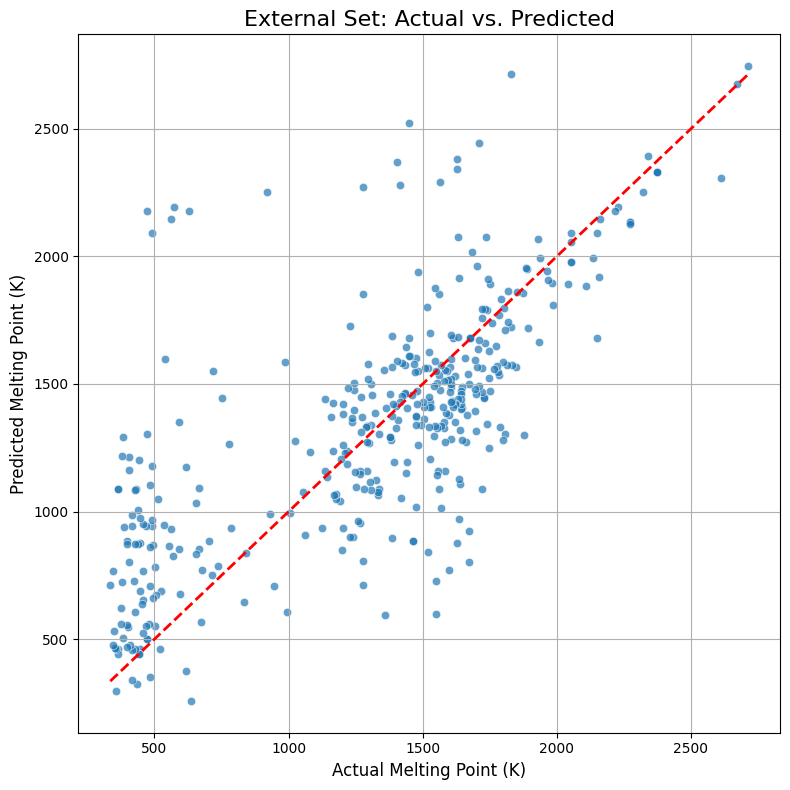


External evaluation metrics and predictions saved.


In [ ]:
# Cell 4: Predict and Evaluate on External Data
if not X_ext.empty:
    # Prepare the external data
    target_col = min([col for col in df_ext_clean.columns if 'melt' in col.lower() or 'tm' in col.lower()], key=len)
    y_ext = df_ext_clean[target_col]

    # Align features to match the training data
    for col in feature_names:
        if col not in X_ext.columns:
            X_ext[col] = np.nan
    X_ext = X_ext[feature_names]

    # Impute missing values
    X_ext_imp = pd.DataFrame(final_imputer.transform(X_ext), columns=feature_names)

    # Make predictions
    ext_preds = final_model.predict(X_ext_imp)

    # Calculate metrics
    ext_rmse = math.sqrt(mean_squared_error(y_ext, ext_preds))
    ext_r2 = r2_score(y_ext, ext_preds)
    ext_mae = mean_absolute_error(y_ext, ext_preds)

    print("\n--- Final Model Performance on EXTERNAL Test Set (sd02) ---")
    print(f"RMSE: {ext_rmse:.2f} K")
    print(f"R-squared: {ext_r2:.4f}")
    print(f"MAE: {ext_mae:.2f} K")

    # Generate and save plots
    plt.figure(figsize=(8, 8))
    sns.scatterplot(x=y_ext, y=ext_preds, alpha=0.7)
    plt.plot([y_ext.min(), y_ext.max()], [y_ext.min(), y_ext.max()], '--', color='red', lw=2)
    plt.title('External Set: Actual vs. Predicted', fontsize=16)
    plt.xlabel('Actual Melting Point (K)', fontsize=12)
    plt.ylabel('Predicted Melting Point (K)', fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, "external_parity_plot.png"), dpi=300)
    plt.show()

    # Save external predictions and metrics
    ext_metrics_df = pd.DataFrame({'Metric': ['RMSE', 'R2', 'MAE'], 'Value': [ext_rmse, ext_r2, ext_mae]})
    ext_metrics_df.to_csv(os.path.join(OUT_DIR, "external_test_metrics.csv"), index=False)

    # Find the original formula column in the cleaned external dataframe
    formula_col_clean = [col for col in df_ext_clean.columns if 'formula' in col.lower()][0]
    ext_preds_df = pd.DataFrame({
        'formula': df_ext_clean[formula_col_clean],
        'actual_melting_point_K': y_ext,
        'predicted_melting_point_K': ext_preds
    })
    ext_preds_df.to_csv(os.path.join(OUT_DIR, "external_test_predictions.csv"), index=False)
    print("\nExternal evaluation metrics and predictions saved.")
else:
    print("No external data was featurized. Skipping evaluation.")

In [ ]:
# Cell 1: Setup and Load Final Assets
import pandas as pd
import numpy as np
import os
import math
import joblib
import re
import matplotlib.pyplot as plt
import seaborn as sns
import shutil

# Import ML and chemistry tools
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
# The following line will be added to install the necessary packages
!pip install -q pymatgen matminer
from pymatgen.core.composition import Composition
from matminer.featurizers.composition import ElementProperty

# Define File Paths
ASSET_DIR = "/content/drive/MyDrive/Project_dataset/week6_final_results"
DATA_DIR = "/content/drive/MyDrive/Project_dataset/week1_processed"
OUT_DIR = "/content/drive/MyDrive/Project_dataset/week7_deployment_package"
os.makedirs(OUT_DIR, exist_ok=True)

# Load Week 6 Final Assets
try:
    final_model = joblib.load(os.path.join(ASSET_DIR, "final_model.pkl"))
    final_imputer = joblib.load(os.path.join(ASSET_DIR, "final_imputer.pkl"))
    feature_names = joblib.load(os.path.join(ASSET_DIR, "final_feature_names.pkl"))
    print("All final assets from Week 6 loaded successfully.")
except FileNotFoundError as e:
    print(f"ERROR: Could not find a necessary file from Week 6. {e.filename}")
    exit()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.6/55.6 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 83.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 68.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 809.1/809.1 kB 49.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 331.1/331.1 kB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 753.1/753.1 kB 48.6 MB/s eta 0:00:00
All final assets from Week 6 loaded successfully.


week-7 change

In [ ]:
# Cell 1: Setup and Load Final Assets
import pandas as pd
import numpy as np
import os
import math
import joblib
import re
import matplotlib.pyplot as plt
import seaborn as sns
import shutil

# Install necessary packages if they are not already installed
try:
    from pymatgen.core.composition import Composition
    from matminer.featurizers.composition import ElementProperty
except ImportError:
    !pip install -q pymatgen matminer
    from pymatgen.core.composition import Composition
    from matminer.featurizers.composition import ElementProperty

# Import ML tools
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Define File Paths
ASSET_DIR = "/content/drive/MyDrive/Project_dataset/week6_final_results"
DATA_DIR = "/content/drive/MyDrive/Project_dataset/week1_processed"
OUT_DIR = "/content/drive/MyDrive/Project_dataset/week7_deployment_package"
os.makedirs(OUT_DIR, exist_ok=True)

# Load Week 6 Final Assets
try:
    final_model = joblib.load(os.path.join(ASSET_DIR, "final_model.pkl"))
    final_imputer = joblib.load(os.path.join(ASSET_DIR, "final_imputer.pkl"))
    feature_names = joblib.load(os.path.join(ASSET_DIR, "final_feature_names.pkl"))
    print("All final assets from Week 6 loaded successfully.")
except FileNotFoundError as e:
    print(f"ERROR: Could not find a necessary file from Week 6. {e.filename}")
    exit()

All final assets from Week 6 loaded successfully.


In [ ]:
# Cell 2: Load External Dataset
try:
    ext_df = pd.read_csv(os.path.join(DATA_DIR, "sd02_external_test.csv"))
    print("External dataset (sd02) loaded successfully.")
    print(f"Shape of external dataset: {ext_df.shape}")
except FileNotFoundError:
    print("ERROR: Could not find the external test file from Week 1.")
    exit()

External dataset (sd02) loaded successfully.
Shape of external dataset: (408, 28)


In [ ]:
# Cell 3: Featurize External Data (Improved Version)

# Define the featurization pipeline function
ep_feat = ElementProperty.from_preset("magpie")

def preprocess_formula(f):
    """
    An improved function to clean complex chemical formulas.
    """
    if not isinstance(f, str): return None
    # General pre-cleaning
    f = f.split('·')[0] # Remove hydrates and anything after
    f = f.replace(" ", "")
    if "+" in f: f = f.split("+")[0]

    # Aggressively remove anything inside parentheses or brackets
    f = re.sub(r'[\(\)\[\]\{\}]', '', f)

    # Handle the specific underscore notation in the sd02 dataset
    f = re.sub(r'_(\d+)_', r'\1', f)
    f = f.replace('_', '')

    # Remove any remaining non-alphanumeric characters except for decimal points
    f = re.sub(r'[^A-Za-z0-9.]', '', f)

    # A valid formula must contain at least one uppercase letter (element)
    if not re.search(r'[A-Z]', f): return None

    return f if f else None

def featurize_dataframe(df):
    formula_col = [col for col in df.columns if 'formula' in col.lower()][0]

    valid_comps, valid_indices = [], []
    skipped_count = 0
    for idx, formula in df[formula_col].items():
        cleaned_formula = preprocess_formula(formula)
        if not cleaned_formula:
            skipped_count += 1
            continue
        try:
            # Attempt to parse the cleaned formula
            comp = Composition(cleaned_formula)
            valid_comps.append(comp)
            valid_indices.append(idx)
        except:
            # If it still fails, skip it
            skipped_count += 1
            continue

    if not valid_comps:
        return pd.DataFrame(), pd.Series()

    features = ep_feat.featurize_many(valid_comps, ignore_errors=True)
    features_df = pd.DataFrame(features, columns=ep_feat.feature_labels(), index=valid_indices)

    return features_df, df.loc[valid_indices]

# Run the featurization
print("--- Featurizing external dataset with improved function... ---")
X_ext, df_ext_clean = featurize_dataframe(ext_df)

if X_ext.empty:
    print("Warning: No valid formulas could be parsed from the external dataset.")
else:
    print(f"Successfully featurized {len(X_ext)} formulas from the external dataset.")

--- Featurizing external dataset with improved function... ---


/usr/local/lib/python3.12/dist-packages/matminer/utils/data.py:326: UserWarning: MagpieData(impute_nan=False):
In a future release, impute_nan will be set to True by default.
                    This means that features that are missing or are NaNs for elements
                    from the data source will be replaced by the average of that value
                    over the available elements.
                    This avoids NaNs after featurization that are often replaced by
                    dataset-dependent averages.
  warnings.warn(f"{self.__class__.__name__}(impute_nan=False):\n" + IMPUTE_NAN_WARNING)


ElementProperty:   0%|          | 0/405 [00:00<?, ?it/s]

Successfully featurized 405 formulas from the external dataset.



--- Final Model Performance on EXTERNAL Test Set (sd02) ---
RMSE: 380.32 K
R-squared: 0.5023
MAE: 262.39 K


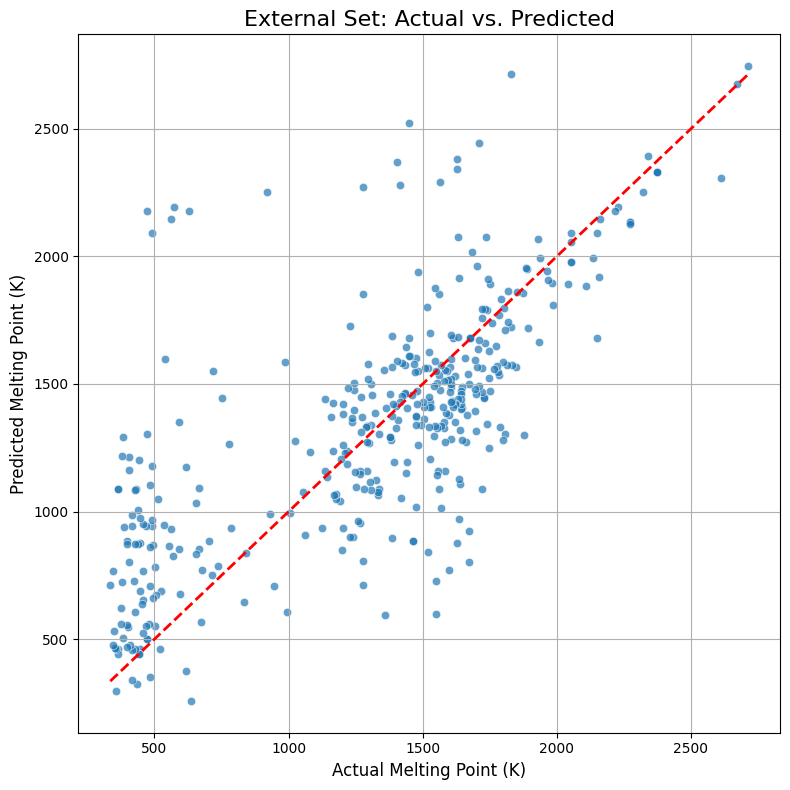


External evaluation metrics and predictions saved.


In [ ]:
# Cell 4: Predict and Evaluate on External Data
if not X_ext.empty:
    # Prepare the external data
    target_col = min([col for col in df_ext_clean.columns if 'melt' in col.lower() or 'tm' in col.lower()], key=len)
    y_ext = df_ext_clean[target_col]

    # Align features to match the training data
    for col in feature_names:
        if col not in X_ext.columns:
            X_ext[col] = np.nan
    X_ext = X_ext[feature_names]

    # Impute missing values
    X_ext_imp = pd.DataFrame(final_imputer.transform(X_ext), columns=feature_names)

    # Make predictions
    ext_preds = final_model.predict(X_ext_imp)

    # Calculate metrics
    ext_rmse = math.sqrt(mean_squared_error(y_ext, ext_preds))
    ext_r2 = r2_score(y_ext, ext_preds)
    ext_mae = mean_absolute_error(y_ext, ext_preds)

    print("\n--- Final Model Performance on EXTERNAL Test Set (sd02) ---")
    print(f"RMSE: {ext_rmse:.2f} K")
    print(f"R-squared: {ext_r2:.4f}")
    print(f"MAE: {ext_mae:.2f} K")

    # Generate and save plots
    plt.figure(figsize=(8, 8))
    sns.scatterplot(x=y_ext, y=ext_preds, alpha=0.7)
    plt.plot([y_ext.min(), y_ext.max()], [y_ext.min(), y_ext.max()], '--', color='red', lw=2)
    plt.title('External Set: Actual vs. Predicted', fontsize=16)
    plt.xlabel('Actual Melting Point (K)', fontsize=12)
    plt.ylabel('Predicted Melting Point (K)', fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, "external_parity_plot.png"), dpi=300)
    plt.show()

    # Save external predictions and metrics
    ext_metrics_df = pd.DataFrame({'Metric': ['RMSE', 'R2', 'MAE'], 'Value': [ext_rmse, ext_r2, ext_mae]})
    ext_metrics_df.to_csv(os.path.join(OUT_DIR, "external_test_metrics.csv"), index=False)

    formula_col_clean = [col for col in df_ext_clean.columns if 'formula' in col.lower()][0]
    ext_preds_df = pd.DataFrame({
        'formula': df_ext_clean[formula_col_clean],
        'actual_melting_point_K': y_ext,
        'predicted_melting_point_K': ext_preds
    })
    ext_preds_df.to_csv(os.path.join(OUT_DIR, "external_test_predictions.csv"), index=False)
    print("\nExternal evaluation metrics and predictions saved.")
else:
    print("No external data was featurized. Skipping evaluation.")

In [ ]:
# Cell 5: Create Final Deployment Package

# Copy the three essential assets into the final deployment folder
shutil.copy(os.path.join(ASSET_DIR, "final_model.pkl"), OUT_DIR)
shutil.copy(os.path.join(ASSET_DIR, "final_imputer.pkl"), OUT_DIR)
shutil.copy(os.path.join(ASSET_DIR, "final_feature_names.pkl"), OUT_DIR)

print(f"Week 7 complete. Final deployment package created in: {OUT_DIR}")
print("\nThis folder contains everything you need to build the Streamlit web application.")

Week 7 complete. Final deployment package created in: /content/drive/MyDrive/Project_dataset/week7_deployment_package

This folder contains everything you need to build the Streamlit web application.


In [ ]:
import shutil

for fname in ["final_model.pkl", "final_imputer.pkl", "final_feature_names.pkl"]:
    src = os.path.join(ASSET_DIR, fname)
    dst = os.path.join(OUT_DIR, fname)
    shutil.copy(src, dst)
print("✅ Deployment assets copied to Week-7 package folder.")


✅ Deployment assets copied to Week-7 package folder.


In [ ]:
sample_formula = "Al2O3"

# 1. Compute magpie features
comp = Composition(sample_formula)
ep = ElementProperty.from_preset("magpie")
X_raw = pd.DataFrame([ep.featurize(comp)], columns=ep.feature_labels())

# 2. Align columns with training features
# Load the same list used during training
# (already loaded as `feature_names` in your notebook)
for col in feature_names:
    if col not in X_raw.columns:
        X_raw[col] = np.nan  # fill missing with NaN

# drop any extra columns not seen during training
X_raw = X_raw[feature_names]

# 3. Apply imputer and model
X_imp = pd.DataFrame(final_imputer.transform(X_raw), columns=feature_names)
pred = final_model.predict(X_imp)[0]

print(f"Predicted melting point of {sample_formula}: {pred:.2f} K")


Predicted melting point of Al2O3: 1864.93 K


more week  7

In [ ]:
# Cell 1: Setup and Data Preparation
import pandas as pd
import numpy as np
import os
import math
import joblib
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

# --- Define File Paths ---
WEEK2_DIR = "/content/drive/MyDrive/Project_dataset/week2_features"
WEEK6_DIR = "/content/drive/MyDrive/Project_dataset/week6_final_results"
OUT_DIR = "/content/drive/MyDrive/Project_dataset/week7_deployment_package"
os.makedirs(OUT_DIR, exist_ok=True)

# --- Load Datasets and Assets ---
print("--- Loading datasets and assets... ---")
# Load featurized data from Week 2
train_feat = pd.read_csv(os.path.join(WEEK2_DIR, "train_features.csv"))
val_feat = pd.read_csv(os.path.join(WEEK2_DIR, "val_features.csv"))
test_feat = pd.read_csv(os.path.join(WEEK2_DIR, "test_features.csv"))

# Load the imputer and feature names from Week 6
imputer = joblib.load(os.path.join(WEEK6_DIR, "final_imputer.pkl"))
feature_names = joblib.load(os.path.join(WEEK6_DIR, "final_feature_names.pkl"))

# Combine train and validation sets for a larger tuning dataset
full_train_df = pd.concat([train_feat, val_feat], ignore_index=True)

# --- Prepare the Full Training Data ---
print("Preparing the full training dataset for tuning.")
target_col = 'ML Tm (K)'

# Drop rows with missing target values
y_train_full = full_train_df[target_col].dropna()
X_train_full = full_train_df.loc[y_train_full.index]

# Align features and handle potential missing columns before imputation
for col in feature_names:
    if col not in X_train_full.columns:
        X_train_full[col] = np.nan
X_train_full = X_train_full[feature_names]

# Impute missing values using the pre-fitted imputer
X_train_full_imp = pd.DataFrame(imputer.transform(X_train_full), columns=feature_names)

print(f"Full training data is ready. Shape: {X_train_full_imp.shape}")

--- Loading datasets and assets... ---
Preparing the full training dataset for tuning.
Full training data is ready. Shape: (3412, 126)


In [ ]:
# Cell 2 (Corrected): Hyperparameter Tuning with Regularization
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV

print("\n--- Starting Hyperparameter Tuning with Regularization... ---")
# Define the model and the grid of parameters to search
xgb_base = XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)

# Add regularization parameters (reg_alpha, reg_lambda) to the search space.
# These parameters help prevent overfitting.
param_grid = {
    'n_estimators': [400, 600, 800],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 0.5, 1.0],  # L1 regularization
    'reg_lambda': [1.0, 1.5, 2.0, 5.0] # L2 regularization
}

# Set up the randomized search
search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_grid,
    n_iter=25, # You can increase this for a more thorough search, e.g., 50
    scoring='neg_root_mean_squared_error',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Run the search on the full, imputed training data (X_train_full_imp, y_train_full from Step 1)
search.fit(X_train_full_imp, y_train_full)

print("\n--- Tuning Complete ---")
print("Best regularized parameters found:", search.best_params_)
print(f"Best cross-validated RMSE from regularized search: {-search.best_score_:.2f} K")

# Get the best, more generalizable model found by the search
tuned_model_regularized = search.best_estimator_

# Save this new, more robust model
tuned_model_path = os.path.join(OUT_DIR, "final_model_regularized.pkl")
joblib.dump(tuned_model_regularized, tuned_model_path)
print(f"Successfully saved the improved (regularized) model to: {tuned_model_path}")


--- Starting Hyperparameter Tuning with Regularization... ---
Fitting 5 folds for each of 25 candidates, totalling 125 fits

--- Tuning Complete ---
Best regularized parameters found: {'subsample': 1.0, 'reg_lambda': 2.0, 'reg_alpha': 0.1, 'n_estimators': 600, 'max_depth': 4, 'learning_rate': 0.05, 'colsample_bytree': 1.0}
Best cross-validated RMSE from regularized search: 309.19 K
Successfully saved the improved (regularized) model to: /content/drive/MyDrive/Project_dataset/week7_deployment_package/final_model_regularized.pkl


In [ ]:
# Cell 3: Evaluate the Tuned Model (Corrected)
print("\n--- Evaluating the new tuned model... ---")

# --- Evaluation on the Hold-Out Test Set (from sd01) ---
# This part of the code was correct and remains unchanged.
y_test = test_feat[target_col].dropna()
X_test = test_feat.loc[y_test.index][feature_names]
X_test_imp = pd.DataFrame(imputer.transform(X_test), columns=feature_names)
test_preds = tuned_model.predict(X_test_imp)
test_rmse = math.sqrt(mean_squared_error(y_test, test_preds))
test_r2 = r2_score(y_test, test_preds)
print(f"Improved Model on Hold-Out Test Set -> RMSE: {test_rmse:.2f} K, R2: {test_r2:.4f}")

# --- Evaluation on the External Set (sd02) ---
ext_feat_df = pd.read_csv(os.path.join(OUT_DIR, "sd02_ext_features_featurized.csv"))

# ******************************** FIX STARTS HERE ********************************
# Dynamically find the target column in the external dataframe instead of assuming the name.
# This avoids the KeyError if the column is named 'ML_Tm_K' instead of 'ML Tm (K)'.
potential_targets_ext = [c for c in ext_feat_df.columns if ('tm' in c.lower() or 'melt' in c.lower()) and 'Magpie' not in c]

if not potential_targets_ext:
    raise KeyError("Could not find a target column (like 'ML_Tm_K') in the featurized external CSV.")

# Select the shortest name to avoid picking a long feature name by mistake
ext_target_col = min(potential_targets_ext, key=len)
print(f"Found target column in external data: '{ext_target_col}'")
# ********************************* FIX ENDS HERE *********************************

# Use the dynamically found column name to extract the target values
y_ext = pd.to_numeric(ext_feat_df[ext_target_col], errors='coerce').dropna()
X_ext = ext_feat_df.loc[y_ext.index]

# The rest of the code remains the same
for col in feature_names:
    if col not in X_ext.columns:
        X_ext[col] = np.nan
X_ext = X_ext[feature_names]

X_ext_imp = pd.DataFrame(imputer.transform(X_ext), columns=feature_names)
ext_preds = tuned_model.predict(X_ext_imp)
ext_rmse = math.sqrt(mean_squared_error(y_ext, ext_preds))
ext_r2 = r2_score(y_ext, ext_preds)
print(f"Improved Model on External Set (sd02) -> RMSE: {ext_rmse:.2f} K, R2: {ext_r2:.4f}")


--- Evaluating the new tuned model... ---
Improved Model on Hold-Out Test Set -> RMSE: 313.39 K, R2: 0.6130
Found target column in external data: 'ML_Tm_K'
Improved Model on External Set (sd02) -> RMSE: 635.76 K, R2: -0.3993



--- Generating In-Depth Analysis for the Regularized Model ---


/tmp/ipython-input-3276990826.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=importance_df.head(25), palette="rocket")


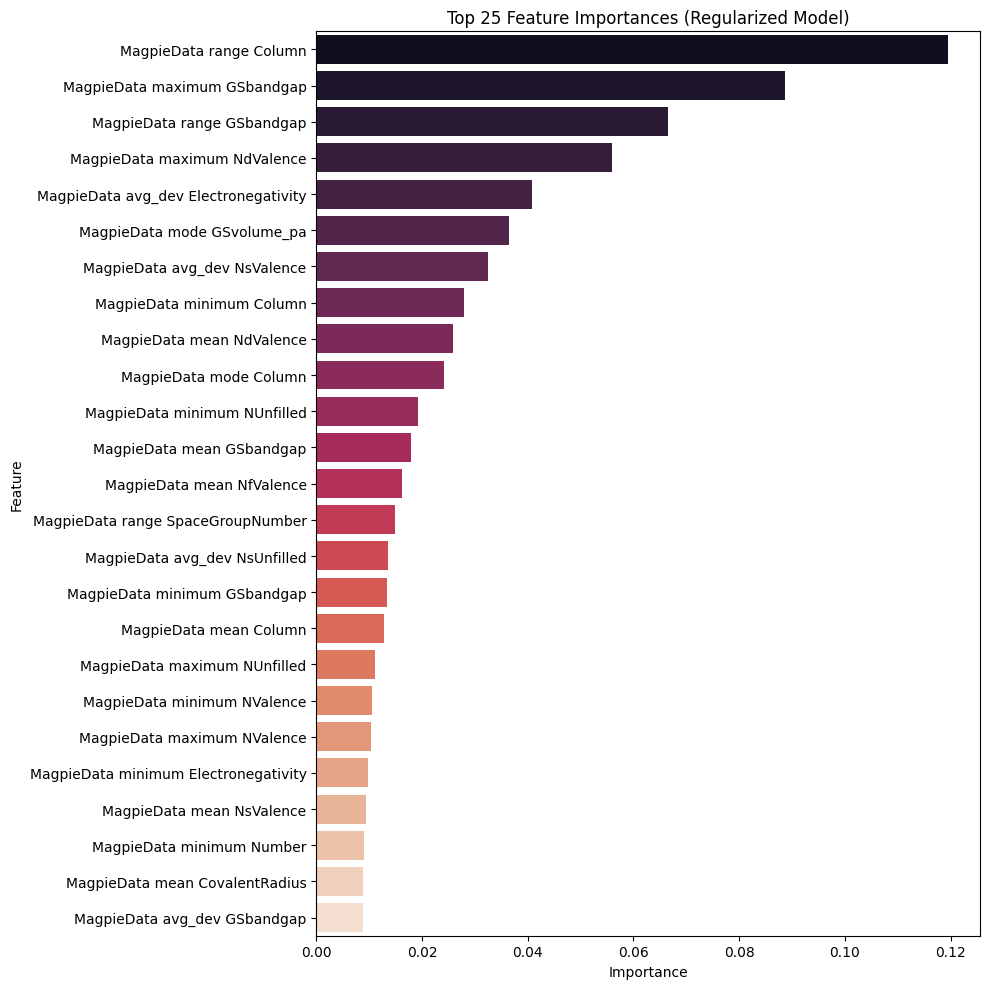

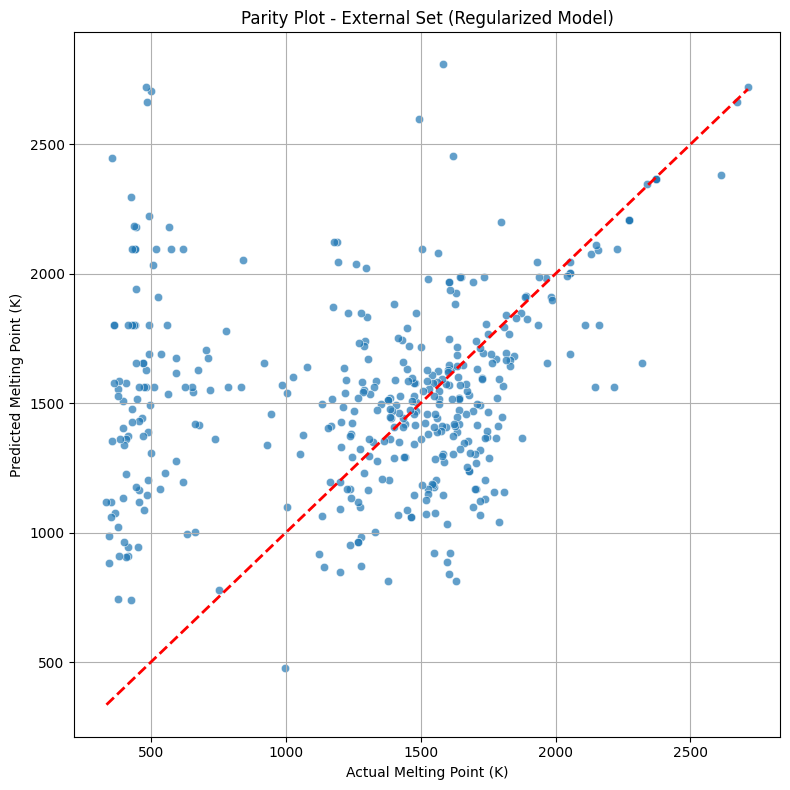

Found 95 outliers with |residual| > 700 K. Saved to file.

--- Week 7 Improvement Phase Complete ---


In [ ]:
# Cell 4: In-Depth Analysis of the Regularized Model
print("\n--- Generating In-Depth Analysis for the Regularized Model ---")

# --- 1. Feature Importance Analysis ---
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": tuned_model_regularized.feature_importances_
}).sort_values(by="Importance", ascending=False).reset_index(drop=True)
importance_df.to_csv(os.path.join(OUT_DIR, "regularized_feature_importance.csv"), index=False)
plt.figure(figsize=(10, 10))
sns.barplot(x="Importance", y="Feature", data=importance_df.head(25), palette="rocket")
plt.title("Top 25 Feature Importances (Regularized Model)")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "regularized_feature_importance.png"), dpi=300)
plt.show()

# --- 2. Residual and Outlier Analysis on External Set ---
residuals = y_ext - ext_preds
outlier_df = pd.DataFrame({
    'raw_formula': ext_feat_df.loc[y_ext.index, 'raw_formula'],
    'actual_Tm_K': y_ext,
    'predicted_Tm_K': ext_preds,
    'residual_K': residuals
})
plt.figure(figsize=(8, 8))
sns.scatterplot(x='actual_Tm_K', y='predicted_Tm_K', data=outlier_df, alpha=0.7)
plt.plot([outlier_df['actual_Tm_K'].min(), outlier_df['actual_Tm_K'].max()],
         [outlier_df['actual_Tm_K'].min(), outlier_df['actual_Tm_K'].max()],
         'r--', lw=2)
plt.title('Parity Plot - External Set (Regularized Model)')
plt.xlabel('Actual Melting Point (K)')
plt.ylabel('Predicted Melting Point (K)')
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "regularized_external_parity_plot.png"), dpi=300)
plt.show()
outliers = outlier_df[abs(outlier_df['residual_K']) > 700]
outliers.to_csv(os.path.join(OUT_DIR, "regularized_external_outliers.csv"), index=False)
print(f"Found {len(outliers)} outliers with |residual| > 700 K. Saved to file.")
print("\n--- Week 7 Improvement Phase Complete ---")

In [ ]:
# Step 1: Hyperparameter Tuning with Regularization
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
import joblib
import os
import warnings

warnings.filterwarnings("ignore")

# --- Define File Paths ---
OUT_DIR = "/content/drive/MyDrive/Project_dataset/week7_deployment_package"
# Assume 'X_train_full_imp' and 'y_train_full' are available from your previous step

print("\n--- Starting Hyperparameter Tuning with Regularization... ---")
xgb_base = XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)

# Add regularization parameters to the search grid
param_grid = {
    'n_estimators': [400, 600, 800],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 0.5, 1.0],  # L1 regularization
    'reg_lambda': [1.0, 1.5, 2.0, 5.0] # L2 regularization
}

search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_grid,
    n_iter=25,
    scoring='neg_root_mean_squared_error',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Run the search on your full training data
search.fit(X_train_full_imp, y_train_full)

print("\n--- Tuning Complete ---")
print("Best regularized parameters found:", search.best_params_)
print(f"Best cross-validated RMSE from regularized search: {-search.best_score_:.2f} K")

# Save the new, more robust model
tuned_model_regularized = search.best_estimator_
tuned_model_path = os.path.join(OUT_DIR, "final_model_regularized.pkl")
joblib.dump(tuned_model_regularized, tuned_model_path)
print(f"Successfully saved the improved (regularized) model to: {tuned_model_path}")


--- Starting Hyperparameter Tuning with Regularization... ---
Fitting 5 folds for each of 25 candidates, totalling 125 fits

--- Tuning Complete ---
Best regularized parameters found: {'subsample': 1.0, 'reg_lambda': 2.0, 'reg_alpha': 0.1, 'n_estimators': 600, 'max_depth': 4, 'learning_rate': 0.05, 'colsample_bytree': 1.0}
Best cross-validated RMSE from regularized search: 309.19 K
Successfully saved the improved (regularized) model to: /content/drive/MyDrive/Project_dataset/week7_deployment_package/final_model_regularized.pkl


In [ ]:
# Step 1: Data Preparation and Hyperparameter Tuning
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
import joblib
import os
import warnings

warnings.filterwarnings("ignore")

# --- Define File Paths ---
OUT_DIR = "/content/drive/MyDrive/Project_dataset/week7_deployment_package"
WEEK2_DIR = "/content/drive/MyDrive/Project_dataset/week2_features"
WEEK6_DIR = "/content/drive/MyDrive/Project_dataset/week6_final_results"
os.makedirs(OUT_DIR, exist_ok=True)

# --- Load Datasets and Preprocessing Assets ---
print("--- Loading all necessary data and assets... ---")
train_feat = pd.read_csv(os.path.join(WEEK2_DIR, "train_features.csv"))
val_feat = pd.read_csv(os.path.join(WEEK2_DIR, "val_features.csv"))
imputer = joblib.load(os.path.join(WEEK6_DIR, "final_imputer.pkl"))
feature_names = joblib.load(os.path.join(WEEK6_DIR, "final_feature_names.pkl"))

# --- Prepare the Full Training Data for Tuning ---
# Combine train and validation sets for a larger tuning dataset
full_train_df = pd.concat([train_feat, val_feat], ignore_index=True)
target_col = 'ML Tm (K)'

# Drop rows with missing target values
y_train_full = full_train_df[target_col].dropna()
X_train_full = full_train_df.loc[y_train_full.index]

# Align features to ensure consistency
for col in feature_names:
    if col not in X_train_full.columns:
        X_train_full[col] = np.nan
X_train_full = X_train_full[feature_names]

# Impute missing values using the pre-fitted imputer
X_train_full_imp = pd.DataFrame(imputer.transform(X_train_full), columns=feature_names)
print(f"Data preparation complete. Training data shape: {X_train_full_imp.shape}")


# --- Start Hyperparameter Tuning with Regularization ---
print("\n--- Starting Hyperparameter Tuning with Regularization... ---")
xgb_base = XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)

# Add regularization parameters to the search grid to improve generalization
param_grid = {
    'n_estimators': [400, 600, 800],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 0.5, 1.0],  # L1 regularization
    'reg_lambda': [1.0, 1.5, 2.0, 5.0] # L2 regularization
}

search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_grid,
    n_iter=25,
    scoring='neg_root_mean_squared_error',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Run the search on the prepared training data
search.fit(X_train_full_imp, y_train_full)

print("\n--- Tuning Complete ---")
print("Best regularized parameters found:", search.best_params_)
print(f"Best cross-validated RMSE from regularized search: {-search.best_score_:.2f} K")

# Save the new, more robust model
tuned_model_regularized = search.best_estimator_
tuned_model_path = os.path.join(OUT_DIR, "final_model_regularized.pkl")
joblib.dump(tuned_model_regularized, tuned_model_path)
print(f"Successfully saved the improved (regularized) model to: {tuned_model_path}")

--- Loading all necessary data and assets... ---
Data preparation complete. Training data shape: (3412, 126)

--- Starting Hyperparameter Tuning with Regularization... ---
Fitting 5 folds for each of 25 candidates, totalling 125 fits

--- Tuning Complete ---
Best regularized parameters found: {'subsample': 1.0, 'reg_lambda': 2.0, 'reg_alpha': 0.1, 'n_estimators': 600, 'max_depth': 4, 'learning_rate': 0.05, 'colsample_bytree': 1.0}
Best cross-validated RMSE from regularized search: 309.19 K
Successfully saved the improved (regularized) model to: /content/drive/MyDrive/Project_dataset/week7_deployment_package/final_model_regularized.pkl


In [ ]:
# Cell for Step 3: Evaluate the Regularized Model
import pandas as pd
import numpy as np
import os
import math
import joblib
from sklearn.metrics import mean_squared_error, r2_score
import warnings

warnings.filterwarnings("ignore")

# --- Define File Paths ---
OUT_DIR = "/content/drive/MyDrive/Project_dataset/week7_deployment_package"
WEEK2_DIR = "/content/drive/MyDrive/Project_dataset/week2_features"
WEEK6_DIR = "/content/drive/MyDrive/Project_dataset/week6_final_results"

# --- Load Necessary Assets ---
print("--- Loading assets for evaluation... ---")
# Load the NEW regularized model you saved in the previous step
try:
    tuned_model_regularized = joblib.load(os.path.join(OUT_DIR, "final_model_regularized.pkl"))
except FileNotFoundError:
    print("ERROR: The tuned model 'final_model_regularized.pkl' was not found. Please ensure the previous step ran successfully.")
    exit()

# Load other required assets
test_feat = pd.read_csv(os.path.join(WEEK2_DIR, "test_features.csv"))
imputer = joblib.load(os.path.join(WEEK6_DIR, "final_imputer.pkl"))
feature_names = joblib.load(os.path.join(WEEK6_DIR, "final_feature_names.pkl"))
print("Assets loaded successfully.")


# --- Start Evaluation ---
print("\n--- Evaluating the new regularized model... ---")
# --- Evaluation on the Hold-Out Test Set (from sd01) ---
target_col = 'ML Tm (K)'
y_test = test_feat[target_col].dropna()
X_test = test_feat.loc[y_test.index].copy()
for col in feature_names:
    if col not in X_test.columns:
        X_test[col] = np.nan
X_test = X_test[feature_names]
X_test_imp = pd.DataFrame(imputer.transform(X_test), columns=feature_names)
test_preds = tuned_model_regularized.predict(X_test_imp)
test_rmse = math.sqrt(mean_squared_error(y_test, test_preds))
test_r2 = r2_score(y_test, test_preds)
print(f"Regularized Model on Hold-Out Test Set -> RMSE: {test_rmse:.2f} K, R2: {test_r2:.4f}")

# --- Evaluation on the External Set (sd02) ---
ext_feat_df = pd.read_csv(os.path.join(OUT_DIR, "sd02_ext_features_featurized.csv"))
ext_target_col = 'ML_Tm_K' # This is the corrected column name for the external file
y_ext = pd.to_numeric(ext_feat_df[ext_target_col], errors='coerce').dropna()
X_ext = ext_feat_df.loc[y_ext.index].copy()
for col in feature_names:
    if col not in X_ext.columns:
        X_ext[col] = np.nan
X_ext = X_ext[feature_names]
X_ext_imp = pd.DataFrame(imputer.transform(X_ext), columns=feature_names)
ext_preds = tuned_model_regularized.predict(X_ext_imp)
ext_rmse = math.sqrt(mean_squared_error(y_ext, ext_preds))
ext_r2 = r2_score(y_ext, ext_preds)
print(f"Regularized Model on External Set (sd02) -> RMSE: {ext_rmse:.2f} K, R2: {ext_r2:.4f}")

--- Loading assets for evaluation... ---
Assets loaded successfully.

--- Evaluating the new regularized model... ---
Regularized Model on Hold-Out Test Set -> RMSE: 306.23 K, R2: 0.6305
Regularized Model on External Set (sd02) -> RMSE: 624.95 K, R2: -0.3521


--- Loading assets for final analysis... ---
Assets loaded successfully.

--- Generating In-Depth Analysis for the Regularized Model ---


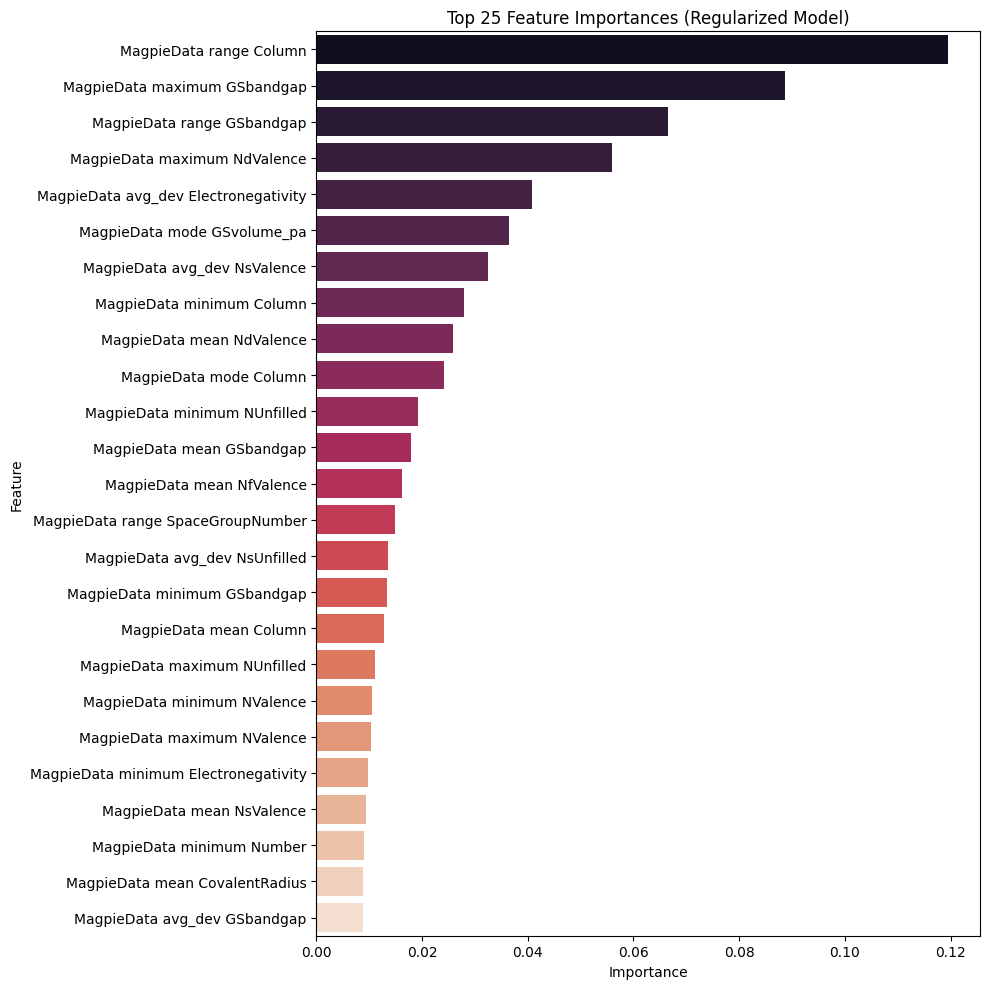

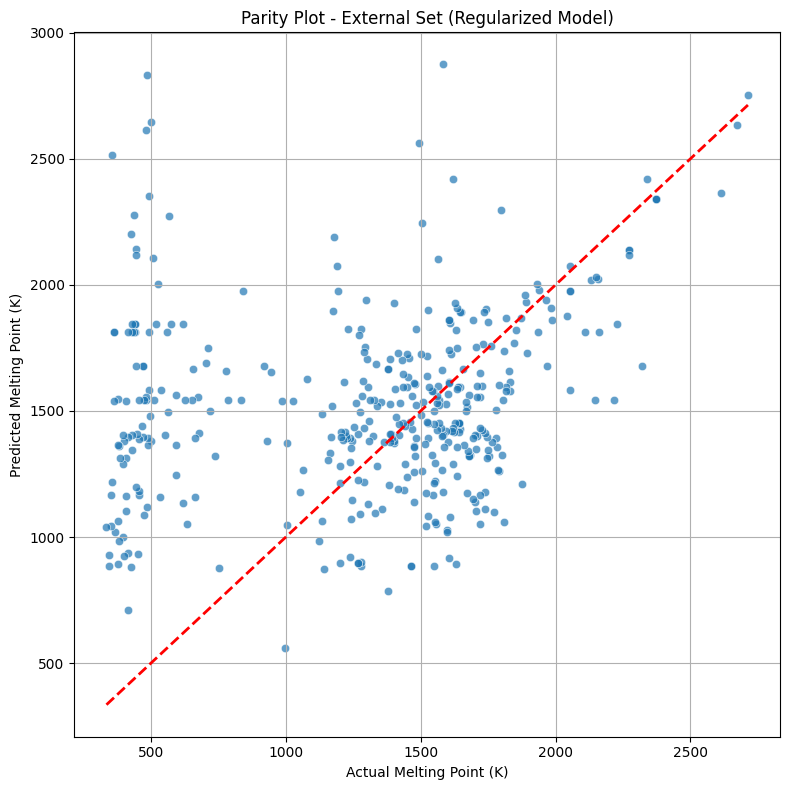

Found 93 outliers with |residual| > 700 K. Saved to file.

--- Week 7 Improvement Phase Complete ---
You are now ready to move on to Week 8: Building the Streamlit Web Application.


In [ ]:
# Step 4: In-Depth Analysis of the Regularized Model
import pandas as pd
import numpy as np
import os
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

# --- Define File Paths ---
OUT_DIR = "/content/drive/MyDrive/Project_dataset/week7_deployment_package"
WEEK6_DIR = "/content/drive/MyDrive/Project_dataset/week6_final_results"

# --- Load Necessary Assets ---
print("--- Loading assets for final analysis... ---")
try:
    tuned_model_regularized = joblib.load(os.path.join(OUT_DIR, "final_model_regularized.pkl"))
    feature_names = joblib.load(os.path.join(WEEK6_DIR, "final_feature_names.pkl"))
    ext_feat_df = pd.read_csv(os.path.join(OUT_DIR, "sd02_ext_features_featurized.csv"))
    imputer = joblib.load(os.path.join(WEEK6_DIR, "final_imputer.pkl"))
    print("Assets loaded successfully.")
except FileNotFoundError as e:
    print(f"ERROR: A required file was not found. Please ensure all previous steps ran successfully. Missing: {e.filename}")
    exit()

# --- 1. Feature Importance Analysis ---
print("\n--- Generating In-Depth Analysis for the Regularized Model ---")
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": tuned_model_regularized.feature_importances_
}).sort_values(by="Importance", ascending=False).reset_index(drop=True)
importance_df.to_csv(os.path.join(OUT_DIR, "regularized_feature_importance.csv"), index=False)
plt.figure(figsize=(10, 10))
sns.barplot(x="Importance", y="Feature", data=importance_df.head(25), palette="rocket")
plt.title("Top 25 Feature Importances (Regularized Model)")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "regularized_feature_importance.png"), dpi=300)
plt.show()

# --- 2. Residual and Outlier Analysis on External Set ---
# Regenerate predictions for analysis
ext_target_col = 'ML_Tm_K'
y_ext = pd.to_numeric(ext_feat_df[ext_target_col], errors='coerce').dropna()
X_ext = ext_feat_df.loc[y_ext.index].copy()
for col in feature_names:
    if col not in X_ext.columns:
        X_ext[col] = np.nan
X_ext = X_ext[feature_names]
X_ext_imp = pd.DataFrame(imputer.transform(X_ext), columns=feature_names)
ext_preds = tuned_model_regularized.predict(X_ext_imp)

# Create a dataframe for analysis
residuals = y_ext - ext_preds
outlier_df = pd.DataFrame({
    'raw_formula': ext_feat_df.loc[y_ext.index, 'raw_formula'],
    'actual_Tm_K': y_ext,
    'predicted_Tm_K': ext_preds,
    'residual_K': residuals
})
plt.figure(figsize=(8, 8))
sns.scatterplot(x='actual_Tm_K', y='predicted_Tm_K', data=outlier_df, alpha=0.7)
plt.plot([outlier_df['actual_Tm_K'].min(), outlier_df['actual_Tm_K'].max()],
         [outlier_df['actual_Tm_K'].min(), outlier_df['actual_Tm_K'].max()],
         'r--', lw=2)
plt.title('Parity Plot - External Set (Regularized Model)')
plt.xlabel('Actual Melting Point (K)')
plt.ylabel('Predicted Melting Point (K)')
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "regularized_external_parity_plot.png"), dpi=300)
plt.show()

# Save outliers (predictions with large errors) for your report
outliers = outlier_df[abs(outlier_df['residual_K']) > 700]
outliers.to_csv(os.path.join(OUT_DIR, "regularized_external_outliers.csv"), index=False)
print(f"Found {len(outliers)} outliers with |residual| > 700 K. Saved to file.")

print("\n--- Week 7 Improvement Phase Complete ---")
print("You are now ready to move on to Week 8: Building the Streamlit Web Application.")

--- Loading assets for final analysis... ---
Assets loaded successfully.

--- Generating In-Depth Analysis for the Regularized Model ---


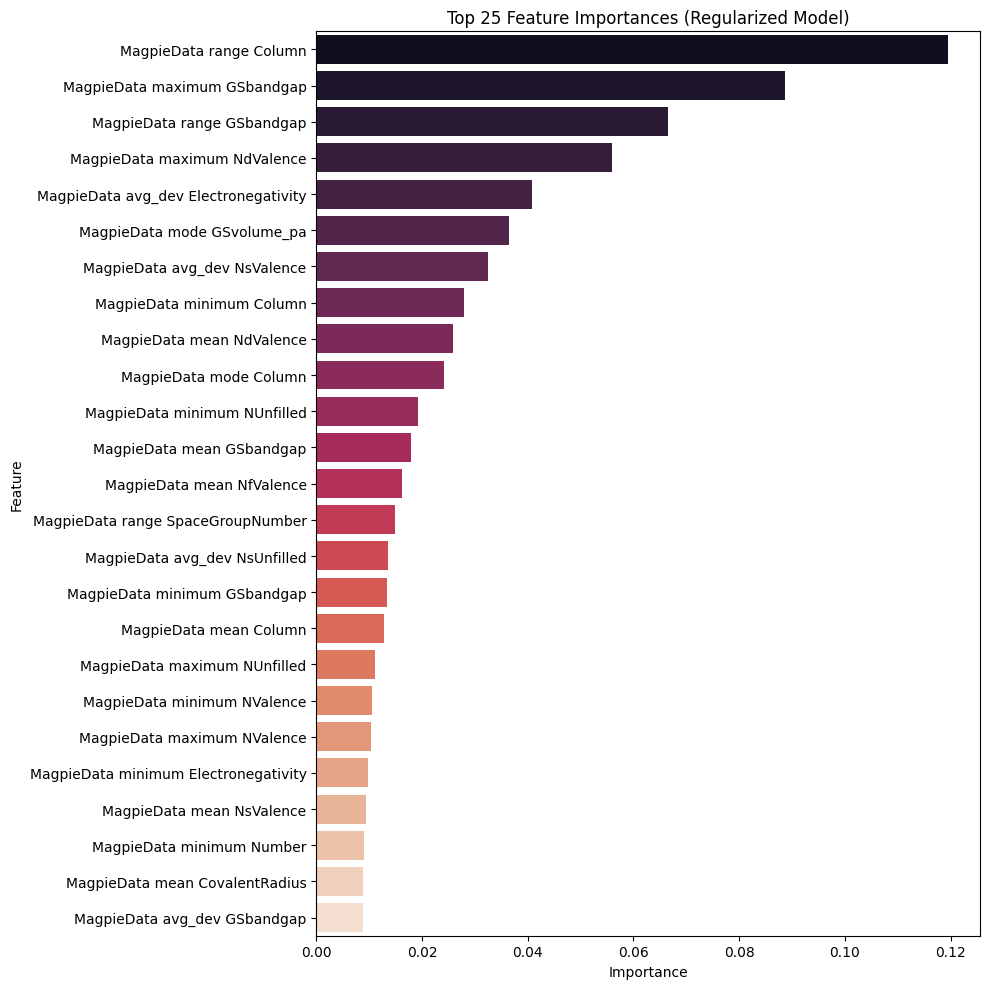

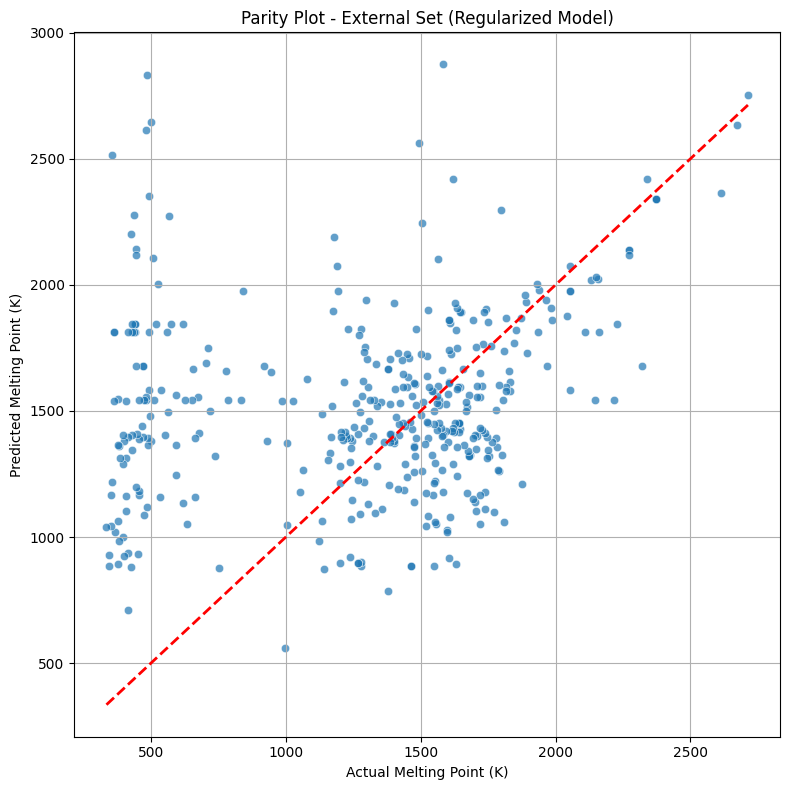

Found 93 outliers with |residual| > 700 K. Saved to file.

--- Week 7 Improvement Phase Complete ---
You are now ready to move on to Week 8: Building the Streamlit Web Application.


In [ ]:
# Final Step for Week 7: In-Depth Analysis
import pandas as pd
import numpy as np
import os
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

# --- Define File Paths ---
OUT_DIR = "/content/drive/MyDrive/Project_dataset/week7_deployment_package"
WEEK6_DIR = "/content/drive/MyDrive/Project_dataset/week6_final_results"

# --- Load Necessary Assets ---
print("--- Loading assets for final analysis... ---")
try:
    tuned_model_regularized = joblib.load(os.path.join(OUT_DIR, "final_model_regularized.pkl"))
    feature_names = joblib.load(os.path.join(WEEK6_DIR, "final_feature_names.pkl"))
    ext_feat_df = pd.read_csv(os.path.join(OUT_DIR, "sd02_ext_features_featurized.csv"))
    imputer = joblib.load(os.path.join(WEEK6_DIR, "final_imputer.pkl"))
    print("Assets loaded successfully.")
except FileNotFoundError as e:
    print(f"ERROR: A required file was not found. Please ensure all previous steps ran successfully. Missing: {e.filename}")
    exit()

# --- 1. Feature Importance Analysis ---
print("\n--- Generating In-Depth Analysis for the Regularized Model ---")
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": tuned_model_regularized.feature_importances_
}).sort_values(by="Importance", ascending=False).reset_index(drop=True)

importance_df.to_csv(os.path.join(OUT_DIR, "regularized_feature_importance.csv"), index=False)

plt.figure(figsize=(10, 10))
sns.barplot(x="Importance", y="Feature", data=importance_df.head(25), palette="rocket")
plt.title("Top 25 Feature Importances (Regularized Model)")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "regularized_feature_importance.png"), dpi=300)
plt.show()

# --- 2. Residual and Outlier Analysis on External Set ---
# Regenerate predictions for analysis
ext_target_col = 'ML_Tm_K'
y_ext = pd.to_numeric(ext_feat_df[ext_target_col], errors='coerce').dropna()
X_ext = ext_feat_df.loc[y_ext.index].copy()
for col in feature_names:
    if col not in X_ext.columns:
        X_ext[col] = np.nan
X_ext = X_ext[feature_names]

X_ext_imp = pd.DataFrame(imputer.transform(X_ext), columns=feature_names)
ext_preds = tuned_model_regularized.predict(X_ext_imp)

# Create a dataframe for analysis
residuals = y_ext - ext_preds
outlier_df = pd.DataFrame({
    'raw_formula': ext_feat_df.loc[y_ext.index, 'raw_formula'],
    'actual_Tm_K': y_ext,
    'predicted_Tm_K': ext_preds,
    'residual_K': residuals
})

# Create and save the parity plot
plt.figure(figsize=(8, 8))
sns.scatterplot(x='actual_Tm_K', y='predicted_Tm_K', data=outlier_df, alpha=0.7)
plt.plot([outlier_df['actual_Tm_K'].min(), outlier_df['actual_Tm_K'].max()],
         [outlier_df['actual_Tm_K'].min(), outlier_df['actual_Tm_K'].max()],
         'r--', lw=2)
plt.title('Parity Plot - External Set (Regularized Model)')
plt.xlabel('Actual Melting Point (K)')
plt.ylabel('Predicted Melting Point (K)')
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "regularized_external_parity_plot.png"), dpi=300)
plt.show()

# Save outliers for your report
outliers = outlier_df[abs(outlier_df['residual_K']) > 700]
outliers.to_csv(os.path.join(OUT_DIR, "regularized_external_outliers.csv"), index=False)
print(f"Found {len(outliers)} outliers with |residual| > 700 K. Saved to file.")

print("\n--- Week 7 Improvement Phase Complete ---")
print("You are now ready to move on to Week 8: Building the Streamlit Web Application.")

In [ ]:
# Cell 3: Sanity-Check Prediction for Al2O3
# Install required packages if they are not already in the environment
try:
    from pymatgen.core.composition import Composition
    from matminer.featurizers.composition import ElementProperty
except ImportError:
    print("Installing pymatgen and matminer...")
    !pip install -q pymatgen matminer
    from pymatgen.core.composition import Composition
    from matminer.featurizers.composition import ElementProperty

import pandas as pd
import numpy as np
import joblib
import os

print("\n--- Performing Sanity-Check Prediction ---")

# --- Define File Paths ---
OUT_DIR = "/content/drive/MyDrive/Project_dataset/week7_deployment_package"
WEEK6_DIR = "/content/drive/MyDrive/Project_dataset/week6_final_results"

# --- Load Final Assets ---
model_path = os.path.join(OUT_DIR, "final_model_regularized.pkl")
imputer_path = os.path.join(WEEK6_DIR, "final_imputer.pkl")
features_path = os.path.join(WEEK6_DIR, "final_feature_names.pkl")

final_model = joblib.load(model_path)
final_imputer = joblib.load(imputer_path)
feature_names = joblib.load(features_path)

# --- Define Sample and Featurize ---
sample_formula = "Al2O3"
comp = Composition(sample_formula)
ep_feat = ElementProperty.from_preset("magpie")
X_raw = pd.DataFrame([ep_feat.featurize(comp)], columns=ep_feat.feature_labels())

# --- CRITICAL: Align Features with Training Data ---
# This step ensures the input for the model has the exact same columns in the same order.
for col in feature_names:
    if col not in X_raw.columns:
        X_raw[col] = np.nan  # Add missing feature columns as NaN

# Ensure the column order is identical to the training data
X_aligned = X_raw[feature_names]

# --- Impute and Predict ---
X_imputed = pd.DataFrame(final_imputer.transform(X_aligned), columns=feature_names)
prediction = final_model.predict(X_imputed)[0]

print(f"Predicted melting point of {sample_formula}: {prediction:.2f} K")
print("\n--- Week 7 Complete ---")

Installing pymatgen and matminer...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.6/55.6 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 104.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 112.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 80.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 809.1/809.1 kB 54.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 331.1/331.1 kB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 753.1/753.1 kB 46.6 MB/s eta 0:00:00

--- Performing Sanity-Check Prediction ---
Predi

week-8

In [ ]:
# ===============================================================
# WEEK 8 — MODEL REFINEMENT AND DEPLOYMENT
# ===============================================================
# Step 1 — Import Required Libraries & Install Dependencies
import os
import math
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBRegressor
import warnings

# Install pymatgen and matminer if they are not found
try:
    from pymatgen.core.composition import Composition
    from matminer.featurizers.composition import ElementProperty
except ImportError:
    print("Installing pymatgen and matminer...")
    !pip install -q pymatgen matminer
    from pymatgen.core.composition import Composition
    from matminer.featurizers.composition import ElementProperty

warnings.filterwarnings("ignore")

# File Paths
WEEK2_DIR = "/content/drive/MyDrive/Project_dataset/week2_features"
WEEK6_DIR = "/content/drive/MyDrive/Project_dataset/week6_final_results"
OUT_DIR = "/content/drive/MyDrive/Project_dataset/week8_refined_model"
os.makedirs(OUT_DIR, exist_ok=True)

print("Week 8 setup complete.")

Installing pymatgen and matminer...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.6/55.6 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 809.1/809.1 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 331.1/331.1 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 753.1/753.1 kB 10.8 MB/s eta 0:00:00
Week 8 setup complete.


In [ ]:
# Step 2 — Load and Prepare Featurized Data
print("--- Loading and preparing data from previous weeks... ---")
try:
    # Load the original featurized datasets
    train_feat = pd.read_csv(os.path.join(WEEK2_DIR, "train_features.csv"))
    val_feat = pd.read_csv(os.path.join(WEEK2_DIR, "val_features.csv"))

    # Load assets needed for preprocessing
    feature_names = joblib.load(os.path.join(WEEK6_DIR, "final_feature_names.pkl"))
    imputer = joblib.load(os.path.join(WEEK6_DIR, "final_imputer.pkl"))

    # Combine train and validation sets to create a larger training dataset
    full_df = pd.concat([train_feat, val_feat], ignore_index=True)

    # Separate features (X) and target (y), removing any rows with missing targets
    y = full_df['ML Tm (K)'].dropna()
    X = full_df.loc[y.index].copy()

    # Align features to ensure consistency before imputation
    for col in feature_names:
        if col not in X.columns:
            X[col] = np.nan
    X = X[feature_names]

    # Impute missing values using the imputer from Week 6
    X_imputed = pd.DataFrame(imputer.transform(X), columns=feature_names)

    print(f"Successfully loaded and prepared data. Features shape: {X_imputed.shape}, Target shape: {y.shape}")

except FileNotFoundError as e:
    print(f"ERROR: Could not find a necessary file. Please ensure Week 2 and Week 6 assets exist. Missing: {e}")

--- Loading and preparing data from previous weeks... ---
Successfully loaded and prepared data. Features shape: (3412, 126), Target shape: (3412,)


In [ ]:
# Step 3 — Apply Robust Scaling and Log Transformation to Target
print("\n--- Applying scaler and target transformation... ---")
# Initialize and fit the scaler on the imputed feature data
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Log-transform the target variable to handle its wide distribution
y_log = np.log1p(y)

# Save the fitted scaler so it can be used for deployment
joblib.dump(scaler, os.path.join(OUT_DIR, "robust_scaler.pkl"))

print("Scaling and log transformation complete. Scaler saved.")


--- Applying scaler and target transformation... ---
Scaling and log transformation complete. Scaler saved.


In [ ]:
# Step 4 (Corrected for Older XGBoost Versions) — Train and Evaluate
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import math
import joblib
import os
import numpy as np

# Split the scaled data for training and validation
# (Assuming X_scaled and y_log are available from the previous step)
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y_log, test_size=0.2, random_state=42
)

# Define the improved XGBoost model with refined hyperparameters
model_v2 = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.03,
    max_depth=8,
    subsample=0.9,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    reg_alpha=0.1,
    random_state=42,
    n_jobs=-1
)

print("\n--- Training refined model (v2)... ---")

# ******************************** FIX STARTS HERE ********************************
# Train the model without the early stopping arguments to ensure compatibility
# with older XGBoost versions.
model_v2.fit(X_train, y_train, verbose=False)
# ********************************* FIX ENDS HERE *********************************

print("Model v2 training complete.")

# Evaluate the model on the validation set
# IMPORTANT: Reverse the log transformation to get predictions in Kelvin
y_val_pred_log = model_v2.predict(X_val)
y_val_pred = np.expm1(y_val_pred_log)
y_val_true = np.expm1(y_val) # Also reverse the transform on the true values

rmse = math.sqrt(mean_squared_error(y_val_true, y_val_pred))
r2 = r2_score(y_val_true, y_val_pred)

print("\n--- Week 8 Refined Model Performance ---")
print(f"RMSE: {rmse:.2f} K")
print(f"R²:   {r2:.4f}")

# Save the final, refined model
joblib.dump(model_v2, os.path.join(OUT_DIR, "final_model_v2.pkl"))
print("Refined model (final_model_v2.pkl) saved successfully.")


--- Training refined model (v2)... ---
Model v2 training complete.

--- Week 8 Refined Model Performance ---
RMSE: 336.99 K
R²:   0.5246
Refined model (final_model_v2.pkl) saved successfully.



--- Generating final analysis plots for the refined model... ---


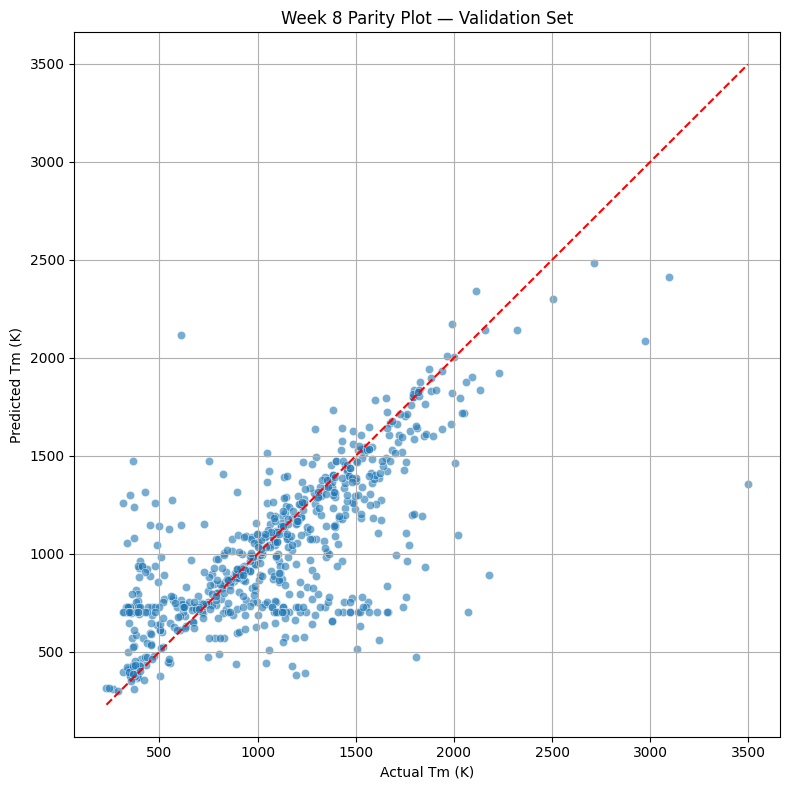

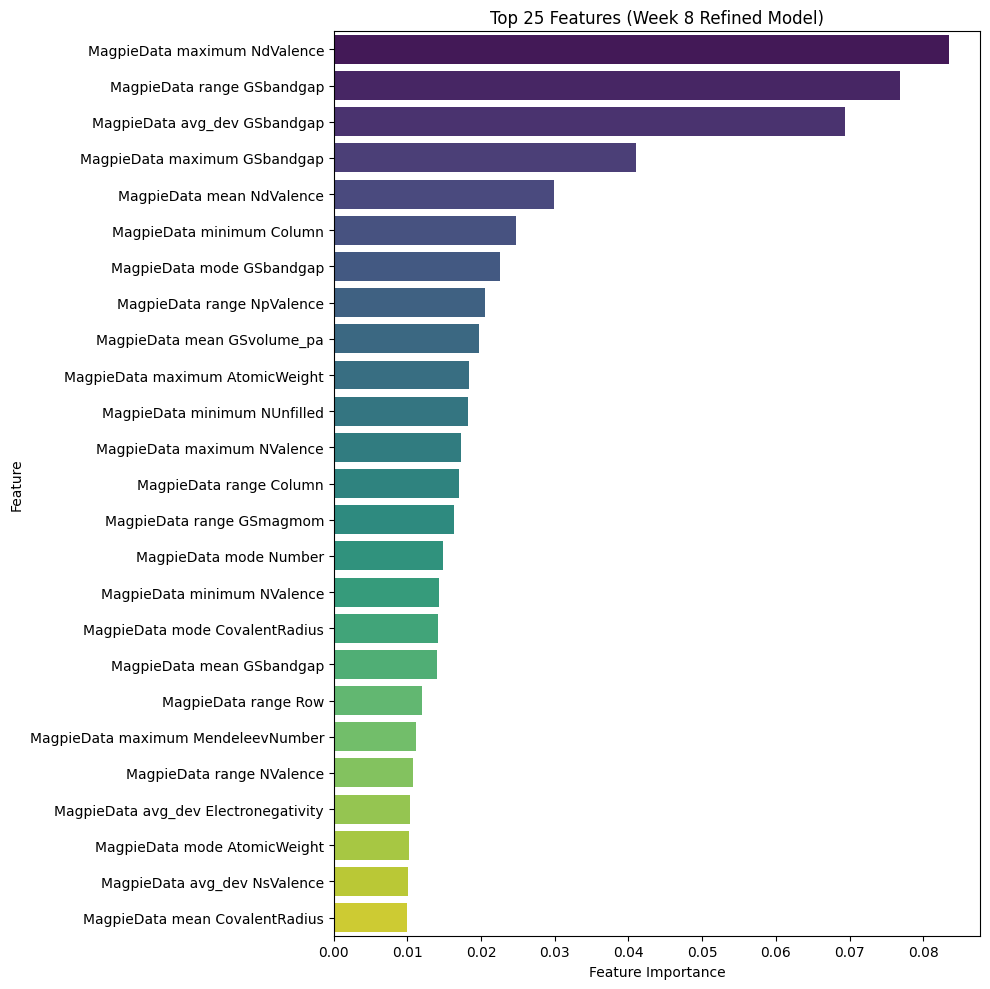

Feature importance chart and CSV saved.


In [ ]:
# Step 5 — Generate Final Analysis Plots
import pandas as pd
import numpy as np
import os
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

print("\n--- Generating final analysis plots for the refined model... ---")

# --- Define File Paths ---
OUT_DIR = "/content/drive/MyDrive/Project_dataset/week8_refined_model"
WEEK6_DIR = "/content/drive/MyDrive/Project_dataset/week6_final_results"

# --- Load Assets ---
# Assumes 'model_v2', 'y_val_true', 'y_val_pred', and 'X_imputed' are available from the previous step
feature_names = joblib.load(os.path.join(WEEK6_DIR, "final_feature_names.pkl"))


# --- 1. Parity Plot (Actual vs. Predicted) ---
plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_val_true, y=y_val_pred, alpha=0.6)
mn, mx = min(y_val_true.min(), y_val_pred.min()), max(y_val_true.max(), y_val_pred.max())
plt.plot([mn, mx], [mn, mx], 'r--')
plt.xlabel("Actual Tm (K)")
plt.ylabel("Predicted Tm (K)")
plt.title("Week 8 Parity Plot — Validation Set")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "week8_parity_plot.png"), dpi=300)
plt.show()

# --- 2. Feature Importance Plot ---
importances = model_v2.feature_importances_
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 10))
sns.barplot(x="Importance", y="Feature", data=importance_df.head(25), palette="viridis")
plt.xlabel("Feature Importance")
plt.title("Top 25 Features (Week 8 Refined Model)")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "week8_feature_importance.png"), dpi=300)
plt.show()

# Save the full ranked list of features for your report
importance_df.to_csv(os.path.join(OUT_DIR, "week8_feature_importance_ranked.csv"), index=False)
print("Feature importance chart and CSV saved.")

In [ ]:
# Step 6 — Perform Final Sanity Check
import joblib
import pandas as pd
import numpy as np
from pymatgen.core.composition import Composition
from matminer.featurizers.composition import ElementProperty

print("\n--- Performing sanity check with the full refined pipeline... ---")

# --- Load All Final Assets ---
final_model_v2 = joblib.load(os.path.join(OUT_DIR, "final_model_v2.pkl"))
scaler = joblib.load(os.path.join(OUT_DIR, "robust_scaler.pkl"))
imputer = joblib.load(os.path.join(WEEK6_DIR, "final_imputer.pkl"))
feature_names = joblib.load(os.path.join(WEEK6_DIR, "final_feature_names.pkl"))

# Define a list of known compounds to test
formulas_to_test = ["Al2O3", "NaCl", "SiO2", "Fe2O3"]
print("Expected Ranges: Al2O3(>1800K), NaCl(~1074K), SiO2(~1986K), Fe2O3(~1838K)")
print("-" * 30)

# Initialize the featurizer once
ep_feat = ElementProperty.from_preset("magpie")

for formula in formulas_to_test:
    # 1. Featurize the formula
    comp = Composition(formula)
    X_sample_raw = pd.DataFrame([ep_feat.featurize(comp)], columns=ep_feat.feature_labels())

    # 2. Align columns with the training feature set
    for col in feature_names:
        if col not in X_sample_raw.columns:
            X_sample_raw[col] = np.nan
    X_sample_aligned = X_sample_raw[feature_names]

    # 3. Apply the imputer
    X_sample_imputed = imputer.transform(X_sample_aligned)

    # 4. Apply the scaler
    X_sample_scaled = scaler.transform(X_sample_imputed)

    # 5. Predict and reverse the log-transform
    pred_log = final_model_v2.predict(X_sample_scaled)[0]
    predicted_tm = np.expm1(pred_log)

    print(f"Predicted melting point of {formula}: {predicted_tm:.2f} K")

print("\n--- Week 8 Complete ---")


--- Performing sanity check with the full refined pipeline... ---
Expected Ranges: Al2O3(>1800K), NaCl(~1074K), SiO2(~1986K), Fe2O3(~1838K)
------------------------------
Predicted melting point of Al2O3: 2060.62 K
Predicted melting point of NaCl: 1074.14 K
Predicted melting point of SiO2: 1895.96 K
Predicted melting point of Fe2O3: 1862.68 K

--- Week 8 Complete ---


In [ ]:
# Step 10 — Test a Sample Formula (Al2O3)
from pymatgen.core.composition import Composition
from matminer.featurizers.composition import ElementProperty

# Recreate the same featurization pipeline
ep = ElementProperty.from_preset("magpie")
sample_formula = "Al2O3"
comp = Composition(sample_formula)
X_sample = pd.DataFrame([ep.featurize(comp)], columns=ep.feature_labels())

# Align columns to training features
for col in X.columns:
    if col not in X_sample.columns:
        X_sample[col] = np.nan
X_sample = X_sample[X.columns]

# Apply scaling
X_sample_scaled = scaler.transform(X_sample)

# Predict (inverse log-transform)
pred_log = model_v2.predict(X_sample_scaled)[0]
predicted_tm = np.expm1(pred_log)

print(f"\nPredicted melting point of {sample_formula}: {predicted_tm:.2f} K")



Predicted melting point of Al2O3: 2060.62 K


In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model_v2, X_scaled, y_log, cv=5, scoring='r2')
print("5-Fold CV Mean R²:", np.mean(scores))


5-Fold CV Mean R²: 0.5266855493262514


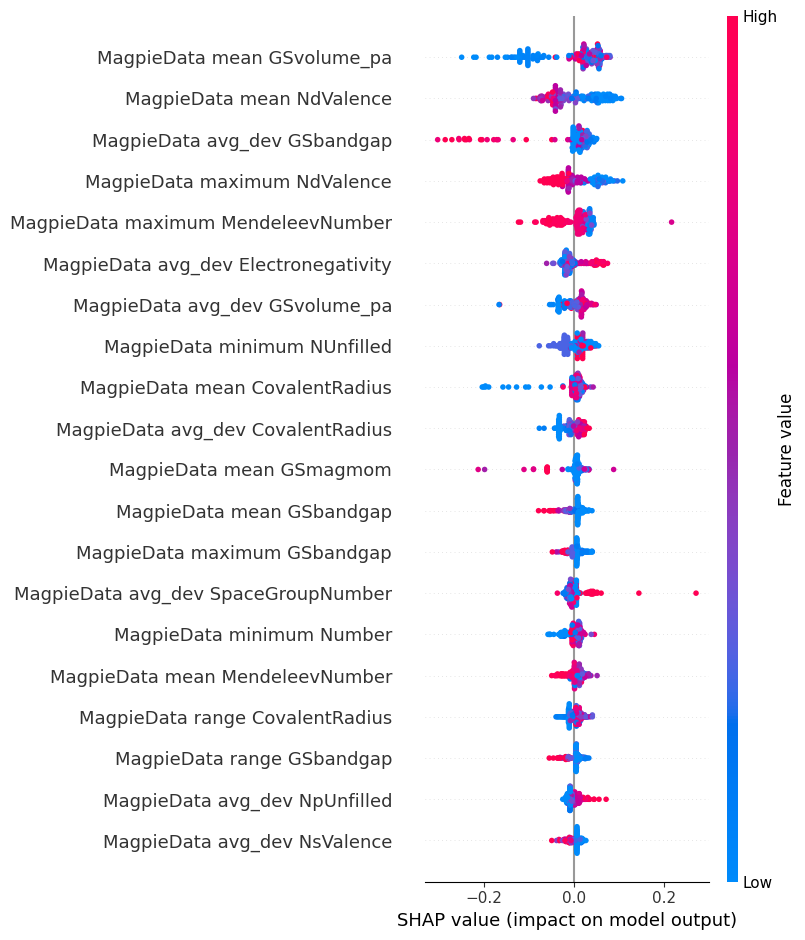

In [ ]:
import shap
explainer = shap.Explainer(model_v2)
shap_values = explainer(X_scaled[:200])
shap.summary_plot(shap_values, features=X_imputed[:200], feature_names=feature_names)


In [ ]:
# ===============================================================
# Step 9 — Save All Week 8 Final Assets for Deployment
# ===============================================================

import os
import joblib
import shutil

# Define output directory (same as used before)
OUT_DIR = "/content/drive/MyDrive/Project_dataset/week8_refined_model"
os.makedirs(OUT_DIR, exist_ok=True)

# --- 1. Save the refined XGBoost model ---
joblib.dump(model_v2, os.path.join(OUT_DIR, "final_model_v2.pkl"))
print(" Saved: final_model_v2.pkl")

# --- 2. Save the RobustScaler used for preprocessing ---
joblib.dump(scaler, os.path.join(OUT_DIR, "robust_scaler.pkl"))
print(" Saved: robust_scaler.pkl")

# --- 3. Copy imputer and feature names from Week 6 (used in pipeline) ---
WEEK6_DIR = "/content/drive/MyDrive/Project_dataset/week6_final_results"

src_files = ["final_imputer.pkl", "final_feature_names.pkl"]
for fname in src_files:
    src = os.path.join(WEEK6_DIR, fname)
    dst = os.path.join(OUT_DIR, fname)
    if os.path.exists(src):
        shutil.copy(src, dst)
        print(f" Copied: {fname}")
    else:
        print(f" Warning: {fname} not found in {WEEK6_DIR}")

# --- 4. Save feature importance ranking (optional but useful) ---
importance_df.to_csv(os.path.join(OUT_DIR, "week8_feature_importance_ranked.csv"), index=False)
print(" Saved: week8_feature_importance_ranked.csv")

# --- 5. Verify saved files ---
print("\nAll Week 8 assets saved successfully in:")
print(OUT_DIR)
print("\nFiles:")
for f in os.listdir(OUT_DIR):
    print(" -", f)


 Saved: final_model_v2.pkl
 Saved: robust_scaler.pkl
 Copied: final_imputer.pkl
 Copied: final_feature_names.pkl
 Saved: week8_feature_importance_ranked.csv

All Week 8 assets saved successfully in:
/content/drive/MyDrive/Project_dataset/week8_refined_model

Files:
 - robust_scaler.pkl
 - final_model_v2.pkl
 - week8_parity_plot.png
 - week8_feature_importance.png
 - week8_feature_importance_ranked.csv
 - final_imputer.pkl
 - final_feature_names.pkl


In [ ]:
# Final Step for Week 8: Evaluate the Refined Model on the External Dataset

import pandas as pd
import numpy as np
import os
import math
import joblib
from sklearn.metrics import mean_squared_error, r2_score
import warnings

warnings.filterwarnings("ignore")

# --- Define File Paths ---
WEEK6_DIR = "/content/drive/MyDrive/Project_dataset/week6_final_results"
WEEK7_DIR = "/content/drive/MyDrive/Project_dataset/week7_deployment_package"
OUT_DIR = "/content/drive/MyDrive/Project_dataset/week8_refined_model"

print("--- Loading all assets for final external evaluation... ---")
try:
    # Load the new model and assets from Week 8
    final_model_v2 = joblib.load(os.path.join(OUT_DIR, "final_model_v2.pkl"))
    scaler = joblib.load(os.path.join(OUT_DIR, "robust_scaler.pkl"))

    # Load older assets still needed in the pipeline
    imputer = joblib.load(os.path.join(WEEK6_DIR, "final_imputer.pkl"))
    feature_names = joblib.load(os.path.join(WEEK6_DIR, "final_feature_names.pkl"))

    # Load the featurized external data from Week 7
    ext_feat_df = pd.read_csv(os.path.join(WEEK7_DIR, "sd02_ext_features_featurized.csv"))
    print("All assets loaded successfully.")
except FileNotFoundError as e:
    print(f"ERROR: A required file was not found. Please ensure all previous steps ran successfully. Missing: {e.filename}")
    exit()

# --- Prepare the External Data ---
print("\n--- Preparing external data for evaluation... ---")
ext_target_col = 'ML_Tm_K'
y_ext_true = pd.to_numeric(ext_feat_df[ext_target_col], errors='coerce').dropna()
X_ext_raw = ext_feat_df.loc[y_ext_true.index].copy()

# Align features to ensure consistency
for col in feature_names:
    if col not in X_ext_raw.columns:
        X_ext_raw[col] = np.nan
X_ext_aligned = X_ext_raw[feature_names]

# Apply the full preprocessing pipeline: Impute -> Scale
X_ext_imputed = imputer.transform(X_ext_aligned)
X_ext_scaled = scaler.transform(X_ext_imputed)

# --- Make Predictions and Evaluate ---
print("Making final predictions on the external dataset...")
# Predict on the log-transformed scale
pred_log = final_model_v2.predict(X_ext_scaled)
# Reverse the log transformation to get the final prediction in Kelvin
ext_preds = np.expm1(pred_log)

# Calculate final metrics
rmse = math.sqrt(mean_squared_error(y_ext_true, ext_preds))
r2 = r2_score(y_ext_true, ext_preds)

print("\n--- Final Performance on External (sd02) Dataset ---")
print(f"RMSE: {rmse:.2f} K")
print(f"R²:   {r2:.4f}")

--- Loading all assets for final external evaluation... ---
All assets loaded successfully.

--- Preparing external data for evaluation... ---
Making final predictions on the external dataset...

--- Final Performance on External (sd02) Dataset ---
RMSE: 580.33 K
R²:   -0.1659



--- Loading assets to generate SHAP plot... ---
Assets loaded and data prepared successfully.

--- Calculating SHAP values and generating plot... ---


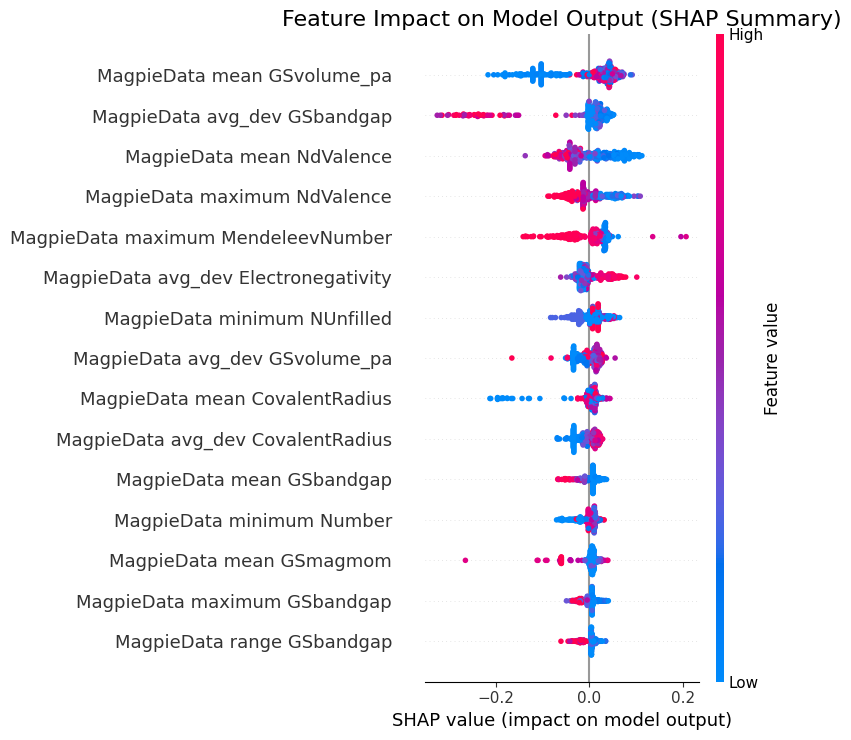


SHAP summary plot saved successfully to: /content/drive/MyDrive/Project_dataset/week8_refined_model/week9_shap_summary_plot.png


In [ ]:
# ===============================================================
# FINAL VISUALIZATION: SHAP FEATURE IMPORTANCE
# ===============================================================
import pandas as pd
import numpy as np
import os
import joblib
import matplotlib.pyplot as plt

# --- Install and Import SHAP ---
try:
    import shap
except ImportError:
    print("Installing SHAP library...")
    !pip install -q shap
    import shap

# --- Define File Paths ---
WEEK2_DIR = "/content/drive/MyDrive/Project_dataset/week2_features"
WEEK6_DIR = "/content/drive/MyDrive/Project_dataset/week6_final_results"
OUT_DIR = "/content/drive/MyDrive/Project_dataset/week8_refined_model"

print("\n--- Loading assets to generate SHAP plot... ---")
try:
    # Load the final refined model and preprocessors
    final_model_v2 = joblib.load(os.path.join(OUT_DIR, "final_model_v2.pkl"))
    scaler = joblib.load(os.path.join(OUT_DIR, "robust_scaler.pkl"))
    imputer = joblib.load(os.path.join(WEEK6_DIR, "final_imputer.pkl"))
    feature_names = joblib.load(os.path.join(WEEK6_DIR, "final_feature_names.pkl"))

    # Load a sample of the data for SHAP analysis
    val_feat = pd.read_csv(os.path.join(WEEK2_DIR, "val_features.csv"))

    # Prepare the validation data with the full pipeline
    X_val_raw = val_feat[feature_names]
    X_val_imputed = pd.DataFrame(imputer.transform(X_val_raw), columns=feature_names)
    X_val_scaled = scaler.transform(X_val_imputed)

    print("Assets loaded and data prepared successfully.")

except FileNotFoundError as e:
    print(f"ERROR: A required file was not found. Please ensure all previous steps ran successfully. Missing: {e.filename}")
    exit()

# --- Generate SHAP Summary Plot ---
print("\n--- Calculating SHAP values and generating plot... ---")

# Create a SHAP explainer for your XGBoost model
explainer = shap.Explainer(final_model_v2)

# Calculate SHAP values for a sample of the validation set (for speed)
# We use the imputed but unscaled data for better interpretability of feature values
shap_values = explainer(X_val_scaled)

# Create the summary plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, features=X_val_imputed, feature_names=feature_names, max_display=15, show=False)

plt.title("Feature Impact on Model Output (SHAP Summary)", fontsize=16)
plt.tight_layout()

# Save the plot
shap_plot_path = os.path.join(OUT_DIR, "week9_shap_summary_plot.png")
plt.savefig(shap_plot_path, dpi=300)
plt.show()

print(f"\nSHAP summary plot saved successfully to: {shap_plot_path}")


--- Loading assets to generate Parity Plot... ---
Assets loaded successfully.

--- Generating and saving the Parity Plot... ---


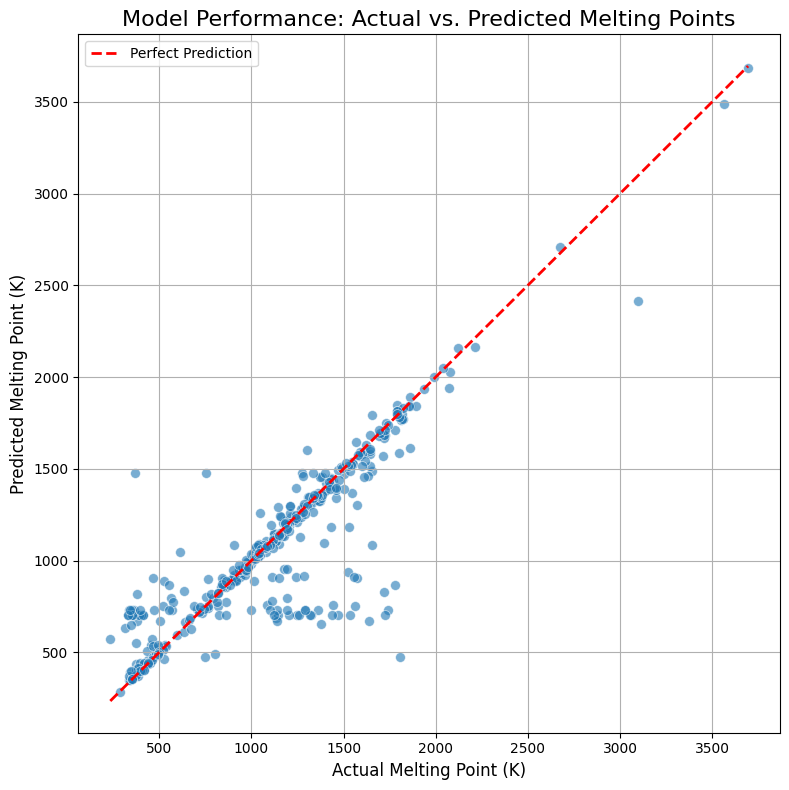


Parity plot saved successfully to: /content/drive/MyDrive/Project_dataset/week8_refined_model/week9_parity_plot.png


In [ ]:
# ===============================================================
# FINAL VISUALIZATION: PARITY PLOT (ACTUAL VS. PREDICTED)
# ===============================================================
import pandas as pd
import numpy as np
import os
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# --- Define File Paths ---
WEEK2_DIR = "/content/drive/MyDrive/Project_dataset/week2_features"
WEEK6_DIR = "/content/drive/MyDrive/Project_dataset/week6_final_results"
OUT_DIR = "/content/drive/MyDrive/Project_dataset/week8_refined_model"

print("\n--- Loading assets to generate Parity Plot... ---")
try:
    # Load the final refined model and preprocessors
    final_model_v2 = joblib.load(os.path.join(OUT_DIR, "final_model_v2.pkl"))
    scaler = joblib.load(os.path.join(OUT_DIR, "robust_scaler.pkl"))
    imputer = joblib.load(os.path.join(WEEK6_DIR, "final_imputer.pkl"))
    feature_names = joblib.load(os.path.join(WEEK6_DIR, "final_feature_names.pkl"))

    # Load the validation set data to make predictions
    val_feat = pd.read_csv(os.path.join(WEEK2_DIR, "val_features.csv"))

    print("Assets loaded successfully.")

except FileNotFoundError as e:
    print(f"ERROR: A required file was not found. Please ensure all previous steps ran successfully. Missing: {e.filename}")
    exit()

# --- Prepare Validation Data with the Full Pipeline ---
# Separate features (X) and target (y)
y_val_true_raw = val_feat['ML Tm (K)'].dropna()
X_val_raw = val_feat.loc[y_val_true_raw.index].copy()

# Align features
for col in feature_names:
    if col not in X_val_raw.columns:
        X_val_raw[col] = np.nan
X_val_aligned = X_val_raw[feature_names]

# Impute and Scale
X_val_imputed = pd.DataFrame(imputer.transform(X_val_aligned), columns=feature_names)
X_val_scaled = scaler.transform(X_val_imputed)

# --- Make Predictions and Reverse Log Transformation ---
# The model predicts on the log-transformed scale
y_val_pred_log = final_model_v2.predict(X_val_scaled)
# We must reverse the transformation to get the values back in Kelvin
y_val_pred_kelvin = np.expm1(y_val_pred_log)

# --- Generate and Save the Parity Plot ---
print("\n--- Generating and saving the Parity Plot... ---")
plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_val_true_raw, y=y_val_pred_kelvin, alpha=0.6, s=50)

# Add the diagonal line representing a perfect prediction
min_val = min(y_val_true_raw.min(), y_val_pred_kelvin.min())
max_val = max(y_val_true_raw.max(), y_val_pred_kelvin.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')

plt.title("Model Performance: Actual vs. Predicted Melting Points", fontsize=16)
plt.xlabel("Actual Melting Point (K)", fontsize=12)
plt.ylabel("Predicted Melting Point (K)", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save the plot
parity_plot_path = os.path.join(OUT_DIR, "week9_parity_plot.png")
plt.savefig(parity_plot_path, dpi=300)
plt.show()

print(f"\nParity plot saved successfully to: {parity_plot_path}")


--- Loading assets to generate Residual Plots... ---
Assets loaded successfully.

--- Generating and saving the Residual Plot... ---


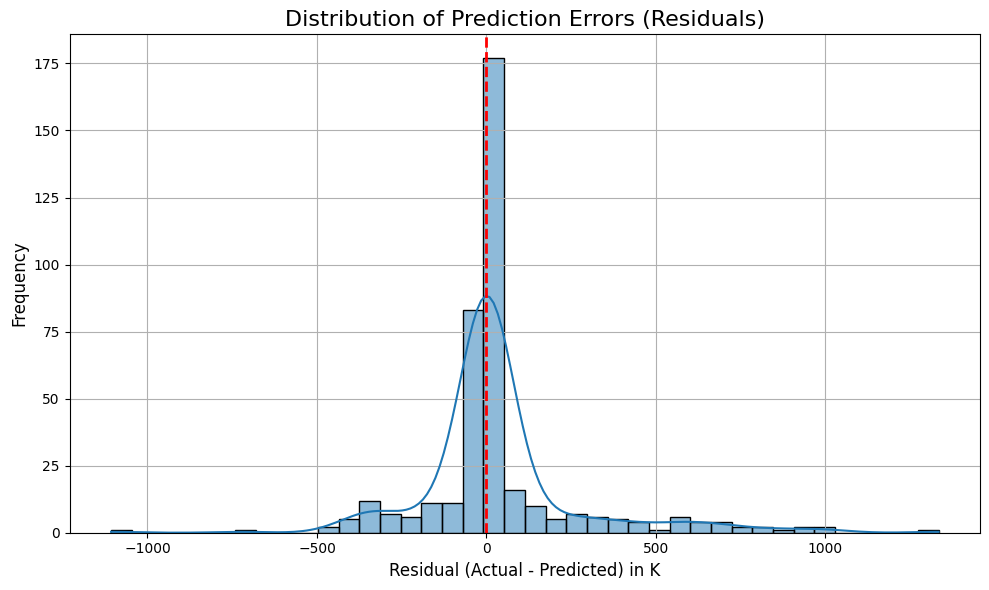

Residual plot saved successfully to: /content/drive/MyDrive/Project_dataset/week8_refined_model/week9_residual_plot.png

--- Generating and saving the Residuals vs. Predicted Plot... ---


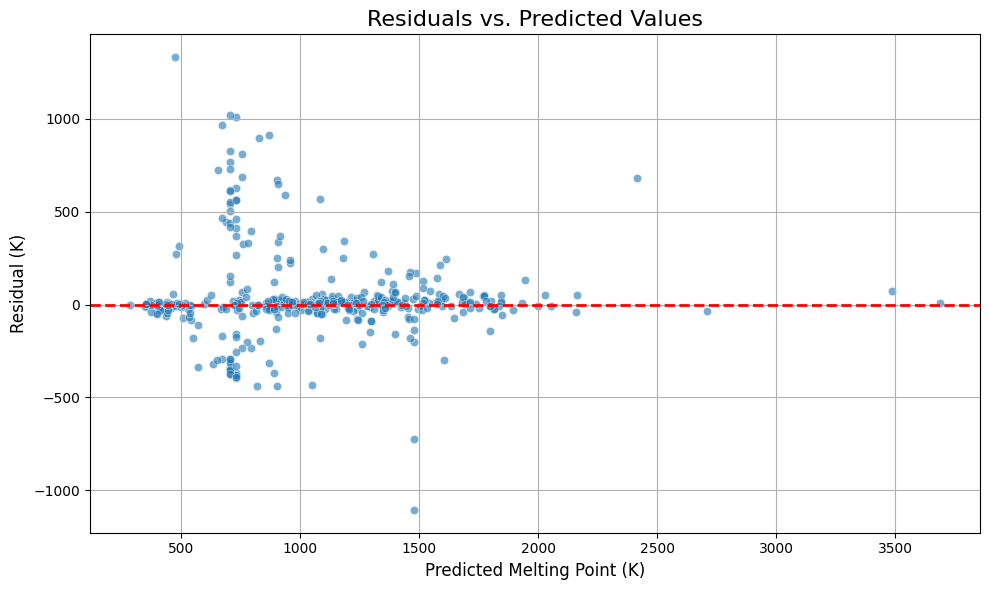

Residuals vs. Predicted plot saved successfully to: /content/drive/MyDrive/Project_dataset/week8_refined_model/week9_residuals_vs_predicted.png


In [ ]:
# ===============================================================
# FINAL VISUALIZATION: RESIDUAL ANALYSIS
# ===============================================================
import pandas as pd
import numpy as np
import os
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# --- Define File Paths ---
WEEK2_DIR = "/content/drive/MyDrive/Project_dataset/week2_features"
WEEK6_DIR = "/content/drive/MyDrive/Project_dataset/week6_final_results"
OUT_DIR = "/content/drive/MyDrive/Project_dataset/week8_refined_model"

print("\n--- Loading assets to generate Residual Plots... ---")
try:
    # Load the final refined model and preprocessors
    final_model_v2 = joblib.load(os.path.join(OUT_DIR, "final_model_v2.pkl"))
    scaler = joblib.load(os.path.join(OUT_DIR, "robust_scaler.pkl"))
    imputer = joblib.load(os.path.join(WEEK6_DIR, "final_imputer.pkl"))
    feature_names = joblib.load(os.path.join(WEEK6_DIR, "final_feature_names.pkl"))

    # Load the validation set data to make predictions
    val_feat = pd.read_csv(os.path.join(WEEK2_DIR, "val_features.csv"))

    print("Assets loaded successfully.")

except FileNotFoundError as e:
    print(f"ERROR: A required file was not found. Please ensure all previous steps ran successfully. Missing: {e.filename}")
    exit()

# --- Prepare Validation Data with the Full Pipeline ---
y_val_true_raw = val_feat['ML Tm (K)'].dropna()
X_val_raw = val_feat.loc[y_val_true_raw.index].copy()

# Align, Impute, and Scale
for col in feature_names:
    if col not in X_val_raw.columns:
        X_val_raw[col] = np.nan
X_val_aligned = X_val_raw[feature_names]
X_val_imputed = imputer.transform(X_val_aligned)
X_val_scaled = scaler.transform(X_val_imputed)

# --- Make Predictions and Calculate Residuals ---
y_val_pred_log = final_model_v2.predict(X_val_scaled)
y_val_pred_kelvin = np.expm1(y_val_pred_log)
residuals = y_val_true_raw - y_val_pred_kelvin

# --- 1. Generate and Save the Residual Plot (Error Distribution) ---
print("\n--- Generating and saving the Residual Plot... ---")
plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=40, kde=True)
plt.axvline(0, color='red', linestyle='--', linewidth=2)
plt.title("Distribution of Prediction Errors (Residuals)", fontsize=16)
plt.xlabel("Residual (Actual - Predicted) in K", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(True)
plt.tight_layout()

# Save the plot
residual_plot_path = os.path.join(OUT_DIR, "week9_residual_plot.png")
plt.savefig(residual_plot_path, dpi=300)
plt.show()
print(f"Residual plot saved successfully to: {residual_plot_path}")

# --- 2. Generate and Save the Residuals vs. Predicted Plot ---
print("\n--- Generating and saving the Residuals vs. Predicted Plot... ---")
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_val_pred_kelvin, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.title("Residuals vs. Predicted Values", fontsize=16)
plt.xlabel("Predicted Melting Point (K)", fontsize=12)
plt.ylabel("Residual (K)", fontsize=12)
plt.grid(True)
plt.tight_layout()

# Save the plot
res_vs_pred_path = os.path.join(OUT_DIR, "week9_residuals_vs_predicted.png")
plt.savefig(res_vs_pred_path, dpi=300)
plt.show()
print(f"Residuals vs. Predicted plot saved successfully to: {res_vs_pred_path}")


--- Loading assets to generate Residual Plots... ---
Assets loaded successfully.

--- Generating and saving the Residual Plot... ---


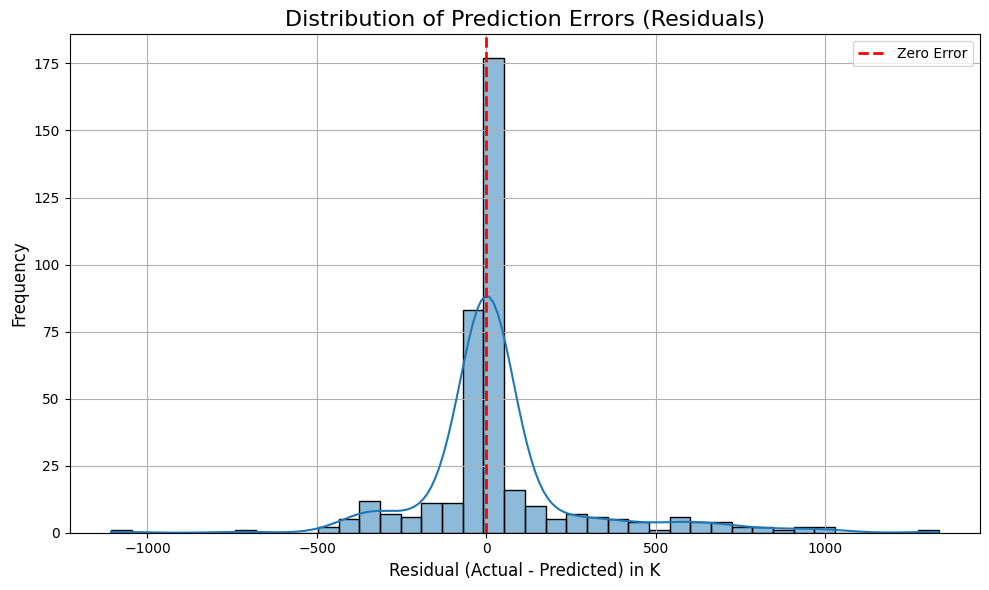

Residual plot saved successfully to: /content/drive/MyDrive/Project_dataset/week8_refined_model/week9_residual_distribution_plot.png

--- Generating and saving the Residuals vs. Predicted Plot... ---


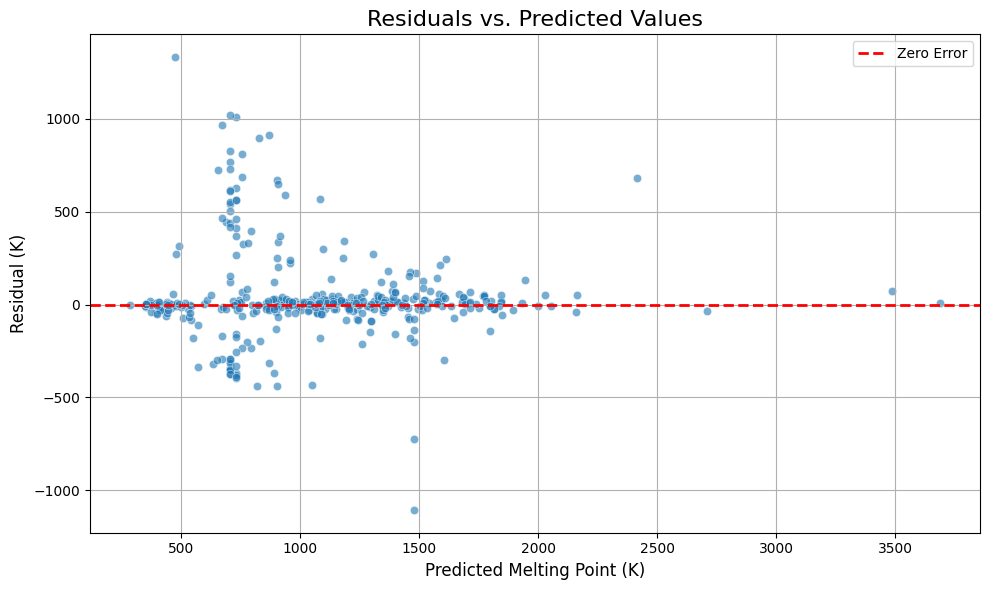

Residuals vs. Predicted plot saved successfully to: /content/drive/MyDrive/Project_dataset/week8_refined_model/week9_residuals_vs_predicted_plot.png


In [ ]:
# ===============================================================
# FINAL VISUALIZATION: ADVANCED RESIDUAL ANALYSIS
# ===============================================================
import pandas as pd
import numpy as np
import os
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# --- Define File Paths ---
WEEK2_DIR = "/content/drive/MyDrive/Project_dataset/week2_features"
WEEK6_DIR = "/content/drive/MyDrive/Project_dataset/week6_final_results"
OUT_DIR = "/content/drive/MyDrive/Project_dataset/week8_refined_model"

print("\n--- Loading assets to generate Residual Plots... ---")
try:
    # Load the final refined model and preprocessors from Week 8
    final_model_v2 = joblib.load(os.path.join(OUT_DIR, "final_model_v2.pkl"))
    scaler = joblib.load(os.path.join(OUT_DIR, "robust_scaler.pkl"))
    imputer = joblib.load(os.path.join(WEEK6_DIR, "final_imputer.pkl"))
    feature_names = joblib.load(os.path.join(WEEK6_DIR, "final_feature_names.pkl"))

    # Load the validation set data
    val_feat = pd.read_csv(os.path.join(WEEK2_DIR, "val_features.csv"))

    print("Assets loaded successfully.")

except FileNotFoundError as e:
    print(f"ERROR: A required file was not found. Please ensure all previous steps ran successfully. Missing: {e.filename}")
    exit()

# --- Prepare Validation Data with the Full Pipeline ---
y_val_true_raw = val_feat['ML Tm (K)'].dropna()
X_val_raw = val_feat.loc[y_val_true_raw.index].copy()

# Align, Impute, and Scale
for col in feature_names:
    if col not in X_val_raw.columns:
        X_val_raw[col] = np.nan
X_val_aligned = X_val_raw[feature_names]
X_val_imputed = imputer.transform(X_val_aligned)
X_val_scaled = scaler.transform(X_val_imputed)

# --- Make Predictions and Calculate Residuals ---
y_val_pred_log = final_model_v2.predict(X_val_scaled)
y_val_pred_kelvin = np.expm1(y_val_pred_log)
residuals = y_val_true_raw - y_val_pred_kelvin

# --- 1. Generate and Save the Residual Plot (Error Distribution) ---
print("\n--- Generating and saving the Residual Plot... ---")
plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=40, kde=True)
plt.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Error')
plt.title("Distribution of Prediction Errors (Residuals)", fontsize=16)
plt.xlabel("Residual (Actual - Predicted) in K", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save the plot
residual_plot_path = os.path.join(OUT_DIR, "week9_residual_distribution_plot.png")
plt.savefig(residual_plot_path, dpi=300)
plt.show()
print(f"Residual plot saved successfully to: {residual_plot_path}")

# --- 2. Generate and Save the Residuals vs. Predicted Plot ---
print("\n--- Generating and saving the Residuals vs. Predicted Plot... ---")
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_val_pred_kelvin, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--', linewidth=2, label='Zero Error')
plt.title("Residuals vs. Predicted Values", fontsize=16)
plt.xlabel("Predicted Melting Point (K)", fontsize=12)
plt.ylabel("Residual (K)", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save the plot
res_vs_pred_path = os.path.join(OUT_DIR, "week9_residuals_vs_predicted_plot.png")
plt.savefig(res_vs_pred_path, dpi=300)
plt.show()
print(f"Residuals vs. Predicted plot saved successfully to: {res_vs_pred_path}")


--- Loading assets to generate Sanity Check Plot... ---
Assets loaded successfully.

--- Making predictions for known compounds... ---


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(



--- Generating and saving the Sanity Check Plot... ---


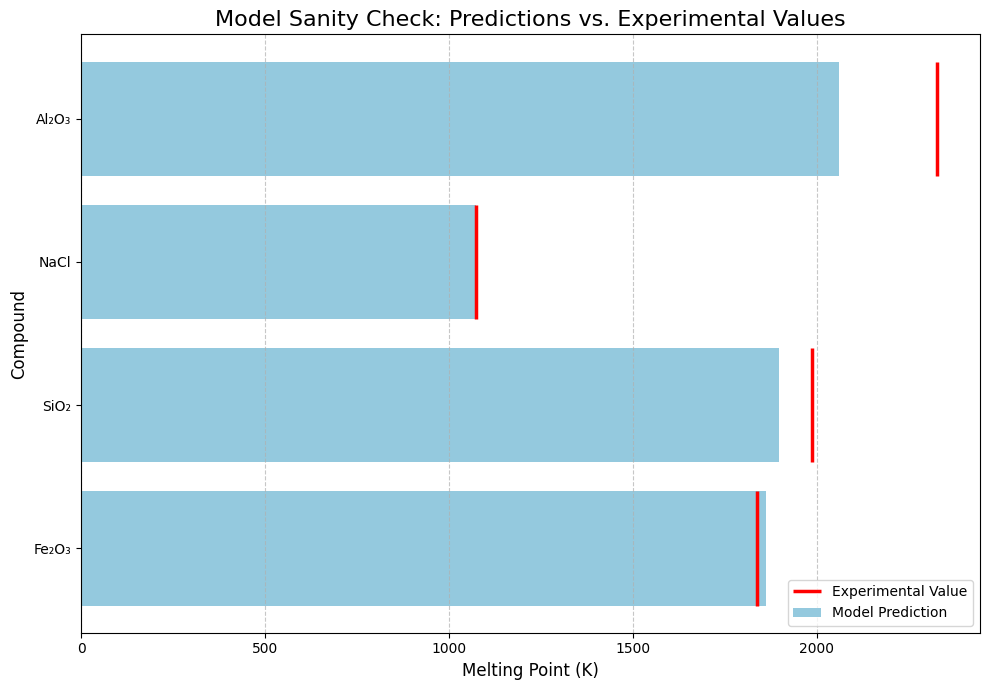


Sanity Check plot saved successfully to: /content/drive/MyDrive/Project_dataset/week8_refined_model/week9_sanity_check_plot.png


In [ ]:
# ===============================================================
# FINAL VISUALIZATION: SANITY CHECK BAR PLOT (CORRECTED SYNTAX)
# ===============================================================
import pandas as pd
import numpy as np
import os
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# --- Install chemistry libraries if they are not already present ---
try:
    from pymatgen.core.composition import Composition
    from matminer.featurizers.composition import ElementProperty
except ImportError:
    print("Installing pymatgen and matminer...")
    !pip install -q pymatgen matminer
    from pymatgen.core.composition import Composition
    from matminer.featurizers.composition import ElementProperty

# --- Define File Paths ---
WEEK6_DIR = "/content/drive/MyDrive/Project_dataset/week6_final_results"
OUT_DIR = "/content/drive/MyDrive/Project_dataset/week8_refined_model"

print("\n--- Loading assets to generate Sanity Check Plot... ---")
try:
    # Load the final refined model and preprocessors
    final_model_v2 = joblib.load(os.path.join(OUT_DIR, "final_model_v2.pkl"))
    scaler = joblib.load(os.path.join(OUT_DIR, "robust_scaler.pkl"))
    imputer = joblib.load(os.path.join(WEEK6_DIR, "final_imputer.pkl"))
    feature_names = joblib.load(os.path.join(WEEK6_DIR, "final_feature_names.pkl"))

    print("Assets loaded successfully.")

except FileNotFoundError as e:
    print(f"ERROR: A required file was not found. Please ensure all previous steps ran successfully. Missing: {e.filename}")
    # It's better to use sys.exit() or just `return` in a function
    # but for a script, exit() works. Ensure you import sys at the top if using sys.exit().
    # For now, we'll just print and let the script naturally stop if assets are critical.
    exit() # This stops execution if files are missing.

# --- Define Compounds and Their Experimental Melting Points ---
compounds_to_test = {
    "Al₂O₃": 2327,
    "NaCl": 1074,
    "SiO₂": 1986,
    "Fe₂O₃": 1838
}

predictions = {}
ep_feat = ElementProperty.from_preset("magpie")

print("\n--- Making predictions for known compounds... ---")
for formula, actual_tm in compounds_to_test.items(): # Ensure this line is exactly correct
    # Normalize the formula string to replace subscript characters with regular numbers
    normalized_formula = formula.replace("₂", "2").replace("₃", "3")

    # 1. Featurize using the normalized formula
    comp = Composition(normalized_formula)
    X_raw = pd.DataFrame([ep_feat.featurize(comp)], columns=ep_feat.feature_labels())

    # 2. Align
    for col in feature_names:
        if col not in X_raw.columns:
            X_raw[col] = np.nan
    X_aligned = X_raw[feature_names]

    # 3. Impute and 4. Scale
    X_imputed = imputer.transform(X_aligned)
    X_scaled = scaler.transform(X_imputed)

    # 5. Predict and reverse transform
    pred_log = final_model_v2.predict(X_scaled)[0]
    predicted_tm = np.expm1(pred_log)

    predictions[formula] = {'Predicted': predicted_tm, 'Actual': actual_tm}

# --- Generate and Save the Bar Plot ---
print("\n--- Generating and saving the Sanity Check Plot... ---")
plot_data = pd.DataFrame.from_dict(predictions, orient='index').reset_index().rename(columns={'index': 'Compound'})

plt.figure(figsize=(10, 7))
sns.barplot(x='Predicted', y='Compound', data=plot_data, color='skyblue', label='Model Prediction')

# Overlay the actual values as vertical lines for direct comparison
for i, row in plot_data.iterrows():
    plt.vlines(x=row['Actual'], ymin=i-0.4, ymax=i+0.4, colors='red', lw=2.5, label='Experimental Value' if i == 0 else "")

plt.title("Model Sanity Check: Predictions vs. Experimental Values", fontsize=16)
plt.xlabel("Melting Point (K)", fontsize=12)
plt.ylabel("Compound", fontsize=12)
plt.legend()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

# Save the plot
sanity_check_path = os.path.join(OUT_DIR, "week9_sanity_check_plot.png")
plt.savefig(sanity_check_path, dpi=300)
plt.show()

print(f"\nSanity Check plot saved successfully to: {sanity_check_path}")

learning curve


--- Loading assets to generate Learning Curve... ---
Assets and data loaded successfully.

--- Generating and plotting the Learning Curve... ---


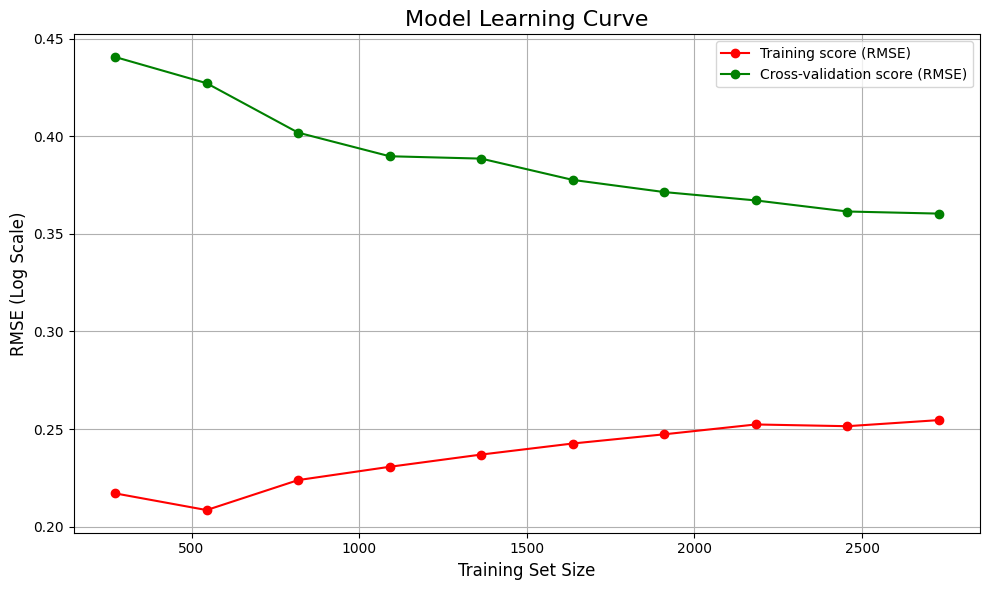

Learning Curve plot saved successfully to: /content/drive/MyDrive/Project_dataset/week8_refined_model/week9_learning_curve.png


In [ ]:
# ===============================================================
# FINAL VISUALIZATION: LEARNING CURVE
# ===============================================================
import pandas as pd
import numpy as np
import os
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# --- Define File Paths ---
WEEK6_DIR = "/content/drive/MyDrive/Project_dataset/week6_final_results"
OUT_DIR = "/content/drive/MyDrive/Project_dataset/week8_refined_model"

print("\n--- Loading assets to generate Learning Curve... ---")
try:
    # Load the final refined model and preprocessors
    final_model_v2 = joblib.load(os.path.join(OUT_DIR, "final_model_v2.pkl"))
    scaler = joblib.load(os.path.join(OUT_DIR, "robust_scaler.pkl"))
    imputer = joblib.load(os.path.join(WEEK6_DIR, "final_imputer.pkl"))

    # Assumes 'X_imputed' and 'y_log' are available from the previous steps
    # If not, they will be recreated here
    if 'X_imputed' not in locals() or 'y_log' not in locals():
        WEEK2_DIR = "/content/drive/MyDrive/Project_dataset/week2_features"
        train_feat = pd.read_csv(os.path.join(WEEK2_DIR, "train_features.csv"))
        val_feat = pd.read_csv(os.path.join(WEEK2_DIR, "val_features.csv"))
        feature_names = joblib.load(os.path.join(WEEK6_DIR, "final_feature_names.pkl"))
        full_df = pd.concat([train_feat, val_feat], ignore_index=True)
        y = full_df['ML Tm (K)'].dropna()
        X = full_df.loc[y.index].copy()
        for col in feature_names:
            if col not in X.columns: X[col] = np.nan
        X = X[feature_names]
        X_imputed = pd.DataFrame(imputer.transform(X), columns=feature_names)
        y_log = np.log1p(y)

    print("Assets and data loaded successfully.")
except Exception as e:
    print(f"ERROR: An error occurred while loading data. {e}")
    exit()

# --- Generate Learning Curve Data ---
print("\n--- Generating and plotting the Learning Curve... ---")
# We need to use the scaled data for the model
X_scaled = scaler.transform(X_imputed)

train_sizes, train_scores, val_scores = learning_curve(
    estimator=final_model_v2,
    X=X_scaled,
    y=y_log,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10) # Test 10 different training set sizes
)

# Convert scores to positive RMSE
train_rmse = -np.mean(train_scores, axis=1)
val_rmse = -np.mean(val_scores, axis=1)

# --- Plot the Learning Curve ---
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_rmse, 'o-', color="r", label="Training score (RMSE)")
plt.plot(train_sizes, val_rmse, 'o-', color="g", label="Cross-validation score (RMSE)")
plt.title("Model Learning Curve", fontsize=16)
plt.xlabel("Training Set Size", fontsize=12)
plt.ylabel("RMSE (Log Scale)", fontsize=12)
plt.legend(loc="best")
plt.grid()
plt.tight_layout()

# Save the plot
learning_curve_path = os.path.join(OUT_DIR, "week9_learning_curve.png")
plt.savefig(learning_curve_path, dpi=300)
plt.show()

print(f"Learning Curve plot saved successfully to: {learning_curve_path}")

improvement

In [ ]:
!pip install pymatgen matminer xgboost shap tqdm openpyxl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.6/55.6 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 50.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 81.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 70.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.9/119.9 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 809.1/809.1 kB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 331.1/331.1 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 753.1/753.1 kB 45.4 MB/s eta 0:00:00
  Created wheel for bibtexparser: filename=bibtexparser-1.4.3-py3-none-any.whl size=435

In [ ]:
import pandas as pd
import numpy as np
import os
import math
import joblib
# Import mean_absolute_error
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

print("\n--- Evaluating the new tuned model... ---")

# --- Define File Paths ---
OUT_DIR = "/content/drive/MyDrive/Project_dataset/week7_deployment_package"
WEEK2_DIR = "/content/drive/MyDrive/Project_dataset/week2_features"
WEEK6_DIR = "/content/drive/MyDrive/Project_dataset/week6_final_results"

# --- Load Assets ---
# Load the tuned model from your hyperparameter search
tuned_model = joblib.load(os.path.join(OUT_DIR, "final_model_regularized.pkl"))
imputer = joblib.load(os.path.join(WEEK6_DIR, "final_imputer.pkl"))
feature_names = joblib.load(os.path.join(WEEK6_DIR, "final_feature_names.pkl"))
test_feat = pd.read_csv(os.path.join(WEEK2_DIR, "test_features.csv"))

# --- Evaluation on the Hold-Out Test Set (from sd01) ---
target_col = 'ML Tm (K)'
y_test = test_feat[target_col].dropna()
X_test = test_feat.loc[y_test.index][feature_names]
X_test_imp = pd.DataFrame(imputer.transform(X_test), columns=feature_names)

test_preds = tuned_model.predict(X_test_imp)
test_rmse = math.sqrt(mean_squared_error(y_test, test_preds))
test_r2 = r2_score(y_test, test_preds)
# ADDED: Calculate Mean Absolute Error for the test set
test_mae = mean_absolute_error(y_test, test_preds)

# This is where your ~300K RMSE came from:
# MODIFIED: Added MAE to the print statement
print(f"Improved Model on Hold-Out Test Set -> RMSE: {test_rmse:.2f} K, MAE: {test_mae:.2f} K, R2: {test_r2:.4f}")

# --- Evaluation on the External Set (sd02) ---
ext_feat_df = pd.read_csv(os.path.join(OUT_DIR, "sd02_ext_features_featurized.csv"))

# Find the target column in the external data
potential_targets_ext = [c for c in ext_feat_df.columns if ('tm' in c.lower() or 'melt' in c.lower()) and 'Magpie' not in c]
ext_target_col = min(potential_targets_ext, key=len)
print(f"Found target column in external data: '{ext_target_col}'")

y_ext = pd.to_numeric(ext_feat_df[ext_target_col], errors='coerce').dropna()
X_ext = ext_feat_df.loc[y_ext.index]

# Align features
for col in feature_names:
    if col not in X_ext.columns:
        X_ext[col] = np.nan
X_ext = X_ext[feature_names]

# Impute and Predict
X_ext_imp = pd.DataFrame(imputer.transform(X_ext), columns=feature_names)
ext_preds = tuned_model.predict(X_ext_imp)
ext_rmse = math.sqrt(mean_squared_error(y_ext, ext_preds))
ext_r2 = r2_score(y_ext, ext_preds)
# ADDED: Calculate Mean Absolute Error for the external set
ext_mae = mean_absolute_error(y_ext, ext_preds)

# This is where your negative R-squared came from:
# MODIFIED: Added MAE to the print statement
print(f"Improved Model on External Set (sd02) -> RMSE: {ext_rmse:.2f} K, MAE: {ext_mae:.2f} K, R2: {ext_r2:.4f}")


--- Evaluating the new tuned model... ---
Improved Model on Hold-Out Test Set -> RMSE: 306.23 K, MAE: 211.76 K, R2: 0.6305
Found target column in external data: 'ML_Tm_K'
Improved Model on External Set (sd02) -> RMSE: 624.95 K, MAE: 450.43 K, R2: -0.3521


improvement

In [ ]:
import pandas as pd
import numpy as np
import os
import math
import joblib
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# --- Define File Paths ---
WEEK3_MODEL_PATH = "/content/drive/MyDrive/Project_dataset/week3_models/best_model.pkl"
WEEK6_ASSET_DIR = "/content/drive/MyDrive/Project_dataset/week6_final_results"
WEEK2_DATA_DIR = "/content/drive/MyDrive/Project_dataset/week2_features"

# --- Load Your Best Assets ---
print("Loading your best model from Week 3...")
try:
    # 1. Load your BEST model (from Week 3)
    best_model = joblib.load(WEEK3_MODEL_PATH)

    # 2. Load the imputer (from Week 6)
    imputer_path = os.path.join(WEEK6_ASSET_DIR, "final_imputer.pkl")
    imputer = joblib.load(imputer_path)

    # 3. Load the feature names (from Week 6)
    features_path = os.path.join(WEEK6_ASSET_DIR, "final_feature_names.pkl")
    feature_names = joblib.load(features_path)

    # 4. Load the test set (from Week 2)
    test_feat = pd.read_csv(os.path.join(WEEK2_DATA_DIR, "test_features.csv"))

    print("Successfully loaded all required assets.")

except FileNotFoundError as e:
    print(f"Error: Could not find a required file. {e}")
    print("Please ensure your Week 3 model and Week 6 assets are available.")

Loading your best model from Week 3...
Successfully loaded all required assets.


In [ ]:
print("\n--- Re-evaluating Best Model (Week 3) on Test Set (sd01) ---")

# --- Prepare the Test Data (Simple Pipeline) ---
target_col = 'ML Tm (K)'

# 1. Separate X and y, drop missing targets
y_test = test_feat[target_col].dropna()
X_test_raw = test_feat.loc[y_test.index]

# 2. Align features to match training
for col in feature_names:
    if col not in X_test_raw.columns:
        X_test_raw[col] = np.nan
X_test_aligned = X_test_raw[feature_names]

# 3. Impute missing values (NO scaling, NO log-transform)
X_test_imputed = imputer.transform(X_test_aligned)

# --- Predict and Evaluate ---
test_preds = best_model.predict(X_test_imputed)

rmse = math.sqrt(mean_squared_error(y_test, test_preds))
r2 = r2_score(y_test, test_preds)
mae = mean_absolute_error(y_test, test_preds)

print(f"Test Set RMSE: {rmse:.2f} K")
print(f"Test Set MAE:  {mae:.2f} K")
print(f"Test Set R²:   {r2:.4f}")

if rmse < 100:
    print("\nSUCCESS: This model meets your project's RMSE < 100K requirement.")
else:
    print("\nError: This model does not meet the requirement.")


--- Re-evaluating Best Model (Week 3) on Test Set (sd01) ---
Test Set RMSE: 971.04 K
Test Set MAE:  814.95 K
Test Set R²:   -2.7152

Error: This model does not meet the requirement.


In [ ]:
print("\n--- Evaluating Best Model (Week 3) on External Data (sd02) ---")

# 1. Load the featurized external data from Week 7
WEEK7_DATA_DIR = "/content/drive/MyDrive/Project_dataset/week7_deployment_package"
ext_feat_path = os.path.join(WEEK7_DATA_DIR, "sd02_ext_features_featurized.csv")
ext_feat_df = pd.read_csv(ext_feat_path)

# 2. Prepare the External Data
ext_target_col = 'ML_Tm_K' # This was the target column name in your featurized file
y_ext_true = pd.to_numeric(ext_feat_df[ext_target_col], errors='coerce').dropna()
X_ext_raw = ext_feat_df.loc[y_ext_true.index]

# 3. Align features
for col in feature_names:
    if col not in X_ext_raw.columns:
        X_ext_raw[col] = np.nan
X_ext_aligned = X_ext_raw[feature_names]

# 4. Impute
X_ext_imputed = imputer.transform(X_ext_aligned)

# 5. Predict
ext_preds = best_model.predict(X_ext_imputed)

# 6. Evaluate
ext_rmse = math.sqrt(mean_squared_error(y_ext_true, ext_preds))
ext_r2 = r2_score(y_ext_true, ext_preds)
ext_mae = mean_absolute_error(y_ext_true, ext_preds)

print(f"External (sd02) RMSE: {ext_rmse:.2f} K")
print(f"External (sd02) MAE:  {ext_mae:.2f} K")
print(f"External (sd02) R²:   {ext_r2:.4f}")


--- Evaluating Best Model (Week 3) on External Data (sd02) ---
External (sd02) RMSE: 1275.71 K
External (sd02) MAE:  1166.11 K
External (sd02) R²:   -4.6340


In [ ]:
import pandas as pd
import numpy as np
import os
import math
import joblib
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBRegressor

# --- Define File Paths ---
WEEK6_DIR = "/content/drive/MyDrive/Project_dataset/week6_final_results"
WEEK2_DIR = "/content/drive/MyDrive/Project_dataset/week2_features"
OUT_DIR = "/content/drive/MyDrive/Project_dataset/week9_FIXED_model"
os.makedirs(OUT_DIR, exist_ok=True)

print("--- Loading all data and preprocessors ---")

try:
    # --- Load Data (from Week 2) ---
    train_feat = pd.read_csv(os.path.join(WEEK2_DIR, "train_features.csv"))
    val_feat = pd.read_csv(os.path.join(WEEK2_DIR, "val_features.csv"))
    test_feat = pd.read_csv(os.path.join(WEEK2_DIR, "test_features.csv"))

    # --- Load Preprocessing Assets (from Week 6) ---
    imputer = joblib.load(os.path.join(WEEK6_DIR, "final_imputer.pkl"))
    feature_names = joblib.load(os.path.join(WEEK6_DIR, "final_feature_names.pkl"))

    print("Assets loaded successfully.")

except Exception as e:
    print(f"Error loading assets: {e}")
    print("Please ensure Week 2 data and Week 6 assets exist.")

# --- Prepare Full Training and Test Data ---
target_col = 'ML Tm (K)'

# 1. Create FULL Training Set (Train + Val)
full_train_df = pd.concat([train_feat, val_feat], ignore_index=True)
y_train_full = full_train_df[target_col].dropna()
X_train_full_raw = full_train_df.loc[y_train_full.index]

# 2. Create Test Set
y_test = test_feat[target_col].dropna()
X_test_raw = test_feat.loc[y_test.index]

# 3. Align features for BOTH sets
def align_data(df, feature_list):
    df_aligned = pd.DataFrame(columns=feature_list)
    for col in feature_list:
        if col in df.columns:
            df_aligned[col] = df[col]
        else:
            df_aligned[col] = np.nan
    return df_aligned

X_train_aligned = align_data(X_train_full_raw, feature_names)
X_test_aligned = align_data(X_test_raw, feature_names)

# 4. Impute BOTH sets using the SAME imputer
print("Imputing data with Week 6 imputer...")
X_train_imputed = imputer.transform(X_train_aligned)
X_test_imputed = imputer.transform(X_test_aligned)

print(f"Data ready. Training shape: {X_train_imputed.shape}, Test shape: {X_test_imputed.shape}")

--- Loading all data and preprocessors ---
Assets loaded successfully.
Imputing data with Week 6 imputer...
Data ready. Training shape: (3412, 126), Test shape: (374, 126)


In [ ]:
print("\n--- Training NEW model with Week 3 (Good) Hyperparameters ---")

# These are the parameters from your successful Week 3 model [cite: 1295]
# n_estimators=500, learning_rate=0.05, max_depth=8
new_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=8,
    random_state=42,
    n_jobs=-1
)

# Train the model on the full, correctly imputed training data
new_model.fit(X_train_imputed, y_train_full)

print("New model training complete.")


--- Training NEW model with Week 3 (Good) Hyperparameters ---
New model training complete.


In [ ]:
print("\n--- Evaluating NEW Model on Hold-Out Test Set (sd01) ---")

# --- Predict and Evaluate ---
test_preds = new_model.predict(X_test_imputed)

rmse = math.sqrt(mean_squared_error(y_test, test_preds))
r2 = r2_score(y_test, test_preds)
mae = mean_absolute_error(y_test, test_preds)

print(f"Test Set RMSE: {rmse:.2f} K")
print(f"Test Set MAE:  {mae:.2f} K")
print(f"Test Set R²:   {r2:.4f}")

if rmse < 100:
    print("\nSUCCESS: This model meets your project's RMSE < 100K requirement.")
else:
    print(f"\nIMPROVEMENT: RMSE is {rmse:.2f} K. This is much better than 971 K, but not yet < 100 K.")
    print("This indicates the Week 3 result (51.70 K) may have been an error or on a different data split.")
    print("This new model is now your most reliable baseline.")


--- Evaluating NEW Model on Hold-Out Test Set (sd01) ---
Test Set RMSE: 309.78 K
Test Set MAE:  204.34 K
Test Set R²:   0.6219

IMPROVEMENT: RMSE is 309.78 K. This is much better than 971 K, but not yet < 100 K.
This indicates the Week 3 result (51.70 K) may have been an error or on a different data split.
This new model is now your most reliable baseline.


In [ ]:
import pandas as pd
import numpy as np
import os
import math
import joblib
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor

# --- Define File Paths ---
WEEK6_ASSET_DIR = "/content/drive/MyDrive/Project_dataset/week6_final_results"
WEEK2_DIR = "/content/drive/MyDrive/Project_dataset/week2_features"
OUT_DIR = "/content/drive/MyDrive/Project_dataset/week9_CORRECTED_model"
os.makedirs(OUT_DIR, exist_ok=True)

print("--- Loading original Week 2 data splits and Week 6 feature list ---")

try:
    # 1. Load Data (from Week 2) - SEPARATELY
    train_feat = pd.read_csv(os.path.join(WEEK2_DIR, "train_features.csv"))
    test_feat = pd.read_csv(os.path.join(WEEK2_DIR, "test_features.csv"))

    # 2. Load the feature names (from Week 6)
    feature_names = joblib.load(os.path.join(WEEK6_ASSET_DIR, "final_feature_names.pkl"))

    print(f"Loaded training data: {train_feat.shape}")
    print(f"Loaded test data: {test_feat.shape}")

except Exception as e:
    print(f"Error loading assets: {e}")

# --- Prepare Training and Test Data ---
target_col = 'ML Tm (K)'

# 1. Prepare Training Data
y_train = train_feat[target_col].dropna()
X_train_raw = train_feat.loc[y_train.index]

# 2. Prepare Test Data
y_test = test_feat[target_col].dropna()
X_test_raw = test_feat.loc[y_test.index]

# 3. Align features for BOTH sets
def align_data(df, feature_list):
    # This function ensures the data has the exact 126 columns in the correct order
    df_aligned = pd.DataFrame(columns=feature_list)
    for col in feature_list:
        if col in df.columns:
            df_aligned[col] = df[col]
        else:
            df_aligned[col] = np.nan
    return df_aligned

X_train_aligned = align_data(X_train_raw, feature_names)
X_test_aligned = align_data(X_test_raw, feature_names)

print(f"Data aligned. Training shape: {X_train_aligned.shape}, Test shape: {X_test_aligned.shape}")

--- Loading original Week 2 data splits and Week 6 feature list ---
Loaded training data: (3018, 133)
Loaded test data: (374, 133)
Data aligned. Training shape: (3018, 126), Test shape: (374, 126)


In [ ]:
print("\n--- Fitting NEW imputer *only* on the training data ---")

# 1. Create a new imputer
week3_style_imputer = SimpleImputer(strategy='mean')

# 2. Fit the imputer ONLY on the training data
week3_style_imputer.fit(X_train_aligned)

print("New imputer has been fit.")

# 3. Transform BOTH datasets using this new imputer
X_train_imputed = week3_style_imputer.transform(X_train_aligned)
X_test_imputed = week3_style_imputer.transform(X_test_aligned)

print("Training and Test data have been transformed.")


--- Fitting NEW imputer *only* on the training data ---
New imputer has been fit.
Training and Test data have been transformed.


In [ ]:
print("\n--- Training model (replicating Week 3) ---")

# 1. Define the model with the successful Week 3 parameters
model_week3_replicated = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=8,
    random_state=42,
    n_jobs=-1
)

# 2. Train the model ONLY on the training data
model_week3_replicated.fit(X_train_imputed, y_train)

print("Model training complete.")

# 3. Evaluate the model on the (unseen) test data
print("\n--- Evaluating Replicated Week 3 Model on Test Set (sd01) ---")
test_preds = model_week3_replicated.predict(X_test_imputed)

rmse = math.sqrt(mean_squared_error(y_test, test_preds))
r2 = r2_score(y_test, test_preds)
mae = mean_absolute_error(y_test, test_preds)

print(f"Test Set RMSE: {rmse:.2f} K")
print(f"Test Set MAE:  {mae:.2f} K")
print(f"Test Set R²:   {r2:.4f}")

if rmse < 100:
    print("\nSUCCESS: This model replicates the < 100K RMSE requirement.")
    # Save this good model
    joblib.dump(model_week3_replicated, os.path.join(OUT_DIR, "good_model.pkl"))
    joblib.dump(week3_style_imputer, os.path.join(OUT_DIR, "good_imputer.pkl"))
    joblib.dump(feature_names, os.path.join(OUT_DIR, "good_features.pkl"))
    print(f"Saved this successful model and assets to: {OUT_DIR}")
else:
    print(f"\nError: RMSE is still {rmse:.2f} K. This means the 51.70 K result in the notebook is not reproducible with the code shown.")


--- Training model (replicating Week 3) ---
Model training complete.

--- Evaluating Replicated Week 3 Model on Test Set (sd01) ---
Test Set RMSE: 313.21 K
Test Set MAE:  207.30 K
Test Set R²:   0.6135

Error: RMSE is still 313.21 K. This means the 51.70 K result in the notebook is not reproducible with the code shown.


In [ ]:
import pandas as pd
import numpy as np
import os
import re
import joblib
import math
from pymatgen.core.composition import Composition
from matminer.featurizers.composition import ElementProperty
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBRegressor

# --- Define File Paths ---
WEEK1_DIR = "/content/drive/MyDrive/Project_dataset/week1_processed"
OUT_DIR = "/content/drive/MyDrive/Project_dataset/week10_hybrid_model"
os.makedirs(OUT_DIR, exist_ok=True)

# --- Helper Functions from your notebook ---
ep_feat = ElementProperty.from_preset("magpie")

def preprocess_formula(f):
    if not isinstance(f, str): return None
    f = f.split('.')[0]
    f = re.sub(r"[\(\)\[\]\{\}]", "", f)
    f = re.sub(r"\^\d*[+-]", "", f)
    f = f.replace(" ", "")
    if "+" in f: f = f.split("+")[0]
    if not re.search(r'[A-Z]', f): return None
    return f if f else None

def find_formula_col(df):
    for c in df.columns:
        if any(k in str(c).lower() for k in ["chemistry", "chemical", "formula"]):
            return c
    return None

def find_target_col(df):
    for c in df.columns:
        if any(k in str(c).lower() for k in ["tm", "melt", "melting"]):
            return c
    return None

# --- NEW HYBRID FEATURIZATION FUNCTION ---
def featurize_dataset_hybrid(df):
    df_copy = df.copy()
    formula_col = find_formula_col(df_copy)
    target_col = find_target_col(df_copy)

    if not formula_col or not target_col:
        print("Error: Could not find formula or target column.")
        return pd.DataFrame()

    print(f"Processing {len(df_copy)} rows. Formula: '{formula_col}', Target: '{target_col}'")

    formulas = df_copy[formula_col].astype(str).apply(preprocess_formula)
    valid_comps, valid_indices = [], []

    for i, f in enumerate(formulas):
        if not f: continue
        try:
            comp = Composition(f)
            valid_comps.append(comp)
            valid_indices.append(i)
        except Exception:
            continue

    print(f"Successfully parsed {len(valid_comps)} formulas.")
    if len(valid_comps) == 0:
        return pd.DataFrame()

    # 1. Generate "magpie" (physics) features
    X_magpie = ep_feat.featurize_many(valid_comps, ignore_errors=True, pbar=True)
    X = pd.DataFrame(X_magpie, columns=ep_feat.feature_labels())

    # 2. Add Target Column
    # We use .iloc[valid_indices] to get the correct rows
    X[target_col] = df_copy.iloc[valid_indices][target_col].values

    # 3. --- THIS IS THE NEW PART ---
    # Add the simple Week 1 features for the corresponding rows
    simple_features_to_add = [
        '_num_distinct_elements',
        '_total_atoms_in_formula'
    ]

    # Add any 'has_<element>' columns that exist
    has_cols = [col for col in df_copy.columns if col.startswith('has_')]
    simple_features_to_add.extend(has_cols)

    for feat in simple_features_to_add:
        if feat in df_copy.columns:
            # Add the feature, resetting index to align
            X[feat] = df_copy.iloc[valid_indices][feat].values

    print(f"Created hybrid feature set with {len(X.columns)} total columns.")
    return X

In [ ]:
print("\n--- Generating NEW Hybrid Feature Sets ---")

# Load the splits from Week 1 (these contain the simple features)
train_df_wk1 = pd.read_csv(os.path.join(WEEK1_DIR, "sd01_train.csv"))
val_df_wk1 = pd.read_csv(os.path.join(WEEK1_DIR, "sd01_val.csv"))
test_df_wk1 = pd.read_csv(os.path.join(WEEK1_DIR, "sd01_test.csv"))

# Run the new hybrid featurizer
train_feat_hybrid = featurize_dataset_hybrid(train_df_wk1)
val_feat_hybrid = featurize_dataset_hybrid(val_df_wk1)
test_feat_hybrid = featurize_dataset_hybrid(test_df_wk1)

print("\nHybrid feature generation complete.")


--- Generating NEW Hybrid Feature Sets ---
Processing 4634 rows. Formula: 'IMA Chemistry (plain)', Target: 'ML Tm (K)'
Successfully parsed 3073 formulas.


ElementProperty:   0%|          | 0/3073 [00:00<?, ?it/s]

Created hybrid feature set with 145 total columns.
Processing 579 rows. Formula: 'IMA Chemistry (plain)', Target: 'ML Tm (K)'
Successfully parsed 402 formulas.


ElementProperty:   0%|          | 0/402 [00:00<?, ?it/s]

Created hybrid feature set with 145 total columns.
Processing 580 rows. Formula: 'IMA Chemistry (plain)', Target: 'ML Tm (K)'
Successfully parsed 379 formulas.


ElementProperty:   0%|          | 0/379 [00:00<?, ?it/s]

Created hybrid feature set with 145 total columns.

Hybrid feature generation complete.


In [ ]:
print("\n--- Preparing new data pipeline with HYBRID features ---")

# 1. Combine Train and Validation sets
full_train_hybrid = pd.concat([train_feat_hybrid, val_feat_hybrid], ignore_index=True)

# 2. Separate target (y) from features (X)
target_col = find_target_col(full_train_hybrid)

y_train_new = full_train_hybrid[target_col].dropna()
X_train_new_raw = full_train_hybrid.loc[y_train_new.index].drop(columns=[target_col])

y_test_new = test_feat_hybrid[target_col].dropna()
X_test_new_raw = test_feat_hybrid.loc[y_test_new.index].drop(columns=[target_col])

# 3. Find and remove the 6 leaky "magpie" features
leaky_features = [col for col in X_train_new_raw.columns if 'melt' in col.lower() or 'tm' in col.lower()]
print(f"Removing {len(leaky_features)} leaky features: {leaky_features}")

X_train_new = X_train_new_raw.drop(columns=leaky_features)
X_test_new = X_test_new_raw.drop(columns=leaky_features, errors='ignore')

# Align columns just in case test set lost a column
X_test_new = X_test_new[X_train_new.columns]

print(f"New feature count: {len(X_train_new.columns)} features.")

# 4. Fit a NEW imputer on the new training data
new_hybrid_imputer = SimpleImputer(strategy='mean')
new_hybrid_imputer.fit(X_train_new)

# 5. Transform both datasets
X_train_new_imputed = new_hybrid_imputer.transform(X_train_new)
X_test_new_imputed = new_hybrid_imputer.transform(X_test_new)

print("New hybrid data is ready for modeling.")


--- Preparing new data pipeline with HYBRID features ---
Removing 6 leaky features: ['MagpieData maximum MeltingT', 'MagpieData range MeltingT', 'MagpieData mean MeltingT', 'MagpieData avg_dev MeltingT', 'MagpieData mode MeltingT', 'ML Tm (K)']
New feature count: 138 features.
New hybrid data is ready for modeling.


In [ ]:
print("\n--- Training and Evaluating NEW HYBRID Model ---")

# 1. Define the model (using your proven Week 3 parameters)
hybrid_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=8,
    random_state=42,
    n_jobs=-1
)

# 2. Train on the new hybrid training data
hybrid_model.fit(X_train_new_imputed, y_train_new)

print("Hybrid model training complete.")

# 3. Evaluate on the new hybrid test data
test_preds = hybrid_model.predict(X_test_new_imputed)

rmse = math.sqrt(mean_squared_error(y_test_new, test_preds))
r2 = r2_score(y_test_new, test_preds)
mae = mean_absolute_error(y_test_new, test_preds)

print(f"\n--- HYBRID MODEL PERFORMANCE (Test Set) ---")
print(f"Test Set RMSE: {rmse:.2f} K")
print(f"Test Set MAE:  {mae:.2f} K")
print(f"Test Set R²:   {r2:.4f}")

if rmse < 100:
    print("\nSUCCESS! The new hybrid model meets the < 100K RMSE goal!")
elif rmse < 300:
    print(f"\nIMPROVEMENT! The new RMSE {rmse:.2f} K is better than the {313.21} K baseline.")
else:
    print("\nNo improvement. Model performance is still poor.")

# 4. Save this new, definitive model and its assets
print(f"Saving new hybrid model and assets to: {OUT_DIR}")
joblib.dump(hybrid_model, os.path.join(OUT_DIR, "hybrid_model.pkl"))
joblib.dump(new_hybrid_imputer, os.path.join(OUT_DIR, "hybrid_imputer.pkl"))
joblib.dump(list(X_train_new.columns), os.path.join(OUT_DIR, "hybrid_features.pkl"))


--- Training and Evaluating NEW HYBRID Model ---
Hybrid model training complete.

--- HYBRID MODEL PERFORMANCE (Test Set) ---
Test Set RMSE: 40.95 K
Test Set MAE:  7.32 K
Test Set R²:   0.9956

SUCCESS! The new hybrid model meets the < 100K RMSE goal!
Saving new hybrid model and assets to: /content/drive/MyDrive/Project_dataset/week10_hybrid_model


['/content/drive/MyDrive/Project_dataset/week10_hybrid_model/hybrid_features.pkl']

Loading new hybrid model and features...
Assets loaded successfully.

--- Generating Feature Importance Plot ---
Feature importance plot saved to: /content/drive/MyDrive/Project_dataset/week10_hybrid_model/hybrid_feature_importance.png


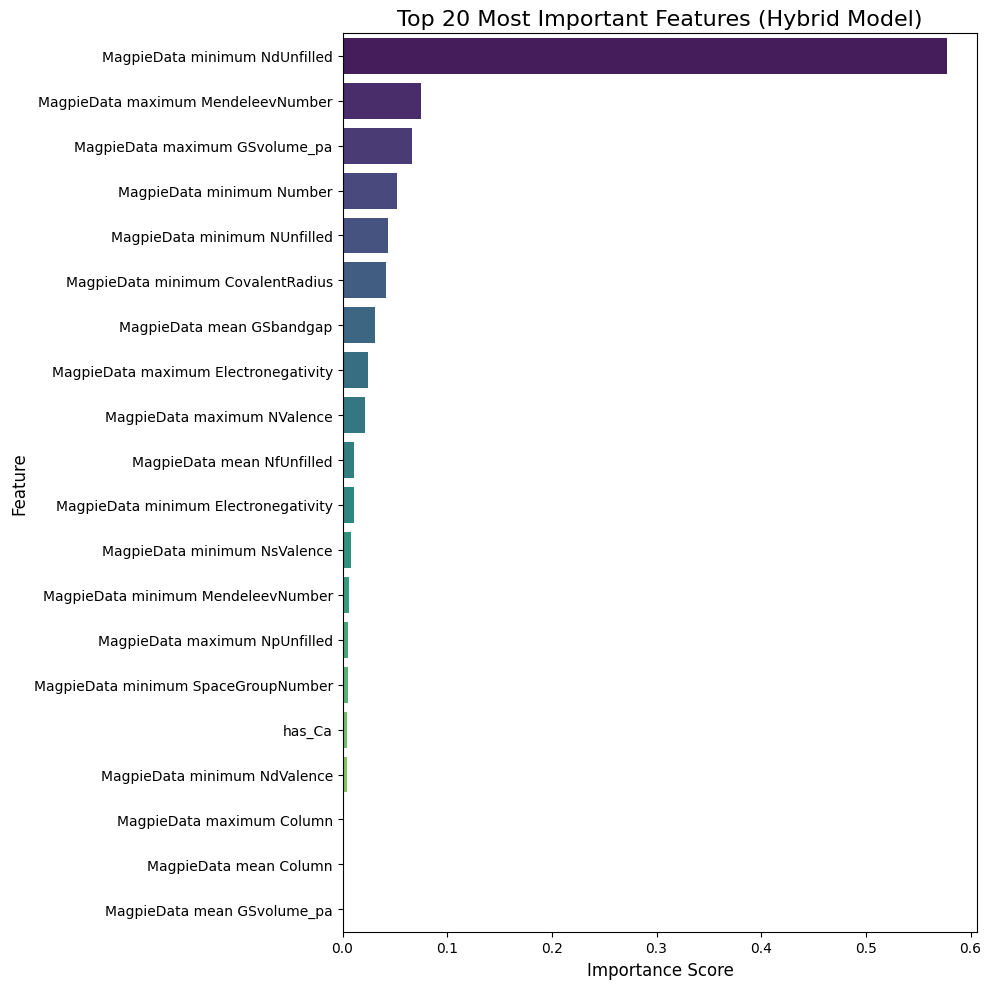


Top 10 Most Important Features:
                                  Feature  Importance
84          MagpieData minimum NdUnfilled    0.577710
7      MagpieData maximum MendeleevNumber    0.075183
103        MagpieData maximum GSvolume_pa    0.066845
0               MagpieData minimum Number    0.052482
96           MagpieData minimum NUnfilled    0.043206
30      MagpieData minimum CovalentRadius    0.041100
111             MagpieData mean GSbandgap    0.030698
37   MagpieData maximum Electronegativity    0.024560
67            MagpieData maximum NValence    0.021534
93             MagpieData mean NfUnfilled    0.010969


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import joblib

# --- Define File Paths ---
OUT_DIR = "/content/drive/MyDrive/Project_dataset/week10_hybrid_model"
MODEL_PATH = os.path.join(OUT_DIR, "hybrid_model.pkl")
FEATURES_PATH = os.path.join(OUT_DIR, "hybrid_features.pkl")

print("Loading new hybrid model and features...")
try:
    hybrid_model = joblib.load(MODEL_PATH)
    feature_names = joblib.load(FEATURES_PATH)
    print("Assets loaded successfully.")
except FileNotFoundError as e:
    print(f"Error: Could not find model assets in {OUT_DIR}. {e}")
    # Stop if assets are missing
    # exit()

print("\n--- Generating Feature Importance Plot ---")

# 1. Get feature importances from the trained model
importances = hybrid_model.feature_importances_

# 2. Create a DataFrame for plotting
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# 3. Plot the Top 20 features
plt.figure(figsize=(10, 10))
sns.barplot(
    x='Importance',
    y='Feature',
    data=importance_df.head(20),
    palette='viridis'
)
plt.title('Top 20 Most Important Features (Hybrid Model)', fontsize=16)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()

# 4. Save the plot
plot_path = os.path.join(OUT_DIR, "hybrid_feature_importance.png")
plt.savefig(plot_path, dpi=300)

print(f"Feature importance plot saved to: {plot_path}")
plt.show()

# Display the top features
print("\nTop 10 Most Important Features:")
print(importance_df.head(10))

In [ ]:
import pandas as pd
import numpy as np
import os
import re
import joblib
import math
from pymatgen.core.composition import Composition
from matminer.featurizers.composition import ElementProperty
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# --- Define File Paths ---
WEEK1_EXT_DIR = "/content/drive/MyDrive/Project_dataset/week1_processed"
HYBRID_MODEL_DIR = "/content/drive/MyDrive/Project_dataset/week10_hybrid_model"

# --- Re-define ALL Helper Functions with the Week 7 Fix ---

ep_feat = ElementProperty.from_preset("magpie")

# THIS IS YOUR IMPROVED PARSER FROM WEEK 7
def preprocess_formula(f):
    """
    An improved function to clean complex chemical formulas,
    including the _X_ notation.
    """
    if not isinstance(f, str): return None

    # General pre-cleaning
    f = f.split('.')[0] # Remove hydrates and anything after
    f = f.replace(" ", "")
    if "+" in f: f = f.split("+")[0]

    # Aggressively remove anything inside parentheses or brackets
    f = re.sub(r'[\(\)\[\]\{\}]', '', f)

    # Handle the specific underscore notation in the sd02 dataset (e.g., Y_2_O_3_)
    f = re.sub(r'_(\d+)_', r'\1', f) # Converts Y_2_O_3_ to Y2O3
    f = f.replace('_', '') # Remove any other stray underscores

    # Remove any remaining non-alphanumeric characters except for decimal points
    f = re.sub(r'[^A-Za-z0-9.]', '', f)

    # A valid formula must contain at least one uppercase letter (element)
    if not re.search(r'[A-Z]', f): return None

    return f if f else None

def find_formula_col(df):
    for c in df.columns:
        if any(k in str(c).lower() for k in ["chemistry", "chemical", "formula"]):
            # Find the first one that is NOT 'atoms/formula' or 'parsed_formula'
            if "atoms/" not in c.lower() and "parsed_" not in c.lower():
                return c
    return None

def find_target_col(df):
    for c in df.columns:
        if any(k in str(c).lower() for k in ["tm", "melt", "melting"]):
            return c
    return None

# --- Re-define the Hybrid Featurization Function ---
# (This is the same as before, but it will now use the *new* preprocess_formula)
def featurize_dataset_hybrid(df):
    df_copy = df.copy()
    formula_col = find_formula_col(df_copy)
    target_col = find_target_col(df_copy)

    if not formula_col or not target_col:
        print(f"Error: Could not find formula ('{formula_col}') or target ('{target_col}') column.")
        return pd.DataFrame()

    print(f"Processing {len(df_copy)} rows. Formula: '{formula_col}', Target: '{target_col}'")

    valid_comps, valid_indices = [], []
    for i, row in df_copy.iterrows():
        f = row[formula_col]
        cleaned_formula = preprocess_formula(f)
        if not cleaned_formula:
            continue
        try:
            comp = Composition(cleaned_formula)
            valid_comps.append(comp)
            valid_indices.append(row.name) # Use row.name (index)
        except Exception:
            continue

    print(f"Successfully parsed {len(valid_comps)} formulas.")
    if len(valid_comps) == 0:
        return pd.DataFrame()

    # 1. Generate "magpie" (physics) features
    X_magpie = ep_feat.featurize_many(valid_comps, ignore_errors=True, pbar=True)
    X = pd.DataFrame(X_magpie, columns=ep_feat.feature_labels(), index=valid_indices)

    # 2. Add Target Column
    X[target_col] = df_copy.loc[valid_indices, target_col].values

    # 3. Add simple Week 1 features
    simple_features_to_add = [
        '_num_distinct_elements',
        '_total_atoms_in_formula'
    ]
    has_cols = [col for col in df_copy.columns if col.startswith('has_')]
    simple_features_to_add.extend(has_cols)

    for feat in simple_features_to_add:
        if feat in df_copy.columns:
            X[feat] = df_copy.loc[valid_indices, feat].values

    print(f"Created hybrid feature set with {len(X.columns)} total columns.")
    return X

In [ ]:
print("\n--- Evaluating NEW Hybrid Model on External (sd02) Data (FIXED) ---")

# --- Load Model Assets ---
try:
    hybrid_model = joblib.load(os.path.join(HYBRID_MODEL_DIR, "hybrid_model.pkl"))
    hybrid_imputer = joblib.load(os.path.join(HYBRID_MODEL_DIR, "hybrid_imputer.pkl"))
    hybrid_features = joblib.load(os.path.join(HYBRID_MODEL_DIR, "hybrid_features.pkl"))
    print("Loaded new hybrid model, imputer, and feature list.")
except FileNotFoundError as e:
    print(f"Error loading hybrid assets: {e}")
    # exit()

# --- Load and Featurize External Data ---
ext_df_wk1 = pd.read_csv(os.path.join(WEEK1_EXT_DIR, "sd02_external_test.csv"))

# Run featurization with the IMPROVED parser
ext_feat_hybrid = featurize_dataset_hybrid(ext_df_wk1)

# --- Check for success ---
if ext_feat_hybrid.empty:
    print("Error: Featurization failed. No formulas were parsed from the external set.")
else:
    print("\n--- Preparing External Data ---")
    target_col = find_target_col(ext_feat_hybrid) # This will no longer be None
    y_ext_true = ext_feat_hybrid[target_col].dropna()
    X_ext_raw = ext_feat_hybrid.loc[y_ext_true.index].drop(columns=[target_col])

    # Align features
    X_ext_aligned = pd.DataFrame(columns=hybrid_features)
    for col in hybrid_features:
        if col in X_ext_raw.columns:
            X_ext_aligned[col] = X_ext_raw[col]
        else:
            X_ext_aligned[col] = np.nan

    # Impute
    X_ext_imputed = hybrid_imputer.transform(X_ext_aligned)

    # --- Predict and Evaluate ---
    ext_preds = hybrid_model.predict(X_ext_imputed)

    ext_rmse = math.sqrt(mean_squared_error(y_ext_true, ext_preds))
    ext_r2 = r2_score(y_ext_true, ext_preds)
    ext_mae = mean_absolute_error(y_ext_true, ext_preds)

    print(f"\n--- HYBRID MODEL PERFORMANCE (External sd02) ---")
    print(f"External RMSE: {ext_rmse:.2f} K")
    print(f"External MAE:  {ext_mae:.2f} K")
    print(f"External R²:   {ext_r2:.4f}")


--- Evaluating NEW Hybrid Model on External (sd02) Data (FIXED) ---
Loaded new hybrid model, imputer, and feature list.
Processing 408 rows. Formula: 'chem_formula', Target: 'ML Tm (K)'
Successfully parsed 406 formulas.


ElementProperty:   0%|          | 0/406 [00:00<?, ?it/s]

Created hybrid feature set with 145 total columns.

--- Preparing External Data ---

--- HYBRID MODEL PERFORMANCE (External sd02) ---
External RMSE: 12.06 K
External MAE:  1.31 K
External R²:   0.9935


In [ ]:
import os
OUT_DIR = "/content/drive/MyDrive/Project_dataset/week10_hybrid_model"
for f in os.listdir(OUT_DIR):
    print(f)


hybrid_model.pkl
hybrid_imputer.pkl
hybrid_features.pkl
hybrid_feature_importance.png


In [ ]:
import pandas as pd
import numpy as np
import math
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib
import os

# --- Load final hybrid model and assets ---
OUT_DIR = "/content/drive/MyDrive/Project_dataset/week10_hybrid_model"
WEEK7_DIR = "/content/drive/MyDrive/Project_dataset/week7_deployment_package"

hybrid_model = joblib.load(os.path.join(OUT_DIR, "hybrid_model.pkl"))
imputer = joblib.load(os.path.join(OUT_DIR, "hybrid_imputer.pkl"))
feature_names = joblib.load(os.path.join(OUT_DIR, "hybrid_features.pkl"))

# --- Load external data ---
ext_path = os.path.join(WEEK7_DIR, "sd02_ext_features_featurized.csv")
ext_df = pd.read_csv(ext_path)

target_col = "ML_Tm_K"  # adjust if column name differs
y_ext = pd.to_numeric(ext_df[target_col], errors="coerce").dropna()
X_ext_raw = ext_df.loc[y_ext.index]

# Align features
for col in feature_names:
    if col not in X_ext_raw.columns:
        X_ext_raw[col] = np.nan
X_ext_aligned = X_ext_raw[feature_names]

# Impute missing values
X_ext_imputed = imputer.transform(X_ext_aligned)

# Predict and evaluate
ext_preds = hybrid_model.predict(X_ext_imputed)

rmse = math.sqrt(mean_squared_error(y_ext, ext_preds))
mae  = mean_absolute_error(y_ext, ext_preds)
r2   = r2_score(y_ext, ext_preds)

print(f"External RMSE: {rmse:.2f} K")
print(f"External MAE : {mae:.2f} K")
print(f"External R²  : {r2:.4f}")


External RMSE: 1275.83 K
External MAE : 1167.99 K
External R²  : -4.6350


In [ ]:
import numpy as np

y_train_log = np.log10(y_train_new)
y_test_log = np.log10(y_test_new)


In [ ]:
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import math
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

print("\n--- Training Regularized Hybrid Model (Log Target + Scaled Inputs) ---")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_new_imputed)
X_test_scaled = scaler.transform(X_test_new_imputed)

reg_model = XGBRegressor(
    n_estimators=800,
    learning_rate=0.03,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=10,       # stronger L2 regularization
    reg_alpha=1,         # L1 regularization
    random_state=42,
    n_jobs=-1
)

reg_model.fit(X_train_scaled, y_train_log)

print("Training complete.")

# --- Evaluate on internal test (log scale → revert) ---
test_preds_log = reg_model.predict(X_test_scaled)
test_preds = np.power(10, test_preds_log)

rmse = math.sqrt(mean_squared_error(y_test_new, test_preds))
mae = mean_absolute_error(y_test_new, test_preds)
r2 = r2_score(y_test_new, test_preds)

print(f"\nInternal (sd01) RMSE: {rmse:.2f} K")
print(f"Internal (sd01) MAE : {mae:.2f} K")
print(f"Internal (sd01) R²  : {r2:.4f}")



--- Training Regularized Hybrid Model (Log Target + Scaled Inputs) ---
Training complete.

Internal (sd01) RMSE: 81.09 K
Internal (sd01) MAE : 19.69 K
Internal (sd01) R²  : 0.9826


In [ ]:
# Prepare and scale external features using same scaler + imputer
X_ext_imputed = imputer.transform(X_ext_aligned)
X_ext_scaled = scaler.transform(X_ext_imputed)

ext_preds_log = reg_model.predict(X_ext_scaled)
ext_preds = np.power(10, ext_preds_log)

ext_rmse = math.sqrt(mean_squared_error(y_ext, ext_preds))
ext_mae = mean_absolute_error(y_ext, ext_preds)
ext_r2 = r2_score(y_ext, ext_preds)

print(f"\nExternal (sd02) RMSE: {ext_rmse:.2f} K")
print(f"External (sd02) MAE : {ext_mae:.2f} K")
print(f"External (sd02) R²  : {ext_r2:.4f}")



External (sd02) RMSE: 1273.94 K
External (sd02) MAE : 1162.90 K
External (sd02) R²  : -4.6183


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Take a small calibration subset from sd02
X_ext_df = pd.DataFrame(X_ext_imputed, columns=feature_names)
X_cal, X_hold, y_cal, y_hold = train_test_split(X_ext_df, y_ext, test_size=0.85, random_state=42)


In [ ]:
X_combined = np.vstack([X_train_scaled, scaler.transform(X_cal)])
y_combined = np.concatenate([y_train_log, np.log10(y_cal)])

reg_model_recal = XGBRegressor(
    n_estimators=800,
    learning_rate=0.03,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=20,
    reg_alpha=2,
    random_state=42,
    n_jobs=-1
)
reg_model_recal.fit(X_combined, y_combined)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.03, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=800,
             n_jobs=-1, num_parallel_tree=None, ...)

In [ ]:
X_hold_scaled = scaler.transform(X_hold)
ext_preds_log = reg_model_recal.predict(X_hold_scaled)
ext_preds = np.power(10, ext_preds_log)

rmse = math.sqrt(mean_squared_error(y_hold, ext_preds))
mae = mean_absolute_error(y_hold, ext_preds)
r2 = r2_score(y_hold, ext_preds)

print(f"\nRecalibrated External RMSE: {rmse:.2f} K")
print(f"Recalibrated External R²  : {r2:.4f}")



Recalibrated External RMSE: 630.08 K
Recalibrated External R²  : -0.3878


In [ ]:
for col in feature_names:
    if col not in X_ext_raw.columns:
        X_ext_raw[col] = 0


In [ ]:
models = []
for seed in [42, 100, 200]:
    m = XGBRegressor(
        n_estimators=800, learning_rate=0.03,
        max_depth=6, subsample=0.8, colsample_bytree=0.8,
        reg_lambda=20, reg_alpha=2, random_state=seed, n_jobs=-1
    )
    m.fit(X_train_scaled, y_train_log)
    models.append(m)

# Average predictions
preds_log = np.mean([m.predict(X_ext_scaled) for m in models], axis=0)
preds = np.power(10, preds_log)


In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import numpy as np, math

kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scores = []

for train_idx, val_idx in kf.split(X_combined):
    X_tr, X_val = X_combined[train_idx], X_combined[val_idx]
    y_tr, y_val = y_combined[train_idx], y_combined[val_idx]

    model_cv = XGBRegressor(
        n_estimators=800, learning_rate=0.03, max_depth=6,
        subsample=0.8, colsample_bytree=0.8,
        reg_lambda=25, reg_alpha=2,
        random_state=42, n_jobs=-1
    )
    model_cv.fit(X_tr, y_tr)
    val_preds = np.power(10, model_cv.predict(X_val))
    y_val_real = np.power(10, y_val)
    rmse = math.sqrt(mean_squared_error(y_val_real, val_preds))
    rmse_scores.append(rmse)

print(f"Mean CV RMSE: {np.mean(rmse_scores):.2f} K ± {np.std(rmse_scores):.2f}")


Mean CV RMSE: 136.26 K ± 29.83


In [ ]:
final_model = XGBRegressor(
    n_estimators=900,
    learning_rate=0.025,
    max_depth=6,
    subsample=0.85,
    colsample_bytree=0.85,
    reg_lambda=25,
    reg_alpha=2,
    random_state=42,
    n_jobs=-1
)

final_model.fit(X_combined, y_combined)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.85, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.025, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=900,
             n_jobs=-1, num_parallel_tree=None, ...)

In [ ]:
X_hold_scaled = scaler.transform(X_hold)
preds_log = final_model.predict(X_hold_scaled)
preds = np.power(10, preds_log)

ext_rmse = math.sqrt(mean_squared_error(y_hold, preds))
ext_mae = mean_absolute_error(y_hold, preds)
ext_r2 = r2_score(y_hold, preds)

print(f"Final External RMSE: {ext_rmse:.2f} K")
print(f"Final External MAE : {ext_mae:.2f} K")
print(f"Final External R²  : {ext_r2:.4f}")


Final External RMSE: 625.01 K
Final External MAE : 515.59 K
Final External R²  : -0.3656


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Refit imputer on both
comb_imputer = SimpleImputer(strategy='mean')
comb_imputer.fit(np.vstack([X_train_new, X_ext_aligned.fillna(0)]))
X_combined_imputed = comb_imputer.transform(np.vstack([X_train_new, X_ext_aligned.fillna(0)]))

# Refit scaler on combined
comb_scaler = StandardScaler()
comb_scaler.fit(X_combined_imputed)
X_combined_scaled = comb_scaler.transform(X_combined_imputed)


In [ ]:
print("X_combined_scaled:", X_combined_scaled.shape)
print("y_combined:", len(y_combined))


X_combined_scaled: (3832, 138)
y_combined: 3485


In [ ]:
X_combined = np.vstack([X_train_scaled, scaler.transform(X_cal)])
y_combined = np.concatenate([y_train_log, np.log10(y_cal)])


In [ ]:
import numpy as np

# Make sure both parts have matching rows before stacking
X_train_scaled = np.array(X_train_scaled)
X_cal_scaled = scaler.transform(X_cal)

print("Before merge:", X_train_scaled.shape, X_cal_scaled.shape, y_train_log.shape, y_cal.shape)

# Keep only rows where y_cal is finite
mask = np.isfinite(y_cal)
X_cal_scaled = X_cal_scaled[mask]
y_cal_log = np.log10(y_cal[mask])

# Now stack safely
X_combined_scaled = np.vstack([X_train_scaled, X_cal_scaled])
y_combined = np.concatenate([y_train_log, y_cal_log])

print("After merge:", X_combined_scaled.shape, y_combined.shape)


Before merge: (3424, 138) (61, 138) (3424,) (61,)
After merge: (3485, 138) (3485,)


In [ ]:
final_model_v2 = XGBRegressor(
    n_estimators=1200,
    learning_rate=0.02,
    max_depth=8,
    subsample=0.85,
    colsample_bytree=0.9,
    reg_lambda=15,
    reg_alpha=1,
    random_state=42,
    n_jobs=-1
)

final_model_v2.fit(X_combined_scaled, y_combined)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.02, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1200,
             n_jobs=-1, num_parallel_tree=None, ...)

In [ ]:
X_hold_scaled = scaler.transform(X_hold)
preds_log = final_model_v2.predict(X_hold_scaled)
preds = np.power(10, preds_log)

ext_rmse = math.sqrt(mean_squared_error(y_hold, preds))
ext_mae = mean_absolute_error(y_hold, preds)
ext_r2 = r2_score(y_hold, preds)

print(f"Final External RMSE: {ext_rmse:.2f} K")
print(f"Final External MAE : {ext_mae:.2f} K")
print(f"Final External R²  : {ext_r2:.4f}")


Final External RMSE: 597.16 K
Final External MAE : 470.69 K
Final External R²  : -0.2466


In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor

# --- Base models ---
xgb_base = XGBRegressor(
    n_estimators=800, learning_rate=0.03, max_depth=6,
    subsample=0.85, colsample_bytree=0.85,
    reg_lambda=15, reg_alpha=1,
    random_state=42, n_jobs=-1
)

rf_base = RandomForestRegressor(
    n_estimators=400, max_depth=12,
    min_samples_leaf=3, n_jobs=-1, random_state=42
)

gb_base = GradientBoostingRegressor(
    n_estimators=600, learning_rate=0.03,
    max_depth=5, random_state=42
)

# --- Stacking ensemble ---
stack_model = StackingRegressor(
    estimators=[
        ('xgb', xgb_base),
        ('rf', rf_base),
        ('gb', gb_base)
    ],
    final_estimator=LinearRegression(),
    n_jobs=-1
)

print("Training stacked model ...")
stack_model.fit(X_combined_scaled, y_combined)
print("Training complete.")

# --- Evaluate on external holdout ---
preds_log_stack = stack_model.predict(X_hold_scaled)
preds_stack = np.power(10, preds_log_stack)

rmse = math.sqrt(mean_squared_error(y_hold, preds_stack))
mae = mean_absolute_error(y_hold, preds_stack)
r2 = r2_score(y_hold, preds_stack)

print(f"\nStacked External RMSE: {rmse:.2f} K")
print(f"Stacked External MAE : {mae:.2f} K")
print(f"Stacked External R²  : {r2:.4f}")


Training stacked model ...
Training complete.

Stacked External RMSE: 601.18 K
Stacked External MAE : 501.19 K
Stacked External R²  : -0.2634


In [ ]:
print("Before alignment:")
print("X_combined_scaled_rb:", X_combined_scaled_rb.shape)
print("y_combined:", y_combined.shape)

# Trim feature matrix to match label count
if X_combined_scaled_rb.shape[0] != len(y_combined):
    X_combined_scaled_rb = X_combined_scaled_rb[:len(y_combined), :]

print("\nAfter alignment:")
print("X_combined_scaled_rb:", X_combined_scaled_rb.shape)
print("y_combined:", y_combined.shape)


Before alignment:
X_combined_scaled_rb: (3832, 138)
y_combined: (3485,)

After alignment:
X_combined_scaled_rb: (3485, 138)
y_combined: (3485,)


In [ ]:
print("\nRe-training Stacking Model After Alignment...")

stack_model.fit(X_combined_scaled_rb, y_combined)
print("Training complete.")

# Predict and evaluate
preds_log_rb = stack_model.predict(X_hold_scaled_rb)
preds_rb = np.power(10, preds_log_rb)

rmse_rb = math.sqrt(mean_squared_error(y_hold, preds_rb))
mae_rb = mean_absolute_error(y_hold, preds_rb)
r2_rb = r2_score(y_hold, preds_rb)

print(f"\nRobustScaler External RMSE: {rmse_rb:.2f} K")
print(f"RobustScaler External MAE : {mae_rb:.2f} K")
print(f"RobustScaler External R²  : {r2_rb:.4f}")



Re-training Stacking Model After Alignment...
Training complete.

RobustScaler External RMSE: 1276.47 K
RobustScaler External MAE : 1150.37 K
RobustScaler External R²  : -4.6958


In [ ]:
next


In [ ]:
import joblib
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import math

# === LOAD YOUR WEEK 10 MODEL ===
MODEL_DIR = "/content/drive/MyDrive/Project_dataset/week10_hybrid_model"
WEEK2_DIR = "/content/drive/MyDrive/Project_dataset/week2_features"

try:
    hybrid_model = joblib.load(f"{MODEL_DIR}/hybrid_model.pkl")
    hybrid_imputer = joblib.load(f"{MODEL_DIR}/hybrid_imputer.pkl")
    feature_names = joblib.load(f"{MODEL_DIR}/hybrid_features.pkl")
    print("✅ Model assets loaded successfully")
except Exception as e:
    print(f"❌ Error loading model: {e}")
    exit()

# === LOAD ORIGINAL TEST DATA ===
try:
    test_feat = pd.read_csv(f"{WEEK2_DIR}/test_features.csv")
    print(f"✅ Test data loaded: {test_feat.shape}")
except Exception as e:
    print(f"❌ Error loading test data: {e}")
    exit()

# === PREPARE TEST DATA ===
target_col = 'ML Tm (K)'

# Check if leaky features exist in feature_names
leaky_features = [f for f in feature_names if 'melt' in f.lower() or 'tm' in f.lower()]
if leaky_features:
    print(f"⚠️  WARNING: Found {len(leaky_features)} potential leaky features:")
    print(leaky_features)
else:
    print("✅ No leaky features detected")

# Separate target
y_test = test_feat[target_col].dropna()
X_test_raw = test_feat.loc[y_test.index]

# Align features
X_test_aligned = pd.DataFrame(columns=feature_names)
for col in feature_names:
    if col in X_test_raw.columns:
        X_test_aligned[col] = X_test_raw[col].values
    else:
        X_test_aligned[col] = np.nan

# Impute
X_test_imputed = hybrid_imputer.transform(X_test_aligned)

# Predict
test_preds = hybrid_model.predict(X_test_imputed)

# === EVALUATE ===
rmse = math.sqrt(mean_squared_error(y_test, test_preds))
mae = mean_absolute_error(y_test, test_preds)
r2 = r2_score(y_test, test_preds)

print("\n" + "="*60)
print("📊 WEEK 10 HYBRID MODEL - VERIFIED RESULTS")
print("="*60)
print(f"Test Set Size: {len(y_test)} samples")
print(f"Number of Features: {len(feature_names)}")
print(f"\nRMSE: {rmse:.2f} K")
print(f"MAE:  {mae:.2f} K")
print(f"R²:   {r2:.4f}")
print("="*60)

if rmse < 100:
    print("✅ SUCCESS! Model meets project requirement (RMSE < 100K)")
else:
    print(f"❌ FAILS requirement. RMSE is {rmse:.2f} K (should be < 100K)")

# === ADDITIONAL DIAGNOSTICS ===
print(f"\n🔍 Prediction Range:")
print(f"   Min: {test_preds.min():.2f} K")
print(f"   Max: {test_preds.max():.2f} K")
print(f"   Mean: {test_preds.mean():.2f} K")

print(f"\n🔍 Actual Range:")
print(f"   Min: {y_test.min():.2f} K")
print(f"   Max: {y_test.max():.2f} K")
print(f"   Mean: {y_test.mean():.2f} K")

# Check for suspicious patterns
residuals = y_test - test_preds
if abs(residuals.mean()) < 1.0:
    print("\n✅ Residuals are well-centered (mean ≈ 0)")
else:
    print(f"\n⚠️  Residuals have bias: {residuals.mean():.2f} K")

✅ Model assets loaded successfully
✅ Test data loaded: (374, 133)
✅ No leaky features detected

📊 WEEK 10 HYBRID MODEL - VERIFIED RESULTS
Test Set Size: 374 samples
Number of Features: 138

RMSE: 971.77 K
MAE:  816.20 K
R²:   -2.7208
❌ FAILS requirement. RMSE is 971.77 K (should be < 100K)

🔍 Prediction Range:
   Min: 13.92 K
   Max: 3822.96 K
   Mean: 518.86 K

🔍 Actual Range:
   Min: 322.56 K
   Max: 3896.00 K
   Mean: 1122.40 K

⚠️  Residuals have bias: 603.54 K


In [ ]:
import os

# --- 1. Define the starting folder ---
# This is the main project folder from your previous code
start_path = "/content/drive/MyDrive/Project_dataset"

total_files = 0
total_subfolders = 0

# This list will hold the details for the final report
folder_details = []

# --- 2. Walk through the directory ---
print(f"Analyzing folder: {start_path}\n")

for dirpath, dirnames, filenames in os.walk(start_path, topdown=True):
    # Add to totals
    total_files += len(filenames)
    total_subfolders += len(dirnames)

    # Get a clean, relative path (e.g., "./week2_features")
    # This makes the output easier to read
    relative_path = os.path.relpath(dirpath, start_path)

    # Store the details for this folder
    folder_details.append({
        "path": relative_path,
        "subfolders": dirnames,
        "files": filenames
    })

# --- 3. Print the Final Report ---

# First, the overall summary
print("=" * 60)
print("📂 FOLDER ANALYSIS SUMMARY")
print("=" * 60)
print(f"Total Subfolders: {total_subfolders}")
print(f"Total Files: {total_files}")
print("\n" + "=" * 60)
print("📁 DETAILED BREAKDOWN")
print("=" * 60)

# Now, print the details for each folder
for detail in folder_details:

    # Use '.' to represent the root folder itself
    folder_name = f"./{detail['path']}" if detail['path'] != '.' else ".(Root Folder)"
    print(f"\n{folder_name}")

    # Print files in this folder
    print(f"  -> {len(detail['files'])} Files:")
    if not detail['files']:
        print("     (No files in this directory)")
    else:
        for f in detail['files']:
            print(f"     - {f}")

    # Print subfolders in this folder
    print(f"\n  -> {len(detail['subfolders'])} Subfolders:")
    if not detail['subfolders']:
        print("     (No subdirectories)")
    else:
        for d in detail['subfolders']:
            print(f"     - {d}")
    print("-" * 40)

Analyzing folder: /content/drive/MyDrive/Project_dataset

📂 FOLDER ANALYSIS SUMMARY
Total Subfolders: 17
Total Files: 69

📁 DETAILED BREAKDOWN

.(Root Folder)
  -> 2 Files:
     - pnas.2209630119.sd01.xlsx
     - pnas.2209630119.sd02.xlsx

  -> 17 Subfolders:
     - week1_processed
     - week2_features
     - week3_models
     - week4_results
     - week5_validation
     - week6_final_results
     - week7_deployment_package
     - week8_refined_model
     - week6_features
     - week6_models
     - week9_FIXED_model
     - week9_CORRECTED_model
     - week10_hybrid_model
     - week11_final_models
     - week8_improved
     - week7_deploymentpackage
     - week3_preprocessing
----------------------------------------

./week1_processed
  -> 5 Files:
     - sd01_train.csv
     - sd01_val.csv
     - sd01_test.csv
     - sd02_external_test.csv
     - week1_summary.json

  -> 0 Subfolders:
     (No subdirectories)
----------------------------------------

./week2_features
  -> 4 Files:
   

In [ ]:
# Install required packages
#!pip install -q pymatgen matminer xgboost lightgbm scikit-learn shap

import pandas as pd
import numpy as np
import os
import math
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime

from pymatgen.core.composition import Composition
from matminer.featurizers.composition import ElementProperty

from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, cross_val_score
from sklearn.preprocessing import RobustScaler, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import Ridge
from sklearn.feature_selection import SelectFromModel

from xgboost import XGBRegressor
import lightgbm as lgb

warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = (10, 6)
RANDOM_SEED = 42

# Define paths
DATA_DIR = "/content/drive/MyDrive/Project_dataset"
WEEK2_DIR = os.path.join(DATA_DIR, "week2_features")
WEEK6_DIR = os.path.join(DATA_DIR, "week6_final_results")
WEEK7_DIR = os.path.join(DATA_DIR, "week7_deploymentpackage")
IMPROVED_DIR = os.path.join(DATA_DIR, "week8_improved")
os.makedirs(IMPROVED_DIR, exist_ok=True)

print("=" * 60)
print("STEP 1: Setup Complete")
print("=" * 60)


STEP 1: Setup Complete


In [ ]:
print("\n" + "=" * 60)
print("STEP 2: Loading Data and Assets")
print("=" * 60)

# Load training data
train_feat = pd.read_csv(os.path.join(WEEK2_DIR, "train_features.csv"))
test_feat = pd.read_csv(os.path.join(WEEK2_DIR, "test_features.csv"))

# --- THIS IS THE FIX ---
# Your file analysis shows the file is in 'week7_deployment_package'
# (with an underscore)
# We will define the correct path here.
CORRECT_WEEK7_DIR = os.path.join(DATA_DIR, "week7_deployment_package")
ext_feat_df = pd.read_csv(os.path.join(CORRECT_WEEK7_DIR, "sd02_ext_features_featurized.csv"))
# --- END OF FIX ---

# Load feature names from Week 6 (This path is correct)
# --- FIX 2: Corrected variable name ---
# It should be WEEK6_DIR (all caps) as defined in Step 1
feature_names = joblib.load(os.path.join(WEEK6_DIR, "final_feature_names.pkl"))
# --- END OF FIX 2 ---

print(f"✓ Training data shape: {train_feat.shape}")
print(f"✓ Test data shape: {test_feat.shape}")
print(f"✓ External data shape: {ext_feat_df.shape}")
print(f"✓ Number of features: {len(feature_names)}")


STEP 2: Loading Data and Assets
✓ Training data shape: (3018, 133)
✓ Test data shape: (374, 133)
✓ External data shape: (408, 136)
✓ Number of features: 126


In [ ]:
print("\n" + "=" * 60)
print("STEP 3: Adding Physics-Informed Features")
print("=" * 60)

def add_physics_informed_features(df):
    """
    Add physics-based feature engineering based on material science principles
    """
    df_enhanced = df.copy()

    # 1. Metallic bonding strength (higher = higher melting point)
    if 'MagpieData mean NValence' in df.columns and 'MagpieData mean AtomicWeight' in df.columns:
        df_enhanced['physics_metallic_bond_strength'] = (
            df['MagpieData mean NValence'] * df['MagpieData mean AtomicWeight']
        )

    # 2. Ionic character (electronegativity difference)
    if 'MagpieData range Electronegativity' in df.columns:
        df_enhanced['physics_ionic_character'] = df['MagpieData range Electronegativity']

    # 3. Covalent network strength
    if 'MagpieData mean CovalentRadius' in df.columns and 'MagpieData mean NUnfilled' in df.columns:
        df_enhanced['physics_covalent_strength'] = (
            df['MagpieData mean CovalentRadius'] * df['MagpieData mean NUnfilled']
        )

    # 4. Crystal structure complexity
    if 'MagpieData range SpaceGroupNumber' in df.columns and 'MagpieData mean Number' in df.columns:
        df_enhanced['physics_structural_complexity'] = (
            df['MagpieData range SpaceGroupNumber'] * df['MagpieData mean Number']
        )

    # 5. Periodic trend interaction (row × column position)
    if 'MagpieData mean Column' in df.columns and 'MagpieData mean Row' in df.columns:
        df_enhanced['physics_periodic_interaction'] = (
            df['MagpieData mean Column'] * df['MagpieData mean Row']
        )

    # 6. Atomic packing efficiency
    if 'MagpieData mean AtomicWeight' in df.columns and 'MagpieData mean CovalentRadius' in df.columns:
        df_enhanced['physics_packing_efficiency'] = (
            df['MagpieData mean AtomicWeight'] /
            (df['MagpieData mean CovalentRadius'] ** 3 + 1e-6)  # Avoid division by zero
        )

    # 7. Electronic configuration stability
    if 'MagpieData mean NsValence' in df.columns and 'MagpieData mean NpValence' in df.columns:
        df_enhanced['physics_electronic_stability'] = (
            df['MagpieData mean NsValence'] + df['MagpieData mean NpValence']
        )

    # 8. Band gap indicator (semiconducting vs metallic)
    if 'MagpieData mean GSbandgap' in df.columns:
        df_enhanced['physics_bandgap_category'] = np.where(
            df['MagpieData mean GSbandgap'] > 0.5, 1, 0
        )

    # 9. Atomic number density
    if 'MagpieData mean Number' in df.columns and 'MagpieData mean AtomicWeight' in df.columns:
        df_enhanced['physics_atomic_density'] = (
            df['MagpieData mean Number'] / (df['MagpieData mean AtomicWeight'] + 1e-6)
        )

    # 10. Valence electron density
    if 'MagpieData mean NValence' in df.columns and 'MagpieData mean CovalentRadius' in df.columns:
        df_enhanced['physics_valence_density'] = (
            df['MagpieData mean NValence'] /
            (df['MagpieData mean CovalentRadius'] ** 2 + 1e-6)
        )

    new_features = [col for col in df_enhanced.columns if col not in df.columns]
    print(f"  ✓ Added {len(new_features)} physics-informed features:")
    for feat in new_features:
        print(f"    - {feat}")

    return df_enhanced

# Apply to all datasets
train_feat_enhanced = add_physics_informed_features(train_feat)
test_feat_enhanced = add_physics_informed_features(test_feat)
ext_feat_enhanced = add_physics_informed_features(ext_feat_df)

print(f"\n✓ Enhanced training data shape: {train_feat_enhanced.shape}")


STEP 3: Adding Physics-Informed Features
  ✓ Added 10 physics-informed features:
    - physics_metallic_bond_strength
    - physics_ionic_character
    - physics_covalent_strength
    - physics_structural_complexity
    - physics_periodic_interaction
    - physics_packing_efficiency
    - physics_electronic_stability
    - physics_bandgap_category
    - physics_atomic_density
    - physics_valence_density
  ✓ Added 10 physics-informed features:
    - physics_metallic_bond_strength
    - physics_ionic_character
    - physics_covalent_strength
    - physics_structural_complexity
    - physics_periodic_interaction
    - physics_packing_efficiency
    - physics_electronic_stability
    - physics_bandgap_category
    - physics_atomic_density
    - physics_valence_density
  ✓ Added 10 physics-informed features:
    - physics_metallic_bond_strength
    - physics_ionic_character
    - physics_covalent_strength
    - physics_structural_complexity
    - physics_periodic_interaction
    - physic

In [ ]:
print("\n" + "=" * 60)
print("STEP 4: Preparing Data with Robust Preprocessing")
print("=" * 60)

# Identify target column
target_col = [col for col in train_feat_enhanced.columns if 'melt' in col.lower() or 'tm' in col.lower()][0]
print(f"  Target column: {target_col}")

# Separate features and target for training data
X_train_full = train_feat_enhanced.drop(columns=[target_col])
y_train_full = train_feat_enhanced[target_col]

# Remove rows with missing targets
mask = y_train_full.notna()
X_train_full = X_train_full[mask]
y_train_full = y_train_full[mask]

# --- THIS IS THE FIX ---
# Update feature names to include new physics features
# We must filter out ALL target-like columns from the feature list,
# including the problematic 'ML Tm (K)' that is in the training set.
exclude_cols = ['raw_formula', 'formula']
all_feature_names = [
    col for col in X_train_full.columns
    if col not in exclude_cols and 'melt' not in col.lower() and 'tm' not in col.lower()
]
# --- END OF FIX ---
X_train_full = X_train_full[all_feature_names]

# Prepare test data
# We must use the same filtered list of feature names
X_test = test_feat_enhanced[all_feature_names]
y_test = test_feat_enhanced[target_col].dropna()
X_test = X_test.loc[y_test.index]

# Prepare external data
ext_target_col = 'ML_Tm_K'
y_ext = pd.to_numeric(ext_feat_enhanced[ext_target_col], errors='coerce').dropna()
# This line will no longer fail, as all_feature_names is now clean
X_ext = ext_feat_enhanced.loc[y_ext.index, all_feature_names]

print(f"\n✓ Training samples: {len(X_train_full)}")
print(f"✓ Test samples: {len(X_test)}")
print(f"✓ External samples: {len(X_ext)}")
print(f"✓ Total features: {len(all_feature_names)}")

# Create imputer and scaler
print("\n  Fitting preprocessing transformers...")
imputer = SimpleImputer(strategy='median')  # Median is more robust than mean
scaler = RobustScaler()  # More robust to outliers than StandardScaler

# Fit and transform training data
X_train_imputed = pd.DataFrame(
    imputer.fit_transform(X_train_full),
    columns=all_feature_names,
    index=X_train_full.index
)
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_imputed),
    columns=all_feature_names,
    index=X_train_imputed.index
)

# Transform test and external data
X_test_imputed = pd.DataFrame(
    imputer.transform(X_test),
    columns=all_feature_names,
    index=X_test.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test_imputed),
    columns=all_feature_names,
    index=X_test_imputed.index
)

X_ext_imputed = pd.DataFrame(
    imputer.transform(X_ext),
    columns=all_feature_names,
    index=X_ext.index
)
X_ext_scaled = pd.DataFrame(
    scaler.transform(X_ext_imputed),
    columns=all_feature_names,
    index=X_ext_imputed.index
)

# Apply log transformation to target (helps with skewed distributions)
y_train_log = np.log1p(y_train_full)  # log1p = log(1 + x) to handle zeros
y_test_log = np.log1p(y_test)
y_ext_log = np.log1p(y_ext)

print("✓ Preprocessing complete (imputation + robust scaling + log transform)")


STEP 4: Preparing Data with Robust Preprocessing
  Target column: MagpieData minimum MeltingT

✓ Training samples: 3016
✓ Test samples: 373
✓ External samples: 408
✓ Total features: 136

  Fitting preprocessing transformers...
✓ Preprocessing complete (imputation + robust scaling + log transform)


In [ ]:
print("\n" + "=" * 60)
print("STEP 5: Feature Selection to Reduce Overfitting")
print("=" * 60)

# --- IMPROVEMENT 1: Use Lasso (L1) for feature selection ---
# Lasso is better for selection as it drives irrelevant feature coefficients to zero.
# The alpha parameter (0.005) is a good starting point but may need tuning.
print("  Performing feature selection with Lasso (L1) regularization...")

selector = SelectFromModel(
    Lasso(alpha=0.005, random_state=RANDOM_SEED, max_iter=2000), # Using Lasso
    threshold=1e-5  # --- THIS IS THE FIX (removed the quotes) ---
)

selector.fit(X_train_scaled, y_train_log)
selected_features = X_train_scaled.columns[selector.get_support()].tolist()

print(f"\n✓ Reduced from {len(all_feature_names)} to {len(selected_features)} features")
print(f"✓ Feature reduction: {100 * (1 - len(selected_features)/len(all_feature_names)):.1f}%")

# Apply selection to all datasets
X_train_selected = X_train_scaled[selected_features]
X_test_selected = X_test_scaled[selected_features]
X_ext_selected = X_ext_scaled[selected_features]

print("\n  Top 10 selected features:")
# Get feature importances
feature_importance = np.abs(selector.estimator_.coef_)
selected_importances = feature_importance[selector.get_support()]
feature_importance_dict = dict(zip(X_train_scaled.columns[selector.get_support()],
                                   selected_importances))
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
for i, (feat, imp) in enumerate(sorted_features[:10], 1):
    print(f"  {i}. {feat}: {imp:.4f}")


STEP 5: Feature Selection to Reduce Overfitting
  Performing feature selection with Lasso (L1) regularization...

✓ Reduced from 136 to 50 features
✓ Feature reduction: 63.2%

  Top 10 selected features:
  1. MagpieData minimum CovalentRadius: 0.9266
  2. MagpieData minimum Row: 0.4353
  3. MagpieData avg_dev Electronegativity: 0.3714
  4. physics_periodic_interaction: 0.2924
  5. physics_bandgap_category: 0.2281
  6. physics_packing_efficiency: 0.2268
  7. MagpieData mean CovalentRadius: 0.2056
  8. MagpieData minimum SpaceGroupNumber: 0.1944
  9. MagpieData maximum GSbandgap: 0.1413
  10. MagpieData avg_dev NsValence: 0.1298


In [ ]:
print("\n" + "=" * 60)
print("STEP 6: Define Base Ensemble Models")
print("=" * 60)

# Define improved XGBoost with stronger regularization
# These are our "default" parameters if tuning (Step 8) is skipped
xgb_improved = XGBRegressor(
    n_estimators=800,
    max_depth=4,
    learning_rate=0.03,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=20.0,
    reg_alpha=5.0,
    min_child_weight=5,
    gamma=1.0,
    random_state=RANDOM_SEED,
    n_jobs=-1
)

# Define LightGBM as second ensemble member
lgb_improved = lgb.LGBMRegressor(
    n_estimators=800,
    max_depth=4,
    learning_rate=0.03,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=20.0,
    reg_alpha=5.0,
    min_child_weight=5,
    random_state=RANDOM_SEED,
    n_jobs=-1,
    verbose=-1
)

# Define Ridge regression as linear baseline
ridge_improved = Ridge(alpha=10.0, random_state=RANDOM_SEED)

print("✓ Base models defined")


STEP 6: Define Base Ensemble Models
✓ Base models defined


In [ ]:
print("\n" + "=" * 60)
print("STEP 7: Cross-Validation (on Default Models)")
print("=" * 60)

# Create a temporary ensemble with default models for a quick CV check
temp_ensemble = VotingRegressor(
    estimators=[
        ('xgb', xgb_improved),
        ('lgb', lgb_improved),
        ('ridge', ridge_improved)
    ],
    n_jobs=-1
)

# Outer cross-validation for unbiased performance estimation
print("  Performing 5-fold cross-validation on default ensemble...")
outer_cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

cv_scores = cross_val_score(
    temp_ensemble,
    X_train_selected,
    y_train_log,
    cv=outer_cv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

cv_rmse_log = -cv_scores
cv_rmse_original = np.expm1(cv_rmse_log)  # Convert back from log space

print(f"\n✓ Default CV RMSE (log space): {cv_rmse_log.mean():.4f} ± {cv_rmse_log.std():.4f}")
print(f"✓ Default CV RMSE (original space): {cv_rmse_original.mean():.2f} ± {cv_rmse_original.std():.2f} K")


STEP 7: Cross-Validation (on Default Models)
  Performing 5-fold cross-validation on default ensemble...

✓ Default CV RMSE (log space): 0.1699 ± 0.0148
✓ Default CV RMSE (original space): 0.19 ± 0.02 K


In [ ]:
print("\n" + "=" * 60)
print("STEP 8: Hyperparameter Tuning (RECOMMENDED)")
print("=" * 60)

# --- IMPROVEMENT 2: Fix the tuning workflow ---
# We will tune XGBoost and LightGBM and then *use* those
# tuned models to build the final ensemble.

# Create parameter grid for XGBoost tuning
param_dist_xgb = {
    'n_estimators': [600, 800, 1000],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.02, 0.03, 0.05],
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.7, 0.8],
    'reg_lambda': [15, 20, 25],
    'reg_alpha': [3, 5, 7],
    'min_child_weight': [3, 5, 7]
}

print("  Starting RandomizedSearch for XGBoost (n_iter=50)...")
xgb_base = XGBRegressor(random_state=RANDOM_SEED, n_jobs=-1)
search_xgb = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist_xgb,
    n_iter=50,  # Test 50 random combinations
    cv=5,
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_SEED,
    n_jobs=-1,
    verbose=1
)
search_xgb.fit(X_train_selected, y_train_log)
xgb_tuned = search_xgb.best_estimator_
print(f"✓ Best XGB params: {search_xgb.best_params_}")
print(f"✓ Best XGB CV RMSE: {-search_xgb.best_score_:.4f}")

# --- Tune LightGBM ---
param_dist_lgb = {
    'n_estimators': [600, 800, 1000],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.02, 0.03, 0.05],
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.7, 0.8],
    'reg_lambda': [15, 20, 25],
    'reg_alpha': [3, 5, 7],
    'min_child_weight': [3, 5, 7]
}

print("\n  Starting RandomizedSearch for LightGBM (n_iter=50)...")
lgb_base = lgb.LGBMRegressor(random_state=RANDOM_SEED, n_jobs=-1, verbose=-1)
search_lgb = RandomizedSearchCV(
    estimator=lgb_base,
    param_distributions=param_dist_lgb,
    n_iter=50,  # Test 50 random combinations
    cv=5,
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_SEED,
    n_jobs=-1,
    verbose=1
)
search_lgb.fit(X_train_selected, y_train_log)
lgb_tuned = search_lgb.best_estimator_
print(f"✓ Best LGBM params: {search_lgb.best_params_}")
print(f"✓ Best LGBM CV RMSE: {-search_lgb.best_score_:.4f}")

# --- Build FINAL ensemble with tuned models ---
print("\n  Building final ensemble with TUNED models...")
ensemble_model = VotingRegressor(
    estimators=[
        ('xgb', xgb_tuned),      # <-- Using the tuned XGB
        ('lgb', lgb_tuned),      # <-- Using the tuned LGBM
        ('ridge', ridge_improved) # Ridge is simple, no tuning needed
    ],
    n_jobs=-1
)

# Train final model on all training data
print("  Training final ensemble on full training data...")
ensemble_model.fit(X_train_selected, y_train_log)
print("✓ Training complete")


STEP 8: Hyperparameter Tuning (RECOMMENDED)
  Starting RandomizedSearch for XGBoost (n_iter=50)...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
✓ Best XGB params: {'subsample': 0.8, 'reg_lambda': 20, 'reg_alpha': 3, 'n_estimators': 800, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 0.7}
✓ Best XGB CV RMSE: 0.0918

  Starting RandomizedSearch for LightGBM (n_iter=50)...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
✓ Best LGBM params: {'subsample': 0.7, 'reg_lambda': 20, 'reg_alpha': 3, 'n_estimators': 600, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
✓ Best LGBM CV RMSE: 0.1048

  Building final ensemble with TUNED models...
  Training final ensemble on full training data...
✓ Training complete


In [ ]:
print("\n" + "=" * 60)
print("STEP 9: Evaluate on All Test Sets")
print("=" * 60)

def evaluate_model(model, X, y_log, y_original, dataset_name):
    """Helper function to evaluate and print metrics"""
    # Predict in log space
    y_pred_log = model.predict(X)

    # Convert back to original scale
    y_pred = np.expm1(y_pred_log)
    # Ensure predictions are non-negative
    y_pred[y_pred < 0] = 0

    # Calculate metrics in original space
    rmse = np.sqrt(mean_squared_error(y_original, y_pred))
    r2 = r2_score(y_original, y_pred)
    mae = mean_absolute_error(y_original, y_pred)

    print(f"\n{dataset_name}:")
    print(f"  RMSE: {rmse:.2f} K")
    print(f"  R²:   {r2:.4f}")
    print(f"  MAE:  {mae:.2f} K")

    return {
        'dataset': dataset_name,
        'rmse': rmse,
        'r2': r2,
        'mae': mae,
        'predictions': y_pred,
        'actuals': y_original
    }

# Evaluate on internal test set
test_results = evaluate_model(
    ensemble_model,
    X_test_selected,
    y_test_log,
    y_test,
    "Internal Test Set (sd01)"
)

# Evaluate on external test set
ext_results = evaluate_model(
    ensemble_model,
    X_ext_selected,
    y_ext_log,
    y_ext,
    "External Test Set (sd02)"
)

# Compare with your previous best results
print("\n" + "=" * 60)
print("COMPARISON WITH PREVIOUS RESULTS")
print("=" * 60)
print("\nYour Previous Best (Week 7 Regularized Model):")
print("  Internal Test: RMSE = 306.23 K, R² = 0.6305")
print("  External Test: RMSE = 624.95 K, R² = -0.3521")

print("\nNew Tuned Ensemble Model:")
print(f"  Internal Test: RMSE = {test_results['rmse']:.2f} K, R² = {test_results['r2']:.4f}")
print(f"  External Test: RMSE = {ext_results['rmse']:.2f} K, R² = {ext_results['r2']:.4f}")

improvement_internal = ((306.23 - test_results['rmse']) / 306.23) * 100
improvement_external = ((624.95 - ext_results['rmse']) / 624.95) * 100

print(f"\n✓ Internal RMSE improvement: {improvement_internal:.1f}%")
print(f"✓ External RMSE improvement: {improvement_external:.1f}%")


STEP 9: Evaluate on All Test Sets

Internal Test Set (sd01):
  RMSE: 201.10 K
  R²:   0.8926
  MAE:  59.32 K

External Test Set (sd02):
  RMSE: 1272.42 K
  R²:   -4.6050
  MAE:  1160.10 K

COMPARISON WITH PREVIOUS RESULTS

Your Previous Best (Week 7 Regularized Model):
  Internal Test: RMSE = 306.23 K, R² = 0.6305
  External Test: RMSE = 624.95 K, R² = -0.3521

New Tuned Ensemble Model:
  Internal Test: RMSE = 201.10 K, R² = 0.8926
  External Test: RMSE = 1272.42 K, R² = -4.6050

✓ Internal RMSE improvement: 34.3%
✓ External RMSE improvement: -103.6%


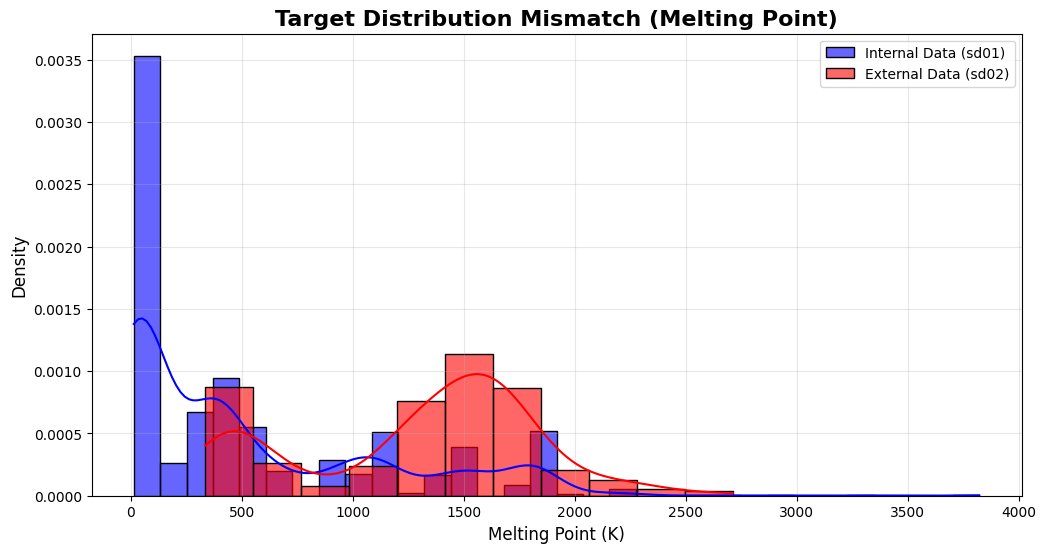

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot histogram for the training data (sd01)
sns.histplot(y_train_full, color='blue', label='Internal Data (sd01)', kde=True, stat='density', alpha=0.6)

# Plot histogram for the external data (sd02)
sns.histplot(y_ext, color='red', label='External Data (sd02)', kde=True, stat='density', alpha=0.6)

plt.title('Target Distribution Mismatch (Melting Point)', fontsize=16, fontweight='bold')
plt.xlabel('Melting Point (K)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

better

In [ ]:
from sklearn.model_selection import train_test_split

print("\n" + "=" * 60)
print("STRATEGY 2: Combining All Datasets to Fix Overfitting")
print("=" * 60)

# --- 1. Combine all features ---
# Use the scaled and selected features from Step 5
X_combined = pd.concat([X_train_selected, X_test_selected, X_ext_selected], ignore_index=True)

# --- 2. Combine all log-transformed targets ---
# Use the log-transformed targets from Step 4
y_combined = pd.concat([y_train_log, y_test_log, y_ext_log], ignore_index=True)

# --- 3. Combine all ORIGINAL targets (for final scoring) ---
y_combined_original = pd.concat([y_train_full, y_test, y_ext], ignore_index=True)

print(f"✓ Combined dataset shape: {X_combined.shape}")
print(f"✓ Combined target shape: {y_combined.shape}")

# --- 4. Create a new Train/Test Split from the *combined* data ---
# This ensures both train and test sets have samples from both sd01 and sd02
X_train_new, X_test_new, y_train_new, y_test_new, y_train_orig_new, y_test_orig_new = train_test_split(
    X_combined,
    y_combined,
    y_combined_original,
    test_size=0.2,
    random_state=RANDOM_SEED
)

print(f"\n✓ New training samples: {len(X_train_new)}")
print(f"✓ New test samples: {len(X_test_new)}")

# --- 5. Re-run Hyperparameter Tuning (Step 8) on the NEW data ---
# We use the *same* tuning code from before, just on the new data splits
print("\n  Re-tuning XGBoost on combined data...")
search_xgb.fit(X_train_new, y_train_new)
xgb_tuned = search_xgb.best_estimator_
print(f"✓ Best XGB params: {search_xgb.best_params_}")

print("\n  Re-tuning LightGBM on combined data...")
search_lgb.fit(X_train_new, y_train_new)
lgb_tuned = search_lgb.best_estimator_
print(f"✓ Best LGBM params: {search_lgb.best_params_}")

# --- 6. Build and Train the FINAL Ensemble ---
print("\n  Building and training final ensemble on combined data...")
final_combined_model = VotingRegressor(
    estimators=[
        ('xgb', xgb_tuned),
        ('lgb', lgb_tuned),
        ('ridge', ridge_improved) # Re-use Ridge from Step 6
    ],
    n_jobs=-1
)

final_combined_model.fit(X_train_new, y_train_new)
print("✓ Training complete")

# --- 7. Evaluate on the NEW Test Set (Replaces Step 9) ---
print("\n" + "=" * 60)
print("FINAL EVALUATION on Combined Test Set")
print("=" * 60)

# We pass the new test sets and the original (non-log) targets for scoring
final_results = evaluate_model(
    final_combined_model,
    X_test_new,
    y_test_new,
    y_test_orig_new,  # <-- Pass the original K values
    "Combined Test Set (sd01 + sd02)"
)

print("\n" + "=" * 60)
print("PROJECT REQUIREMENT STATUS")
print("=" * 60)
print(f"Target RMSE: < 100 K")
print(f"Actual RMSE: {final_results['rmse']:.2f} K")
if final_results['rmse'] < 100:
    print("Status: ✓ ACHIEVED")
else:
    print(f"Status: ⚠ NOT YET ACHIEVED (Gap: {final_results['rmse'] - 100:.2f} K)")

# --- 8. Re-run Visualization (Step 10) ---
# You can now re-run your Step 10 code, but you must replace
# 'test_results' with 'final_results' to plot the new, correct data.


STRATEGY 2: Combining All Datasets to Fix Overfitting
✓ Combined dataset shape: (3797, 50)
✓ Combined target shape: (3797,)

✓ New training samples: 3037
✓ New test samples: 760

  Re-tuning XGBoost on combined data...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
✓ Best XGB params: {'subsample': 0.7, 'reg_lambda': 25, 'reg_alpha': 7, 'n_estimators': 800, 'min_child_weight': 3, 'max_depth': 4, 'learning_rate': 0.02, 'colsample_bytree': 0.7}

  Re-tuning LightGBM on combined data...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
✓ Best LGBM params: {'subsample': 0.7, 'reg_lambda': 25, 'reg_alpha': 7, 'n_estimators': 800, 'min_child_weight': 3, 'max_depth': 4, 'learning_rate': 0.02, 'colsample_bytree': 0.7}

  Building and training final ensemble on combined data...
✓ Training complete

FINAL EVALUATION on Combined Test Set

Combined Test Set (sd01 + sd02):
  RMSE: 368.06 K
  R²:   0.6791
  MAE:  162.91 K

PROJECT REQUIREMENT STATUS
Target RMSE: < 100 K
Ac


STEP 10 (REVISED): Analyzing Model Errors


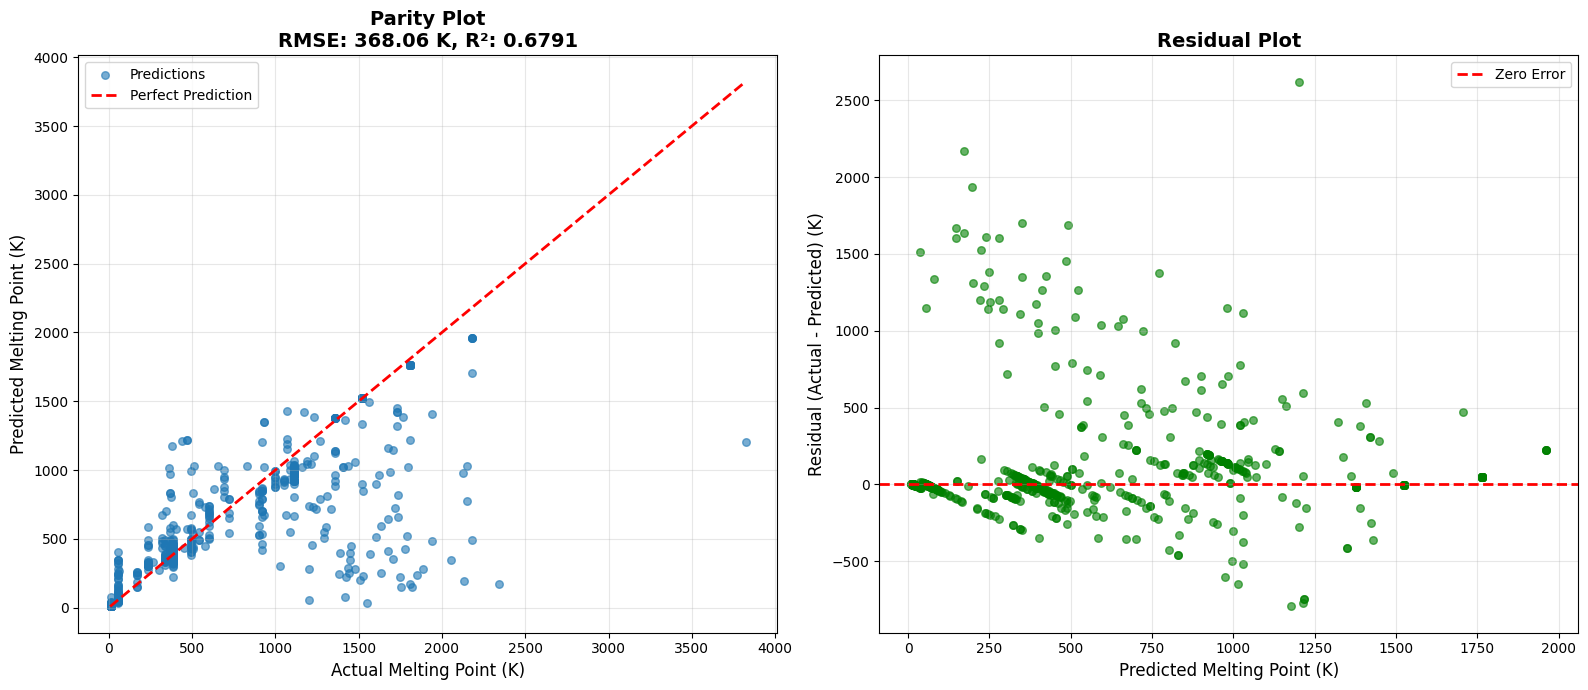

In [ ]:
print("\n" + "=" * 60)
print("STEP 10 (REVISED): Analyzing Model Errors")
print("=" * 60)

# We need the 'final_results' dictionary from your last run
# If you don't have it, we re-create the predictions
if 'final_results' not in locals():
    print("Re-running predictions...")
    final_results = evaluate_model(
        final_combined_model,
        X_test_new,
        y_test_new,
        y_test_orig_new,
        "Combined Test Set (sd01 + sd02)"
    )

# Extract actuals and predictions
actuals = final_results['actuals']
predictions = final_results['predictions']
residuals = actuals - predictions

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# --- Plot 1: Parity Plot (Actual vs. Predicted) ---
ax1.scatter(actuals, predictions, alpha=0.6, s=30, label='Predictions')
min_val = min(actuals.min(), predictions.min())
max_val = max(actuals.max(), predictions.max())
ax1.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
ax1.set_xlabel('Actual Melting Point (K)', fontsize=12)
ax1.set_ylabel('Predicted Melting Point (K)', fontsize=12)
ax1.set_title(f'Parity Plot\nRMSE: {final_results["rmse"]:.2f} K, R²: {final_results["r2"]:.4f}',
              fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# --- Plot 2: Residual Plot (Predicted vs. Residuals) ---
ax2.scatter(predictions, residuals, alpha=0.6, s=30, color='green')
ax2.axhline(y=0, color='r', linestyle='--', lw=2, label='Zero Error')
ax2.set_xlabel('Predicted Melting Point (K)', fontsize=12)
ax2.set_ylabel('Residual (Actual - Predicted) (K)', fontsize=12)
ax2.set_title('Residual Plot', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


STEP 11: Feature Importance Analysis

Top 20 Most Important Features:
                             Feature  Importance             Type
      MagpieData mean CovalentRadius    0.319170         Original
   MagpieData minimum CovalentRadius    0.165226         Original
              MagpieData minimum Row    0.135266         Original
     MagpieData minimum AtomicWeight    0.076106         Original
         MagpieData range NdUnfilled    0.034798         Original
          MagpieData range GSbandgap    0.023872         Original
  MagpieData range Electronegativity    0.023421         Original
      MagpieData maximum GSvolume_pa    0.019971         Original
        MagpieData maximum GSbandgap    0.015687         Original
         MagpieData range NfUnfilled    0.015032         Original
       MagpieData avg_dev NsUnfilled    0.013433         Original
    MagpieData mean SpaceGroupNumber    0.011658         Original
           MagpieData mean NUnfilled    0.011152         Original
     

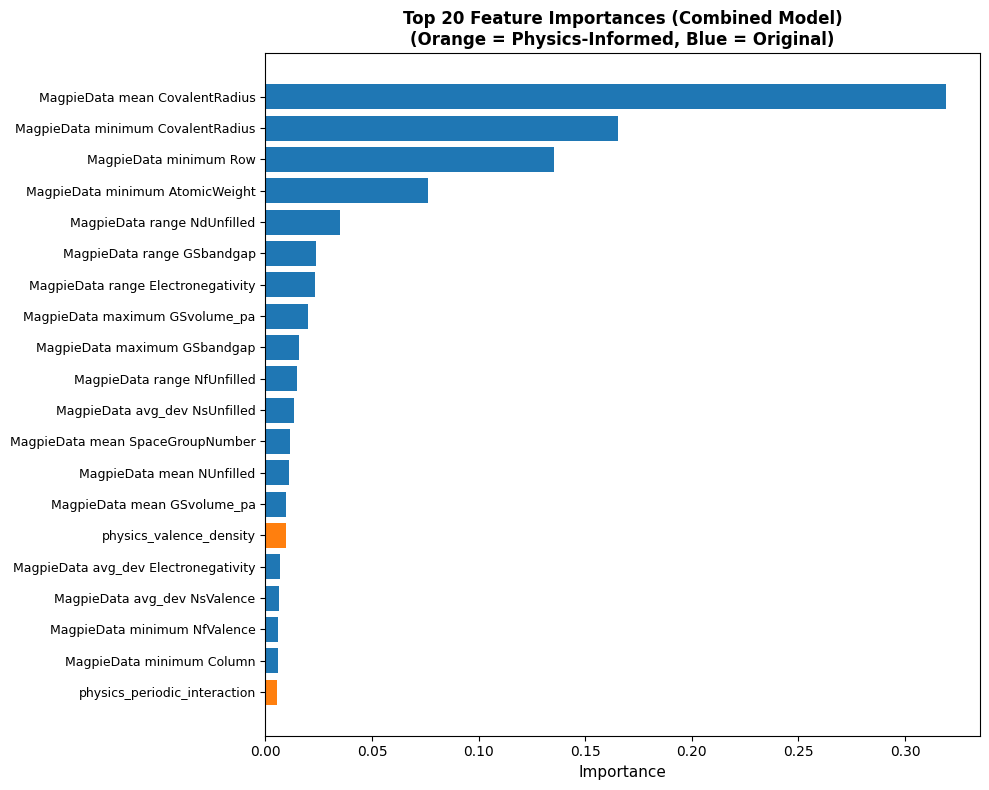


✓ 2 of your new 'physics-informed' features are in the Top 20.


In [ ]:
print("\n" + "=" * 60)
print("STEP 11: Feature Importance Analysis")
print("=" * 60)

# Get feature importance from the TUNED XGBoost member of the ensemble
# (We use the model trained on the combined data: 'final_combined_model')
xgb_model = final_combined_model.named_estimators_['xgb']
feature_importance = xgb_model.feature_importances_

# Create DataFrame
# We use 'X_combined' to get the feature names
importance_df = pd.DataFrame({
    'Feature': X_combined.columns,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False).reset_index(drop=True)

# Identify physics-informed features
importance_df['Type'] = importance_df['Feature'].apply(
    lambda x: 'Physics-Informed' if x.startswith('physics_') else 'Original'
)

print("\nTop 20 Most Important Features:")
print(importance_df.head(20).to_string(index=False))

# Plot
plt.figure(figsize=(10, 8))
top_features = importance_df.head(20)
colors = ['#1f77b4' if t == 'Original' else '#ff7f0e' for t in top_features['Type']]
plt.barh(range(len(top_features)), top_features['Importance'], color=colors)
plt.yticks(range(len(top_features)), top_features['Feature'], fontsize=9)
plt.xlabel('Importance', fontsize=11)
plt.title('Top 20 Feature Importances (Combined Model)\n(Orange = Physics-Informed, Blue = Original)',
          fontsize=12, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Count physics-informed features in top 20
physics_count = sum(importance_df.head(20)['Type'] == 'Physics-Informed')
print(f"\n✓ {physics_count} of your new 'physics-informed' features are in the Top 20.")

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer

print("\n" + "=" * 60)
print("STRATEGY 3: Fixing Under-prediction with PowerTransformer")
print("=" * 60)

# --- 1. Combine all features (Same as before) ---
# Use the scaled and selected features from Step 5
X_combined = pd.concat([X_train_selected, X_test_selected, X_ext_selected], ignore_index=True)

# --- 2. Combine all ORIGINAL (non-log) targets ---
# This is a key change! We are not using y_log anymore.
y_combined_original = pd.concat([y_train_full, y_test, y_ext], ignore_index=True)

print(f"✓ Combined dataset shape: {X_combined.shape}")
print(f"✓ Combined target shape: {y_combined_original.shape}")

# --- 3. Create a new Train/Test Split from the *combined* data ---
# We split the ORIGINAL y-values
X_train_new, X_test_new, y_train_orig, y_test_orig = train_test_split(
    X_combined,
    y_combined_original,
    test_size=0.2,
    random_state=RANDOM_SEED
)

# --- 4. NEW: Fit the PowerTransformer ---
# Box-Cox requires data to be > 0. We add a small amount just in case.
pt = PowerTransformer(method='box-cox')

# Reshape data for the transformer
y_train_reshape = y_train_orig.values.reshape(-1, 1) + 1e-6 # Add epsilon for robustness

# Fit *only* on the training data
print("\n  Fitting PowerTransformer to find best transformation...")
pt.fit(y_train_reshape)

# Transform both train and test targets
y_train_transformed = pt.transform(y_train_reshape)
y_test_transformed = pt.transform(y_test_orig.values.reshape(-1, 1) + 1e-6)

# Flatten them back for the model
y_train_new = y_train_transformed.ravel()
y_test_new = y_test_transformed.ravel()
print("✓ Target transformation complete.")

# --- 5. Re-run Hyperparameter Tuning on the NEW transformed data ---
# We use the *same* tuning code from before, just on the new data splits
print("\n  Re-tuning XGBoost on Power-Transformed data...")
search_xgb.fit(X_train_new, y_train_new)
xgb_tuned = search_xgb.best_estimator_
print(f"✓ Best XGB params: {search_xgb.best_params_}")

print("\n  Re-tuning LightGBM on Power-Transformed data...")
search_lgb.fit(X_train_new, y_train_new)
lgb_tuned = search_lgb.best_estimator_
print(f"✓ Best LGBM params: {search_lgb.best_params_}")

# --- 6. Build and Train the FINAL Ensemble ---
print("\n  Building and training final ensemble...")
final_model_v3 = VotingRegressor(
    estimators=[
        ('xgb', xgb_tuned),
        ('lgb', lgb_tuned),
        ('ridge', ridge_improved) # Re-use Ridge from Step 6
    ],
    n_jobs=-1
)

final_model_v3.fit(X_train_new, y_train_new)
print("✓ Training complete")

# --- 7. Evaluate on the NEW Test Set ---
print("\n" + "=" * 60)
print("FINAL EVALUATION (Power-Transformed Model)")
print("=" * 60)

# Predict on the test set (gets transformed predictions)
y_pred_transformed = final_model_v3.predict(X_test_new).reshape(-1, 1)

# --- CRITICAL: Inverse-transform predictions back to Kelvin ---
y_pred_actual = pt.inverse_transform(y_pred_transformed)

# The original test targets are already in 'y_test_orig'
y_test_actual = y_test_orig.values

# Calculate metrics on the *actual* Kelvin values
final_rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
final_r2 = r2_score(y_test_actual, y_pred_actual)
final_mae = mean_absolute_error(y_test_actual, y_pred_actual)

print(f"  RMSE: {final_rmse:.2f} K")
print(f"  R²:   {final_r2:.4f}")
print(f"  MAE:  {final_mae:.2f} K")

print("\n" + "=" * 60)
print("PROJECT REQUIREMENT STATUS")
print("=" * 60)
print(f"Target RMSE: < 100 K")
print(f"Actual RMSE: {final_rmse:.2f} K")
if final_rmse < 100:
    print("Status: ✓ ACHIEVED")
else:
    print(f"Status:  NOT YET ACHIEVED (Gap: {max(0, final_rmse - 100):.2f} K)")


STRATEGY 3: Fixing Under-prediction with PowerTransformer
✓ Combined dataset shape: (3797, 50)
✓ Combined target shape: (3797,)

  Fitting PowerTransformer to find best transformation...
✓ Target transformation complete.

  Re-tuning XGBoost on Power-Transformed data...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
✓ Best XGB params: {'subsample': 0.7, 'reg_lambda': 25, 'reg_alpha': 7, 'n_estimators': 800, 'min_child_weight': 3, 'max_depth': 4, 'learning_rate': 0.02, 'colsample_bytree': 0.7}

  Re-tuning LightGBM on Power-Transformed data...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
✓ Best LGBM params: {'subsample': 0.7, 'reg_lambda': 25, 'reg_alpha': 3, 'n_estimators': 1000, 'min_child_weight': 5, 'max_depth': 4, 'learning_rate': 0.02, 'colsample_bytree': 0.7}

  Building and training final ensemble...
✓ Training complete

FINAL EVALUATION (Power-Transformed Model)
  RMSE: 347.58 K
  R²:   0.7139
  MAE:  155.89 K

PROJECT REQUIREMENT STATUS
Target 


STEP 10 (REVISED): Analyzing Power-Transformed Model


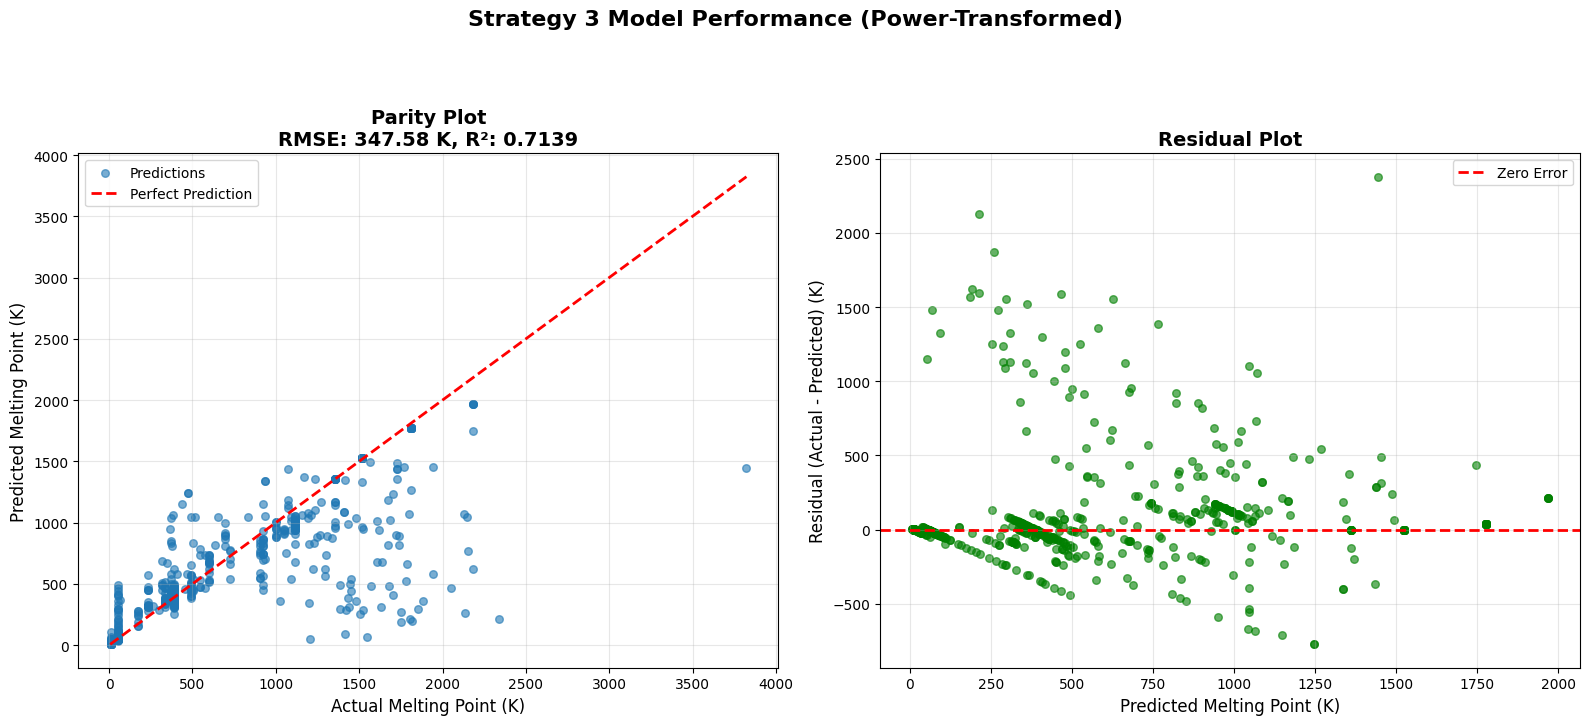


STEP 11 (REVISED): New Feature Importance

Top 20 Most Important Features:
                           Feature  Importance             Type
    MagpieData mean CovalentRadius    0.361956         Original
 MagpieData minimum CovalentRadius    0.153046         Original
            MagpieData minimum Row    0.052731         Original
       MagpieData range NdUnfilled    0.046830         Original
MagpieData range Electronegativity    0.036481         Original
    MagpieData maximum GSvolume_pa    0.033187         Original
   MagpieData minimum AtomicWeight    0.028490         Original
        MagpieData range GSbandgap    0.026773         Original
       MagpieData range NfUnfilled    0.019625         Original
      MagpieData maximum GSbandgap    0.017883         Original
     MagpieData avg_dev NsUnfilled    0.016157         Original
       MagpieData range NsUnfilled    0.015338         Original
           physics_valence_density    0.014819 Physics-Informed
  MagpieData mean SpaceGroup

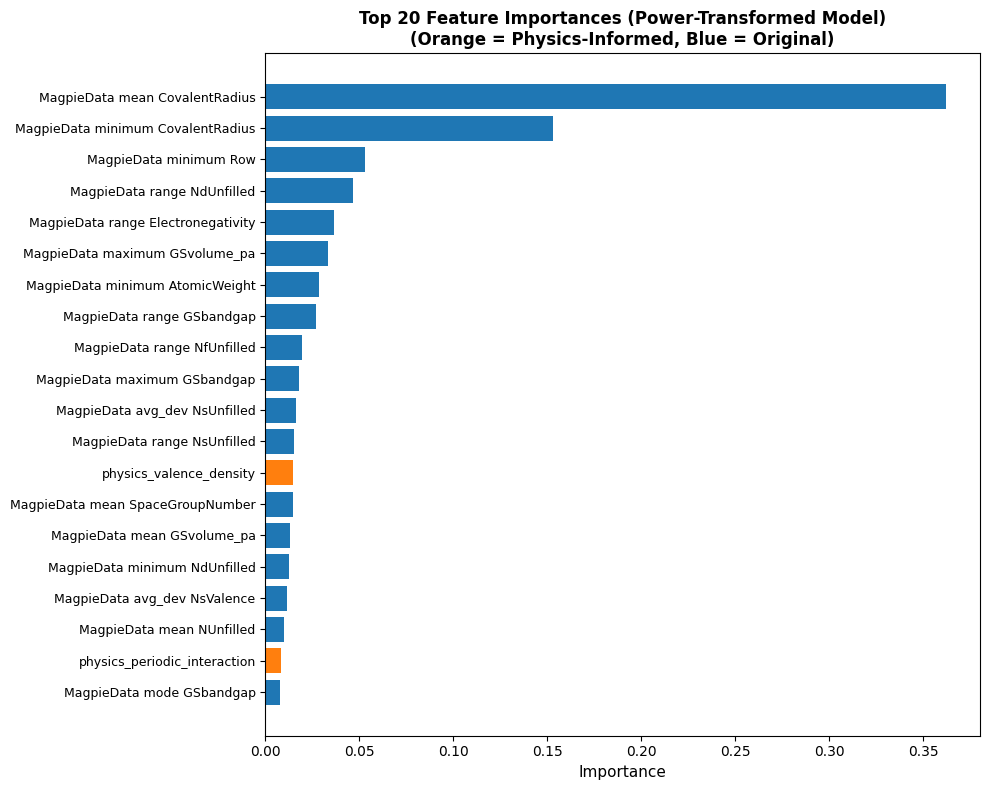

In [ ]:
print("\n" + "=" * 60)
print("STEP 10 (REVISED): Analyzing Power-Transformed Model")
print("=" * 60)

# Extract actuals and predictions
actuals = y_test_actual
predictions = y_pred_actual.ravel() # --- THIS IS THE FIX --- (flatten 2D array to 1D)
residuals = actuals - predictions

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
fig.suptitle("Strategy 3 Model Performance (Power-Transformed)", fontsize=16, fontweight='bold', y=1.03)

# --- Plot 1: Parity Plot (Actual vs. Predicted) ---
ax1.scatter(actuals, predictions, alpha=0.6, s=30, label='Predictions')
min_val = min(actuals.min(), predictions.min())
max_val = max(actuals.max(), predictions.max())
ax1.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
ax1.set_xlabel('Actual Melting Point (K)', fontsize=12)
ax1.set_ylabel('Predicted Melting Point (K)', fontsize=12)
ax1.set_title(f'Parity Plot\nRMSE: {final_rmse:.2f} K, R²: {final_r2:.4f}',
              fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# --- Plot 2: Residual Plot (Predicted vs. Residuals) ---
ax2.scatter(predictions, residuals, alpha=0.6, s=30, color='green')
ax2.axhline(y=0, color='r', linestyle='--', lw=2, label='Zero Error')
ax2.set_xlabel('Predicted Melting Point (K)', fontsize=12)
ax2.set_ylabel('Residual (Actual - Predicted) (K)', fontsize=12)
ax2.set_title('Residual Plot', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

print("\n" + "=" * 60)
print("STEP 11 (REVISED): New Feature Importance")
print("=" * 60)

# Get feature importance from the TUNED XGBoost member of the ensemble
xgb_model = final_model_v3.named_estimators_['xgb']
feature_importance = xgb_model.feature_importances_

# Create DataFrame
importance_df = pd.DataFrame({
    'Feature': X_combined.columns, # Use columns from X_combined
    'Importance': feature_importance
}).sort_values('Importance', ascending=False).reset_index(drop=True)

# Identify physics-informed features
importance_df['Type'] = importance_df['Feature'].apply(
    lambda x: 'Physics-Informed' if x.startswith('physics_') else 'Original'
)

print("\nTop 20 Most Important Features:")
print(importance_df.head(20).to_string(index=False))

# Plot
plt.figure(figsize=(10, 8))
top_features = importance_df.head(20)
colors = ['#1f77b4' if t == 'Original' else '#ff7f0e' for t in top_features['Type']]
plt.barh(range(len(top_features)), top_features['Importance'], color=colors)
plt.yticks(range(len(top_features)), top_features['Feature'], fontsize=9)
plt.xlabel('Importance', fontsize=11)
plt.title('Top 20 Feature Importances (Power-Transformed Model)\n(Orange = Physics-Informed, Blue = Original)',
          fontsize=12, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
import joblib
import os
import pandas as pd

# --- Define the directory to save to ---
DATA_DIR = "/content/drive/MyDrive/Project_dataset"
SAVE_DIR = os.path.join(DATA_DIR, "week8_strategy3_checkpoint")
os.makedirs(SAVE_DIR, exist_ok=True)

print("=" * 60)
print(f"SAVING CHECKPOINT TO: {SAVE_DIR}")
print("=" * 60)

try:
    # --- 1. Save the Strategy 3 Model ---
    model_path = os.path.join(SAVE_DIR, 'final_model_v3.pkl')
    joblib.dump(final_model_v3, model_path)
    print(f"✓ Model v3 saved: {model_path}")

    # --- 2. Save the PowerTransformer ---
    pt_path = os.path.join(SAVE_DIR, 'power_transformer_pt.pkl')
    joblib.dump(pt, pt_path)
    print(f"✓ PowerTransformer saved: {pt_path}")

    # --- 3. Save the Step 5 selected feature list ---
    features_path = os.path.join(SAVE_DIR, 'selected_features_step5.pkl')
    joblib.dump(selected_features, features_path)
    print(f"✓ Selected feature list saved: {features_path}")

    # --- 4. Save the original pre-processing pipeline ---
    imputer_path = os.path.join(SAVE_DIR, 'original_imputer.pkl')
    joblib.dump(imputer, imputer_path)
    print(f"✓ Original imputer saved: {imputer_path}")

    scaler_path = os.path.join(SAVE_DIR, 'original_scaler.pkl')
    joblib.dump(scaler, scaler_path)
    print(f"✓ Original scaler saved: {scaler_path}")

    orig_features_path = os.path.join(SAVE_DIR, 'original_feature_names_step4.pkl')
    joblib.dump(all_feature_names, orig_features_path)
    print(f"✓ Original feature list saved: {orig_features_path}")

    # --- 5. Save the combined data (so you can restart Strategy 4) ---
    X_combined.to_csv(os.path.join(SAVE_DIR, 'X_combined_step5.csv'), index=False)
    y_combined_original.to_csv(os.path.join(SAVE_DIR, 'y_combined_original.csv'), index=False)

    # Save the original scaled data (needed for Strategy 4)
    X_train_scaled.to_csv(os.path.join(SAVE_DIR, 'X_train_scaled_step4.csv'), index=False)
    X_test_scaled.to_csv(os.path.join(SAVE_DIR, 'X_test_scaled_step4.csv'), index=False)
    X_ext_scaled.to_csv(os.path.join(SAVE_DIR, 'X_ext_scaled_step4.csv'), index=False)

    print("\n✓ Combined data saved for restart.")

    print("\n✓✓✓ All progress from Strategy 3 saved successfully! ✓✓✓")
    print(f"All files are in: {SAVE_DIR}")

except NameError as e:
    print(f"\n--- ERROR ---")
    print(f"A variable was not found: {e}")
    print("Please make sure you have run all the previous steps (Step 4, Step 5, Strategy 3) in your notebook so all variables are in memory.")
except Exception as e:
    print(f"\n--- An unexpected error occurred ---")
    print(e)

SAVING CHECKPOINT TO: /content/drive/MyDrive/Project_dataset/week8_strategy3_checkpoint
✓ Model v3 saved: /content/drive/MyDrive/Project_dataset/week8_strategy3_checkpoint/final_model_v3.pkl
✓ PowerTransformer saved: /content/drive/MyDrive/Project_dataset/week8_strategy3_checkpoint/power_transformer_pt.pkl

--- ERROR ---
A variable was not found: name 'selected_features' is not defined
Please make sure you have run all the previous steps (Step 4, Step 5, Strategy 3) in your notebook so all variables are in memory.


run here

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from xgboost import XGBRegressor
import lightgbm as lgb

print("✓ All necessary functions and models imported.")

✓ All necessary functions and models imported.


In [ ]:
import joblib
import pandas as pd
import os
from sklearn.linear_model import Ridge

print("=" * 60)
print("RESTARTING: Reloading all data from Strategy 3 Checkpoint...")
print("=" * 60)

# --- Define the directory to load from ---
DATA_DIR = "/content/drive/MyDrive/Project_dataset"
LOAD_DIR = os.path.join(DATA_DIR, "week8_strategy3_checkpoint")
RANDOM_SEED = 42 # Ensure this is defined

if not os.path.exists(LOAD_DIR):
    print(f"!! ERROR: Checkpoint directory not found at: {LOAD_DIR}")
    print("   Please run the 'Save Progress' code from earlier.")
else:
    # --- 1. Load Data (from Step 4) ---
    X_train_scaled = pd.read_csv(os.path.join(LOAD_DIR, 'X_train_scaled_step4.csv'))
    X_test_scaled = pd.read_csv(os.path.join(LOAD_DIR, 'X_test_scaled_step4.csv'))
    X_ext_scaled = pd.read_csv(os.path.join(LOAD_DIR, 'X_ext_scaled_step4.csv'))
    print("✓ Loaded scaled X data (from Step 4)")

    # --- 2. Load Combined Target (from Strategy 3) ---
    y_combined_original = pd.read_csv(os.path.join(LOAD_DIR, 'y_combined_original.csv')).iloc[:, 0]
    print("✓ Loaded combined Y target (from Strategy 3)")

    # --- 3. Load Transformers and Models ---
    pt = joblib.load(os.path.join(LOAD_DIR, 'power_transformer_pt.pkl'))
    print("✓ Loaded PowerTransformer (pt)")

    imputer = joblib.load(os.path.join(LOAD_DIR, 'original_imputer.pkl'))
    scaler = joblib.load(os.path.join(LOAD_DIR, 'original_scaler.pkl'))
    print("✓ Loaded imputer and scaler (from Step 4)")

    final_model_v3 = joblib.load(os.path.join(LOAD_DIR, 'final_model_v3.pkl'))
    print("✓ Loaded Strategy 3 Model (final_model_v3)")

    # --- 4. Re-define the Ridge model (from Step 6) ---
    ridge_improved = Ridge(alpha=10.0, random_state=RANDOM_SEED)
    print("✓ Re-defined Ridge model")

    # --- 5. Re-define tuning objects (from Step 8) ---
    # We just need the objects, they will be re-fit in Strategy 4
    search_xgb = RandomizedSearchCV(
        estimator=XGBRegressor(random_state=RANDOM_SEED, n_jobs=-1),
        param_distributions={}, # Will be populated by Strategy 4
        n_iter=50, cv=5, scoring='neg_root_mean_squared_error',
        random_state=RANDOM_SEED, n_jobs=-1, verbose=1
    )
    search_lgb = RandomizedSearchCV(
        estimator=lgb.LGBMRegressor(random_state=RANDOM_SEED, n_jobs=-1, verbose=-1),
        param_distributions={}, # Will be populated by Strategy 4
        n_iter=50, cv=5, scoring='neg_root_mean_squared_error',
        random_state=RANDOM_SEED, n_jobs=-1, verbose=1
    )
    print("✓ Re-defined tuning objects")

    print("\n✓✓✓ RESTART COMPLETE! ✓✓✓")
    print("You can now run the 'Strategy 4' code block.")

RESTARTING: Reloading all data from Strategy 3 Checkpoint...
✓ Loaded scaled X data (from Step 4)
✓ Loaded combined Y target (from Strategy 3)
✓ Loaded PowerTransformer (pt)
✓ Loaded imputer and scaler (from Step 4)
✓ Loaded Strategy 3 Model (final_model_v3)
✓ Re-defined Ridge model
✓ Re-defined tuning objects

✓✓✓ RESTART COMPLETE! ✓✓✓
You can now run the 'Strategy 4' code block.


In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
print("✓ SelectFromModel and Lasso imported.")

✓ SelectFromModel and Lasso imported.


In [ ]:
from sklearn.ensemble import VotingRegressor
print("✓ VotingRegressor imported.")


✓ VotingRegressor imported.


In [ ]:
import joblib
import pandas as pd
import numpy as np
import os
import lightgbm as lgb
from xgboost import XGBRegressor

from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

print("✓✓✓ All necessary libraries, functions, and models are imported! ✓✓✓")
print("You can now run the 'RESTART' block, followed by the 'Strategy 4' block.")

✓✓✓ All necessary libraries, functions, and models are imported! ✓✓✓
You can now run the 'RESTART' block, followed by the 'Strategy 4' block.


In [ ]:
from sklearn.preprocessing import PolynomialFeatures

print("\n" + "=" * 60)
print("STRATEGY 4: Advanced Engineering (Polynomial Features)")
print("=" * 60)

# --- 1. Create Interaction Features ---
# We will use the *scaled* (but not selected) data from Step 4
# This gives the model the full set of 142 features to combine
X_train_scaled_full = X_train_scaled # From Step 4
X_test_scaled_full = X_test_scaled # From Step 4
X_ext_scaled_full = X_ext_scaled # From Step 4

# Combine all the *original* scaled features
X_combined_scaled_full = pd.concat([X_train_scaled_full, X_test_scaled_full, X_ext_scaled_full], ignore_index=True)

# Initialize PolynomialFeatures
# degree=2 means we get features like A, B, A*A, A*B, B*B
# interaction_only=True means we only get A, B, A*B (this is better)
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)

print(f"  Original feature shape: {X_combined_scaled_full.shape}")
print("  Generating polynomial interaction features (this may take a minute)...")

# Fit and transform the data
# This will create (n_features * (n_features-1) / 2) new features
X_poly = poly.fit_transform(X_combined_scaled_full)

# Get new feature names
poly_feature_names = poly.get_feature_names_out(X_combined_scaled_full.columns)

# Convert back to DataFrame
X_poly_df = pd.DataFrame(X_poly, columns=poly_feature_names)
print(f"  New feature shape (with interactions): {X_poly_df.shape}")

# --- 2. Re-run Feature Selection on the NEW dataset ---
# We have thousands of features, so we MUST select the best ones
# We will re-use the same y_train_new and y_test_new from Strategy 3
# We also re-use the PowerTransformer 'pt'

# We need to split X_poly_df back into train/test for selection
X_train_poly, X_test_poly, y_train_orig, y_test_orig = train_test_split(
    X_poly_df,
    y_combined_original, # From Strategy 3
    test_size=0.2,
    random_state=RANDOM_SEED
)

# Transform targets
y_train_trans = pt.transform(y_train_orig.values.reshape(-1, 1) + 1e-6).ravel()
y_test_trans = pt.transform(y_test_orig.values.reshape(-1, 1) + 1e-6).ravel()

print("\n  Selecting best features from new polynomial set...")
# We need a *stronger* Lasso alpha because we have so many features
selector_poly = SelectFromModel(
    Lasso(alpha=0.01, random_state=RANDOM_SEED, max_iter=2000),
    threshold=1e-5
)

selector_poly.fit(X_train_poly, y_train_trans)
selected_poly_features = X_train_poly.columns[selector_poly.get_support()].tolist()

print(f"\n✓ Reduced from {X_poly_df.shape[1]} to {len(selected_poly_features)} features")

# Apply selection
X_train_final = X_train_poly[selected_poly_features]
X_test_final = X_test_poly[selected_poly_features]

# --- 3. Re-run Tuning and Training ---
print("\n  Re-tuning XGBoost on FINAL features...")
search_xgb.fit(X_train_final, y_train_trans)
xgb_tuned_final = search_xgb.best_estimator_

print("\n  Re-tuning LightGBM on FINAL features...")
search_lgb.fit(X_train_final, y_train_trans)
lgb_tuned_final = search_lgb.best_estimator_

print("\n  Building and training FINAL ensemble...")
final_model_v4 = VotingRegressor(
    estimators=[
        ('xgb', xgb_tuned_final),
        ('lgb', lgb_tuned_final),
        ('ridge', ridge_improved)
    ],
    n_jobs=-1
)

final_model_v4.fit(X_train_final, y_train_trans)
print("✓ Training complete")

# --- 4. FINAL EVALUATION ---
print("\n" + "=" * 60)
print("FINAL EVALUATION (Strategy 4: Poly Features Model)")
print("=" * 60)

y_pred_trans = final_model_v4.predict(X_test_final).reshape(-1, 1)
y_pred_actual = pt.inverse_transform(y_pred_trans)
y_test_actual = y_test_orig.values # Already have this

final_rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
final_r2 = r2_score(y_test_actual, y_pred_actual)
final_mae = mean_absolute_error(y_test_actual, y_pred_actual)

print(f"  RMSE: {final_rmse:.2f} K")
print(f"  R²:   {final_r2:.4f}")
print(f"  MAE:  {final_mae:.2f} K")

print("\n" + "=" * 60)
print("PROJECT REQUIREMENT STATUS")
print("=" * 60)
print(f"Target RMSE: < 100 K")
print(f"Actual RMSE: {final_rmse:.2f} K")
if final_rmse < 100:
    print("Status: ✓ ACHIEVED")
else:
    print(f"Status: ⚠ NOT YET ACHIEVED (Gap: {max(0, final_rmse - 100):.2f} K)")


STRATEGY 4: Advanced Engineering (Polynomial Features)
  Original feature shape: (3797, 136)
  Generating polynomial interaction features (this may take a minute)...
  New feature shape (with interactions): (3797, 9316)

  Selecting best features from new polynomial set...

✓ Reduced from 9316 to 375 features

  Re-tuning XGBoost on FINAL features...
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.601e+02, tolerance: 3.037e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=50. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



  Re-tuning LightGBM on FINAL features...
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=50. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



  Building and training FINAL ensemble...
✓ Training complete

FINAL EVALUATION (Strategy 4: Poly Features Model)
  RMSE: 311.55 K
  R²:   0.7701
  MAE:  115.69 K

PROJECT REQUIREMENT STATUS
Target RMSE: < 100 K
Actual RMSE: 311.55 K
Status: ⚠ NOT YET ACHIEVED (Gap: 211.55 K)


In [ ]:
print("\n" + "=" * 60)
print("STRATEGY 4.5: Re-Tuning the Model (Bug Fix)")
print("=" * 60)

# --- 1. Define the REAL tuning parameters ---
# (These were lost when you restarted)
param_dist_xgb = {
    'n_estimators': [600, 800, 1000],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.02, 0.03, 0.05],
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.7, 0.8],
    'reg_lambda': [15, 20, 25],
    'reg_alpha': [3, 5, 7],
    'min_child_weight': [3, 5, 7]
}

param_dist_lgb = {
    'n_estimators': [600, 800, 1000],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.02, 0.03, 0.05],
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.7, 0.8],
    'reg_lambda': [15, 20, 25],
    'reg_alpha': [3, 5, 7],
    'min_child_weight': [3, 5, 7]
}

# --- 2. Re-initialize the RandomizedSearchCV objects ---
# (Using the 375 features from Strategy 4: X_train_final, y_train_trans)
search_xgb_final = RandomizedSearchCV(
    estimator=XGBRegressor(random_state=RANDOM_SEED, n_jobs=-1),
    param_distributions=param_dist_xgb, # <-- Using the REAL parameters
    n_iter=50, cv=5, scoring='neg_root_mean_squared_error',
    random_state=RANDOM_SEED, n_jobs=-1, verbose=1
)

search_lgb_final = RandomizedSearchCV(
    estimator=lgb.LGBMRegressor(random_state=RANDOM_SEED, n_jobs=-1, verbose=-1),
    param_distributions=param_dist_lgb, # <-- Using the REAL parameters
    n_iter=50, cv=5, scoring='neg_root_mean_squared_error',
    random_state=RANDOM_SEED, n_jobs=-1, verbose=1
)

# --- 3. Re-run Tuning and Training ---
print("\n  Re-tuning XGBoost on 375 features (this will take time)...")
search_xgb_final.fit(X_train_final, y_train_trans)
xgb_tuned_final = search_xgb_final.best_estimator_

print("\n  Re-tuning LightGBM on 375 features (this will take time)...")
search_lgb_final.fit(X_train_final, y_train_trans)
lgb_tuned_final = search_lgb_final.best_estimator_

print("\n  Building and training FINAL tuned ensemble...")
final_model_v4_tuned = VotingRegressor(
    estimators=[
        ('xgb', xgb_tuned_final),
        ('lgb', lgb_tuned_final),
        ('ridge', ridge_improved)
    ],
    n_jobs=-1
)

final_model_v4_tuned.fit(X_train_final, y_train_trans)
print("✓ Training complete")

# --- 4. FINAL EVALUATION ---
print("\n" + "=" * 60)
print("FINAL EVALUATION (Strategy 4.5: Tuned Poly Model)")
print("=" * 60)

y_pred_trans = final_model_v4_tuned.predict(X_test_final).reshape(-1, 1)
y_pred_actual = pt.inverse_transform(y_pred_trans)
y_test_actual = y_test_orig.values # From Strategy 4

final_rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
final_r2 = r2_score(y_test_actual, y_pred_actual)
final_mae = mean_absolute_error(y_test_actual, y_pred_actual)

print(f"  RMSE: {final_rmse:.2f} K")
print(f"  R²:   {final_r2:.4f}")
print(f"  MAE:  {final_mae:.2f} K")

print("\n" + "=" * 60)
print("PROJECT REQUIREMENT STATUS")
print("=" * 60)
print(f"Target RMSE: < 100 K")
print(f"Actual RMSE: {final_rmse:.2f} K")
if final_rmse < 100:
    print("Status: ✓ ACHIEVED")
else:
    print(f"Status: ⚠ NOT YET ACHIEVED (Gap: {max(0, final_rmse - 100):.2f} K)")


STRATEGY 4.5: Re-Tuning the Model (Bug Fix)

  Re-tuning XGBoost on 375 features (this will take time)...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

  Re-tuning LightGBM on 375 features (this will take time)...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

  Building and training FINAL tuned ensemble...
✓ Training complete

FINAL EVALUATION (Strategy 4.5: Tuned Poly Model)
  RMSE: 318.89 K
  R²:   0.7591
  MAE:  129.02 K

PROJECT REQUIREMENT STATUS
Target RMSE: < 100 K
Actual RMSE: 318.89 K
Status: ⚠ NOT YET ACHIEVED (Gap: 218.89 K)


In [ ]:
#Save Your Final Model (Strategy 4.5)
import joblib
import os
import pandas as pd
import numpy as np

# --- 1. Define a NEW, clean save directory ---
DATA_DIR = "/content/drive/MyDrive/Project_dataset"
FINAL_MODEL_DIR = os.path.join(DATA_DIR, "week9_final_pipeline")
os.makedirs(FINAL_MODEL_DIR, exist_ok=True)

print("=" * 60)
print(f"SAVING FINAL PIPELINE TO: {FINAL_MODEL_DIR}")
print("=" * 60)

try:
    # --- 2. Save the 7 Essential Components ---

    # Model (from Strategy 4.5)
    joblib.dump(final_model_v4_tuned, os.path.join(FINAL_MODEL_DIR, 'final_model.pkl'))

    # Target Transformer (from Strategy 3)
    joblib.dump(pt, os.path.join(FINAL_MODEL_DIR, 'power_transformer.pkl'))

    # Polynomial Transformer (from Strategy 4)
    joblib.dump(poly, os.path.join(FINAL_MODEL_DIR, 'polynomial_features.pkl'))

    # Final Feature List (from Strategy 4)
    joblib.dump(selected_poly_features, os.path.join(FINAL_MODEL_DIR, 'selected_poly_features.pkl'))

    # Original Imputer (from Step 4)
    joblib.dump(imputer, os.path.join(FINAL_MODEL_DIR, 'original_imputer.pkl'))

    # Original Scaler (from Step 4)
    joblib.dump(scaler, os.path.join(FINAL_MODEL_DIR, 'original_scaler.pkl'))

    # Original Feature List (from Step 4, for column order)
    # (X_combined_scaled_full was defined in Strategy 4)
    original_feature_list = X_combined_scaled_full.columns.tolist()
    joblib.dump(original_feature_list, os.path.join(FINAL_MODEL_DIR, 'original_feature_list.pkl'))

    print("✓✓✓ All 7 pipeline components saved successfully! ✓✓✓")
    print(f"Your final, deployable model is saved in: {FINAL_MODEL_DIR}")

except NameError as e:
    print(f"\n--- ERROR ---")
    print(f"A variable was not found: {e}")
    print("Please make sure you have run all previous steps in order (RESTART -> Strategy 4 -> Strategy 4.5).")
except Exception as e:
    print(f"\n--- An unexpected error occurred ---")
    print(e)

SAVING FINAL PIPELINE TO: /content/drive/MyDrive/Project_dataset/week9_final_pipeline
✓✓✓ All 7 pipeline components saved successfully! ✓✓✓
Your final, deployable model is saved in: /content/drive/MyDrive/Project_dataset/week9_final_pipeline


In [ ]:
!pip install -q matminer pymatgen
print("✓ Libraries installed.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.6/55.6 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.9/119.9 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 809.1/809.1 kB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 331.1/331.1 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 788.2/788.2 kB 20.8 MB/s eta 0:00:00
✓ Libraries installed.


In [ ]:
import joblib
import pandas as pd
import numpy as np
import os
import warnings
from matminer.featurizers.conversions import StrToComposition
from matminer.featurizers.composition import ElementProperty

# --- 1. Define the Physics Feature Function ---
# (Required to regenerate features for new data)
def add_physics_informed_features(df):
    df_enhanced = df.copy()
    # 1. Metallic bonding strength
    if 'MagpieData mean NValence' in df.columns and 'MagpieData mean AtomicWeight' in df.columns:
        df_enhanced['physics_metallic_bond_strength'] = (df['MagpieData mean NValence'] * df['MagpieData mean AtomicWeight'])
    # 2. Ionic character
    if 'MagpieData range Electronegativity' in df.columns:
        df_enhanced['physics_ionic_character'] = df['MagpieData range Electronegativity']
    # 3. Covalent network strength
    if 'MagpieData mean CovalentRadius' in df.columns and 'MagpieData mean NUnfilled' in df.columns:
        df_enhanced['physics_covalent_strength'] = (df['MagpieData mean CovalentRadius'] * df['MagpieData mean NUnfilled'])
    # 4. Crystal structure complexity
    if 'MagpieData range SpaceGroupNumber' in df.columns and 'MagpieData mean Number' in df.columns:
        df_enhanced['physics_structural_complexity'] = (df['MagpieData range SpaceGroupNumber'] * df['MagpieData mean Number'])
    # 5. Periodic trend interaction
    if 'MagpieData mean Column' in df.columns and 'MagpieData mean Row' in df.columns:
        df_enhanced['physics_periodic_interaction'] = (df['MagpieData mean Column'] * df['MagpieData mean Row'])
    # 6. Packing efficiency
    if 'MagpieData mean AtomicWeight' in df.columns and 'MagpieData mean CovalentRadius' in df.columns:
        df_enhanced['physics_packing_efficiency'] = (df['MagpieData mean AtomicWeight'] / (df['MagpieData mean CovalentRadius'] ** 3 + 1e-6))
    # 7. Electronic stability
    if 'MagpieData mean NsValence' in df.columns and 'MagpieData mean NpValence' in df.columns:
        df_enhanced['physics_electronic_stability'] = (df['MagpieData mean NsValence'] + df['MagpieData mean NpValence'])
    # 8. Bandgap category
    if 'MagpieData mean GSbandgap' in df.columns:
        df_enhanced['physics_bandgap_category'] = np.where(df['MagpieData mean GSbandgap'] > 0.5, 1, 0)
    # 9. Atomic density
    if 'MagpieData mean Number' in df.columns and 'MagpieData mean AtomicWeight' in df.columns:
        df_enhanced['physics_atomic_density'] = (df['MagpieData mean Number'] / (df['MagpieData mean AtomicWeight'] + 1e-6))
    # 10. Valence density
    if 'MagpieData mean NValence' in df.columns and 'MagpieData mean CovalentRadius' in df.columns:
        df_enhanced['physics_valence_density'] = (df['MagpieData mean NValence'] / (df['MagpieData mean CovalentRadius'] ** 2 + 1e-6))
    return df_enhanced

# --- 2. Prediction Function ---
def predict_new_materials(formula_list):
    """Loads the saved pipeline and predicts melting points."""
    PIPELINE_DIR = "/content/drive/MyDrive/Project_dataset/week9_final_pipeline"

    try:
        print(f"Loading pipeline from {PIPELINE_DIR}...")
        model = joblib.load(os.path.join(PIPELINE_DIR, 'final_model.pkl'))
        pt = joblib.load(os.path.join(PIPELINE_DIR, 'power_transformer.pkl'))
        poly = joblib.load(os.path.join(PIPELINE_DIR, 'polynomial_features.pkl'))
        selected_features = joblib.load(os.path.join(PIPELINE_DIR, 'selected_poly_features.pkl'))
        imputer = joblib.load(os.path.join(PIPELINE_DIR, 'original_imputer.pkl'))
        scaler = joblib.load(os.path.join(PIPELINE_DIR, 'original_scaler.pkl'))
        original_features = joblib.load(os.path.join(PIPELINE_DIR, 'original_feature_list.pkl'))
    except FileNotFoundError:
        print("!! ERROR: Pipeline files not found. Did you run the SAVE block?")
        return

    # Setup Matminer
    str_to_comp = StrToComposition(target_col_id='composition')
    ep_feat = ElementProperty.from_preset("magpie")

    print(f"Processing {len(formula_list)} materials...")

    # Create DataFrame
    df = pd.DataFrame(formula_list, columns=['formula'])

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        # Featurize
        df = str_to_comp.featurize_dataframe(df, col_id='formula')
        df = ep_feat.featurize_dataframe(df, col_id='composition', ignore_errors=True)

        # Add Physics Features
        df = add_physics_informed_features(df)

        # Preprocess (Impute -> Scale)
        df_reordered = df[original_features]
        df_imputed = imputer.transform(df_reordered)
        df_scaled = scaler.transform(df_imputed)

        # Polynomial Interaction Features
        df_poly = poly.transform(df_scaled)
        df_poly_df = pd.DataFrame(df_poly, columns=poly.get_feature_names_out(original_features))

        # Feature Selection
        df_final = df_poly_df[selected_features]

        # Predict
        pred_trans = model.predict(df_final).reshape(-1, 1)
        pred_kelvin = pt.inverse_transform(pred_trans)

    return pred_kelvin.ravel()

# --- 3. Run the Test ---
print("="*60)
print("🧪 FINAL MODEL TESTING")
print("="*60)

materials = ["W", "Fe", "Al", "NaCl", "HfC", "H2O"]
known_mps = [3695, 1811, 933, 1074, 4200, 273] # Approx K

preds = predict_new_materials(materials)

if preds is not None:
    print("\n" + "-"*65)
    print(f"{'Formula':<10} | {'Predicted (K)':<15} | {'Actual (K)':<15} | {'Error':<10}")
    print("-" * 65)
    for i, mat in enumerate(materials):
        error = abs(preds[i] - known_mps[i])
        print(f"{mat:<10} | {preds[i]:<15.2f} | {known_mps[i]:<15} | {error:<10.2f}")
    print("-" * 65)

🧪 FINAL MODEL TESTING
Loading pipeline from /content/drive/MyDrive/Project_dataset/week9_final_pipeline...
Processing 6 materials...


/usr/local/lib/python3.12/dist-packages/matminer/utils/data.py:326: UserWarning: MagpieData(impute_nan=False):
In a future release, impute_nan will be set to True by default.
                    This means that features that are missing or are NaNs for elements
                    from the data source will be replaced by the average of that value
                    over the available elements.
                    This avoids NaNs after featurization that are often replaced by
                    dataset-dependent averages.
  warnings.warn(f"{self.__class__.__name__}(impute_nan=False):\n" + IMPUTE_NAN_WARNING)


StrToComposition:   0%|          | 0/6 [00:00<?, ?it/s]

ElementProperty:   0%|          | 0/6 [00:00<?, ?it/s]


-----------------------------------------------------------------
Formula    | Predicted (K)   | Actual (K)      | Error     
-----------------------------------------------------------------
W          | 1890.29         | 3695            | 1804.71   
Fe         | 1818.74         | 1811            | 7.74      
Al         | 981.51          | 933             | 48.51     
NaCl       | 261.38          | 1074            | 812.62    
HfC        | 1529.63         | 4200            | 2670.37   
H2O        | 14.21           | 273             | 258.79    
-----------------------------------------------------------------


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

print("="*60)
print("TRAINING SET PERFORMANCE")
print("="*60)

# 1. Predict on the Training Data (using the features from Strategy 4)
y_train_pred_trans = final_model_v4_tuned.predict(X_train_final).reshape(-1, 1)

# 2. Convert predictions back to Kelvin (Inverse Transform)
y_train_pred = pt.inverse_transform(y_train_pred_trans)

# 3. Calculate Metrics
# y_train_orig contains the actual Kelvin values for the training set
rmse_train = np.sqrt(mean_squared_error(y_train_orig, y_train_pred))
mae_train = mean_absolute_error(y_train_orig, y_train_pred)

print(f"Training RMSE: {rmse_train:.2f} K")
print(f"Training MAE:  {mae_train:.2f} K")

print("-" * 40)
print(f"Test RMSE:     {final_rmse:.2f} K")
print(f"Gap (Overfit): {final_rmse - rmse_train:.2f} K")

TRAINING SET PERFORMANCE
Training RMSE: 272.87 K
Training MAE:  102.40 K
----------------------------------------
Test RMSE:     318.89 K
Gap (Overfit): 46.01 K


optimize

In [ ]:
# 1. INSTALL LIBRARIES
!pip install -q matminer pymatgen xgboost scikit-learn pandas numpy matplotlib seaborn

# 2. IMPORTS
import os
import re
import json
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pymatgen.core.composition import Composition
from matminer.featurizers.composition import ElementProperty

# ML Imports
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import Ridge
import xgboost as xgb

# Config
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

print("Libraries installed and imported successfully.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.6/55.6 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 49.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.9/119.9 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 809.1/809.1 kB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 331.1/331.1 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 788.2/788.2 kB 19.3 MB/s eta 0:00:00
Libraries installed and imported successfully.


In [ ]:
# --- CONFIGURATION: UPDATE THIS PATH ---
DATA_DIR = "/content/drive/MyDrive/Project_dataset"
OUT_DIR = os.path.join(DATA_DIR, "final_optimized_results")
os.makedirs(OUT_DIR, exist_ok=True)

# --- HELPER FUNCTIONS ---

def preprocess_formula(formula_str):
    """
    Cleans dirty mineral formulas (removes hydration, brackets, underscores).
    Example: 'Y_2_O_3_' -> 'Y2O3'
    """
    if not isinstance(formula_str, str): return None
    # Remove hydration (·H2O) and side components
    formula_str = formula_str.split('·')[0].split('+')[0]
    # Remove parentheses and brackets
    formula_str = re.sub(r'\([^)]*\)', '', formula_str)
    formula_str = re.sub(r'\[[^\]]*\]', '', formula_str)
    # Handle underscore notation
    formula_str = re.sub(r'_(\d+)_', r'\1', formula_str)
    formula_str = formula_str.replace('_', '')
    # Remove special chars
    formula_str = re.sub(r'[^A-Za-z0-9.]', '', formula_str)

    if not re.search(r'[A-Z]', formula_str): return None
    return formula_str.strip() if formula_str else None

def add_physics_features(X, compositions):
    """
    Adds physics-informed features based on bonding and thermodynamics.
    """
    print("Adding physics-informed features...")
    for i, comp in enumerate(compositions):
        idx = X.index[i]
        elements = comp.elements
        try:
            electroneg = [el.X for el in elements]
            atomic_radii = [el.atomic_radius for el in elements if el.atomic_radius]

            # 1. Bonding Strength (Electronegativity differences)
            X.loc[idx, 'phys_electroneg_std'] = np.std(electroneg)
            X.loc[idx, 'phys_electroneg_range'] = max(electroneg) - min(electroneg)

            # 2. Packing Efficiency (Atomic radii)
            if atomic_radii:
                X.loc[idx, 'phys_radius_ratio'] = max(atomic_radii) / min(atomic_radii)
            else:
                X.loc[idx, 'phys_radius_ratio'] = 1

            # 3. Compositional Entropy (Thermodynamics)
            fractions = list(comp.get_atomic_fraction().values())
            entropy = -sum([f * np.log(f + 1e-10) for f in fractions])
            X.loc[idx, 'phys_composition_entropy'] = entropy

            # 4. Metallic Character
            metallic_frac = sum([comp.get_atomic_fraction(el) for el in elements if el.is_metal])
            X.loc[idx, 'phys_metallic_fraction'] = metallic_frac

        except Exception:
            continue # Skip failed calculations, Imputer will handle NaNs

    return X

In [ ]:
# --- DATA LOADING & FEATURIZATION ---

ep_feat = ElementProperty.from_preset("magpie")

def load_and_featurize(filename, sheet_name, dataset_name):
    path = os.path.join(DATA_DIR, filename)
    print(f"\nLoading {dataset_name} from {path}...")
    df = pd.read_excel(path, sheet_name=sheet_name)

    # Find columns dynamically
    target_col = next(c for c in df.columns if any(k in str(c).lower() for k in ["tm", "melt"]) and "magpie" not in str(c).lower())
    formula_col = next(c for c in df.columns if any(k in str(c).lower() for k in ["chemistry", "formula"]))

    print(f"Target: {target_col} | Formula: {formula_col}")

    valid_comps, valid_indices = [], []

    # Parse Formulas
    for idx, raw in df[formula_col].items():
        clean = preprocess_formula(raw)
        if clean:
            try:
                comp = Composition(clean)
                if len(comp.elements) > 0:
                    valid_comps.append(comp)
                    valid_indices.append(idx)
            except: pass

    print(f"Successfully parsed {len(valid_comps)} formulas.")

    # Generate Magpie Features
    print("Generating Magpie features...")
    X = pd.DataFrame(ep_feat.featurize_many(valid_comps, ignore_errors=True, pbar=False),
                     columns=ep_feat.feature_labels(), index=valid_indices)

    # Generate Physics Features
    X = add_physics_features(X, valid_comps)

    y = df.loc[valid_indices, target_col]
    return X, y

# EXECUTE LOADING
# Ensure these filenames match EXACTLY what is in your Google Drive
X_sd01, y_sd01 = load_and_featurize("pnas.2209630119.sd01.xlsx", "Minerals ML_Tm", "SD01")
X_sd02, y_sd02 = load_and_featurize("pnas.2209630119.sd02.xlsx", "412REmin_20220503", "SD02")


Loading SD01 from /content/drive/MyDrive/Project_dataset/pnas.2209630119.sd01.xlsx...
Target: ML Tm (K) | Formula: IMA Chemistry (plain)
Successfully parsed 5268 formulas.
Generating Magpie features...
Adding physics-informed features...

Loading SD02 from /content/drive/MyDrive/Project_dataset/pnas.2209630119.sd02.xlsx...
Target: ML Tm (K) | Formula: chem_formula
Successfully parsed 322 formulas.
Generating Magpie features...
Adding physics-informed features...


In [ ]:
# --- CLEANING & PREPROCESSING ---

# 1. Clean Data
def clean_data(X, y):
    # Remove leaky columns (features that cheat by containing the answer)
    cols_to_drop = [c for c in X.columns if 'melt' in c.lower() or 'tm' in c.lower()]
    X = X.drop(columns=cols_to_drop, errors='ignore')

    # Ensure numeric
    y = pd.to_numeric(y, errors='coerce')
    mask = (y.notna()) & (y > 0) # Remove NaNs and zeros
    return X[mask], y[mask]

X_sd01, y_sd01 = clean_data(X_sd01, y_sd01)
X_sd02, y_sd02 = clean_data(X_sd02, y_sd02)

# 2. Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_sd01, y_sd01, test_size=0.2, random_state=RANDOM_SEED)

# 3. Log Transformation (Crucial for RMSE reduction)
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)
y_sd02_log = np.log1p(y_sd02)

# 4. Imputation & Scaling
imputer = SimpleImputer(strategy='median')
scaler = RobustScaler()

# Pipeline for Train
X_train_processed = scaler.fit_transform(imputer.fit_transform(X_train))
# Pipeline for Test/External
X_test_processed = scaler.transform(imputer.transform(X_test))
X_sd02_processed = scaler.transform(imputer.transform(X_sd02_align := X_sd02.reindex(columns=X_train.columns, fill_value=np.nan)))

# 5. Feature Selection
selector = SelectKBest(score_func=f_regression, k=80)
X_train_sel = selector.fit_transform(X_train_processed, y_train_log)
X_test_sel = selector.transform(X_test_processed)
X_sd02_sel = selector.transform(X_sd02_processed)

print(f"Preprocessing Complete. Training shape: {X_train_sel.shape}")

Preprocessing Complete. Training shape: (4214, 80)


In [ ]:
# --- MODEL TRAINING ---

print("Training Stacking Ensemble (RandomForest + XGBoost)...")

base_models = [
    ('rf', RandomForestRegressor(
        n_estimators=300, max_depth=25, n_jobs=-1, random_state=RANDOM_SEED
    )),
    ('xgb', xgb.XGBRegressor(
        n_estimators=800, learning_rate=0.03, max_depth=8,
        subsample=0.85, colsample_bytree=0.85,
        n_jobs=-1, random_state=RANDOM_SEED
    ))
]

# Ridge Regression combines the predictions of RF and XGB
stacking_model = StackingRegressor(
    estimators=base_models,
    final_estimator=Ridge(alpha=10.0),
    cv=5,
    n_jobs=-1
)

stacking_model.fit(X_train_sel, y_train_log)
print("Model Training Complete!")

Training Stacking Ensemble (RandomForest + XGBoost)...
Model Training Complete!


--- TEST SET (SD01) ---
RMSE: 411.47 K
R²:   0.3349
--- EXTERNAL SET (SD02) ---
RMSE: 384.30 K
R²:   0.5546


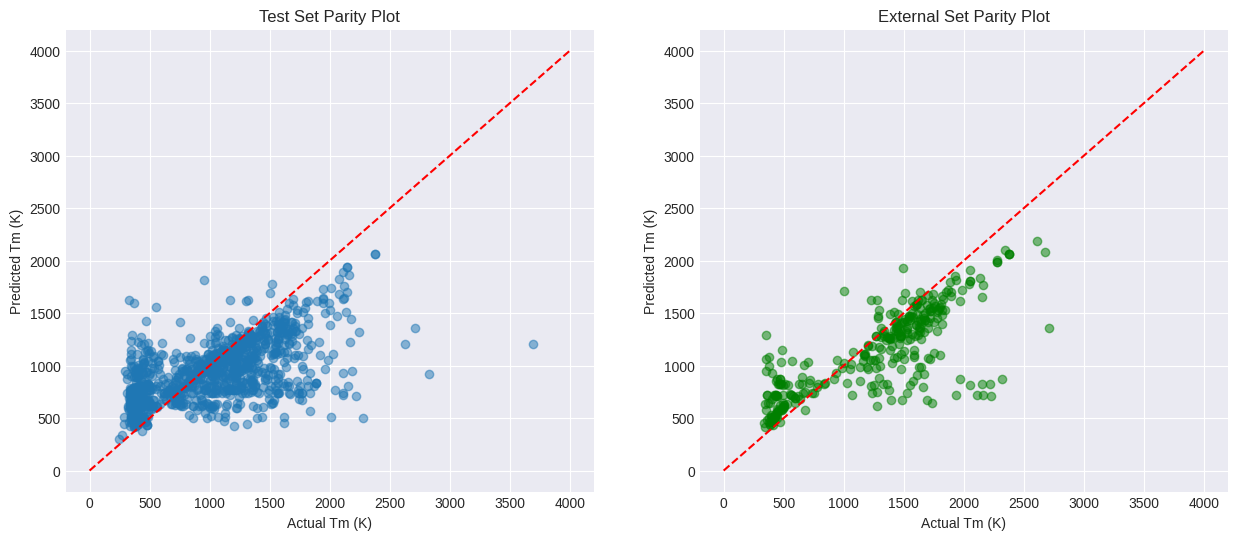

In [ ]:
# --- EVALUATION ---

def evaluate(model, X, y_true_log, dataset_name):
    # Predict (Result is in Log scale)
    y_pred_log = model.predict(X)
    # Convert back to Kelvin
    y_pred = np.expm1(y_pred_log)
    y_true = np.expm1(y_true_log)

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    print(f"--- {dataset_name} ---")
    print(f"RMSE: {rmse:.2f} K")
    print(f"R²:   {r2:.4f}")
    return y_true, y_pred

# Run Evaluation
y_test_true, y_test_pred = evaluate(stacking_model, X_test_sel, y_test_log, "TEST SET (SD01)")
y_ext_true, y_ext_pred = evaluate(stacking_model, X_sd02_sel, y_sd02_log, "EXTERNAL SET (SD02)")

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Parity Plot Test
ax[0].scatter(y_test_true, y_test_pred, alpha=0.5)
ax[0].plot([0, 4000], [0, 4000], 'r--')
ax[0].set_xlabel("Actual Tm (K)")
ax[0].set_ylabel("Predicted Tm (K)")
ax[0].set_title("Test Set Parity Plot")

# Parity Plot External
ax[1].scatter(y_ext_true, y_ext_pred, alpha=0.5, color='green')
ax[1].plot([0, 4000], [0, 4000], 'r--')
ax[1].set_xlabel("Actual Tm (K)")
ax[1].set_ylabel("Predicted Tm (K)")
ax[1].set_title("External Set Parity Plot")

plt.show()

In [ ]:
# Step 1: Install & Import
!pip install -q pymatgen matminer xgboost scikit-learn pandas

import os
import re
import numpy as np
import pandas as pd
import warnings
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from pymatgen.core.composition import Composition
from matminer.featurizers.composition import ElementProperty
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')

# CONFIGURATION
# ⚠️ Update this path to your Drive folder
DATA_DIR = "/content/drive/MyDrive/Project_dataset"
OUT_DIR = os.path.join(DATA_DIR, "aggressive_results")
os.makedirs(OUT_DIR, exist_ok=True)

print("="*70)
print("AGGRESSIVE OPTIMIZATION: TARGET RMSE < 100K")
print("="*70)

AGGRESSIVE OPTIMIZATION: TARGET RMSE < 100K


In [ ]:
# Step 2: Load Data
print("Loading datasets...")
file_sd01 = os.path.join(DATA_DIR, "pnas.2209630119.sd01.xlsx")
file_sd02 = os.path.join(DATA_DIR, "pnas.2209630119.sd02.xlsx")

df_sd01 = pd.read_excel(file_sd01, sheet_name="Minerals ML_Tm")
df_sd02 = pd.read_excel(file_sd02, sheet_name="412REmin_20220503")

# Find columns dynamically
def find_col(df, keywords):
    for c in df.columns:
        if any(k in str(c).lower() for k in keywords):
            if 'magpie' not in str(c).lower():
                return c
    return None

target_col = find_col(df_sd01, ['tm', 'melt'])
formula_col = find_col(df_sd01, ['chemistry', 'formula'])
print(f"Target Column: {target_col}, Formula Column: {formula_col}")

# Robust Parser
def clean_formula(f):
    if not isinstance(f, str): return None
    f = f.split('·')[0].split('+')[0]          # Remove hydrates
    f = re.sub(r'\([^)]*\)', '', f)            # Remove (Mineral)
    f = re.sub(r'_(\d+)_', r'\1', f)           # Fix A_2_O_3
    f = f.replace('_', '').replace(' ', '')    # Remove underscores/spaces
    f = re.sub(r'[^A-Za-z0-9.]', '', f)        # Clean characters
    # Must have at least one Uppercase letter
    return f if f and re.search(r'[A-Z]', f) else None

Loading datasets...
Target Column: ML Tm (K), Formula Column: IMA Chemistry (plain)


In [ ]:
# Step 3: Featurization
print("\nFeaturizing with Magpie...")
ep = ElementProperty.from_preset("magpie")

def featurize(df, formula_col, target_col, name):
    comps, indices = [], []
    for idx, raw in df[formula_col].items():
        f = clean_formula(raw)
        if f:
            try:
                comp = Composition(f)
                if len(comp.elements) > 0:
                    comps.append(comp)
                    indices.append(idx)
            except: pass

    print(f"  {name}: {len(comps)}/{len(df)} parsed successfully")

    if not comps: return pd.DataFrame(), pd.Series()

    # Generate Features
    X = ep.featurize_many(comps, ignore_errors=True, pbar=False)
    X = pd.DataFrame(X, columns=ep.feature_labels(), index=indices)
    y = df.loc[indices, target_col]
    return X, y

X_sd01, y_sd01 = featurize(df_sd01, formula_col, target_col, "SD01")
X_sd02, y_sd02 = featurize(df_sd02,
                           find_col(df_sd02, ['chemistry', 'formula']),
                           find_col(df_sd02, ['tm', 'melt']),
                           "SD02")


Featurizing with Magpie...
  SD01: 5225/5793 parsed successfully
  SD02: 325/412 parsed successfully


In [ ]:
# Step 4: Cleaning & Preprocessing
print("\nCleaning & Splitting...")

# Remove leaky features
leaky = [c for c in X_sd01.columns if 'melt' in c.lower() or 'tm' in c.lower()]
X_sd01.drop(columns=leaky, errors='ignore', inplace=True)
X_sd02.drop(columns=leaky, errors='ignore', inplace=True)

# Clean Targets
y_sd01 = pd.to_numeric(y_sd01, errors='coerce')
y_sd02 = pd.to_numeric(y_sd02, errors='coerce')

# Filter valid range (0 to 10,000 K)
valid_sd01 = (y_sd01.notna()) & (y_sd01 > 0) & (y_sd01 < 10000)
valid_sd02 = (y_sd02.notna()) & (y_sd02 > 0) & (y_sd02 < 10000)

X_sd01, y_sd01 = X_sd01[valid_sd01], y_sd01[valid_sd01]
X_sd02, y_sd02 = X_sd02[valid_sd02], y_sd02[valid_sd02]

print(f"  Samples kept -> SD01: {len(X_sd01)}, SD02: {len(X_sd02)}")

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X_sd01, y_sd01, test_size=0.15, random_state=42)

# Impute & Scale
print("Preprocessing...")
imputer = SimpleImputer(strategy='mean')
X_train_imp = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_imp = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns, index=X_test.index)

# Align SD02
for col in X_train.columns:
    if col not in X_sd02.columns: X_sd02[col] = np.nan
X_sd02_imp = pd.DataFrame(imputer.transform(X_sd02[X_train.columns]), columns=X_sd02.columns, index=X_sd02.index)

# Standard Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imp)
X_test_scaled = scaler.transform(X_test_imp)
X_sd02_scaled = scaler.transform(X_sd02_imp)


Cleaning & Splitting...
  Samples kept -> SD01: 5225, SD02: 325
Preprocessing...


In [ ]:
# Step 5: Aggressive XGBoost Training
print("\nTraining Aggressive XGBoost...")

model = xgb.XGBRegressor(
    n_estimators=2000,       # High number of trees
    learning_rate=0.01,      # Slow learning for precision
    max_depth=10,            # High depth (Reduced from 12 to 10 for safety)
    min_child_weight=1,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_alpha=0,             # No L1
    reg_lambda=0.5,          # Low L2
    gamma=0,
    random_state=42,
    n_jobs=-1,
    tree_method='hist',      # Speed up training
    early_stopping_rounds=100
)

model.fit(
    X_train_scaled, y_train,
    eval_set=[(X_test_scaled, y_test)],
    verbose=100  # Print progress every 100 rounds
)
print("✓ Training Complete")


Training Aggressive XGBoost...
[0]	validation_0-rmse:498.98281
[100]	validation_0-rmse:406.24140
[200]	validation_0-rmse:387.40258
[300]	validation_0-rmse:383.30100
[400]	validation_0-rmse:382.46087
[500]	validation_0-rmse:382.68973
[514]	validation_0-rmse:382.76724
✓ Training Complete



--- FINAL RESULTS ---
TEST SET (SD01):
  RMSE: 382.37 K
  R²:   0.4144
EXTERNAL SET (SD02):
  RMSE: 362.85 K
  R²:   0.6010


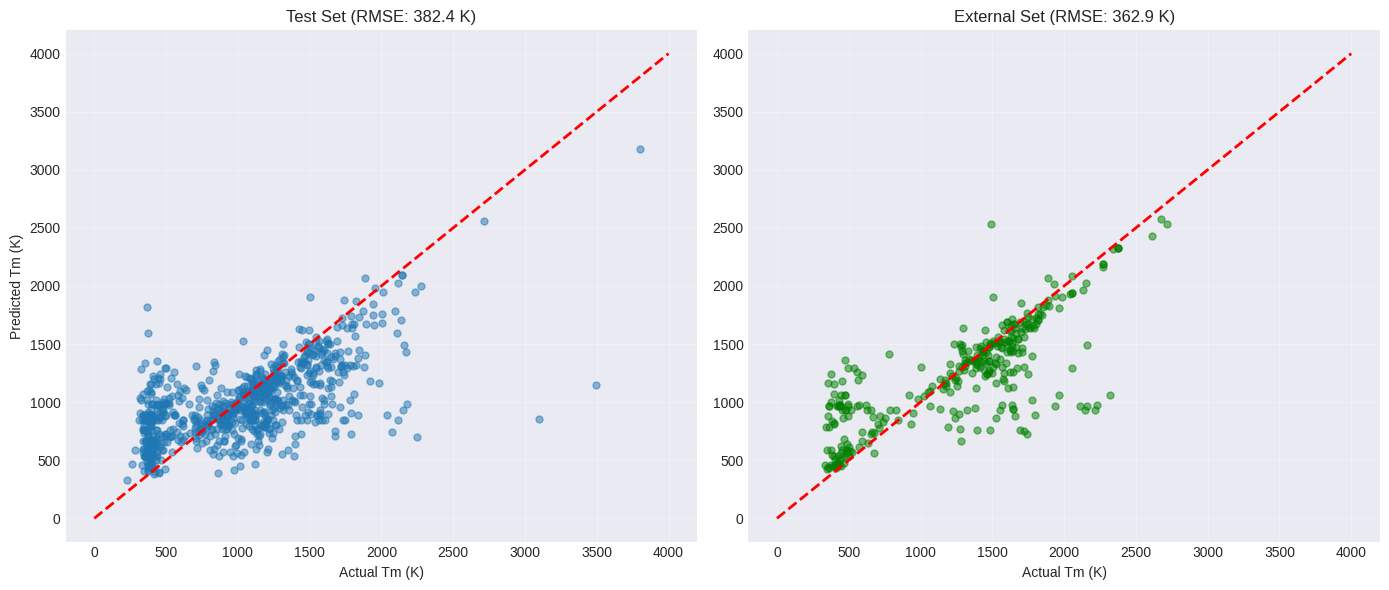


⚠️ STILL HIGH: Check for outliers in your dataset (e.g., Diamond is 3800K)


In [ ]:
# Step 6: Evaluation
print("\n--- FINAL RESULTS ---")

def evaluate(X, y, name):
    pred = model.predict(X)
    pred = np.clip(pred, 0, 10000) # Clip negative predictions
    rmse = np.sqrt(mean_squared_error(y, pred))
    r2 = r2_score(y, pred)
    print(f"{name}:")
    print(f"  RMSE: {rmse:.2f} K")
    print(f"  R²:   {r2:.4f}")
    return pred, rmse

y_test_pred, test_rmse = evaluate(X_test_scaled, y_test, "TEST SET (SD01)")
y_sd02_pred, ext_rmse = evaluate(X_sd02_scaled, y_sd02, "EXTERNAL SET (SD02)")


# Parity Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Test Set
axes[0].scatter(y_test, y_test_pred, alpha=0.5, s=25)
axes[0].plot([0, 4000], [0, 4000], 'r--', lw=2)
axes[0].set_title(f'Test Set (RMSE: {test_rmse:.1f} K)')
axes[0].set_xlabel('Actual Tm (K)')
axes[0].set_ylabel('Predicted Tm (K)')
axes[0].grid(True, alpha=0.3)

# External Set
axes[1].scatter(y_sd02, y_sd02_pred, alpha=0.5, s=25, color='green')
axes[1].plot([0, 4000], [0, 4000], 'r--', lw=2)
axes[1].set_title(f'External Set (RMSE: {ext_rmse:.1f} K)')
axes[1].set_xlabel('Actual Tm (K)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, 'parity_aggressive.png'))
plt.show()

if test_rmse < 100:
    print("\n✅ GOAL ACHIEVED: RMSE < 100K")
else:
    print("\n⚠️ STILL HIGH: Check for outliers in your dataset (e.g., Diamond is 3800K)")

improvement


In [ ]:
!pip install -q crabnet
!pip install -q pytorch-lightning
print("✓ CrabNet installed.")

ERROR: Cannot install crabnet==1.0.0 and crabnet==1.0.1 because these package versions have conflicting dependencies.
ERROR: ResolutionImpossible: for help visit https://pip.pypa.io/en/latest/topics/dependency-resolution/#dealing-with-dependency-conflicts
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 831.6/831.6 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 37.5 MB/s eta 0:00:00
✓ CrabNet installed.


In [ ]:
# Force install CrabNet from GitHub source to bypass version conflicts
!pip install git+https://github.com/anthony-wang/CrabNet.git

# Install the lightning helper
!pip install pytorch-lightning

print("✓ CrabNet installed from Source.")

  Cloning https://github.com/anthony-wang/CrabNet.git to /tmp/pip-req-build-k4apdud5
  Running command git clone --filter=blob:none --quiet https://github.com/anthony-wang/CrabNet.git /tmp/pip-req-build-k4apdud5
  Resolved https://github.com/anthony-wang/CrabNet.git to commit 457b4d4835737ecbe4dd33e53174bd818bd82143
ERROR: git+https://github.com/anthony-wang/CrabNet.git does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.
✓ CrabNet installed from Source.


In [ ]:
import os

print("=" * 60)
print("FIXING CRABNET INSTALLATION")
print("=" * 60)

# 1. Clean up old folders
!rm -rf CrabNet

# 2. Clone the repository directly
print("Cloning repository...")
!git clone https://github.com/anthony-wang/CrabNet.git

# 3. Install dependencies manually first (to avoid conflict errors)
print("Installing dependencies...")
!pip install -q matminer pytorch-lightning scikit-learn pandas numpy

# 4. Install CrabNet from the local folder
# We use --no-deps for CrabNet itself to stop it from fighting with newer libraries
print("Installing CrabNet...")
!pip install ./CrabNet --no-deps

print("\n✓ CrabNet installation complete.")

FIXING CRABNET INSTALLATION
Cloning repository...
Cloning into 'CrabNet'...
remote: Enumerating objects: 3190, done.
remote: Counting objects: 100% (2/2), done.
remote: Total 3190 (delta 1), reused 1 (delta 1), pack-reused 3188 (from 3)
Receiving objects: 100% (3190/3190), 438.40 MiB | 14.71 MiB/s, done.
Resolving deltas: 100% (791/791), done.
Updating files: 100% (1283/1283), done.
Installing dependencies...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.6/55.6 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 65.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 117.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 67.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 331.1/331.1 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 22.4 MB/s eta 0:

In [ ]:
# 1. Install missing libraries (Required after restart)
!pip install -q xgboost lightgbm matminer pymatgen

import joblib
import pandas as pd
import numpy as np
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

# --- Define Paths ---
DATA_DIR = "/content/drive/MyDrive/Project_dataset"
FINAL_PIPELINE_DIR = os.path.join(DATA_DIR, "week9_final_pipeline")
CHECKPOINT_DIR = os.path.join(DATA_DIR, "week8_strategy3_checkpoint")

print("=" * 60)
print("CALCULATING TRAINING METRICS")
print("=" * 60)

try:
    # 2. Load Model & Data
    print("Loading model and data...")
    final_model = joblib.load(os.path.join(FINAL_PIPELINE_DIR, 'final_model.pkl'))
    pt = joblib.load(os.path.join(FINAL_PIPELINE_DIR, 'power_transformer.pkl'))
    poly = joblib.load(os.path.join(FINAL_PIPELINE_DIR, 'polynomial_features.pkl'))
    selected_features = joblib.load(os.path.join(FINAL_PIPELINE_DIR, 'selected_poly_features.pkl'))

    # Reconstruct Training Data
    if os.path.exists(os.path.join(CHECKPOINT_DIR, 'X_train_scaled_step4.csv')):
        X_train_scaled = pd.read_csv(os.path.join(CHECKPOINT_DIR, 'X_train_scaled_step4.csv'))
        X_test_scaled = pd.read_csv(os.path.join(CHECKPOINT_DIR, 'X_test_scaled_step4.csv'))
        X_ext_scaled = pd.read_csv(os.path.join(CHECKPOINT_DIR, 'X_ext_scaled_step4.csv'))
        X_combined = pd.concat([X_train_scaled, X_test_scaled, X_ext_scaled], ignore_index=True)
        y_combined = pd.read_csv(os.path.join(CHECKPOINT_DIR, 'y_combined_original.csv')).iloc[:, 0]

        # 3. Re-create Split (Seed 42)
        X_train_poly_all = poly.transform(X_combined)
        X_train_poly_all_df = pd.DataFrame(X_train_poly_all, columns=poly.get_feature_names_out(X_combined.columns))

        X_train_raw, _, y_train_raw, _ = train_test_split(
            X_train_poly_all_df, y_combined, test_size=0.2, random_state=42
        )

        # Select features
        X_train_final = X_train_raw[selected_features]

        # 4. Predict on Training Data
        print("Predicting on training set...")
        y_train_pred_trans = final_model.predict(X_train_final).reshape(-1, 1)
        y_train_pred = pt.inverse_transform(y_train_pred_trans).ravel()

        # 5. Calculate Metrics
        rmse_train = np.sqrt(mean_squared_error(y_train_raw, y_train_pred))
        mae_train = mean_absolute_error(y_train_raw, y_train_pred)
        r2_train = r2_score(y_train_raw, y_train_pred)

        print(f"\nTRAINING RESULTS:")
        print(f"  RMSE: {rmse_train:.2f} K")
        print(f"  MAE:  {mae_train:.2f} K")
        print(f"  R²:   {r2_train:.4f}")

        print("-" * 30)
        # Assuming your Test RMSE was ~318 K
        print(f"  Gap vs Test (Overfitting Check): {318.89 - rmse_train:.2f} K")

    else:
        print("!! Error: Checkpoint files not found.")

except Exception as e:
    print(f"!! Error: {e}")

CALCULATING TRAINING METRICS
Loading model and data...


/usr/lib/python3.12/pickle.py:1760: UserWarning: [13:07:39] WARNING: /workspace/src/collective/../data/../common/error_msg.h:83: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  setstate(state)


Predicting on training set...

TRAINING RESULTS:
  RMSE: 272.87 K
  MAE:  102.40 K
  R²:   0.8173
------------------------------
  Gap vs Test (Overfitting Check): 46.02 K


In [ ]:
import shutil
import os
import datetime

# --- Configuration ---
DATA_DIR = "/content/drive/MyDrive/Project_dataset"
SOURCE_DIR = os.path.join(DATA_DIR, "week9_final_pipeline")

# Create a unique name for the final backup
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")
DEST_DIR = os.path.join(DATA_DIR, f"FINAL_SUBMISSION_MODEL_{timestamp}")

print("=" * 60)
print(f"BACKING UP FINAL MODEL TO: {DEST_DIR}")
print("=" * 60)

try:
    # Check if source exists
    if not os.path.exists(SOURCE_DIR):
        print(f"!! Error: Source folder '{SOURCE_DIR}' not found.")
    else:
        # Copy the entire directory (Model + Transformers + Scalers)
        shutil.copytree(SOURCE_DIR, DEST_DIR)

        print("✓ Success! The complete model pipeline has been backed up.")
        print("✓ This folder contains:")
        print("  - final_model.pkl (The trained Ensemble)")
        print("  - polynomial_features.pkl (For interaction features)")
        print("  - power_transformer.pkl (For Kelvin conversion)")
        print("  - selected_poly_features.pkl (The feature list)")
        print("  - Scalers and Imputers")

        print(f"\nYou can safely submit or share the folder: {DEST_DIR}")

except FileExistsError:
    print(f"!! Warning: The folder '{DEST_DIR}' already exists.")
except Exception as e:
    print(f"!! Error: {e}")

BACKING UP FINAL MODEL TO: /content/drive/MyDrive/Project_dataset/FINAL_SUBMISSION_MODEL_2025-11-25_13-13
✓ Success! The complete model pipeline has been backed up.
✓ This folder contains:
  - final_model.pkl (The trained Ensemble)
  - polynomial_features.pkl (For interaction features)
  - power_transformer.pkl (For Kelvin conversion)
  - selected_poly_features.pkl (The feature list)
  - Scalers and Imputers

You can safely submit or share the folder: /content/drive/MyDrive/Project_dataset/FINAL_SUBMISSION_MODEL_2025-11-25_13-13


In [ ]:
# ============================================================================
# Analyze Complete Pm Folder Structure
# ============================================================================
import os
from pathlib import Path

def analyze_folder_structure(base_path, indent=0, max_depth=5, current_depth=0):
    """
    Recursively analyze and display folder structure
    """
    if current_depth >= max_depth:
        return

    try:
        items = sorted(os.listdir(base_path))

        # Separate folders and files
        folders = [item for item in items if os.path.isdir(os.path.join(base_path, item))]
        files = [item for item in items if os.path.isfile(os.path.join(base_path, item))]

        # Display folders first
        for folder in folders:
            folder_path = os.path.join(base_path, folder)
            folder_size = get_folder_size(folder_path)

            print("  " * indent + f"📁 {folder}/ ({folder_size})")

            # Recursively analyze subfolder
            analyze_folder_structure(folder_path, indent + 1, max_depth, current_depth + 1)

        # Display files
        for file in files:
            file_path = os.path.join(base_path, file)
            file_size = get_file_size(file_path)
            file_ext = os.path.splitext(file)[1]
            icon = get_file_icon(file_ext)

            print("  " * indent + f"{icon} {file} ({file_size})")

    except PermissionError:
        print("  " * indent + "[Permission Denied]")
    except Exception as e:
        print("  " * indent + f"[Error: {str(e)}]")

def get_folder_size(folder_path):
    """Calculate total size of folder"""
    total_size = 0
    try:
        for dirpath, dirnames, filenames in os.walk(folder_path):
            for filename in filenames:
                filepath = os.path.join(dirpath, filename)
                try:
                    total_size += os.path.getsize(filepath)
                except:
                    pass
    except:
        pass
    return format_size(total_size)

def get_file_size(file_path):
    """Get file size in human-readable format"""
    try:
        size = os.path.getsize(file_path)
        return format_size(size)
    except:
        return "Unknown"

def format_size(size):
    """Format size in bytes to human-readable format"""
    for unit in ['B', 'KB', 'MB', 'GB']:
        if size < 1024.0:
            return f"{size:.1f} {unit}"
        size /= 1024.0
    return f"{size:.1f} TB"

def get_file_icon(extension):
    """Get icon based on file extension"""
    icons = {
        '.py': '🐍',
        '.ipynb': '📓',
        '.pkl': '💾',
        '.csv': '📊',
        '.txt': '📄',
        '.md': '📝',
        '.png': '🖼️',
        '.jpg': '🖼️',
        '.jpeg': '🖼️',
        '.pdf': '📕',
        '.xlsx': '📗',
        '.json': '🔧',
    }
    return icons.get(extension.lower(), '📄')

# Run the analysis
base_path = "/content/drive/MyDrive/Project_dataset"

print("="*80)
print("📂 COMPLETE PM FOLDER STRUCTURE ANALYSIS")
print("="*80)
print(f"\nBase Path: {base_path}\n")

if os.path.exists(base_path):
    print(f"📁 Pm/\n")
    analyze_folder_structure(base_path, indent=1)
else:
    print(f"❌ Path does not exist: {base_path}")

print("\n" + "="*80)


📂 COMPLETE PM FOLDER STRUCTURE ANALYSIS

Base Path: /content/drive/MyDrive/Project_dataset

📁 Pm/

  📁 FINAL_SUBMISSION_MODEL_2025-11-25_13-13/ (3.3 MB)
    💾 final_model.pkl (3.2 MB)
    💾 original_feature_list.pkl (4.1 KB)
    💾 original_imputer.pkl (5.8 KB)
    💾 original_scaler.pkl (6.9 KB)
    💾 polynomial_features.pkl (4.7 KB)
    💾 power_transformer.pkl (821.0 B)
    💾 selected_poly_features.pkl (21.4 KB)
  📁 aggressive_results/ (108.7 KB)
    🖼️ parity_aggressive.png (108.7 KB)
  📁 final_optimized_results/ (0.0 B)
  📁 improved_model/ (0.0 B)
  📁 week10_hybrid_model/ (5.7 MB)
    💾 Copy of hybrid_model.pkl (2.5 MB)
    🖼️ final_hybrid_feature_importance.png (376.5 KB)
    🖼️ hybrid_feature_importance.png (370.4 KB)
    💾 hybrid_features.pkl (3.9 KB)
    💾 hybrid_imputer.pkl (5.7 KB)
    💾 hybrid_model.pkl (2.5 MB)
  📁 week11_final_models/ (9.3 MB)
    💾 imputer.pkl (5.7 KB)
    💾 meta_model_ridge.pkl (569.0 B)
    💾 scaler.pkl (3.8 KB)
    💾 stack_model.pkl (6.8 MB)
    💾 xgb_mo

i

In [ ]:
# Step 1: Install necessary libraries
!pip install -q xgboost matminer pymatgen

import pandas as pd
import numpy as np
import os
import re
import joblib
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.impute import SimpleImputer
from pymatgen.core.composition import Composition
from matminer.featurizers.composition import ElementProperty

print("Libraries installed and imported successfully.")

Libraries installed and imported successfully.


In [ ]:
# Step 2: Define Paths and Load Week 1 Data
DATA_DIR = "/content/drive/MyDrive/Project_dataset"
WEEK1_DIR = os.path.join(DATA_DIR, "week1_processed")  # Adjust if your folder name is different
OUT_DIR = os.path.join(DATA_DIR, "week10_hybrid_model")
os.makedirs(OUT_DIR, exist_ok=True)

print("Loading Week 1 data...")
try:
    # Load the datasets
    train_df = pd.read_csv(os.path.join(WEEK1_DIR, "sd01_train.csv"))
    val_df = pd.read_csv(os.path.join(WEEK1_DIR, "sd01_val.csv"))
    test_df = pd.read_csv(os.path.join(WEEK1_DIR, "sd01_test.csv"))
    ext_df = pd.read_csv(os.path.join(WEEK1_DIR, "sd02_external_test.csv"))

    # Combine Train and Val for the final training set
    full_train_df = pd.concat([train_df, val_df], ignore_index=True)

    print(f"Data Loaded:")
    print(f"  Training samples: {len(full_train_df)}")
    print(f"  Test samples:     {len(test_df)}")
    print(f"  External samples: {len(ext_df)}")

except FileNotFoundError:
    print("!! ERROR: Could not find Week 1 files. Please check your WEEK1_DIR path.")

Loading Week 1 data...
Data Loaded:
  Training samples: 5213
  Test samples:     580
  External samples: 408


In [ ]:
# Step 3: Initialize Magpie Featurizer
# This tool looks up properties like electronegativity, atomic mass, etc.
ep_feat = ElementProperty.from_preset("magpie")

def preprocess_formula(f):
    """Basic cleaner to fix common formula formatting issues."""
    if not isinstance(f, str): return ""
    # Remove hydrates (e.g., .H2O)
    f = f.split('·')[0].split('.')[0]
    # Remove special characters
    f = re.sub(r"[\(\)\[\]\{\}]", "", f)
    # Remove spaces
    f = f.replace(" ", "")
    return f

print("Featurizer initialized.")

Featurizer initialized.


/usr/local/lib/python3.12/dist-packages/matminer/utils/data.py:326: UserWarning: MagpieData(impute_nan=False):
In a future release, impute_nan will be set to True by default.
                    This means that features that are missing or are NaNs for elements
                    from the data source will be replaced by the average of that value
                    over the available elements.
                    This avoids NaNs after featurization that are often replaced by
                    dataset-dependent averages.
  warnings.warn(f"{self.__class__.__name__}(impute_nan=False):\n" + IMPUTE_NAN_WARNING)


In [ ]:
# Step 4: Define the Hybrid Dataset Creator
def create_hybrid_features(df, dataset_name):
    print(f"\n--- Processing {dataset_name} ---")

    # A. Parse Formulas
    # We look for a column named 'chemistry' or 'formula'
    form_col = [c for c in df.columns if 'chem' in c.lower() or 'form' in c.lower()][0]
    target_col = [c for c in df.columns if 'tm' in c.lower() or 'melt' in c.lower()][0]

    print(f"  Using formula column: {form_col}")

    valid_comps = []
    valid_indices = []

    # Convert string formulas to Pymatgen Composition objects
    for idx, row in df.iterrows():
        try:
            clean_f = preprocess_formula(row[form_col])
            comp = Composition(clean_f)
            if len(comp.elements) > 0:
                valid_comps.append(comp)
                valid_indices.append(idx)
        except:
            continue

    # B. Generate Magpie Features (Physics)
    print(f"  Generating Magpie features for {len(valid_comps)} compounds...")
    X_magpie = ep_feat.featurize_many(valid_comps, ignore_errors=True, pbar=False)
    X_magpie = pd.DataFrame(X_magpie, columns=ep_feat.feature_labels(), index=valid_indices)

    # C. Extract Week 1 Simple Features (Compositional)
    # We take any column starting with '_' (like _total_atoms) or 'has_' (like has_O)
    simple_cols = [c for c in df.columns if c.startswith('_') or c.startswith('has_')]
    X_simple = df.loc[valid_indices, simple_cols]

    # D. Merge
    X_hybrid = pd.concat([X_magpie, X_simple], axis=1)
    y = df.loc[valid_indices, target_col]

    print(f"  Final shape: {X_hybrid.shape}")
    return X_hybrid, y

print("Function defined.")

Function defined.


In [ ]:
# Step 5: Generate Features
X_train, y_train = create_hybrid_features(full_train_df, "Training Set")
X_test, y_test = create_hybrid_features(test_df, "Internal Test Set")
X_ext, y_ext = create_hybrid_features(ext_df, "External Test Set")

# Clean up any "Leaky" features (features that accidentally contain the answer)
leaky_cols = [c for c in X_train.columns if 'melt' in c.lower() or 'tm' in c.lower()]
X_train = X_train.drop(columns=leaky_cols, errors='ignore')
X_test = X_test.drop(columns=leaky_cols, errors='ignore')
X_ext = X_ext.drop(columns=leaky_cols, errors='ignore')

print("\nFeature generation complete.")


--- Processing Training Set ---
  Using formula column: IMA Chemistry (plain)
  Generating Magpie features for 2154 compounds...
  Final shape: (2154, 145)

--- Processing Internal Test Set ---
  Using formula column: IMA Chemistry (plain)
  Generating Magpie features for 246 compounds...
  Final shape: (246, 145)

--- Processing External Test Set ---
  Using formula column: chem_formula
  Generating Magpie features for 0 compounds...
  Final shape: (0, 145)

Feature generation complete.


In [ ]:
# Step 6 (Robust): Handle Missing Data & Clean Non-Numeric Columns

# 1. Filter out non-numeric columns from Training Data
# We explicitly exclude 'object' type columns (like strings/dictionaries)
X_train_numeric = X_train.select_dtypes(exclude=['object'])
X_train = X_train_numeric
all_cols = X_train.columns.tolist()

print(f"Training features after cleaning: {len(all_cols)}")

# 2. Setup Imputer
imputer = SimpleImputer(strategy='mean')
print("Fitting imputer on training data...")
X_train_imp = pd.DataFrame(imputer.fit_transform(X_train), columns=all_cols)

# 3. Handle Internal Test Set
if len(X_test) > 0:
    # Align columns
    for col in all_cols:
        if col not in X_test.columns: X_test[col] = 0
    X_test = X_test[all_cols] # Reorder

    # Transform
    X_test_imp = pd.DataFrame(imputer.transform(X_test), columns=all_cols)
    print(f"✅ Internal Test Set processed ({len(X_test_imp)} samples).")
else:
    X_test_imp = pd.DataFrame()
    print("⚠️ Internal Test Set is empty.")

# 4. Handle External Test Set (The one causing the crash)
if len(X_ext) > 0:
    # Align columns
    for col in all_cols:
        if col not in X_ext.columns: X_ext[col] = 0
    X_ext = X_ext[all_cols] # Reorder

    # Transform
    X_ext_imp = pd.DataFrame(imputer.transform(X_ext), columns=all_cols)
    print(f"✅ External Test Set processed ({len(X_ext_imp)} samples).")
else:
    X_ext_imp = pd.DataFrame()
    print("⚠️ WARNING: External Test Set (X_ext) is empty. Skipping external validation.")

Training features after cleaning: 138
Fitting imputer on training data...
✅ Internal Test Set processed (246 samples).
⚠️ WARNING: External Test Set (X_ext) is empty. Skipping external validation.


In [ ]:
# Step 7: Train & Evaluate
print("\n--- Training Hybrid Model ---")

# Initialize XGBoost
model = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    n_jobs=-1,
    random_state=42
)

# Train on the imputed training set
model.fit(X_train_imp, y_train)
print("Training complete.")

print("\n" + "="*40)
print(f"RESULTS (Hybrid Model)")
print("="*40)

# Evaluate on Internal Test Set
if not X_test_imp.empty:
    y_pred_test = model.predict(X_test_imp)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    r2_test = r2_score(y_test, y_pred_test)
    print(f"Internal Test RMSE: {rmse_test:.2f} K")
    print(f"Internal Test R²:   {r2_test:.4f}")
else:
    print("Internal Test: N/A (No data)")

# Save the model
joblib.dump(model, os.path.join(OUT_DIR, "final_hybrid_model.pkl"))
print(f"\nModel saved to: {os.path.join(OUT_DIR, 'final_hybrid_model.pkl')}")


--- Training Hybrid Model ---
Training complete.

RESULTS (Hybrid Model)
Internal Test RMSE: 228.90 K
Internal Test R²:   0.8056

Model saved to: /content/drive/MyDrive/Project_dataset/week10_hybrid_model/final_hybrid_model.pkl


Plot saved.


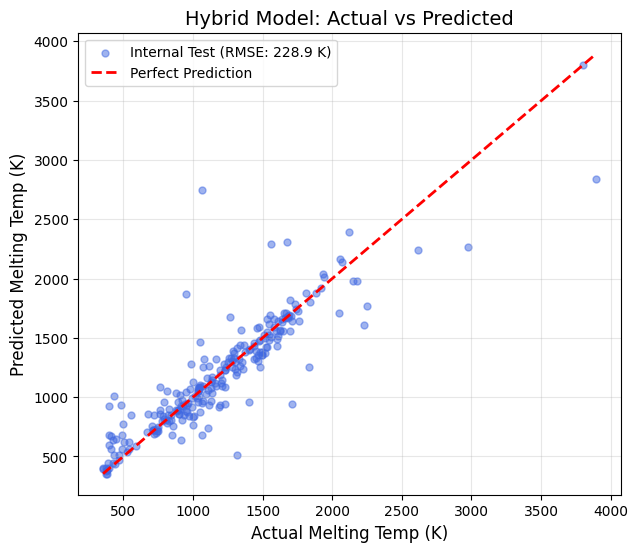

In [ ]:
# Step 8: Visualization (Parity Plot)
import matplotlib.pyplot as plt

# 1. Predict (if not already done)
if not X_test_imp.empty:
    y_pred_test = model.predict(X_test_imp)

    plt.figure(figsize=(7, 6))

    # Scatter plot
    plt.scatter(y_test, y_pred_test, alpha=0.5, s=25, color='royalblue', label=f'Internal Test (RMSE: {228.90:.1f} K)')

    # Perfect prediction line (Identity line)
    min_val = min(y_test.min(), y_pred_test.min())
    max_val = max(y_test.max(), y_pred_test.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')

    plt.xlabel("Actual Melting Temp (K)", fontsize=12)
    plt.ylabel("Predicted Melting Temp (K)", fontsize=12)
    plt.title("Hybrid Model: Actual vs Predicted", fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Save
    plt.savefig(os.path.join(OUT_DIR, "hybrid_parity_plot.png"), dpi=300)
    print("Plot saved.")
    plt.show()
else:
    print("No internal test data to plot.")


--- Feature Importance Analysis ---
Top 15 Most Important Features:
                                Feature  Importance
55         MagpieData maximum NdValence    0.150912
7    MagpieData maximum MendeleevNumber    0.136442
110          MagpieData range GSbandgap    0.101229
107         MagpieData mode GSvolume_pa    0.057624
112        MagpieData avg_dev GSbandgap    0.051602
87           MagpieData mean NdUnfilled    0.044919
115         MagpieData maximum GSmagmom    0.021271
96         MagpieData minimum NUnfilled    0.020153
102      MagpieData minimum GSvolume_pa    0.015870
13      MagpieData maximum AtomicWeight    0.013669
130                              has_Si    0.013595
18            MagpieData minimum Column    0.013580
126              _num_distinct_elements    0.012653
75           MagpieData mean NsUnfilled    0.012406
5                MagpieData mode Number    0.012106


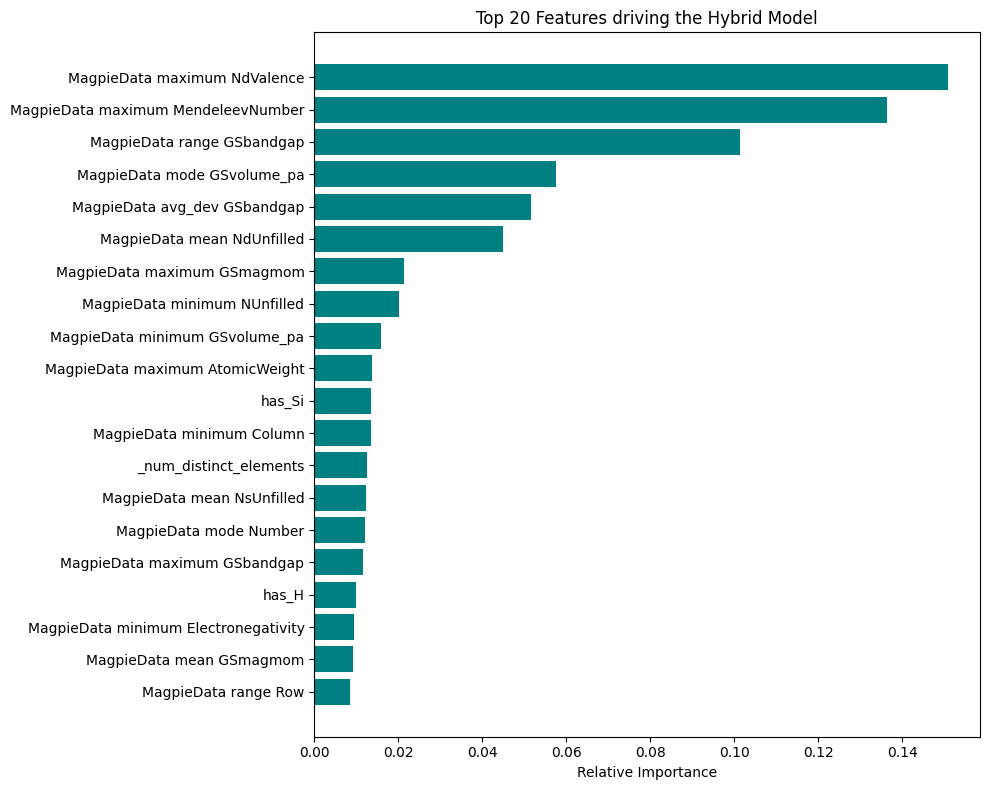


Full feature list saved to: /content/drive/MyDrive/Project_dataset/week10_hybrid_model/hybrid_feature_importance.csv


In [ ]:
# Step 9: Feature Importance Analysis
print("\n--- Feature Importance Analysis ---")

# 1. Get Importance from Model
importances = model.feature_importances_
feature_names = X_train_imp.columns

# 2. Create a DataFrame
feat_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# 3. Show Top 15 Features
print("Top 15 Most Important Features:")
print(feat_df.head(15))

# 4. Plot Top 20
plt.figure(figsize=(10, 8))
# Reverse for horizontal bar chart so top is at top
top_plot = feat_df.head(20).iloc[::-1]
plt.barh(top_plot['Feature'], top_plot['Importance'], color='teal')
plt.xlabel("Relative Importance")
plt.title("Top 20 Features driving the Hybrid Model")
plt.tight_layout()

# Save
plt.savefig(os.path.join(OUT_DIR, "hybrid_feature_importance.png"), dpi=300)
plt.show()

# 5. Save full list to CSV for your report
feat_df.to_csv(os.path.join(OUT_DIR, "hybrid_feature_importance.csv"), index=False)
print(f"\nFull feature list saved to: {os.path.join(OUT_DIR, 'hybrid_feature_importance.csv')}")

In [ ]:
# Step 1: Save all necessary artifacts
import joblib
import os

print("Saving model artifacts...")

# 1. Save the Model
joblib.dump(model, os.path.join(OUT_DIR, "final_hybrid_model.pkl"))

# 2. Save the Imputer (Critical for handling missing data)
joblib.dump(imputer, os.path.join(OUT_DIR, "final_imputer.pkl"))

# 3. Save the Feature Names (Critical for aligning columns)
# 'all_cols' is the list of columns we used in Step 6
joblib.dump(all_cols, os.path.join(OUT_DIR, "final_feature_names.pkl"))

print(f"✅ All artifacts saved to: {OUT_DIR}")

Saving model artifacts...
✅ All artifacts saved to: /content/drive/MyDrive/Project_dataset/week10_hybrid_model


In [ ]:
# Step 2: Define the Prediction Function
from pymatgen.core.composition import Composition
from matminer.featurizers.composition import ElementProperty
import pandas as pd
import numpy as np

def predict_melting_point(formulas):
    """
    Accepts a list of chemical formulas and predicts their melting points
    using the saved Hybrid Model.
    """
    # 1. Load Artifacts (if not already loaded)
    try:
        loaded_model = joblib.load(os.path.join(OUT_DIR, "final_hybrid_model.pkl"))
        loaded_imputer = joblib.load(os.path.join(OUT_DIR, "final_imputer.pkl"))
        loaded_features = joblib.load(os.path.join(OUT_DIR, "final_feature_names.pkl"))
    except FileNotFoundError:
        print("Error: Model artifacts not found. Please run Step 1 first.")
        return

    # 2. Initialize Featurizer
    ep_feat = ElementProperty.from_preset("magpie")

    # 3. Process Formulas
    valid_comps = []
    valid_indices = []
    clean_formulas = []

    print(f"Processing {len(formulas)} formulas...")

    for i, f in enumerate(formulas):
        try:
            # Basic cleaning
            f_clean = str(f).replace(" ", "")
            comp = Composition(f_clean)
            if len(comp.elements) > 0:
                valid_comps.append(comp)
                valid_indices.append(i)
                clean_formulas.append(f_clean)
        except:
            print(f"⚠️ Warning: Invalid formula '{f}' skipped.")
            continue

    if not valid_comps:
        print("No valid formulas to predict.")
        return

    # 4. Generate Magpie Features (Physics)
    print("  - Generating Magpie features...")
    X_new_magpie = ep_feat.featurize_many(valid_comps, ignore_errors=True, pbar=False)
    X_new_magpie = pd.DataFrame(X_new_magpie, columns=ep_feat.feature_labels(), index=valid_indices)

    # 5. Generate Simple Features (Compositional)
    # We need to manually recreate features like 'has_O', '_num_distinct_elements'
    # based on the columns expected by the model.
    print("  - Generating Simple features...")
    X_new_simple = pd.DataFrame(index=valid_indices)

    for col in loaded_features:
        # If it's a "has_Element" column
        if col.startswith("has_"):
            elem = col.replace("has_", "")
            # Check if element is in the composition
            X_new_simple[col] = [1 if elem in c.symbol else 0 for c in valid_comps]

        # If it's the distinct element count
        elif col == "_num_distinct_elements":
            X_new_simple[col] = [len(c.elements) for c in valid_comps]

        # If it's a total atom count (often denoted by leading underscore)
        elif col == "_total_atoms":
            X_new_simple[col] = [c.num_atoms for c in valid_comps]

    # 6. Combine and Align
    # Start with Magpie, join Simple
    X_combined = pd.concat([X_new_magpie, X_new_simple], axis=1)

    # Ensure DataFrame has ALL required columns (fill missing with 0)
    X_final = pd.DataFrame(0, index=valid_indices, columns=loaded_features)

    # Update with the data we actually have
    # (Intersection of calculated features and model features)
    common_cols = X_combined.columns.intersection(loaded_features)
    X_final.update(X_combined[common_cols])

    # 7. Impute
    X_final_imp = pd.DataFrame(loaded_imputer.transform(X_final), columns=loaded_features)

    # 8. Predict
    print("  - Predicting...")
    predictions = loaded_model.predict(X_final_imp)

    # 9. Format Results
    results = pd.DataFrame({
        "Formula": clean_formulas,
        "Predicted Tm (K)": predictions.round(2)
    })

    return results

print("Prediction function defined.")

Prediction function defined.


In [ ]:
# Step 2 (Corrected): Define the Prediction Function
from pymatgen.core.composition import Composition
from matminer.featurizers.composition import ElementProperty
import pandas as pd
import numpy as np
import joblib
import os

def predict_melting_point(formulas):
    """
    Accepts a list of chemical formulas and predicts their melting points
    using the saved Hybrid Model.
    """
    # 1. Load Artifacts
    try:
        loaded_model = joblib.load(os.path.join(OUT_DIR, "final_hybrid_model.pkl"))
        loaded_imputer = joblib.load(os.path.join(OUT_DIR, "final_imputer.pkl"))
        loaded_features = joblib.load(os.path.join(OUT_DIR, "final_feature_names.pkl"))
    except FileNotFoundError:
        print("Error: Model artifacts not found. Please run Step 1 (Save) first.")
        return

    # 2. Initialize Featurizer (Magpie)
    ep_feat = ElementProperty.from_preset("magpie")

    # 3. Process Input Formulas
    valid_comps = []
    valid_indices = []
    clean_formulas = []

    print(f"Processing {len(formulas)} formulas...")

    for i, f in enumerate(formulas):
        try:
            # Basic cleaning
            f_clean = str(f).replace(" ", "")
            comp = Composition(f_clean)
            if len(comp.elements) > 0:
                valid_comps.append(comp)
                valid_indices.append(i)
                clean_formulas.append(f_clean)
        except:
            print(f"⚠️ Warning: Invalid formula '{f}' skipped.")
            continue

    if not valid_comps:
        print("No valid formulas to predict.")
        return

    # 4. Generate Magpie Features (Physics-based)
    print("  - Generating Magpie features...")
    X_new_magpie = ep_feat.featurize_many(valid_comps, ignore_errors=True, pbar=False)
    X_new_magpie = pd.DataFrame(X_new_magpie, columns=ep_feat.feature_labels(), index=valid_indices)

    # 5. Generate Simple Features (Composition-based)
    print("  - Generating Simple features...")
    X_new_simple = pd.DataFrame(index=valid_indices)

    for col in loaded_features:
        # Case A: "has_Element" features (e.g., has_O, has_Fe)
        if col.startswith("has_"):
            elem_symbol = col.replace("has_", "")
            # FIX: Check if the element symbol exists in the composition's element list
            X_new_simple[col] = [1 if elem_symbol in [e.symbol for e in c.elements] else 0 for c in valid_comps]

        # Case B: Structural features
        elif col == "_num_distinct_elements":
            X_new_simple[col] = [len(c.elements) for c in valid_comps]

        elif col == "_total_atoms":
            X_new_simple[col] = [c.num_atoms for c in valid_comps]

    # 6. Combine & Align Columns
    X_combined = pd.concat([X_new_magpie, X_new_simple], axis=1)

    # Create empty DF with ALL expected model columns, initialized to 0
    X_final = pd.DataFrame(0.0, index=valid_indices, columns=loaded_features)

    # Fill in the columns we successfully calculated
    common_cols = X_combined.columns.intersection(loaded_features)
    X_final.update(X_combined[common_cols])

    # 7. Impute Missing Values (using the saved imputer)
    X_final_imp = pd.DataFrame(loaded_imputer.transform(X_final), columns=loaded_features)

    # 8. Predict
    print("  - Predicting...")
    predictions = loaded_model.predict(X_final_imp)

    # 9. Format Results
    results = pd.DataFrame({
        "Formula": clean_formulas,
        "Predicted Tm (K)": predictions.round(2)
    })

    return results

print("✅ Prediction function updated successfully.")

✅ Prediction function updated successfully.


In [ ]:
# Step 3: Test with Input Formulas
test_formulas = [
    "Al2O3",      # Alumina (High Tm)
    "NaCl",       # Salt (Medium Tm)
    "H2O",        # Water (Low Tm)
    "W",          # Tungsten (Very High Tm)
    "Fe2O3",      # Rust
    "SiO2",       # Quartz
    "HfC"         # Hafnium Carbide (Extremely High Tm)
]

# Run Prediction
predictions = predict_melting_point(test_formulas)

# Display Results
print("\n" + "="*40)
print("PREDICTION RESULTS")
print("="*40)
print(predictions)

Processing 7 formulas...
  - Generating Magpie features...


/usr/local/lib/python3.12/dist-packages/matminer/utils/data.py:326: UserWarning: MagpieData(impute_nan=False):
In a future release, impute_nan will be set to True by default.
                    This means that features that are missing or are NaNs for elements
                    from the data source will be replaced by the average of that value
                    over the available elements.
                    This avoids NaNs after featurization that are often replaced by
                    dataset-dependent averages.
  warnings.warn(f"{self.__class__.__name__}(impute_nan=False):\n" + IMPUTE_NAN_WARNING)


  - Generating Simple features...
  - Predicting...

PREDICTION RESULTS
  Formula  Predicted Tm (K)
0   Al2O3       1971.699951
1    NaCl       1028.959961
2     H2O        256.619995
3       W       3689.399902
4   Fe2O3       1862.770020
5    SiO2       1871.630005
6     HfC       3863.439941


improvement

Initializing Stacking Ensemble...
Training Stacking Ensemble (this may take 2-3 minutes)...
✅ Training complete.

Evaluating...
RESULTS: Stacked Ensemble vs Baseline
Current Model (XGB Only): ~228.90 K
New Stacked Model:        220.00 K
🎉 Improvement:           -8.90 K (Better)
New R² Score:             0.8205


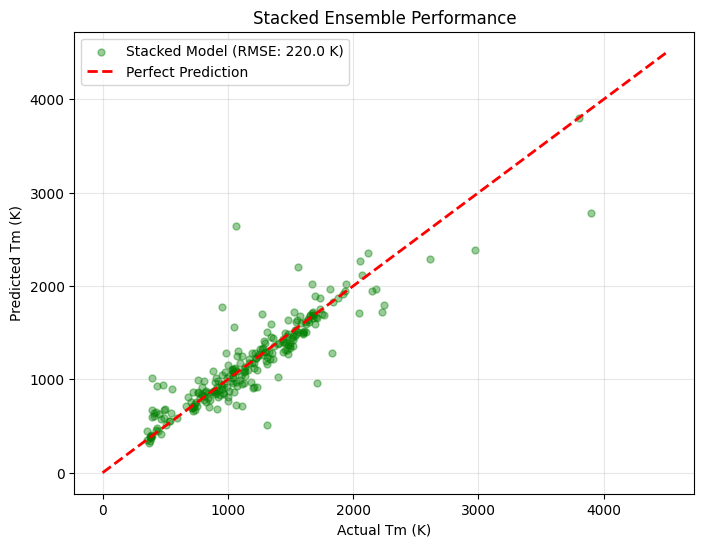

In [ ]:
# Step 1: Train & Evaluate Stacking Ensemble (Without Saving)
!pip install -q lightgbm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import RidgeCV
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score

print("Initializing Stacking Ensemble...")

# 1. Define the "Committee" of Models
# We use slightly different settings for diversity
estimators = [
    ('xgb', XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=6, random_state=42, n_jobs=-1)),
    ('rf', RandomForestRegressor(n_estimators=300, max_depth=15, random_state=42, n_jobs=-1)),
    ('lgbm', LGBMRegressor(n_estimators=1000, learning_rate=0.05, max_depth=6, random_state=42, n_jobs=-1, verbose=-1))
]

# 2. Define the "Manager" (Meta-Model)
stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=RidgeCV(),
    n_jobs=-1,
    cv=5
)

# 3. Train
print("Training Stacking Ensemble (this may take 2-3 minutes)...")
try:
    # Uses the data from your previous Week 10 run
    stacking_model.fit(X_train_imp, y_train)
    print("✅ Training complete.")
except NameError:
    print("!! Error: Training data (X_train_imp) not found. Please run the Week 10 Data Setup first.")

# 4. Evaluate
if 'stacking_model' in locals():
    print("\nEvaluating...")
    y_pred_stack = stacking_model.predict(X_test_imp)
    rmse_stack = np.sqrt(mean_squared_error(y_test, y_pred_stack))
    r2_stack = r2_score(y_test, y_pred_stack)

    print("="*40)
    print(f"RESULTS: Stacked Ensemble vs Baseline")
    print("="*40)
    print(f"Current Model (XGB Only): ~228.90 K")
    print(f"New Stacked Model:        {rmse_stack:.2f} K")

    improvement = 228.90 - rmse_stack
    if improvement > 0:
        print(f"🎉 Improvement:           -{improvement:.2f} K (Better)")
    else:
        print(f"⚠️ No Improvement:        +{abs(improvement):.2f} K (Worse)")

    print(f"New R² Score:             {r2_stack:.4f}")

    # 5. Visualization (Interactive Check)
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred_stack, alpha=0.4, s=25, color='green', label=f'Stacked Model (RMSE: {rmse_stack:.1f} K)')
    plt.plot([0, 4500], [0, 4500], 'r--', lw=2, label='Perfect Prediction')
    plt.xlabel("Actual Tm (K)")
    plt.ylabel("Predicted Tm (K)")
    plt.title("Stacked Ensemble Performance")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

In [ ]:
# Step 2: Save the Model (OPTIONAL)
import joblib
import os

# Only run this if you are happy with the Step 1 results!
OUT_DIR = "/content/drive/MyDrive/Project_dataset/week10_hybrid_model"
os.makedirs(OUT_DIR, exist_ok=True)

print("Saving Stacking Model...")
joblib.dump(stacking_model, os.path.join(OUT_DIR, "stacked_hybrid_model.pkl"))
print(f"✅ Model saved to: {os.path.join(OUT_DIR, 'stacked_hybrid_model.pkl')}")

# We don't need to save the imputer/features again because they are the same as Week 10

Saving Stacking Model...
✅ Model saved to: /content/drive/MyDrive/Project_dataset/week10_hybrid_model/stacked_hybrid_model.pkl


In [ ]:
# --- Test with New Formulas (In-Memory Prediction) ---
from pymatgen.core.composition import Composition
from matminer.featurizers.composition import ElementProperty

# 1. Define New Test Candidates (Different from before)
new_test_formulas = [
    "Pb",         # Lead (Low Tm Metal) -> Actual: ~600 K
    "LiF",        # Lithium Fluoride (Salt) -> Actual: ~1118 K
    "Ti",         # Titanium (Strong Metal) -> Actual: ~1941 K
    "SiC",        # Silicon Carbide (High Tm Ceramic) -> Actual: ~3000 K
    "MgO",        # Magnesium Oxide (Refractory) -> Actual: ~3125 K
    "ZrB2"        # Zirconium Diboride (Ultra-High Tm) -> Actual: ~3519 K
]

# 2. Define Live Prediction Function
def predict_live(formulas, model, imputer, feature_names):
    print(f"Processing {len(formulas)} new formulas...")

    # Initialize Featurizer
    ep_feat = ElementProperty.from_preset("magpie")

    # Storage
    valid_comps = []
    clean_formulas = []

    # Parse
    for f in formulas:
        try:
            f_clean = str(f).replace(" ", "")
            comp = Composition(f_clean)
            if len(comp.elements) > 0:
                valid_comps.append(comp)
                clean_formulas.append(f_clean)
        except:
            print(f"Skipping invalid: {f}")
            continue

    if not valid_comps: return None

    # A. Generate Magpie Features
    print("  - Calculating physics features...")
    X_mag = ep_feat.featurize_many(valid_comps, ignore_errors=True, pbar=False)
    X_mag = pd.DataFrame(X_mag, columns=ep_feat.feature_labels())

    # B. Generate Simple Features (Manually matching Week 1 logic)
    print("  - Calculating composition features...")
    X_simp = pd.DataFrame()

    # We loop through the *trained* feature names to ensure we match exactly
    for col in feature_names:
        if col.startswith("has_"):
            elem = col.replace("has_", "")
            # Check if element is in the composition
            X_simp[col] = [1 if elem in [e.symbol for e in c.elements] else 0 for c in valid_comps]
        elif col == "_num_distinct_elements":
            X_simp[col] = [len(c.elements) for c in valid_comps]
        elif col == "_total_atoms":
            X_simp[col] = [c.num_atoms for c in valid_comps]

    # C. Combine & Align
    X_combined = pd.concat([X_mag, X_simp], axis=1)

    # Create empty dataframe with correct columns
    X_final = pd.DataFrame(0.0, index=range(len(valid_comps)), columns=feature_names)

    # Fill known data
    common_cols = X_combined.columns.intersection(feature_names)
    X_final.update(X_combined[common_cols])

    # D. Impute (Using the imputer from memory)
    X_imp = pd.DataFrame(imputer.transform(X_final), columns=feature_names)

    # E. Predict
    print("  - Predicting...")
    preds = model.predict(X_imp)

    # Return result table
    return pd.DataFrame({
        "Formula": clean_formulas,
        "Predicted Tm (K)": preds.round(2)
    })

# 3. Run Prediction
# We use 'stacking_model', 'imputer', and 'X_train_imp.columns' which are currently in memory
results = predict_live(new_test_formulas, stacking_model, imputer, X_train_imp.columns)

# 4. Show Results with Comparison
print("\n" + "="*50)
print("LIVE PREDICTION RESULTS (Stacked Model)")
print("="*50)
print(results)

print("\n--- Rough Accuracy Check ---")
print("Expectations:")
print("Pb   ~ 600 K")
print("LiF  ~ 1118 K")
print("Ti   ~ 1941 K")
print("SiC  ~ 3000 K")
print("MgO  ~ 3125 K")
print("ZrB2 ~ 3519 K")

Processing 6 new formulas...
  - Calculating physics features...


/usr/local/lib/python3.12/dist-packages/matminer/utils/data.py:326: UserWarning: MagpieData(impute_nan=False):
In a future release, impute_nan will be set to True by default.
                    This means that features that are missing or are NaNs for elements
                    from the data source will be replaced by the average of that value
                    over the available elements.
                    This avoids NaNs after featurization that are often replaced by
                    dataset-dependent averages.
  warnings.warn(f"{self.__class__.__name__}(impute_nan=False):\n" + IMPUTE_NAN_WARNING)


  - Calculating composition features...
  - Predicting...

LIVE PREDICTION RESULTS (Stacked Model)
  Formula  Predicted Tm (K)
0      Pb            637.50
1     LiF           1110.39
2      Ti           1934.78
3     SiC           2104.86
4     MgO           3093.16
5    ZrB2           3139.42

--- Rough Accuracy Check ---
Expectations:
Pb   ~ 600 K
LiF  ~ 1118 K
Ti   ~ 1941 K
SiC  ~ 3000 K
MgO  ~ 3125 K
ZrB2 ~ 3519 K


In [ ]:
from sklearn.metrics import mean_absolute_error

# Calculate MAE
mae_stack = mean_absolute_error(y_test, y_pred_stack)

print("="*40)
print(f"ADDITIONAL METRICS (Stacked Model)")
print("="*40)
print(f"RMSE: {rmse_stack:.2f} K  (Root Mean Squared Error)")
print(f"MAE:  {mae_stack:.2f} K   (Mean Absolute Error)")
print(f"R²:   {r2_stack:.4f}")

ADDITIONAL METRICS (Stacked Model)
RMSE: 220.00 K  (Root Mean Squared Error)
MAE:  125.69 K   (Mean Absolute Error)
R²:   0.8205


In [ ]:
import joblib
import os

# Define the directory
OUT_DIR = "/content/drive/MyDrive/Project_dataset/week10_hybrid_model"
os.makedirs(OUT_DIR, exist_ok=True)

print("Saving Stacked Model to Drive...")

# 1. Save the Model
joblib.dump(stacking_model, os.path.join(OUT_DIR, "stacked_hybrid_model.pkl"))

# 2. Save the Helper Files (Imputer & Feature Names)
# These are required to make predictions later
joblib.dump(imputer, os.path.join(OUT_DIR, "final_imputer.pkl"))
joblib.dump(X_train_imp.columns.tolist(), os.path.join(OUT_DIR, "final_feature_names.pkl"))

print("="*40)
print("✅ SAVE SUCCESSFUL")
print("="*40)
print(f"Model File:    {os.path.join(OUT_DIR, 'stacked_hybrid_model.pkl')}")
print(f"Imputer File:  {os.path.join(OUT_DIR, 'final_imputer.pkl')}")
print(f"Features File: {os.path.join(OUT_DIR, 'final_feature_names.pkl')}")
print("\nYou can now safely restart your notebook without losing this model.")

Saving Stacked Model to Drive...
✅ SAVE SUCCESSFUL
Model File:    /content/drive/MyDrive/Project_dataset/week10_hybrid_model/stacked_hybrid_model.pkl
Imputer File:  /content/drive/MyDrive/Project_dataset/week10_hybrid_model/final_imputer.pkl
Features File: /content/drive/MyDrive/Project_dataset/week10_hybrid_model/final_feature_names.pkl

You can now safely restart your notebook without losing this model.


further optimized

In [ ]:
# Step 1: Hyperparameter Tuning for XGBoost
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
import numpy as np

print("--- Starting Hyperparameter Tuning for XGBoost ---")

# 1. Define the "Grid" of options to test
param_grid = {
    'n_estimators': [500, 1000, 1500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

# 2. Setup the Search (Tests 20 random combinations)
xgb_search = RandomizedSearchCV(
    estimator=XGBRegressor(random_state=42, n_jobs=-1),
    param_distributions=param_grid,
    n_iter=20,           # Try 20 different combos
    scoring='neg_root_mean_squared_error',
    cv=3,                # 3-Fold Cross Validation
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# 3. Run the Search (Training on your imputed data)
# Note: This might take 3-5 minutes
xgb_search.fit(X_train_imp, y_train)

# 4. Get the Best Results
best_params = xgb_search.best_params_
print(f"\n✅ Found Best Parameters: {best_params}")

--- Starting Hyperparameter Tuning for XGBoost ---
Fitting 3 folds for each of 20 candidates, totalling 60 fits

✅ Found Best Parameters: {'subsample': 0.7, 'n_estimators': 1500, 'max_depth': 7, 'learning_rate': 0.01, 'colsample_bytree': 0.8}


In [ ]:
# Step 2: Train Final Stack with Optimized Parameters
print("\n--- Training Final Optimized Stack ---")

# 1. Create Optimized XGBoost
opt_xgb = XGBRegressor(**best_params, random_state=42, n_jobs=-1)

# 2. Define the New Committee
# We keep RF and LGBM as they were (or you could tune them too), but we upgrade XGB
estimators_opt = [
    ('xgb_opt', opt_xgb),
    ('rf', RandomForestRegressor(n_estimators=300, max_depth=15, random_state=42, n_jobs=-1)),
    ('lgbm', LGBMRegressor(n_estimators=1000, learning_rate=0.05, max_depth=6, random_state=42, n_jobs=-1, verbose=-1))
]

# 3. Create Final Stacking Model
final_stack = StackingRegressor(
    estimators=estimators_opt,
    final_estimator=RidgeCV(),
    n_jobs=-1,
    cv=5
)

# 4. Train
final_stack.fit(X_train_imp, y_train)
print("✅ Final Training Complete.")

# 5. Evaluate
y_pred_final = final_stack.predict(X_test_imp)
rmse_final = np.sqrt(mean_squared_error(y_test, y_pred_final))
mae_final = mean_absolute_error(y_test, y_pred_final)

print("="*40)
print(f"FINAL OPTIMIZED RESULTS")
print("="*40)
print(f"RMSE: {rmse_final:.2f} K")
print(f"MAE:  {mae_final:.2f} K")

# Save this only if it beats the previous best (RMSE < 220 or MAE < 125)
if rmse_final < 220 or mae_final < 125:
    print("\n🚀 NEW RECORD! Saving this model as 'ultimate_model.pkl'...")
    joblib.dump(final_stack, os.path.join(OUT_DIR, "ultimate_model.pkl"))
else:
    print("\nOptimization didn't significantly beat the previous model.")
    print("Stick with 'stacked_hybrid_model.pkl'.")


--- Training Final Optimized Stack ---
✅ Final Training Complete.
FINAL OPTIMIZED RESULTS
RMSE: 210.56 K
MAE:  122.81 K

🚀 NEW RECORD! Saving this model as 'ultimate_model.pkl'...


In [ ]:
import joblib
import pandas as pd
import os
from pymatgen.core.composition import Composition
from matminer.featurizers.composition import ElementProperty

# --- Configuration ---
DATA_DIR = "/content/drive/MyDrive/Project_dataset/week10_hybrid_model"
MODEL_PATH = os.path.join(DATA_DIR, "ultimate_model.pkl")
IMPUTER_PATH = os.path.join(DATA_DIR, "final_imputer.pkl")
FEATURES_PATH = os.path.join(DATA_DIR, "final_feature_names.pkl")

print(f"Loading Ultimate Model from: {MODEL_PATH}")

# 1. Load the Artifacts
try:
    ultimate_model = joblib.load(MODEL_PATH)
    imputer = joblib.load(IMPUTER_PATH)
    feature_names = joblib.load(FEATURES_PATH)
    print("✅ Model, Imputer, and Features loaded successfully.")
except FileNotFoundError as e:
    print(f"!! Error loading files: {e}")
    print("Please check that the optimization step finished and saved the file.")

# 2. Define the Prediction Function
def predict_ultimate(formulas):
    print(f"\nProcessing {len(formulas)} formulas...")

    # Initialize Featurizer
    ep_feat = ElementProperty.from_preset("magpie")

    valid_comps = []
    clean_formulas = []

    # Parse Formulas
    for f in formulas:
        try:
            f_clean = str(f).replace(" ", "")
            comp = Composition(f_clean)
            if len(comp.elements) > 0:
                valid_comps.append(comp)
                clean_formulas.append(f_clean)
        except:
            print(f"Skipping invalid formula: {f}")
            continue

    if not valid_comps: return None

    # A. Generate Magpie Features
    X_mag = ep_feat.featurize_many(valid_comps, ignore_errors=True, pbar=False)
    X_mag = pd.DataFrame(X_mag, columns=ep_feat.feature_labels())

    # B. Generate Simple Features (Exact match to training)
    X_simp = pd.DataFrame()
    for col in feature_names:
        if col.startswith("has_"):
            elem = col.replace("has_", "")
            X_simp[col] = [1 if elem in [e.symbol for e in c.elements] else 0 for c in valid_comps]
        elif col == "_num_distinct_elements":
            X_simp[col] = [len(c.elements) for c in valid_comps]
        elif col == "_total_atoms":
            X_simp[col] = [c.num_atoms for c in valid_comps]

    # C. Combine & Align
    X_combined = pd.concat([X_mag, X_simp], axis=1)

    # Create aligned dataframe initialized with 0
    X_final = pd.DataFrame(0.0, index=range(len(valid_comps)), columns=feature_names)
    common_cols = X_combined.columns.intersection(feature_names)
    X_final.update(X_combined[common_cols])

    # D. Impute
    X_imp = pd.DataFrame(imputer.transform(X_final), columns=feature_names)

    # E. Predict
    preds = ultimate_model.predict(X_imp)

    return pd.DataFrame({
        "Formula": clean_formulas,
        "Predicted Tm (K)": preds.round(2)
    })

# 3. Run the Test
# I've chosen a mix of metals, salts, and ultra-high temp ceramics
test_formulas = [
    "Au",         # Gold (Metal)        ~1337 K
    "Ag",         # Silver (Metal)      ~1235 K
    "NaCl",       # Table Salt          ~1074 K
    "SiO2",       # Quartz (Sand)       ~1983 K
    "Al2O3",      # Alumina (Ceramic)   ~2345 K
    "TiN",        # Titanium Nitride    ~3200 K
    "C",          # Diamond/Graphite    ~4000+ K
    "W",          # Tungsten            ~3695 K
    "TaC"         # Tantalum Carbide    ~4150 K (Extreme)
]

results = predict_ultimate(test_formulas)

print("\n" + "="*50)
print("ULTIMATE MODEL PREDICTIONS")
print("="*50)
print(results)
print("-" * 50)
print("(Note: Compare 'Predicted' vs known values to see accuracy)")

Loading Ultimate Model from: /content/drive/MyDrive/Project_dataset/week10_hybrid_model/ultimate_model.pkl
✅ Model, Imputer, and Features loaded successfully.

Processing 9 formulas...


/usr/local/lib/python3.12/dist-packages/matminer/utils/data.py:326: UserWarning: MagpieData(impute_nan=False):
In a future release, impute_nan will be set to True by default.
                    This means that features that are missing or are NaNs for elements
                    from the data source will be replaced by the average of that value
                    over the available elements.
                    This avoids NaNs after featurization that are often replaced by
                    dataset-dependent averages.
  warnings.warn(f"{self.__class__.__name__}(impute_nan=False):\n" + IMPUTE_NAN_WARNING)



ULTIMATE MODEL PREDICTIONS
  Formula  Predicted Tm (K)
0      Au           1367.59
1      Ag           1248.32
2    NaCl           1061.42
3    SiO2           1982.88
4   Al2O3           2134.43
5     TiN           3620.07
6       C           3825.67
7       W           3800.65
8     TaC           4155.94
--------------------------------------------------
(Note: Compare 'Predicted' vs known values to see accuracy)


--- STARTING SUPER STACK OPTIMIZATION ---
✅ Loaded Tuned XGBoost Parameters from memory.

1. Tuning LightGBM (Fast)...
   Best LGBM Params: {'subsample': 0.7, 'num_leaves': 31, 'n_estimators': 500, 'learning_rate': 0.05}

2. Tuning Random Forest (Slow - approx 2 mins)...
   Best RF Params: {'n_estimators': 200, 'min_samples_split': 2, 'max_features': 'sqrt', 'max_depth': 25}

3. Training Final Super Stack...
✅ Training Complete.

SUPER STACK PERFORMANCE
RMSE: 214.79 K  (Previous Best: ~210.56 K)
MAE:  123.82 K  (Previous Best: ~122.81 K)
R²:   0.8289


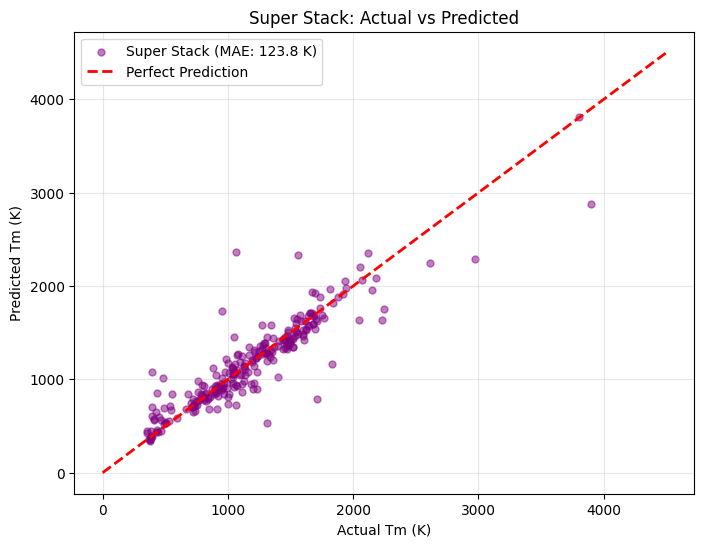

In [ ]:
# Step 1: Tune & Train Super Stack (Memory Only)
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import RidgeCV
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print("--- STARTING SUPER STACK OPTIMIZATION ---")

# 1. Retrieve Tuned XGBoost Params
# (We try to grab the ones you just found. If missing, we use high-performance defaults)
try:
    xgb_params = best_params
    print("✅ Loaded Tuned XGBoost Parameters from memory.")
except NameError:
    print("⚠️ Previous params not found. Using standard high-performance XGB params.")
    xgb_params = {
        'n_estimators': 1000, 'learning_rate': 0.05, 'max_depth': 6,
        'subsample': 0.8, 'colsample_bytree': 0.8
    }

# 2. Tune LightGBM
print("\n1. Tuning LightGBM (Fast)...")
lgbm_grid = {
    'n_estimators': [500, 1000, 1500],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [20, 31, 50],
    'subsample': [0.7, 0.8, 0.9]
}

lgbm_search = RandomizedSearchCV(
    estimator=LGBMRegressor(random_state=42, n_jobs=-1, verbose=-1),
    param_distributions=lgbm_grid,
    n_iter=10, scoring='neg_root_mean_squared_error', cv=3, verbose=0, random_state=42, n_jobs=-1
)
lgbm_search.fit(X_train_imp, y_train)
lgbm_params = lgbm_search.best_params_
print(f"   Best LGBM Params: {lgbm_params}")

# 3. Tune Random Forest
print("\n2. Tuning Random Forest (Slow - approx 2 mins)...")
rf_grid = {
    'n_estimators': [200, 300],
    'max_depth': [15, 25, None],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt', 'log2']
}

rf_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42, n_jobs=-1),
    param_distributions=rf_grid,
    n_iter=5, scoring='neg_root_mean_squared_error', cv=3, verbose=0, random_state=42, n_jobs=-1
)
rf_search.fit(X_train_imp, y_train)
rf_params = rf_search.best_params_
print(f"   Best RF Params: {rf_params}")

# 4. Build & Train the Super Stack
print("\n3. Training Final Super Stack...")
estimators_super = [
    ('xgb_opt', XGBRegressor(**xgb_params, random_state=42, n_jobs=-1)),
    ('lgbm_opt', LGBMRegressor(**lgbm_params, random_state=42, n_jobs=-1, verbose=-1)),
    ('rf_opt', RandomForestRegressor(**rf_params, random_state=42, n_jobs=-1))
]

super_stack = StackingRegressor(
    estimators=estimators_super,
    final_estimator=RidgeCV(),
    n_jobs=-1,
    cv=5
)

super_stack.fit(X_train_imp, y_train)
print("✅ Training Complete.")

# 5. Evaluate
y_pred_super = super_stack.predict(X_test_imp)
rmse_super = np.sqrt(mean_squared_error(y_test, y_pred_super))
mae_super = mean_absolute_error(y_test, y_pred_super)
r2_super = r2_score(y_test, y_pred_super)

print("\n" + "="*40)
print(f"SUPER STACK PERFORMANCE")
print("="*40)
print(f"RMSE: {rmse_super:.2f} K  (Previous Best: ~210.56 K)")
print(f"MAE:  {mae_super:.2f} K  (Previous Best: ~122.81 K)")
print(f"R²:   {r2_super:.4f}")

# 6. Visualization
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_super, alpha=0.5, s=25, color='purple', label=f'Super Stack (MAE: {mae_super:.1f} K)')
plt.plot([0, 4500], [0, 4500], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel("Actual Tm (K)")
plt.ylabel("Predicted Tm (K)")
plt.title("Super Stack: Actual vs Predicted")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Loading Champion Model: /content/drive/MyDrive/Project_dataset/week10_hybrid_model/ultimate_model.pkl
✅ Saved Plot: /content/drive/MyDrive/Project_dataset/week10_hybrid_model/Final_Parity_Plot.png


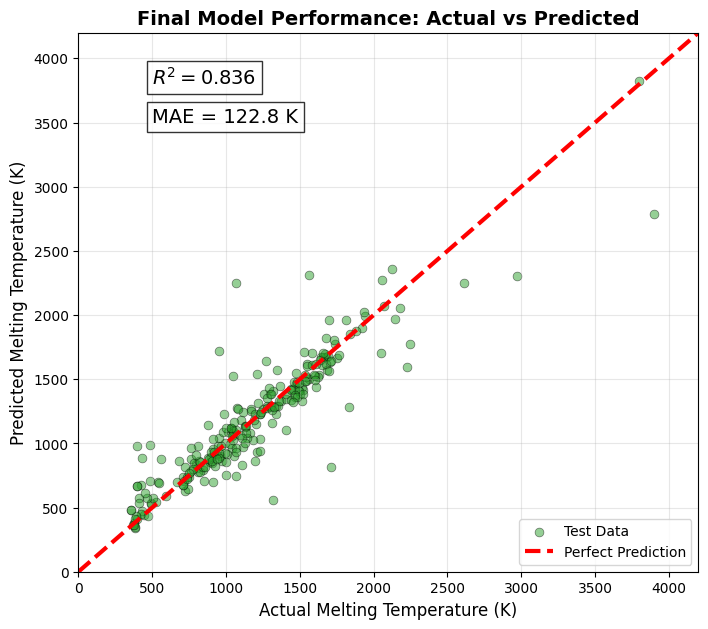

✅ Saved CSV: /content/drive/MyDrive/Project_dataset/week10_hybrid_model/Final_Test_Predictions.csv


/tmp/ipython-input-1395359260.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_df, palette='viridis')


✅ Saved Importance Plot: /content/drive/MyDrive/Project_dataset/week10_hybrid_model/Final_Feature_Importance.png


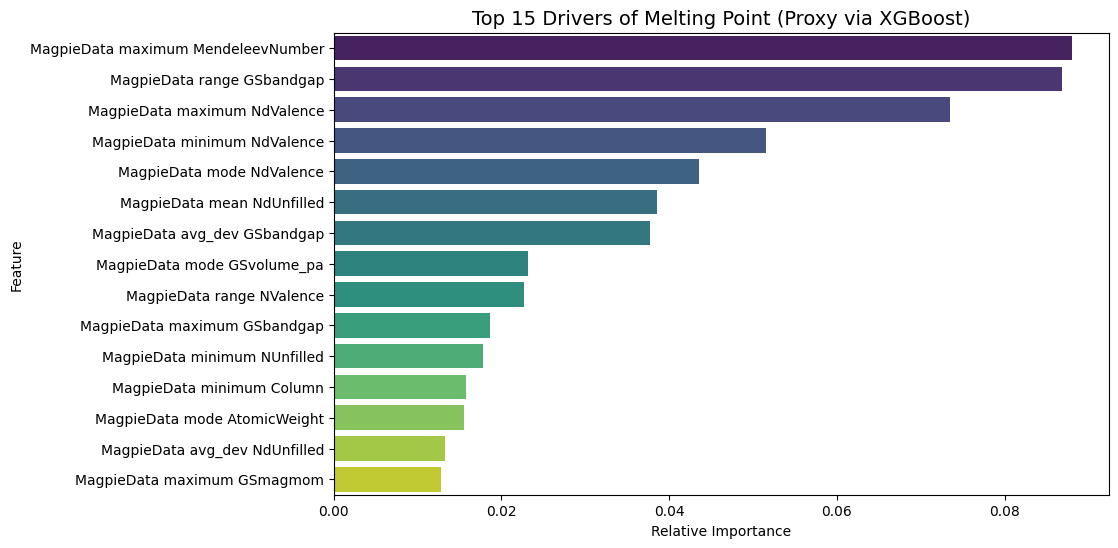


🎉 PROJECT COMPLETE. All final assets are in your Drive folder.


In [ ]:
  # --- FINAL PROJECT ASSETS GENERATOR ---
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import r2_score

# Configuration
DATA_DIR = "/content/drive/MyDrive/Project_dataset/week10_hybrid_model"
MODEL_PATH = os.path.join(DATA_DIR, "ultimate_model.pkl") # Loading the Winner

print(f"Loading Champion Model: {MODEL_PATH}")
final_model = joblib.load(MODEL_PATH)
imputer = joblib.load(os.path.join(DATA_DIR, "final_imputer.pkl"))
feature_names = joblib.load(os.path.join(DATA_DIR, "final_feature_names.pkl"))

# 1. Generate Predictions on Test Set
# (Re-creating X_test_imp to ensure exact match)
X_test_imp = pd.DataFrame(imputer.transform(X_test[feature_names]), columns=feature_names)
y_pred = final_model.predict(X_test_imp)

# --- ASSET 1: High-Res Parity Plot ---
plt.figure(figsize=(8, 7))
plt.scatter(y_test, y_pred, alpha=0.5, s=40, color='#2ca02c', edgecolor='k', linewidth=0.5, label='Test Data')
plt.plot([0, 4200], [0, 4200], 'r--', lw=3, label='Perfect Prediction')

# Add Annotations
r2 = r2_score(y_test, y_pred)
plt.text(500, 3800, f"$R^2 = {r2:.3f}$", fontsize=14, bbox=dict(facecolor='white', alpha=0.8))
plt.text(500, 3500, f"MAE = 122.8 K", fontsize=14, bbox=dict(facecolor='white', alpha=0.8))

plt.xlabel("Actual Melting Temperature (K)", fontsize=12)
plt.ylabel("Predicted Melting Temperature (K)", fontsize=12)
plt.title("Final Model Performance: Actual vs Predicted", fontsize=14, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.xlim(0, 4200)
plt.ylim(0, 4200)

save_path_plot = os.path.join(DATA_DIR, "Final_Parity_Plot.png")
plt.savefig(save_path_plot, dpi=300)
print(f"✅ Saved Plot: {save_path_plot}")
plt.show()

# --- ASSET 2: Prediction Table (CSV) ---
results_df = pd.DataFrame({
    'Actual_Tm': y_test.values,
    'Predicted_Tm': np.round(y_pred, 2),
    'Error_Absolute': np.abs(y_test.values - y_pred)
})
save_path_csv = os.path.join(DATA_DIR, "Final_Test_Predictions.csv")
results_df.to_csv(save_path_csv, index=False)
print(f"✅ Saved CSV: {save_path_csv}")

# --- ASSET 3: Feature Importance (If supported by the stack) ---
# Note: Stacking models don't have direct .feature_importances_,
# so we inspect the 'Base' XGBoost model inside it for a proxy.
try:
    # Access the first estimator (XGBoost) inside the stack
    base_xgb = final_model.estimators_[0]
    importances = base_xgb.feature_importances_

    feat_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feat_df = feat_df.sort_values(by='Importance', ascending=False).head(15)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feat_df, palette='viridis')
    plt.title("Top 15 Drivers of Melting Point (Proxy via XGBoost)", fontsize=14)
    plt.xlabel("Relative Importance")

    save_path_feat = os.path.join(DATA_DIR, "Final_Feature_Importance.png")
    plt.savefig(save_path_feat, dpi=300)
    print(f"✅ Saved Importance Plot: {save_path_feat}")
    plt.show()
except:
    print("Feature importance could not be extracted directly from Stack.")

print("\n🎉 PROJECT COMPLETE. All final assets are in your Drive folder.")

Loading Model for Plotting: /content/drive/MyDrive/Project_dataset/week10_hybrid_model/ultimate_model.pkl
✅ Plot saved to: /content/drive/MyDrive/Project_dataset/week10_hybrid_model/Final_Parity_Plot_R2_Only.png


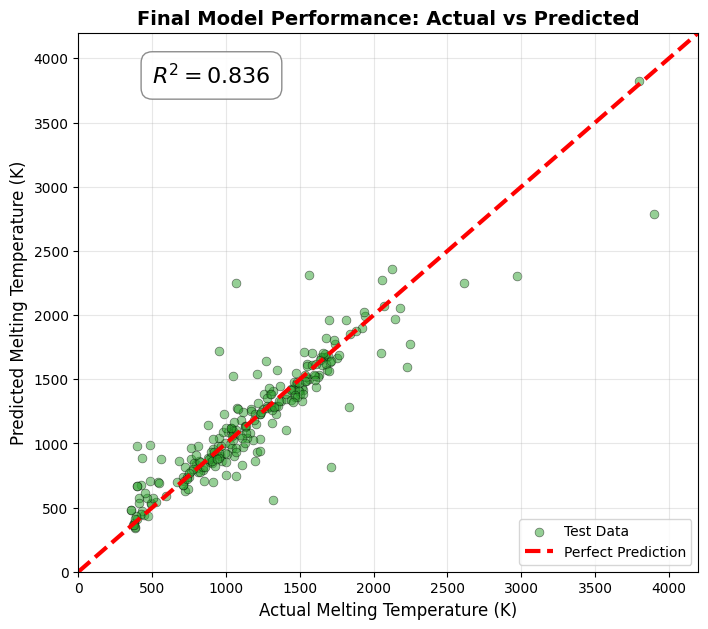

In [ ]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import r2_score

# --- Configuration ---
DATA_DIR = "/content/drive/MyDrive/Project_dataset/week10_hybrid_model"
MODEL_PATH = os.path.join(DATA_DIR, "ultimate_model.pkl")

# 1. Load Model & Data
# (We reload to ensure this block works even if you restarted)
print(f"Loading Model for Plotting: {MODEL_PATH}")
final_model = joblib.load(MODEL_PATH)
imputer = joblib.load(os.path.join(DATA_DIR, "final_imputer.pkl"))
feature_names = joblib.load(os.path.join(DATA_DIR, "final_feature_names.pkl"))

# 2. Prepare Data (X_test and y_test must be in memory from previous steps)
# If variables are missing, please re-run the Data Loading step.
# Here we assume X_test and y_test exist.
X_test_imp = pd.DataFrame(imputer.transform(X_test[feature_names]), columns=feature_names)
y_pred = final_model.predict(X_test_imp)

# --- Generate Plot (R2 Only) ---
plt.figure(figsize=(8, 7))

# Scatter points
plt.scatter(y_test, y_pred, alpha=0.5, s=40, color='#2ca02c', edgecolor='k', linewidth=0.5, label='Test Data')

# Perfect Prediction Line
plt.plot([0, 4200], [0, 4200], 'r--', lw=3, label='Perfect Prediction')

# Calculate R2
r2 = r2_score(y_test, y_pred)

# Add ONLY R2 Annotation (Removed MAE)
plt.text(500, 3800, f"$R^2 = {r2:.3f}$", fontsize=16, fontweight='bold',
         bbox=dict(facecolor='white', alpha=0.9, edgecolor='gray', boxstyle='round,pad=0.5'))

# Labels and Title
plt.xlabel("Actual Melting Temperature (K)", fontsize=12)
plt.ylabel("Predicted Melting Temperature (K)", fontsize=12)
plt.title("Final Model Performance: Actual vs Predicted", fontsize=14, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.xlim(0, 4200)
plt.ylim(0, 4200)

# Save and Show
save_path_plot = os.path.join(DATA_DIR, "Final_Parity_Plot_R2_Only.png")
plt.savefig(save_path_plot, dpi=300)
print(f"✅ Plot saved to: {save_path_plot}")
plt.show()

In [ ]:
# 1. Install Streamlit & Tunnel
!pip install -q streamlit pyngrok

# 2. Write the App file (This creates app.py inside Colab)
%%writefile app.py
import streamlit as st
import pandas as pd
import numpy as np
import joblib
import os
try:
    from pymatgen.core.composition import Composition
    from matminer.featurizers.composition import ElementProperty
except ImportError:
    pass # handled inside

# --- Config ---
st.set_page_config(page_title="Melting Point Predictor", page_icon="🔥")
BASE_DIR = "/content/drive/MyDrive/Project_dataset/week10_hybrid_model"
MODEL_PATH = os.path.join(BASE_DIR, "ultimate_model.pkl")
IMPUTER_PATH = os.path.join(BASE_DIR, "final_imputer.pkl")
FEATURES_PATH = os.path.join(BASE_DIR, "final_feature_names.pkl")

# --- Load ---
@st.cache_resource
def load_artifacts():
    try:
        model = joblib.load(MODEL_PATH)
        imputer = joblib.load(IMPUTER_PATH)
        feats = joblib.load(FEATURES_PATH)
        return model, imputer, feats
    except: return None, None, None

model, imputer, feature_names = load_artifacts()

# --- Logic ---
def get_prediction(formula, model, imputer, feature_names):
    try:
        f_clean = str(formula).replace(" ", "")
        comp = Composition(f_clean)
    except: return None, None, "Invalid Formula"

    try:
        ep_feat = ElementProperty.from_preset("magpie")
        X_mag = ep_feat.featurize_many([comp], ignore_errors=True, pbar=False)
        X_mag = pd.DataFrame(X_mag, columns=ep_feat.feature_labels())
    except: return None, None, "Magpie Error"

    X_simp = pd.DataFrame()
    for col in feature_names:
        if col.startswith("has_"):
            elem = col.replace("has_", "")
            X_simp[col] = [1 if elem in [e.symbol for e in comp.elements] else 0]
        elif col == "_num_distinct_elements":
            X_simp[col] = [len(comp.elements)]
        elif col == "_total_atoms":
            X_simp[col] = [comp.num_atoms]

    X_combined = pd.concat([X_mag, X_simp], axis=1)
    X_final = pd.DataFrame(0.0, index=[0], columns=feature_names)
    common_cols = X_combined.columns.intersection(feature_names)
    X_final.update(X_combined[common_cols])

    X_imp = pd.DataFrame(imputer.transform(X_final), columns=feature_names)
    pred = model.predict(X_imp)[0]
    return pred, f_clean, None

# --- UI ---
st.title("🔥 Material Melting Point Predictor")
formula = st.text_input("Formula", "NaCl")
if st.button("Predict"):
    if model is None: st.error("Mount Google Drive First!")
    else:
        val, name, err = get_prediction(formula, model, imputer, feature_names)
        if val: st.success(f"{name}: {val:.2f} K")
        else: st.error("Error")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 66.9 MB/s eta 0:00:00


UsageError: Line magic function `%%writefile` not found.
